# Extract cancer variant reads for alignment visualization

## In this notebook, we use a single RNA-seq fastq file from a melanoma cancer cell line from the the CCLE project. Learn more about the project here:
- sequencing data (ENA): https://www.ebi.ac.uk/ena/browser/view/PRJNA523380
- paper: https://www.nature.com/articles/s41586-019-1186-3

### Requirements: kb, samtools, and bowtie2

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
try:
    import RLSRWP_2025
except ImportError:
    print("RLSRWP_2025 not found, installing...")
    !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git

In [2]:
import anndata
import os
import subprocess
from datetime import datetime
import numpy as np
import pandas as pd
import re
import gget
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import pyfastx
import glob
import requests
from collections import Counter
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
from tqdm import tqdm
# pd.set_option('display.max_columns', None)
import varseek as vk

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025
threads = "8"

### File path definitions and imports

ENST00000390312:c.218G>A       1848.0
ENST00000336023:c.614A>G       1493.0
ENST00000579721:c.870G>C       1464.0
ENST00000496168:c.382G>A       1382.0
ENST00000579721:c.41C>T        1346.0

In [3]:
experiment_alias = "E_GEUV_1_HG00102_3_M_120202_8"
fastq_file_base = "ERR188416"

notebook_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", experiment_alias, "vk_count_out_w37_k41")
figures_out_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias)
aligned_reads_parent_dir = os.path.join(notebook_out_dir, "pseudoaligned_reads_to_vcrs_reference")
bowtie_read_alignments = os.path.join(notebook_out_dir, "bowtie_read_alignments_modified_bam")
detailed_txt_out = os.path.join(notebook_out_dir, "detailed_out_modified_bam.txt")
overall_txt_out = os.path.join(notebook_out_dir, "overall_out_modified_bam.txt")

# fp df
fp_df_path = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias, "fp_df.parquet")
number_of_variants = None  # sorted by counts descending; None for all
hgvs_df_path = os.path.join(RLSRWP_2025_dir, "data", "reference", "geuvadis", "variants_transcriptome.parquet")

# vk ref out directory and files - downloaded if not already present
vk_ref_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_ref_out_geuvadis", "w37_k41")
vcrs_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
vcrs_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")
vcrs_fasta = os.path.join(vk_ref_out_dir, "vcrs_filtered.fa")

# fastq directories - fastqs_dir downloaded if not already present, and fastqs_processed_dir created with fastp if not already present
fastqs_dir = os.path.join(RLSRWP_2025_dir, "data", "geuvadis_data_base", experiment_alias)
fastq_files = [os.path.join(fastqs_dir, f"{fastq_file_base}_1.fastq.gz"), os.path.join(fastqs_dir, f"{fastq_file_base}_2.fastq.gz")]
fastq_file = os.path.join(fastqs_dir, "fastqs_combined", "fastqs_combined.fastq.gz")  # os.path.join(fastqs_dir, "ERR204838_1.fastq.gz")
technology = "bulk"

# reference genome directory
reference_genome_dir = os.path.join(RLSRWP_2025_dir, "data", "reference", "ensembl_grch37_release113")
reference_genome_fasta = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.dna.primary_assembly.fa")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf
reference_genome_gtf = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.87.gtf")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf

# for bowtie2 - also uses reference_genome_fasta above (I could use cdna instead of genome too if desired)
bowtie_reference_dir = os.path.join(reference_genome_dir, "bowtie_index_genome")
bowtie_reference_prefix = os.path.join(bowtie_reference_dir, "index")

# more settings for vk count if needed
reference_out_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
reference_genome_index = os.path.join(reference_out_dir, "ensembl_grch37_release113", "index.idx")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
reference_genome_t2g = os.path.join(reference_out_dir, "ensembl_grch37_release113", "t2g.txt")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
geuvadis_reference_files_dir = os.path.join(reference_out_dir, "geuvadis")
seq_id_column = "transcript_ID"
var_column = "variant_cdna"
gene_id_column = "gene_name"
variants_usecols = [seq_id_column, var_column, gene_id_column]

# general
w = "37"  # used during creation of the index, so cannot be altered
k = "41"  # used during creation of the index, so cannot be altered
strand = "unstranded"
parity = "single"
mm = True
union = True
quality_control_fastqs = True
qc_against_gene_matrix = False
mistake_ratio = 0.5
use_combined = True
modify_bam = True  # convert 256 flag to 0
min_counts = 2

# software
bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"
bowtie2 = "bowtie2"
bowtie2_build = "bowtie2-build"
samtools = "samtools"
email = os.environ.get("EMAIL")

### Make bowtie2 index files

In [4]:
if not os.path.exists(bowtie_reference_dir) or len(os.listdir(bowtie_reference_dir)) == 0:
    os.makedirs(bowtie_reference_dir, exist_ok=True)
    !{bowtie2_build} --threads {threads} {reference_genome_fasta} {bowtie_reference_prefix}

### Load in FP df

In [5]:
fp_df = pd.read_parquet(fp_df_path)
if "variant_count" in fp_df.columns and "vcrs_count" not in fp_df.columns:
    fp_df = fp_df.rename(columns={"variant_count": "vcrs_count"})
fp_df = fp_df.sort_values("vcrs_count", ascending=False)
if number_of_variants is not None:
    fp_df = fp_df.head(number_of_variants)

# fp_df = fp_df.set_index('variant_header')
fps = set(fp_df['variant_header'].tolist())
print(fps)
fp_df.head()

{'ENST00000390308:c.321A>G', 'ENST00000299767:c.2068A>C', 'ENST00000299300:c.971A>G', 'ENST00000369744:c.902A>G', 'ENST00000369064:c.976C>T', 'ENST00000268668:c.189C>T', 'ENST00000263932:c.549A>G', 'ENST00000217652:c.501G>A', 'ENST00000317296:c.3782C>T', 'ENST00000579721:c.1013A>T', 'ENST00000390294:c.230G>A', 'ENST00000242465:c.294G>A', 'ENST00000563769:c.774T>C', 'ENST00000256324:c.1745T>C', 'ENST00000579721:c.605C>T', 'ENST00000230050:c.472T>C', 'ENST00000274065:c.104C>T', 'ENST00000229195:c.872G>A', 'ENST00000353801:c.155G>T', 'ENST00000394295:c.1034C>T', 'ENST00000227157:c.683G>C', 'ENST00000520147:c.256T>C', 'ENST00000322446:c.658A>G', 'ENST00000396334:c.827A>C', 'ENST00000420712:c.37C>T', 'ENST00000491977:c.163T>C', 'ENST00000339647:c.1638T>C', 'ENST00000325215:c.660C>T', 'ENST00000251879:c.3261A>C', 'ENST00000378665:c.326C>T', 'ENST00000265742:c.813_814insA', 'ENST00000262544:c.808A>C', 'ENST00000595390:c.654T>C', 'ENST00000604930:c.285C>A', 'ENST00000265748:c.1104_1106dup', 'E

vcrs_count          variant_header_cds            variant_header  \
index                                                                      
128138       440.0  ENST00000603210.1:c.218G>A  ENST00000603210:c.277G>A   
110407       195.0  ENST00000322446.3:c.357A>G  ENST00000322446:c.658A>G   
127974       174.0  ENST00000604405.1:c.256T>A  ENST00000604405:c.320T>A   
174839       159.0  ENST00000390294.2:c.174G>A  ENST00000390294:c.230G>A   
174836       118.0  ENST00000390294.2:c.146G>A  ENST00000390294:c.202G>A   

          transcript_ID             gene  gene_count  genotype  
index                                                           
128138  ENST00000603210             None         NaN       0.0  
110407  ENST00000322446  ENSG00000180574        45.0       0.0  
127974  ENST00000604405             None         NaN       0.0  
174839  ENST00000390294  ENSG00000211648       535.0       0.0  
174836  ENST00000390294  ENSG00000211648       535.0       0.0

### Make pyfastx index files

In [6]:
if use_combined:
    if not os.path.isfile(fastq_file):
        import gzip
        os.makedirs(os.path.dirname(fastq_file), exist_ok=True)
        def process_and_write(input_path, output_file, file_tag):
            with gzip.open(input_path, "rt") as f_in:
                for i, line in enumerate(f_in):
                    if i % 4 == 0 and line.startswith('@'):
                        line = f"@{file_tag}{line[1:]}"  # replace @ with @fileX
                    output_file.write(line)

        with gzip.open(fastq_file, "wt") as f_out:
            process_and_write(fastq_files[0], f_out, "file1")
            process_and_write(fastq_files[1], f_out, "file2")
else:
    fastq_file = fastq_files[0]

In [7]:
fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)

### Perform variant screening with varseek count

In [ ]:
kb_count_out_dir = os.path.join(notebook_out_dir, "kb_count_out_vcrs")
adata_path = os.path.join(kb_count_out_dir, "counts_unfiltered", "adata.h5ad")

if not os.path.exists(adata_path):
    vk_count_output_dict = vk.count(
        fastqs=fastq_file,
        index=vcrs_index,
        t2g=vcrs_t2g,
        technology=technology,
        out=notebook_out_dir,
        k=k,
        strand=strand,
        parity=parity,
        threads=threads,
        mm=mm,
        union=union,
        disable_fastqpp=False,
        quality_control_fastqs=True, cut_front=True, cut_tail=True,
        qc_against_gene_matrix=qc_against_gene_matrix, reference_genome_index=reference_genome_index, reference_genome_t2g=reference_genome_t2g, mistake_ratio=mistake_ratio,
        variants = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet"),
        seq_id_column=seq_id_column,
        var_column=var_column,
        gene_id_column=gene_id_column,
        variants_usecols=variants_usecols,
    )

In [9]:
# url = "https://grch37.rest.ensembl.org/vep/human/id"
# headers = {"Content-Type": "application/json"}

hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df = hgvs_df.merge(fp_df, how="left", left_on="header_cdna", right_on="variant_header", suffixes=("", "_fp"))
hgvs_df = hgvs_df.loc[~hgvs_df['vcrs_count'].isna()].sort_values('vcrs_count', ascending=False)  # .sort_values('vcrs_id', ascending=True)
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [10]:
fp_df.head()

vcrs_count          variant_header_cds            variant_header  \
index                                                                      
128138       440.0  ENST00000603210.1:c.218G>A  ENST00000603210:c.277G>A   
110407       195.0  ENST00000322446.3:c.357A>G  ENST00000322446:c.658A>G   
127974       174.0  ENST00000604405.1:c.256T>A  ENST00000604405:c.320T>A   
174839       159.0  ENST00000390294.2:c.174G>A  ENST00000390294:c.230G>A   
174836       118.0  ENST00000390294.2:c.146G>A  ENST00000390294:c.202G>A   

          transcript_ID             gene  gene_count  genotype  
index                                                           
128138  ENST00000603210             None         NaN       0.0  
110407  ENST00000322446  ENSG00000180574        45.0       0.0  
127974  ENST00000604405             None         NaN       0.0  
174839  ENST00000390294  ENSG00000211648       535.0       0.0  
174836  ENST00000390294  ENSG00000211648       535.0       0.0

From dbSNP (roughly):
ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.23101523G>A chrom22
ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
ENST00000579721:c.41C>T: rs115527405
ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6

### Align (1) pulled out reads and (2) the VCRSs to the human genome to generate bam files:

In [11]:
import pysam

def make_all_alignments_primary(infile_path, outfile_path):
    infile = pysam.AlignmentFile(infile_path, "rb")
    outfile = pysam.AlignmentFile(outfile_path, "wb", template=infile)

    for read in infile:
        read.flag = read.flag & ~256  # remove secondary flag
        outfile.write(read)

    infile.close()
    outfile.close()

In [12]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FP where varseek was correct
false_variants = []  # varseek FP where varseek was incorrect
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        hgvs_df_row = hgvs_df.loc[hgvs_df['vcrs_id'] == variant]
        dbsnp_id = hgvs_df_row['dbsnp_id'].values[0]
        hgvsc = hgvs_df_row['header_cdna'].values[0]
        strand = hgvs_df_row['strand'].values[0]
        variant_counts = hgvs_df_row['vcrs_count'].values[0]
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = hgvs_df_row['transcript_ID'].values[0]
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} | {variant_counts} reported counts\n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

10:56:35: Aligning to genome


11:16:45: SAM --> BAM


11:23:53: BAM sort


[bam_sort_core] merging from 28 files and 1 in-memory blocks...


11:34:55: Remove 256's


11:49:12: BAM index


11:49:51: Entering the loop



  0%|                                                                                                                                                                                  | 0/355 [00:00<?, ?it/s]


  0%|▍                                                                                                                                                                         | 1/355 [00:01<10:47,  1.83s/it]


  1%|▉                                                                                                                                                                         | 2/355 [00:02<06:27,  1.10s/it]


  1%|█▍                                                                                                                                                                        | 3/355 [00:03<07:07,  1.21s/it]


  1%|█▉                                                                                                                                                                        | 4/355 [00:04<05:41,  1.03it/s]


  1%|██▍                                                                                                                                                                       | 5/355 [00:04<04:53,  1.19it/s]


  2%|██▊                                                                                                                                                                       | 6/355 [00:06<05:45,  1.01it/s]


  2%|███▎                                                                                                                                                                      | 7/355 [00:06<05:01,  1.15it/s]


  2%|███▊                                                                                                                                                                      | 8/355 [00:08<05:38,  1.03it/s]


  3%|████▎                                                                                                                                                                     | 9/355 [00:08<04:54,  1.17it/s]


  3%|████▊                                                                                                                                                                    | 10/355 [00:09<05:29,  1.05it/s]


  3%|█████▋                                                                                                                                                                   | 12/355 [00:10<04:02,  1.41it/s]


  4%|██████▏                                                                                                                                                                  | 13/355 [00:11<03:55,  1.45it/s]


  4%|██████▋                                                                                                                                                                  | 14/355 [00:12<03:56,  1.44it/s]


  4%|███████▏                                                                                                                                                                 | 15/355 [00:12<04:13,  1.34it/s]


  5%|███████▌                                                                                                                                                                 | 16/355 [00:13<03:58,  1.42it/s]


  5%|████████                                                                                                                                                                 | 17/355 [00:14<04:00,  1.40it/s]


  5%|████████▌                                                                                                                                                                | 18/355 [00:14<03:51,  1.46it/s]


  5%|█████████                                                                                                                                                                | 19/355 [00:15<03:39,  1.53it/s]


  6%|█████████▌                                                                                                                                                               | 20/355 [00:16<03:35,  1.55it/s]


  6%|█████████▉                                                                                                                                                               | 21/355 [00:17<04:13,  1.32it/s]


  6%|██████████▍                                                                                                                                                              | 22/355 [00:18<04:57,  1.12it/s]


  6%|██████████▉                                                                                                                                                              | 23/355 [00:19<05:42,  1.03s/it]


  7%|███████████▍                                                                                                                                                             | 24/355 [00:20<05:07,  1.08it/s]


  7%|███████████▉                                                                                                                                                             | 25/355 [00:20<04:36,  1.19it/s]


  7%|████████████▍                                                                                                                                                            | 26/355 [00:21<04:16,  1.28it/s]


  8%|████████████▊                                                                                                                                                            | 27/355 [00:22<04:08,  1.32it/s]


  8%|█████████████▎                                                                                                                                                           | 28/355 [00:22<03:53,  1.40it/s]


  8%|█████████████▊                                                                                                                                                           | 29/355 [00:23<03:42,  1.47it/s]


  8%|██████████████▎                                                                                                                                                          | 30/355 [00:24<03:36,  1.50it/s]


  9%|██████████████▊                                                                                                                                                          | 31/355 [00:24<03:28,  1.55it/s]


  9%|███████████████▏                                                                                                                                                         | 32/355 [00:25<03:41,  1.46it/s]


  9%|███████████████▋                                                                                                                                                         | 33/355 [00:26<03:31,  1.52it/s]


 10%|████████████████▏                                                                                                                                                        | 34/355 [00:26<03:24,  1.57it/s]


 10%|████████████████▋                                                                                                                                                        | 35/355 [00:27<03:20,  1.60it/s]


 10%|█████████████████▏                                                                                                                                                       | 36/355 [00:28<04:33,  1.17it/s]


 10%|█████████████████▌                                                                                                                                                       | 37/355 [00:29<04:07,  1.29it/s]


 11%|██████████████████                                                                                                                                                       | 38/355 [00:30<04:25,  1.19it/s]


 11%|██████████████████▌                                                                                                                                                      | 39/355 [00:30<04:01,  1.31it/s]


 11%|███████████████████                                                                                                                                                      | 40/355 [00:31<03:48,  1.38it/s]


 12%|███████████████████▌                                                                                                                                                     | 41/355 [00:32<03:42,  1.41it/s]


 12%|███████████████████▉                                                                                                                                                     | 42/355 [00:32<03:30,  1.49it/s]


 12%|████████████████████▍                                                                                                                                                    | 43/355 [00:33<03:42,  1.40it/s]


 12%|████████████████████▉                                                                                                                                                    | 44/355 [00:34<03:56,  1.32it/s]


 13%|█████████████████████▍                                                                                                                                                   | 45/355 [00:35<04:44,  1.09it/s]


 13%|█████████████████████▉                                                                                                                                                   | 46/355 [00:36<04:13,  1.22it/s]


 13%|██████████████████████▎                                                                                                                                                  | 47/355 [00:36<03:50,  1.34it/s]


 14%|██████████████████████▊                                                                                                                                                  | 48/355 [00:38<04:30,  1.14it/s]


 14%|███████████████████████▎                                                                                                                                                 | 49/355 [00:39<05:09,  1.01s/it]


 14%|███████████████████████▊                                                                                                                                                 | 50/355 [00:40<04:30,  1.13it/s]


 14%|████████████████████████▎                                                                                                                                                | 51/355 [00:40<04:12,  1.21it/s]


 15%|████████████████████████▊                                                                                                                                                | 52/355 [00:42<04:57,  1.02it/s]


 15%|█████████████████████████▏                                                                                                                                               | 53/355 [00:42<04:31,  1.11it/s]


 15%|█████████████████████████▋                                                                                                                                               | 54/355 [00:43<04:02,  1.24it/s]


 15%|██████████████████████████▏                                                                                                                                              | 55/355 [00:43<03:45,  1.33it/s]


 16%|██████████████████████████▋                                                                                                                                              | 56/355 [00:44<03:34,  1.39it/s]


 16%|███████████████████████████▏                                                                                                                                             | 57/355 [00:45<04:15,  1.17it/s]


 16%|███████████████████████████▌                                                                                                                                             | 58/355 [00:46<04:45,  1.04it/s]


 17%|████████████████████████████▌                                                                                                                                            | 60/355 [00:47<03:14,  1.52it/s]


 17%|█████████████████████████████                                                                                                                                            | 61/355 [00:48<03:08,  1.56it/s]


 17%|█████████████████████████████▌                                                                                                                                           | 62/355 [00:48<03:04,  1.58it/s]


 18%|█████████████████████████████▉                                                                                                                                           | 63/355 [00:49<03:15,  1.49it/s]


 18%|██████████████████████████████▍                                                                                                                                          | 64/355 [00:50<03:19,  1.46it/s]


 18%|██████████████████████████████▉                                                                                                                                          | 65/355 [00:51<04:09,  1.16it/s]


 19%|███████████████████████████████▍                                                                                                                                         | 66/355 [00:52<04:09,  1.16it/s]


 19%|███████████████████████████████▉                                                                                                                                         | 67/355 [00:53<03:43,  1.29it/s]


 19%|████████████████████████████████▎                                                                                                                                        | 68/355 [00:53<03:44,  1.28it/s]


 19%|████████████████████████████████▊                                                                                                                                        | 69/355 [00:54<03:27,  1.38it/s]


 20%|█████████████████████████████████▎                                                                                                                                       | 70/355 [00:55<03:15,  1.46it/s]


 20%|█████████████████████████████████▊                                                                                                                                       | 71/355 [00:55<03:18,  1.43it/s]


 20%|██████████████████████████████████▎                                                                                                                                      | 72/355 [00:56<03:06,  1.52it/s]


 21%|██████████████████████████████████▊                                                                                                                                      | 73/355 [00:56<02:58,  1.58it/s]


 21%|███████████████████████████████████▏                                                                                                                                     | 74/355 [00:57<02:54,  1.61it/s]


 21%|███████████████████████████████████▋                                                                                                                                     | 75/355 [00:58<02:52,  1.62it/s]


 21%|████████████████████████████████████▏                                                                                                                                    | 76/355 [00:58<02:48,  1.66it/s]


 22%|████████████████████████████████████▋                                                                                                                                    | 77/355 [00:59<02:46,  1.67it/s]


 22%|█████████████████████████████████████▏                                                                                                                                   | 78/355 [00:59<02:43,  1.69it/s]


 22%|█████████████████████████████████████▌                                                                                                                                   | 79/355 [01:00<02:42,  1.70it/s]


 23%|██████████████████████████████████████                                                                                                                                   | 80/355 [01:00<02:39,  1.73it/s]


 23%|██████████████████████████████████████▌                                                                                                                                  | 81/355 [01:01<02:39,  1.72it/s]


 23%|███████████████████████████████████████                                                                                                                                  | 82/355 [01:02<03:00,  1.51it/s]


 23%|███████████████████████████████████████▌                                                                                                                                 | 83/355 [01:02<02:54,  1.55it/s]


 24%|███████████████████████████████████████▉                                                                                                                                 | 84/355 [01:03<02:49,  1.60it/s]


 24%|████████████████████████████████████████▍                                                                                                                                | 85/355 [01:04<03:05,  1.46it/s]


 24%|████████████████████████████████████████▉                                                                                                                                | 86/355 [01:04<02:55,  1.53it/s]


 25%|█████████████████████████████████████████▍                                                                                                                               | 87/355 [01:05<02:49,  1.59it/s]


 25%|█████████████████████████████████████████▉                                                                                                                               | 88/355 [01:06<02:54,  1.53it/s]


 25%|██████████████████████████████████████████▎                                                                                                                              | 89/355 [01:06<02:51,  1.55it/s]


 25%|██████████████████████████████████████████▊                                                                                                                              | 90/355 [01:07<03:15,  1.36it/s]


 26%|███████████████████████████████████████████▎                                                                                                                             | 91/355 [01:08<03:11,  1.38it/s]


 26%|███████████████████████████████████████████▊                                                                                                                             | 92/355 [01:09<03:01,  1.45it/s]


 26%|████████████████████████████████████████████▎                                                                                                                            | 93/355 [01:09<02:52,  1.52it/s]


 26%|████████████████████████████████████████████▋                                                                                                                            | 94/355 [01:10<02:45,  1.58it/s]


 27%|█████████████████████████████████████████████▏                                                                                                                           | 95/355 [01:10<02:40,  1.62it/s]


 27%|█████████████████████████████████████████████▋                                                                                                                           | 96/355 [01:11<02:37,  1.64it/s]


 27%|██████████████████████████████████████████████▏                                                                                                                          | 97/355 [01:12<02:48,  1.53it/s]


 28%|██████████████████████████████████████████████▋                                                                                                                          | 98/355 [01:12<02:43,  1.57it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                         | 99/355 [01:13<02:39,  1.60it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                        | 100/355 [01:14<02:37,  1.62it/s]


 28%|███████████████████████████████████████████████▊                                                                                                                        | 101/355 [01:14<02:33,  1.65it/s]


 29%|████████████████████████████████████████████████▎                                                                                                                       | 102/355 [01:15<02:47,  1.51it/s]


 29%|████████████████████████████████████████████████▋                                                                                                                       | 103/355 [01:16<02:43,  1.54it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                      | 104/355 [01:16<02:39,  1.57it/s]


 30%|█████████████████████████████████████████████████▋                                                                                                                      | 105/355 [01:17<02:52,  1.45it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                     | 106/355 [01:18<02:45,  1.50it/s]


 30%|██████████████████████████████████████████████████▋                                                                                                                     | 107/355 [01:18<02:39,  1.56it/s]


 30%|███████████████████████████████████████████████████                                                                                                                     | 108/355 [01:19<02:33,  1.61it/s]


 31%|███████████████████████████████████████████████████▌                                                                                                                    | 109/355 [01:19<02:32,  1.62it/s]


 31%|████████████████████████████████████████████████████                                                                                                                    | 110/355 [01:20<02:28,  1.65it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                   | 111/355 [01:21<02:43,  1.50it/s]


 32%|█████████████████████████████████████████████████████                                                                                                                   | 112/355 [01:21<02:38,  1.53it/s]


 32%|█████████████████████████████████████████████████████▍                                                                                                                  | 113/355 [01:22<02:32,  1.59it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                  | 114/355 [01:23<02:30,  1.60it/s]


 32%|██████████████████████████████████████████████████████▍                                                                                                                 | 115/355 [01:23<02:29,  1.61it/s]


 33%|██████████████████████████████████████████████████████▉                                                                                                                 | 116/355 [01:24<03:10,  1.25it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                | 117/355 [01:26<03:37,  1.09it/s]


 33%|███████████████████████████████████████████████████████▊                                                                                                                | 118/355 [01:27<04:00,  1.01s/it]


 34%|████████████████████████████████████████████████████████▎                                                                                                               | 119/355 [01:27<03:28,  1.13it/s]


 34%|████████████████████████████████████████████████████████▊                                                                                                               | 120/355 [01:29<03:57,  1.01s/it]


 34%|█████████████████████████████████████████████████████████▎                                                                                                              | 121/355 [01:29<03:26,  1.13it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                              | 122/355 [01:30<03:08,  1.23it/s]


 35%|██████████████████████████████████████████████████████████▏                                                                                                             | 123/355 [01:30<02:51,  1.35it/s]


 35%|██████████████████████████████████████████████████████████▋                                                                                                             | 124/355 [01:31<02:41,  1.43it/s]


 35%|███████████████████████████████████████████████████████████▏                                                                                                            | 125/355 [01:32<02:33,  1.50it/s]


 35%|███████████████████████████████████████████████████████████▋                                                                                                            | 126/355 [01:32<02:27,  1.55it/s]


 36%|████████████████████████████████████████████████████████████                                                                                                            | 127/355 [01:34<03:26,  1.10it/s]


 36%|████████████████████████████████████████████████████████████▌                                                                                                           | 128/355 [01:34<03:03,  1.23it/s]


 36%|█████████████████████████████████████████████████████████████                                                                                                           | 129/355 [01:35<02:48,  1.34it/s]


 37%|█████████████████████████████████████████████████████████████▌                                                                                                          | 130/355 [01:36<02:39,  1.41it/s]


 37%|█████████████████████████████████████████████████████████████▉                                                                                                          | 131/355 [01:36<02:29,  1.49it/s]


 37%|██████████████████████████████████████████████████████████████▍                                                                                                         | 132/355 [01:37<02:22,  1.56it/s]


 37%|██████████████████████████████████████████████████████████████▉                                                                                                         | 133/355 [01:37<02:18,  1.60it/s]


 38%|███████████████████████████████████████████████████████████████▍                                                                                                        | 134/355 [01:38<02:15,  1.63it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                        | 135/355 [01:38<02:13,  1.65it/s]


 38%|████████████████████████████████████████████████████████████████▎                                                                                                       | 136/355 [01:39<02:21,  1.55it/s]


 39%|████████████████████████████████████████████████████████████████▊                                                                                                       | 137/355 [01:40<02:39,  1.36it/s]


 39%|█████████████████████████████████████████████████████████████████▎                                                                                                      | 138/355 [01:41<02:29,  1.46it/s]


 39%|█████████████████████████████████████████████████████████████████▊                                                                                                      | 139/355 [01:41<02:21,  1.52it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                     | 140/355 [01:42<02:15,  1.58it/s]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                     | 141/355 [01:43<02:13,  1.60it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 142/355 [01:43<02:16,  1.57it/s]


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                   | 144/355 [01:44<01:41,  2.08it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                   | 145/355 [01:44<01:46,  1.97it/s]


 41%|█████████████████████████████████████████████████████████████████████                                                                                                   | 146/355 [01:45<01:50,  1.89it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                  | 147/355 [01:46<01:53,  1.84it/s]


 42%|██████████████████████████████████████████████████████████████████████                                                                                                  | 148/355 [01:46<01:56,  1.78it/s]


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 149/355 [01:47<01:58,  1.74it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                 | 150/355 [01:47<02:00,  1.70it/s]


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                                | 151/355 [01:49<02:35,  1.31it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                | 152/355 [01:50<03:04,  1.10it/s]


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                               | 153/355 [01:50<02:44,  1.23it/s]


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                               | 154/355 [01:51<02:31,  1.32it/s]


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                              | 155/355 [01:52<02:21,  1.42it/s]


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                              | 156/355 [01:52<02:12,  1.50it/s]


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                             | 157/355 [01:53<02:08,  1.54it/s]


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                             | 158/355 [01:53<02:03,  1.60it/s]


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                            | 159/355 [01:55<02:36,  1.25it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                            | 160/355 [01:55<02:22,  1.37it/s]


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                           | 161/355 [01:56<02:51,  1.13it/s]


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                           | 162/355 [01:58<03:25,  1.06s/it]


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                          | 163/355 [01:58<02:56,  1.09it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                          | 164/355 [01:59<02:36,  1.22it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                          | 165/355 [02:00<02:23,  1.32it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                         | 166/355 [02:01<02:59,  1.05it/s]


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                         | 167/355 [02:02<02:37,  1.20it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                        | 168/355 [02:02<02:24,  1.30it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                        | 169/355 [02:03<02:13,  1.40it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 170/355 [02:04<02:44,  1.13it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 171/355 [02:05<02:26,  1.25it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 172/355 [02:05<02:14,  1.37it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 173/355 [02:06<02:04,  1.46it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 174/355 [02:06<01:57,  1.54it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 175/355 [02:07<01:53,  1.58it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 176/355 [02:08<01:50,  1.61it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 177/355 [02:08<01:48,  1.65it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 178/355 [02:09<01:46,  1.66it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 179/355 [02:10<02:21,  1.24it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 180/355 [02:11<02:41,  1.09it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 181/355 [02:12<02:22,  1.22it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 182/355 [02:13<02:39,  1.08it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 183/355 [02:14<02:54,  1.01s/it]


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                 | 184/355 [02:15<02:31,  1.13it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 185/355 [02:15<02:14,  1.26it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                | 186/355 [02:16<02:02,  1.38it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 187/355 [02:17<02:25,  1.16it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 188/355 [02:18<02:10,  1.28it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 189/355 [02:18<01:59,  1.39it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 190/355 [02:20<02:27,  1.12it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 191/355 [02:20<02:11,  1.25it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 192/355 [02:21<01:59,  1.36it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 193/355 [02:21<01:51,  1.45it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 194/355 [02:22<01:45,  1.53it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 195/355 [02:22<01:41,  1.58it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 196/355 [02:23<01:38,  1.62it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 197/355 [02:24<01:35,  1.65it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 198/355 [02:25<02:01,  1.29it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 199/355 [02:25<01:52,  1.39it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 200/355 [02:26<01:45,  1.47it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 201/355 [02:27<01:53,  1.35it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 202/355 [02:27<01:45,  1.45it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 203/355 [02:28<01:40,  1.51it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 204/355 [02:29<01:36,  1.57it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 205/355 [02:30<02:00,  1.25it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 206/355 [02:31<02:01,  1.22it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 207/355 [02:31<01:51,  1.33it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 208/355 [02:32<01:42,  1.43it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 209/355 [02:32<01:36,  1.52it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 210/355 [02:33<01:32,  1.57it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 211/355 [02:34<01:29,  1.61it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 212/355 [02:35<01:52,  1.28it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 213/355 [02:35<01:42,  1.38it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 214/355 [02:36<01:47,  1.31it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 215/355 [02:37<01:52,  1.24it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 216/355 [02:38<01:42,  1.35it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 217/355 [02:38<01:36,  1.44it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 218/355 [02:39<01:30,  1.51it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 219/355 [02:39<01:26,  1.58it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 220/355 [02:40<01:35,  1.41it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 221/355 [02:41<01:29,  1.49it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 222/355 [02:41<01:25,  1.55it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 223/355 [02:42<01:22,  1.60it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 224/355 [02:43<01:20,  1.63it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 225/355 [02:43<01:18,  1.66it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 226/355 [02:44<01:16,  1.69it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 227/355 [02:44<01:14,  1.71it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 228/355 [02:45<01:21,  1.57it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 229/355 [02:46<01:18,  1.61it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 230/355 [02:46<01:15,  1.65it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 231/355 [02:47<01:14,  1.67it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 232/355 [02:47<01:12,  1.70it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 233/355 [02:48<01:11,  1.71it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 234/355 [02:49<01:13,  1.64it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 235/355 [02:49<01:11,  1.68it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 236/355 [02:50<01:11,  1.67it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 237/355 [02:50<01:09,  1.69it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 238/355 [02:51<01:17,  1.51it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 239/355 [02:52<01:14,  1.57it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 240/355 [02:52<01:10,  1.62it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 241/355 [02:53<01:09,  1.65it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 242/355 [02:54<01:07,  1.68it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 243/355 [02:54<01:06,  1.70it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 244/355 [02:55<01:04,  1.71it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 245/355 [02:55<01:04,  1.71it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 246/355 [02:56<01:05,  1.67it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 247/355 [02:56<01:04,  1.68it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 248/355 [02:57<01:04,  1.66it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 249/355 [02:58<01:03,  1.67it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 250/355 [02:58<01:02,  1.68it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 251/355 [02:59<01:01,  1.70it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 252/355 [02:59<01:00,  1.71it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 253/355 [03:01<01:22,  1.24it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 254/355 [03:02<01:33,  1.08it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 255/355 [03:03<01:43,  1.03s/it]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 256/355 [03:04<01:47,  1.08s/it]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 257/355 [03:05<01:33,  1.05it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 258/355 [03:06<01:23,  1.17it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 259/355 [03:06<01:15,  1.27it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 260/355 [03:07<01:08,  1.38it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 261/355 [03:08<01:04,  1.47it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 262/355 [03:08<01:00,  1.54it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 263/355 [03:09<00:57,  1.59it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 264/355 [03:09<00:56,  1.60it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 265/355 [03:10<00:55,  1.63it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 266/355 [03:10<00:53,  1.65it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 267/355 [03:11<00:58,  1.50it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 268/355 [03:12<00:55,  1.56it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 269/355 [03:12<00:53,  1.60it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 270/355 [03:13<00:52,  1.62it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 271/355 [03:14<00:51,  1.63it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 272/355 [03:14<00:50,  1.64it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 273/355 [03:15<00:49,  1.67it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 274/355 [03:15<00:48,  1.69it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 275/355 [03:16<00:46,  1.70it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 276/355 [03:17<00:46,  1.71it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 277/355 [03:17<00:45,  1.73it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 278/355 [03:18<00:44,  1.73it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 279/355 [03:18<00:43,  1.73it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 280/355 [03:19<00:48,  1.56it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 281/355 [03:20<00:47,  1.55it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 282/355 [03:20<00:45,  1.60it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 283/355 [03:21<00:45,  1.60it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 284/355 [03:22<00:47,  1.49it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 285/355 [03:22<00:46,  1.51it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 286/355 [03:23<00:44,  1.57it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 287/355 [03:24<00:46,  1.47it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 288/355 [03:24<00:43,  1.55it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 289/355 [03:25<00:41,  1.60it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 290/355 [03:25<00:39,  1.64it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 291/355 [03:26<00:38,  1.64it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 292/355 [03:27<00:39,  1.61it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 293/355 [03:27<00:37,  1.65it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 294/355 [03:28<00:36,  1.65it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 295/355 [03:28<00:35,  1.67it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 296/355 [03:29<00:34,  1.69it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 297/355 [03:30<00:33,  1.71it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 298/355 [03:30<00:33,  1.73it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 299/355 [03:31<00:32,  1.71it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 300/355 [03:31<00:31,  1.72it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 301/355 [03:32<00:31,  1.73it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 302/355 [03:32<00:30,  1.74it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 303/355 [03:33<00:29,  1.74it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 304/355 [03:34<00:29,  1.71it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 305/355 [03:35<00:38,  1.30it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 306/355 [03:35<00:35,  1.38it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 307/355 [03:36<00:32,  1.47it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 308/355 [03:37<00:30,  1.54it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 309/355 [03:37<00:32,  1.43it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 310/355 [03:38<00:30,  1.50it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 311/355 [03:39<00:28,  1.55it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 312/355 [03:39<00:27,  1.59it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 313/355 [03:40<00:25,  1.66it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 314/355 [03:40<00:24,  1.68it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 315/355 [03:41<00:23,  1.67it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 316/355 [03:41<00:23,  1.69it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 317/355 [03:42<00:22,  1.68it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 318/355 [03:43<00:21,  1.71it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 319/355 [03:43<00:20,  1.72it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 320/355 [03:44<00:22,  1.59it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 321/355 [03:45<00:23,  1.46it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 322/355 [03:46<00:24,  1.37it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 323/355 [03:46<00:21,  1.48it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 324/355 [03:47<00:19,  1.55it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 325/355 [03:47<00:19,  1.55it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 326/355 [03:48<00:18,  1.59it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 327/355 [03:49<00:17,  1.63it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 328/355 [03:49<00:16,  1.64it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 329/355 [03:50<00:15,  1.63it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 330/355 [03:50<00:15,  1.66it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 331/355 [03:51<00:14,  1.63it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 332/355 [03:52<00:14,  1.60it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 333/355 [03:52<00:13,  1.62it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 334/355 [03:53<00:12,  1.62it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 335/355 [03:54<00:13,  1.45it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 336/355 [03:54<00:12,  1.53it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 337/355 [03:55<00:11,  1.58it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 338/355 [03:56<00:11,  1.43it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 339/355 [03:56<00:10,  1.47it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 340/355 [03:58<00:12,  1.18it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 341/355 [03:58<00:10,  1.29it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 342/355 [03:59<00:09,  1.38it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 343/355 [03:59<00:08,  1.43it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 344/355 [04:00<00:08,  1.36it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 345/355 [04:01<00:06,  1.45it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 346/355 [04:02<00:06,  1.46it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 347/355 [04:02<00:05,  1.47it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 348/355 [04:03<00:04,  1.49it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 349/355 [04:03<00:03,  1.53it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 350/355 [04:04<00:03,  1.33it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 351/355 [04:05<00:02,  1.41it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 352/355 [04:06<00:02,  1.48it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 353/355 [04:06<00:01,  1.53it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 354/355 [04:08<00:00,  1.16it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [04:08<00:00,  1.29it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [04:08<00:00,  1.43it/s]

In [13]:
!cat {overall_txt_out}

Number of true variants: 153
Number of false variants: 195
Number of undetermined variants: 4
True variants list: ['ENST00000603210:c.277G>A', 'ENST00000322446:c.658A>G', 'ENST00000604405:c.320T>A', 'ENST00000390294:c.230G>A', 'ENST00000390294:c.202G>A', 'ENST00000605681:c.371T>G', 'ENST00000390312:c.218G>A', 'ENST00000603600:c.285G>A', 'ENST00000390319:c.197A>G', 'ENST00000580001:c.384T>C', 'ENST00000360830:c.397T>G', 'ENST00000390237:c.249G>C', 'ENST00000390237:c.132A>G', 'ENST00000390308:c.441C>G', 'ENST00000274065:c.542T>C', 'ENST00000360830:c.196A>G', 'ENST00000274065:c.442T>C', 'ENST00000361390:c.390C>T', 'ENST00000608106:c.494A>C', 'ENST00000390237:c.67C>T', 'ENST00000272317:c.493T>C', 'ENST00000227157:c.514G>T', 'ENST00000227157:c.654T>C', 'ENST00000339647:c.1158C>T', 'ENST00000392524:c.735G>A', 'ENST00000390299:c.305G>C', 'ENST00000390309:c.166A>G', 'ENST00000524315:c.446A>G', 'ENST00000331789:c.1209G>C', 'ENST00000604930:c.373G>A', 'ENST00000307961:c.1155A>G', 'ENST0000060493

In [14]:
# !cat {detailed_txt_out}

In [15]:
print("Overall file: ", overall_txt_out)
print("Detailed file: ", detailed_txt_out)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00102_3_M_120202_8/vk_count_out_w37_k41/overall_out_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00102_3_M_120202_8/vk_count_out_w37_k41/detailed_out_modified_bam.txt


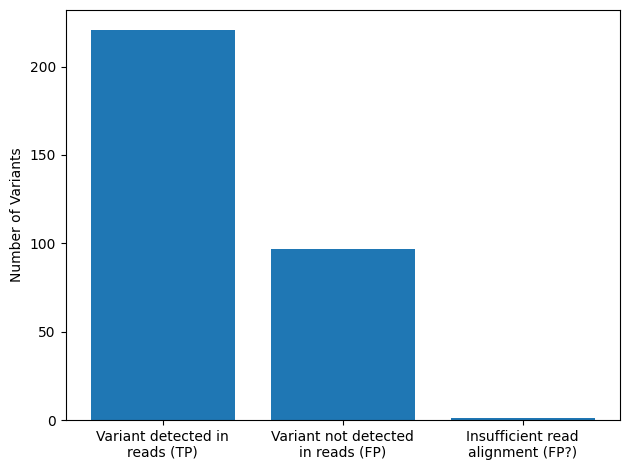

In [16]:
def plot_overall_bar_plot(overall_results, wrap_width = None, out_file=None):
    # Unpack keys and values
    labels = list(overall_results.keys())
    values = list(overall_results.values())

    if wrap_width:
        labels = ['\n'.join(textwrap.wrap(label, wrap_width)) for label in labels]

    # Create bar plot
    plt.bar(labels, values)
    plt.ylabel('Number of Variants')
    plt.tight_layout()
    if out_file:
        plt.savefig(out_file, dpi=300)
    plt.show()
    plt.close()

overall_results = {
    "Variant detected in reads (TP)": 221,
    "Variant not detected in reads (FP)": 97,
    "Insufficient read alignment (FP?)": 1,
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fp_bar_plot.pdf"))

In [17]:
hgvs_df['true_variant'] = hgvs_df['header_cdna'].isin(set(true_variants))
hgvs_df.loc[hgvs_df['vcrs_id'].isna(), 'true_variant'] = pd.NA  # set the rows I didn't evaluate to NA

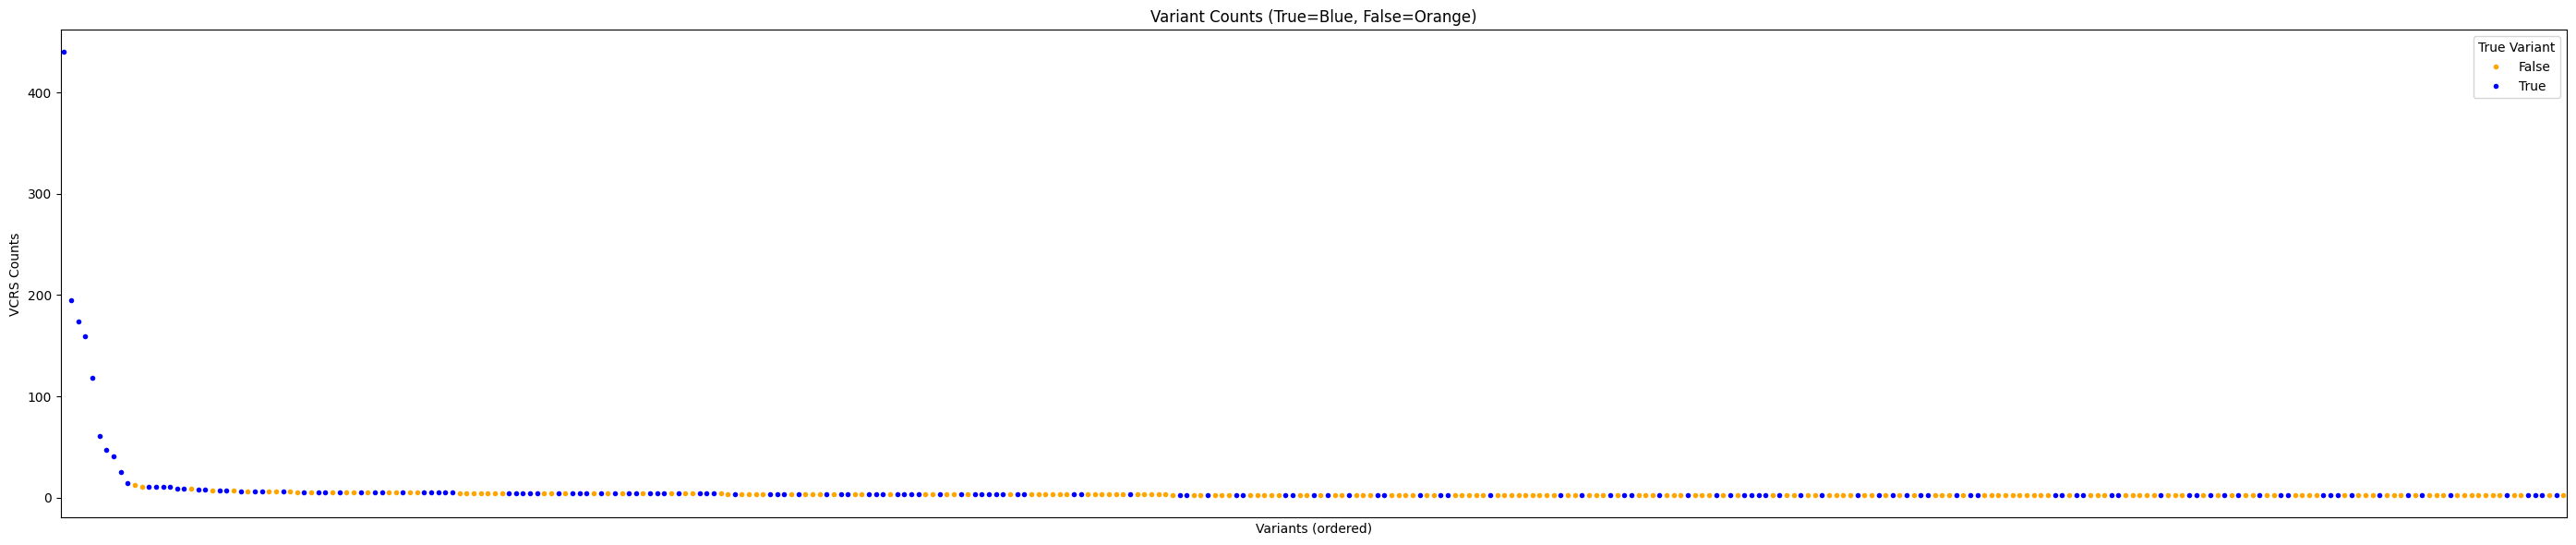

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [18]:
plt.figure(figsize=(28, 6))

# Sort by vcrs_count
# hgvs_df = hgvs_df.sort_values('vcrs_count', ascending=False)

sns.stripplot(
    data=hgvs_df,
    x='header_cdna',
    y='vcrs_count',
    hue='true_variant',
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4  # spread points slightly to reduce overlap
)

plt.xticks([], [])  # Hide x-axis ticks entirely
plt.xlabel('Variants (ordered)')
plt.ylabel('VCRS Counts')
plt.title('Variant Counts (True=Blue, False=Orange)')
plt.legend(title='True Variant', loc='upper right')
plt.tight_layout()

plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted.pdf"), dpi=300)
plt.show()
plt.close

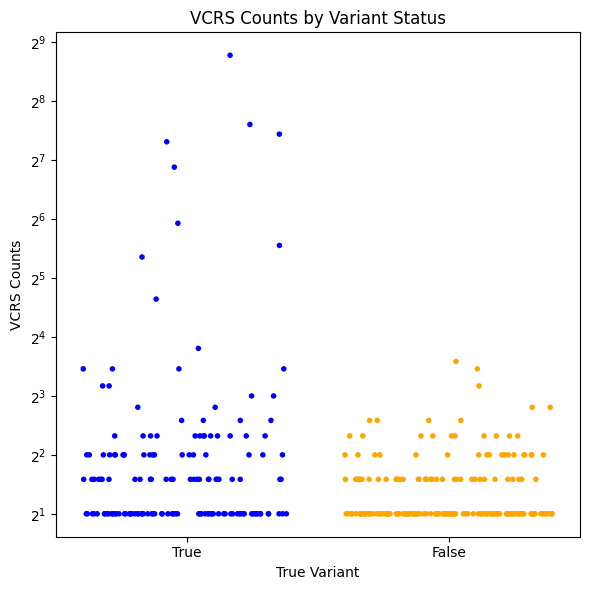

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6))

# # Violin plot
# hgvs_df['true_variant_str'] = hgvs_df['true_variant'].astype(str)
# sns.violinplot(
#     data=hgvs_df,
#     x='true_variant_str',
#     y='vcrs_count',
#     palette={'True': "blue", 'False': "orange"},
#     width=0.5,
#     cut=0,  # Prevent tails from extending beyond data range
#     inner=None,  # Hide inner boxplot/sticks (optional)
#     scale='width'  # Makes area consistent
# )

# for violin in ax.collections:
#     violin.set_facecolor("lightgray")
#     violin.set_edgecolor("black")  # Optional: add black edge
#     violin.set_alpha(1)  # Optional: control transparency

# Strip plot on top
sns.stripplot(
    data=hgvs_df,
    x='true_variant',
    y='vcrs_count',
    hue='true_variant',
    order=[True, False],  # Enforce order
    hue_order=[True, False],  # Enforce order
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4
)

# Clean up
plt.xlabel('True Variant')
plt.ylabel('VCRS Counts')
plt.yscale("log", base=2)  # Apply log2 scaling
plt.title('VCRS Counts by Variant Status')
plt.legend([], [], frameon=False)  # Hide duplicate legend
plt.tight_layout()
plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted_stacked.pdf"), dpi=300)
plt.show()
plt.close()

Get the set of especially tricky gene names and save them to a file:

In [20]:
extra_tricky_fp_threshold = 6

enst_list = []
with open(detailed_txt_out, "r") as f:
    lines = f.readlines()

for i in range(len(lines) - 1):  # stop at len-1 to access next line safely
    line = lines[i].strip()
    next_line = lines[i + 1].strip()

    if not line.startswith("vcrs"):
        continue

    try:
        # Extract the reported count value (assumes '... | ... | ... | ... | ... | xxx reported counts')
        count_str = line.split("|")[-1].strip()
        count_value = float(count_str.split()[0])
    except Exception:
        continue  # skip lines that don't match format

    if count_value < extra_tricky_fp_threshold:
        break

    if next_line == "True variant: False":
        enst_field = line.split("|")[2].strip()
        enst_id = enst_field.split(":")[0]
        enst_list.append(enst_id)

t2g_dict = vk.utils.make_t2g_dict(reference_genome_t2g)
t2g_dict = {key.split(".")[0]: val.split(".")[0] for key, val in t2g_dict.items()}  # strip off the version number
extra_tricky_fp_genes = [t2g_dict.get(enst, enst) for enst in enst_list]
extra_tricky_fp_genes = set(extra_tricky_fp_genes)  # remove duplicates
extra_tricky_fp_genes_txt_out = os.path.join(notebook_out_dir, "extra_tricky_fp_genes.txt")
with open(extra_tricky_fp_genes_txt_out, "w") as f:
    for gene in extra_tricky_fp_genes:
        f.write(f"{gene}\n")

print(f"Extra tricky FP genes: {extra_tricky_fp_genes}")

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2277: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


Extra tricky FP genes: {'ENSG00000108107', 'ENSG00000174748', 'ENSG00000177954', 'ENSG00000096384', 'ENSG00000137154', 'ENST00000604930', 'ENSG00000211625', 'ENSG00000168028'}


### Load the files in bowtie_read_alignments into NCBI Genome workbench (or another genome viewer) to visualize the alignments (the ones with "final_")

In [21]:
# # vcrs0: ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
# !samtools mpileup -r 2:89246969-89246969 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_0/final_vcrs_0_sorted_reads.bam

In [22]:
# # vcrs1: ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
# !samtools mpileup -r 12:49522578-49522578 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_1/final_vcrs_1_sorted_reads.bam

In [23]:
# # vcrs3: ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.22759034G>A chrom22
# !samtools mpileup -r 22:23101523-23101523 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_3/final_vcrs_3_sorted_reads.bam

In [24]:
# # vcrs4: ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6
# !samtools mpileup -r 6:29912149-29912149 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_4/final_vcrs_4_sorted_reads.bam

## Now look at FNs - roughly the same

In [25]:
fn_txt_path = os.path.join(RLSRWP_2025_dir, "data", f"geuvadis_analysis_supplement", experiment_alias, "fns.txt")
number_of_variants = None

detailed_txt_out_fn = os.path.join(notebook_out_dir, "detailed_out_fn_modified_bam.txt")
overall_txt_out_fn = os.path.join(notebook_out_dir, "overall_out_fn_modified_bam.txt")

In [26]:
with open(fn_txt_path) as f:
    fn_set = set(line.strip() for line in f)

In [27]:
hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df["is_false_negative"] = hgvs_df["header_cdna"].isin(fn_set)
hgvs_df = hgvs_df.loc[hgvs_df['is_false_negative']]
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [28]:
hgvs_df.head()

dbsnp_id    transcript_ID variant_cdna strand                header_cdna  \
0   rs3829740  ENST00000379407    c.1385G>C      +  ENST00000379407:c.1385G>C   
1  rs28548431  ENST00000379407    c.1566C>T      +  ENST00000379407:c.1566C>T   
2  rs13306651  ENST00000325425    c.1762G>A      +  ENST00000325425:c.1762G>A   
3   rs7418389  ENST00000355826     c.253T>C      +   ENST00000355826:c.253T>C   
4  rs35804144  ENST00000307786     c.661C>T      +   ENST00000307786:c.661C>T   

   is_false_negative vcrs_id  
0               True  vcrs_0  
1               True  vcrs_1  
2               True  vcrs_2  
3               True  vcrs_3  
4               True  vcrs_4

In [29]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FN where varseek was incorrect
false_variants = []  # varseek FN where varseek was correct
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out_fn, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        dbsnp_id = row['dbsnp_id']
        hgvsc = row['header_cdna']
        strand = row['strand']
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = row['transcript_ID']
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out_fn) else "w"
        with open(detailed_txt_out_fn, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} \n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out_fn, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

11:54:14: Entering the loop



  0%|                                                                                                                                                                                 | 0/3308 [00:00<?, ?it/s]


  0%|                                                                                                                                                                         | 1/3308 [00:01<59:49,  1.09s/it]


  0%|                                                                                                                                                                         | 2/3308 [00:01<43:32,  1.27it/s]


  0%|▏                                                                                                                                                                        | 3/3308 [00:02<39:22,  1.40it/s]


  0%|▏                                                                                                                                                                      | 4/3308 [00:04<1:01:24,  1.12s/it]


  0%|▎                                                                                                                                                                        | 5/3308 [00:04<51:37,  1.07it/s]


  0%|▎                                                                                                                                                                        | 6/3308 [00:05<44:50,  1.23it/s]


  0%|▎                                                                                                                                                                        | 7/3308 [00:05<40:39,  1.35it/s]


  0%|▍                                                                                                                                                                        | 8/3308 [00:06<38:46,  1.42it/s]


  0%|▍                                                                                                                                                                        | 9/3308 [00:07<36:30,  1.51it/s]


  0%|▌                                                                                                                                                                       | 10/3308 [00:07<35:11,  1.56it/s]


  0%|▌                                                                                                                                                                       | 11/3308 [00:08<34:02,  1.61it/s]


  0%|▌                                                                                                                                                                       | 12/3308 [00:08<33:13,  1.65it/s]


  0%|▋                                                                                                                                                                       | 13/3308 [00:09<33:14,  1.65it/s]


  0%|▋                                                                                                                                                                       | 14/3308 [00:09<32:53,  1.67it/s]


  0%|▊                                                                                                                                                                       | 15/3308 [00:10<32:10,  1.71it/s]


  0%|▊                                                                                                                                                                       | 16/3308 [00:11<31:51,  1.72it/s]


  1%|▊                                                                                                                                                                       | 17/3308 [00:11<32:09,  1.71it/s]


  1%|▉                                                                                                                                                                       | 18/3308 [00:12<32:44,  1.67it/s]


  1%|▉                                                                                                                                                                       | 19/3308 [00:12<32:28,  1.69it/s]


  1%|█                                                                                                                                                                       | 20/3308 [00:13<31:56,  1.72it/s]


  1%|█                                                                                                                                                                       | 21/3308 [00:14<32:23,  1.69it/s]


  1%|█                                                                                                                                                                       | 22/3308 [00:14<32:15,  1.70it/s]


  1%|█▏                                                                                                                                                                      | 23/3308 [00:15<31:50,  1.72it/s]


  1%|█▏                                                                                                                                                                      | 24/3308 [00:15<31:37,  1.73it/s]


  1%|█▎                                                                                                                                                                      | 25/3308 [00:16<31:29,  1.74it/s]


  1%|█▎                                                                                                                                                                      | 26/3308 [00:16<32:32,  1.68it/s]


  1%|█▎                                                                                                                                                                      | 27/3308 [00:17<32:08,  1.70it/s]


  1%|█▍                                                                                                                                                                      | 28/3308 [00:18<32:21,  1.69it/s]


  1%|█▍                                                                                                                                                                      | 29/3308 [00:18<32:17,  1.69it/s]


  1%|█▌                                                                                                                                                                      | 30/3308 [00:19<31:54,  1.71it/s]


  1%|█▌                                                                                                                                                                      | 31/3308 [00:19<31:40,  1.72it/s]


  1%|█▋                                                                                                                                                                      | 32/3308 [00:20<31:30,  1.73it/s]


  1%|█▋                                                                                                                                                                      | 33/3308 [00:20<31:20,  1.74it/s]


  1%|█▋                                                                                                                                                                      | 34/3308 [00:21<31:17,  1.74it/s]


  1%|█▊                                                                                                                                                                      | 35/3308 [00:22<31:13,  1.75it/s]


  1%|█▊                                                                                                                                                                      | 36/3308 [00:22<31:37,  1.72it/s]


  1%|█▉                                                                                                                                                                      | 37/3308 [00:23<32:09,  1.69it/s]


  1%|█▉                                                                                                                                                                      | 38/3308 [00:24<35:22,  1.54it/s]


  1%|█▉                                                                                                                                                                      | 39/3308 [00:24<34:21,  1.59it/s]


  1%|██                                                                                                                                                                      | 40/3308 [00:25<33:28,  1.63it/s]


  1%|██                                                                                                                                                                      | 41/3308 [00:25<33:33,  1.62it/s]


  1%|██▏                                                                                                                                                                     | 42/3308 [00:26<32:42,  1.66it/s]


  1%|██▏                                                                                                                                                                     | 43/3308 [00:27<32:05,  1.70it/s]


  1%|██▏                                                                                                                                                                     | 44/3308 [00:27<31:43,  1.71it/s]


  1%|██▎                                                                                                                                                                     | 45/3308 [00:28<31:38,  1.72it/s]


  1%|██▎                                                                                                                                                                     | 46/3308 [00:28<31:08,  1.75it/s]


  1%|██▍                                                                                                                                                                     | 47/3308 [00:29<38:32,  1.41it/s]


  1%|██▍                                                                                                                                                                     | 48/3308 [00:30<40:33,  1.34it/s]


  1%|██▍                                                                                                                                                                     | 49/3308 [00:31<37:48,  1.44it/s]


  2%|██▌                                                                                                                                                                     | 50/3308 [00:31<35:44,  1.52it/s]


  2%|██▌                                                                                                                                                                     | 51/3308 [00:32<34:03,  1.59it/s]


  2%|██▋                                                                                                                                                                     | 52/3308 [00:32<33:04,  1.64it/s]


  2%|██▋                                                                                                                                                                     | 53/3308 [00:33<32:45,  1.66it/s]


  2%|██▋                                                                                                                                                                     | 54/3308 [00:34<32:21,  1.68it/s]


  2%|██▊                                                                                                                                                                     | 55/3308 [00:34<31:59,  1.69it/s]


  2%|██▊                                                                                                                                                                     | 56/3308 [00:35<32:11,  1.68it/s]


  2%|██▉                                                                                                                                                                     | 57/3308 [00:35<31:32,  1.72it/s]


  2%|██▉                                                                                                                                                                     | 58/3308 [00:36<34:19,  1.58it/s]


  2%|██▉                                                                                                                                                                     | 59/3308 [00:37<33:05,  1.64it/s]


  2%|███                                                                                                                                                                     | 60/3308 [00:37<32:18,  1.68it/s]


  2%|███                                                                                                                                                                     | 61/3308 [00:38<31:39,  1.71it/s]


  2%|███▏                                                                                                                                                                    | 62/3308 [00:38<31:29,  1.72it/s]


  2%|███▏                                                                                                                                                                    | 63/3308 [00:39<31:51,  1.70it/s]


  2%|███▎                                                                                                                                                                    | 64/3308 [00:39<31:08,  1.74it/s]


  2%|███▎                                                                                                                                                                    | 65/3308 [00:40<30:36,  1.77it/s]


  2%|███▎                                                                                                                                                                    | 66/3308 [00:41<33:14,  1.63it/s]


  2%|███▍                                                                                                                                                                    | 67/3308 [00:41<32:06,  1.68it/s]


  2%|███▍                                                                                                                                                                    | 68/3308 [00:42<32:41,  1.65it/s]


  2%|███▌                                                                                                                                                                    | 69/3308 [00:42<32:05,  1.68it/s]


  2%|███▌                                                                                                                                                                    | 70/3308 [00:43<31:24,  1.72it/s]


  2%|███▌                                                                                                                                                                    | 71/3308 [00:44<30:40,  1.76it/s]


  2%|███▋                                                                                                                                                                    | 72/3308 [00:44<30:35,  1.76it/s]


  2%|███▋                                                                                                                                                                    | 73/3308 [00:45<30:45,  1.75it/s]


  2%|███▊                                                                                                                                                                    | 74/3308 [00:45<30:39,  1.76it/s]


  2%|███▊                                                                                                                                                                    | 75/3308 [00:46<30:12,  1.78it/s]


  2%|███▊                                                                                                                                                                    | 76/3308 [00:46<30:40,  1.76it/s]


  2%|███▉                                                                                                                                                                    | 77/3308 [00:47<31:40,  1.70it/s]


  2%|███▉                                                                                                                                                                    | 78/3308 [00:48<31:15,  1.72it/s]


  2%|████                                                                                                                                                                    | 79/3308 [00:48<31:22,  1.72it/s]


  2%|████                                                                                                                                                                    | 81/3308 [00:49<25:00,  2.15it/s]


  2%|████▏                                                                                                                                                                   | 82/3308 [00:49<26:23,  2.04it/s]


  3%|████▏                                                                                                                                                                   | 83/3308 [00:50<28:19,  1.90it/s]


  3%|████▎                                                                                                                                                                   | 84/3308 [00:51<29:15,  1.84it/s]


  3%|████▎                                                                                                                                                                   | 85/3308 [00:51<29:36,  1.81it/s]


  3%|████▎                                                                                                                                                                   | 86/3308 [00:52<29:35,  1.81it/s]


  3%|████▍                                                                                                                                                                   | 87/3308 [00:52<30:07,  1.78it/s]


  3%|████▍                                                                                                                                                                   | 88/3308 [00:53<30:04,  1.78it/s]


  3%|████▌                                                                                                                                                                   | 89/3308 [00:53<30:09,  1.78it/s]


  3%|████▌                                                                                                                                                                   | 90/3308 [00:54<30:49,  1.74it/s]


  3%|████▌                                                                                                                                                                   | 91/3308 [00:55<30:40,  1.75it/s]


  3%|████▋                                                                                                                                                                   | 92/3308 [00:55<30:33,  1.75it/s]


  3%|████▋                                                                                                                                                                   | 93/3308 [00:56<30:30,  1.76it/s]


  3%|████▊                                                                                                                                                                   | 94/3308 [00:57<41:28,  1.29it/s]


  3%|████▉                                                                                                                                                                   | 96/3308 [00:58<29:47,  1.80it/s]


  3%|████▉                                                                                                                                                                   | 97/3308 [00:58<29:55,  1.79it/s]


  3%|████▉                                                                                                                                                                   | 98/3308 [00:59<30:54,  1.73it/s]


  3%|█████                                                                                                                                                                   | 99/3308 [00:59<31:59,  1.67it/s]


  3%|█████                                                                                                                                                                  | 100/3308 [01:00<32:16,  1.66it/s]


  3%|█████                                                                                                                                                                  | 101/3308 [01:01<32:48,  1.63it/s]


  3%|█████▏                                                                                                                                                                 | 102/3308 [01:01<32:02,  1.67it/s]


  3%|█████▏                                                                                                                                                                 | 103/3308 [01:02<31:30,  1.70it/s]


  3%|█████▎                                                                                                                                                                 | 104/3308 [01:02<31:03,  1.72it/s]


  3%|█████▎                                                                                                                                                                 | 105/3308 [01:03<30:52,  1.73it/s]


  3%|█████▎                                                                                                                                                                 | 106/3308 [01:04<30:40,  1.74it/s]


  3%|█████▍                                                                                                                                                                 | 107/3308 [01:04<30:26,  1.75it/s]


  3%|█████▍                                                                                                                                                                 | 108/3308 [01:05<30:24,  1.75it/s]


  3%|█████▌                                                                                                                                                                 | 109/3308 [01:05<30:22,  1.76it/s]


  3%|█████▌                                                                                                                                                                 | 110/3308 [01:06<30:28,  1.75it/s]


  3%|█████▌                                                                                                                                                                 | 111/3308 [01:06<30:21,  1.76it/s]


  3%|█████▋                                                                                                                                                                 | 112/3308 [01:07<30:14,  1.76it/s]


  3%|█████▋                                                                                                                                                                 | 113/3308 [01:08<30:12,  1.76it/s]


  3%|█████▊                                                                                                                                                                 | 114/3308 [01:08<30:12,  1.76it/s]


  3%|█████▊                                                                                                                                                                 | 115/3308 [01:09<30:02,  1.77it/s]


  4%|█████▊                                                                                                                                                                 | 116/3308 [01:09<30:05,  1.77it/s]


  4%|█████▉                                                                                                                                                                 | 117/3308 [01:10<30:08,  1.76it/s]


  4%|█████▉                                                                                                                                                                 | 118/3308 [01:10<30:09,  1.76it/s]


  4%|██████                                                                                                                                                                 | 119/3308 [01:11<30:11,  1.76it/s]


  4%|██████                                                                                                                                                                 | 120/3308 [01:12<30:40,  1.73it/s]


  4%|██████▏                                                                                                                                                                | 122/3308 [01:12<23:54,  2.22it/s]


  4%|██████▏                                                                                                                                                                | 123/3308 [01:13<25:57,  2.04it/s]


  4%|██████▎                                                                                                                                                                | 124/3308 [01:13<27:09,  1.95it/s]


  4%|██████▎                                                                                                                                                                | 125/3308 [01:14<27:59,  1.90it/s]


  4%|██████▎                                                                                                                                                                | 126/3308 [01:14<28:52,  1.84it/s]


  4%|██████▍                                                                                                                                                                | 127/3308 [01:15<29:13,  1.81it/s]


  4%|██████▍                                                                                                                                                                | 128/3308 [01:16<29:23,  1.80it/s]


  4%|██████▌                                                                                                                                                                | 129/3308 [01:16<30:24,  1.74it/s]


  4%|██████▌                                                                                                                                                                | 130/3308 [01:17<30:21,  1.74it/s]


  4%|██████▌                                                                                                                                                                | 131/3308 [01:18<33:57,  1.56it/s]


  4%|██████▋                                                                                                                                                                | 132/3308 [01:18<33:07,  1.60it/s]


  4%|██████▋                                                                                                                                                                | 133/3308 [01:19<32:15,  1.64it/s]


  4%|██████▊                                                                                                                                                                | 134/3308 [01:19<31:37,  1.67it/s]


  4%|██████▊                                                                                                                                                                | 135/3308 [01:20<31:07,  1.70it/s]


  4%|██████▊                                                                                                                                                                | 136/3308 [01:21<31:39,  1.67it/s]


  4%|██████▉                                                                                                                                                                | 137/3308 [01:21<32:16,  1.64it/s]


  4%|██████▉                                                                                                                                                                | 138/3308 [01:22<32:31,  1.62it/s]


  4%|███████                                                                                                                                                                | 139/3308 [01:22<31:47,  1.66it/s]


  4%|███████                                                                                                                                                                | 141/3308 [01:23<24:38,  2.14it/s]


  4%|███████▏                                                                                                                                                               | 142/3308 [01:24<25:51,  2.04it/s]


  4%|███████▏                                                                                                                                                               | 143/3308 [01:24<27:34,  1.91it/s]


  4%|███████▎                                                                                                                                                               | 144/3308 [01:25<29:21,  1.80it/s]


  4%|███████▎                                                                                                                                                               | 145/3308 [01:25<29:30,  1.79it/s]


  4%|███████▎                                                                                                                                                               | 146/3308 [01:26<29:36,  1.78it/s]


  4%|███████▍                                                                                                                                                               | 147/3308 [01:26<29:41,  1.77it/s]


  4%|███████▍                                                                                                                                                               | 148/3308 [01:27<30:52,  1.71it/s]


  5%|███████▌                                                                                                                                                               | 149/3308 [01:28<31:08,  1.69it/s]


  5%|███████▌                                                                                                                                                               | 150/3308 [01:28<31:33,  1.67it/s]


  5%|███████▌                                                                                                                                                               | 151/3308 [01:29<34:14,  1.54it/s]


  5%|███████▋                                                                                                                                                               | 152/3308 [01:30<44:41,  1.18it/s]


  5%|███████▋                                                                                                                                                               | 153/3308 [01:32<51:27,  1.02it/s]


  5%|███████▊                                                                                                                                                               | 154/3308 [01:33<56:39,  1.08s/it]


  5%|███████▊                                                                                                                                                               | 155/3308 [01:34<58:24,  1.11s/it]


  5%|███████▊                                                                                                                                                             | 156/3308 [01:36<1:05:05,  1.24s/it]


  5%|███████▊                                                                                                                                                             | 157/3308 [01:37<1:05:19,  1.24s/it]


  5%|███████▉                                                                                                                                                             | 158/3308 [01:38<1:06:04,  1.26s/it]


  5%|███████▉                                                                                                                                                             | 159/3308 [01:39<1:04:25,  1.23s/it]


  5%|███████▉                                                                                                                                                             | 160/3308 [01:41<1:03:23,  1.21s/it]


  5%|████████                                                                                                                                                             | 161/3308 [01:42<1:03:06,  1.20s/it]


  5%|████████                                                                                                                                                             | 162/3308 [01:43<1:03:54,  1.22s/it]


  5%|████████▏                                                                                                                                                              | 163/3308 [01:44<53:39,  1.02s/it]


  5%|████████▎                                                                                                                                                              | 164/3308 [01:44<46:39,  1.12it/s]


  5%|████████▍                                                                                                                                                              | 166/3308 [01:45<31:57,  1.64it/s]


  5%|████████▍                                                                                                                                                              | 167/3308 [01:46<33:42,  1.55it/s]


  5%|████████▍                                                                                                                                                              | 168/3308 [01:46<32:49,  1.59it/s]


  5%|████████▌                                                                                                                                                              | 169/3308 [01:47<35:41,  1.47it/s]


  5%|████████▌                                                                                                                                                              | 170/3308 [01:47<33:50,  1.55it/s]


  5%|████████▋                                                                                                                                                              | 171/3308 [01:48<32:33,  1.61it/s]


  5%|████████▋                                                                                                                                                              | 172/3308 [01:49<31:37,  1.65it/s]


  5%|████████▋                                                                                                                                                              | 173/3308 [01:49<31:29,  1.66it/s]


  5%|████████▊                                                                                                                                                              | 174/3308 [01:50<31:24,  1.66it/s]


  5%|████████▊                                                                                                                                                              | 175/3308 [01:50<30:46,  1.70it/s]


  5%|████████▉                                                                                                                                                              | 176/3308 [01:51<30:22,  1.72it/s]


  5%|████████▉                                                                                                                                                              | 177/3308 [01:52<30:05,  1.73it/s]


  5%|████████▉                                                                                                                                                              | 178/3308 [01:52<30:21,  1.72it/s]


  5%|█████████                                                                                                                                                              | 179/3308 [01:53<30:08,  1.73it/s]


  5%|█████████                                                                                                                                                              | 180/3308 [01:53<29:57,  1.74it/s]


  5%|█████████▏                                                                                                                                                             | 181/3308 [01:54<29:56,  1.74it/s]


  6%|█████████▏                                                                                                                                                             | 182/3308 [01:54<31:03,  1.68it/s]


  6%|█████████▏                                                                                                                                                             | 183/3308 [01:55<30:55,  1.68it/s]


  6%|█████████▎                                                                                                                                                             | 184/3308 [01:56<30:33,  1.70it/s]


  6%|█████████▎                                                                                                                                                             | 185/3308 [01:56<30:18,  1.72it/s]


  6%|█████████▍                                                                                                                                                             | 186/3308 [01:57<31:16,  1.66it/s]


  6%|█████████▍                                                                                                                                                             | 187/3308 [01:58<33:01,  1.58it/s]


  6%|█████████▌                                                                                                                                                             | 189/3308 [01:58<25:11,  2.06it/s]


  6%|█████████▌                                                                                                                                                             | 190/3308 [01:59<26:18,  1.98it/s]


  6%|█████████▋                                                                                                                                                             | 191/3308 [01:59<27:09,  1.91it/s]


  6%|█████████▋                                                                                                                                                             | 192/3308 [02:00<28:35,  1.82it/s]


  6%|█████████▋                                                                                                                                                             | 193/3308 [02:00<28:48,  1.80it/s]


  6%|█████████▊                                                                                                                                                             | 194/3308 [02:01<28:57,  1.79it/s]


  6%|█████████▊                                                                                                                                                             | 195/3308 [02:02<29:26,  1.76it/s]


  6%|█████████▉                                                                                                                                                             | 196/3308 [02:02<29:27,  1.76it/s]


  6%|█████████▉                                                                                                                                                             | 197/3308 [02:03<29:28,  1.76it/s]


  6%|█████████▉                                                                                                                                                             | 198/3308 [02:03<29:30,  1.76it/s]


  6%|██████████                                                                                                                                                             | 199/3308 [02:04<29:32,  1.75it/s]


  6%|██████████                                                                                                                                                             | 200/3308 [02:05<29:31,  1.75it/s]


  6%|██████████▏                                                                                                                                                            | 201/3308 [02:05<29:29,  1.76it/s]


  6%|██████████▏                                                                                                                                                            | 202/3308 [02:06<29:45,  1.74it/s]


  6%|██████████▏                                                                                                                                                            | 203/3308 [02:06<31:10,  1.66it/s]


  6%|██████████▎                                                                                                                                                            | 204/3308 [02:07<30:36,  1.69it/s]


  6%|██████████▎                                                                                                                                                            | 205/3308 [02:07<30:12,  1.71it/s]


  6%|██████████▍                                                                                                                                                            | 206/3308 [02:08<29:56,  1.73it/s]


  6%|██████████▍                                                                                                                                                            | 207/3308 [02:09<29:51,  1.73it/s]


  6%|██████████▌                                                                                                                                                            | 208/3308 [02:09<29:44,  1.74it/s]


  6%|██████████▌                                                                                                                                                            | 209/3308 [02:10<30:36,  1.69it/s]


  6%|██████████▌                                                                                                                                                            | 210/3308 [02:10<31:25,  1.64it/s]


  6%|██████████▋                                                                                                                                                            | 211/3308 [02:11<30:52,  1.67it/s]


  6%|██████████▋                                                                                                                                                            | 212/3308 [02:12<30:24,  1.70it/s]


  6%|██████████▊                                                                                                                                                            | 213/3308 [02:12<30:42,  1.68it/s]


  6%|██████████▊                                                                                                                                                            | 214/3308 [02:13<30:31,  1.69it/s]


  7%|██████████▉                                                                                                                                                            | 216/3308 [02:13<23:10,  2.22it/s]


  7%|██████████▉                                                                                                                                                            | 217/3308 [02:14<24:36,  2.09it/s]


  7%|███████████                                                                                                                                                            | 218/3308 [02:14<25:43,  2.00it/s]


  7%|███████████                                                                                                                                                            | 219/3308 [02:15<26:35,  1.94it/s]


  7%|███████████                                                                                                                                                            | 220/3308 [02:16<27:15,  1.89it/s]


  7%|███████████▏                                                                                                                                                           | 221/3308 [02:16<27:50,  1.85it/s]


  7%|███████████▏                                                                                                                                                           | 222/3308 [02:17<28:08,  1.83it/s]


  7%|███████████▎                                                                                                                                                           | 223/3308 [02:17<28:18,  1.82it/s]


  7%|███████████▎                                                                                                                                                           | 224/3308 [02:18<28:44,  1.79it/s]


  7%|███████████▎                                                                                                                                                           | 225/3308 [02:18<28:59,  1.77it/s]


  7%|███████████▍                                                                                                                                                           | 226/3308 [02:19<30:08,  1.70it/s]


  7%|███████████▍                                                                                                                                                           | 227/3308 [02:20<29:50,  1.72it/s]


  7%|███████████▌                                                                                                                                                           | 228/3308 [02:20<29:36,  1.73it/s]


  7%|███████████▌                                                                                                                                                           | 229/3308 [02:21<29:42,  1.73it/s]


  7%|███████████▌                                                                                                                                                           | 230/3308 [02:21<30:42,  1.67it/s]


  7%|███████████▋                                                                                                                                                           | 231/3308 [02:22<30:10,  1.70it/s]


  7%|███████████▋                                                                                                                                                           | 232/3308 [02:23<32:22,  1.58it/s]


  7%|███████████▊                                                                                                                                                           | 234/3308 [02:23<24:36,  2.08it/s]


  7%|███████████▊                                                                                                                                                           | 235/3308 [02:24<26:51,  1.91it/s]


  7%|███████████▉                                                                                                                                                           | 236/3308 [02:25<27:27,  1.86it/s]


  7%|███████████▉                                                                                                                                                           | 237/3308 [02:25<27:51,  1.84it/s]


  7%|████████████                                                                                                                                                           | 238/3308 [02:26<28:13,  1.81it/s]


  7%|████████████                                                                                                                                                           | 239/3308 [02:26<28:36,  1.79it/s]


  7%|████████████▏                                                                                                                                                          | 241/3308 [02:27<22:18,  2.29it/s]


  7%|████████████▏                                                                                                                                                          | 242/3308 [02:27<23:49,  2.15it/s]


  7%|████████████▎                                                                                                                                                          | 243/3308 [02:28<25:50,  1.98it/s]


  7%|████████████▎                                                                                                                                                          | 244/3308 [02:29<27:40,  1.84it/s]


  7%|████████████▎                                                                                                                                                          | 245/3308 [02:29<28:04,  1.82it/s]


  7%|████████████▍                                                                                                                                                          | 246/3308 [02:30<29:22,  1.74it/s]


  7%|████████████▍                                                                                                                                                          | 247/3308 [02:31<30:28,  1.67it/s]


  7%|████████████▌                                                                                                                                                          | 248/3308 [02:31<30:01,  1.70it/s]


  8%|████████████▌                                                                                                                                                          | 249/3308 [02:32<29:47,  1.71it/s]


  8%|████████████▌                                                                                                                                                          | 250/3308 [02:32<29:27,  1.73it/s]


  8%|████████████▋                                                                                                                                                          | 251/3308 [02:33<29:44,  1.71it/s]


  8%|████████████▋                                                                                                                                                          | 252/3308 [02:33<29:30,  1.73it/s]


  8%|████████████▊                                                                                                                                                          | 253/3308 [02:34<29:18,  1.74it/s]


  8%|████████████▊                                                                                                                                                          | 254/3308 [02:35<29:09,  1.75it/s]


  8%|████████████▊                                                                                                                                                          | 255/3308 [02:35<29:06,  1.75it/s]


  8%|████████████▉                                                                                                                                                          | 256/3308 [02:36<29:10,  1.74it/s]


  8%|████████████▉                                                                                                                                                          | 257/3308 [02:36<30:25,  1.67it/s]


  8%|█████████████                                                                                                                                                          | 258/3308 [02:37<29:58,  1.70it/s]


  8%|█████████████                                                                                                                                                          | 259/3308 [02:38<30:12,  1.68it/s]


  8%|█████████████▏                                                                                                                                                         | 260/3308 [02:38<30:20,  1.67it/s]


  8%|█████████████▏                                                                                                                                                         | 261/3308 [02:39<29:44,  1.71it/s]


  8%|█████████████▏                                                                                                                                                         | 262/3308 [02:39<29:26,  1.72it/s]


  8%|█████████████▎                                                                                                                                                         | 263/3308 [02:40<29:17,  1.73it/s]


  8%|█████████████▎                                                                                                                                                         | 264/3308 [02:40<29:10,  1.74it/s]


  8%|█████████████▍                                                                                                                                                         | 265/3308 [02:41<28:58,  1.75it/s]


  8%|█████████████▍                                                                                                                                                         | 266/3308 [02:42<29:00,  1.75it/s]


  8%|█████████████▍                                                                                                                                                         | 267/3308 [02:42<29:05,  1.74it/s]


  8%|█████████████▌                                                                                                                                                         | 268/3308 [02:43<29:01,  1.75it/s]


  8%|█████████████▌                                                                                                                                                         | 269/3308 [02:43<29:42,  1.71it/s]


  8%|█████████████▋                                                                                                                                                         | 270/3308 [02:44<30:17,  1.67it/s]


  8%|█████████████▋                                                                                                                                                         | 271/3308 [02:45<30:25,  1.66it/s]


  8%|█████████████▋                                                                                                                                                         | 272/3308 [02:45<30:04,  1.68it/s]


  8%|█████████████▊                                                                                                                                                         | 273/3308 [02:46<29:53,  1.69it/s]


  8%|█████████████▊                                                                                                                                                         | 274/3308 [02:46<30:05,  1.68it/s]


  8%|█████████████▉                                                                                                                                                         | 275/3308 [02:47<29:38,  1.71it/s]


  8%|█████████████▉                                                                                                                                                         | 276/3308 [02:48<30:38,  1.65it/s]


  8%|█████████████▉                                                                                                                                                         | 277/3308 [02:48<29:58,  1.69it/s]


  8%|██████████████                                                                                                                                                         | 278/3308 [02:49<29:34,  1.71it/s]


  8%|██████████████                                                                                                                                                         | 279/3308 [02:49<29:09,  1.73it/s]


  8%|██████████████▏                                                                                                                                                        | 280/3308 [02:50<29:04,  1.74it/s]


  8%|██████████████▏                                                                                                                                                        | 281/3308 [02:50<28:58,  1.74it/s]


  9%|██████████████▏                                                                                                                                                        | 282/3308 [02:51<28:57,  1.74it/s]


  9%|██████████████▎                                                                                                                                                        | 283/3308 [02:52<38:36,  1.31it/s]


  9%|██████████████▎                                                                                                                                                        | 284/3308 [02:53<36:10,  1.39it/s]


  9%|██████████████▍                                                                                                                                                        | 285/3308 [02:53<33:56,  1.48it/s]


  9%|██████████████▍                                                                                                                                                        | 286/3308 [02:54<32:27,  1.55it/s]


  9%|██████████████▍                                                                                                                                                        | 287/3308 [02:54<31:19,  1.61it/s]


  9%|██████████████▌                                                                                                                                                        | 288/3308 [02:55<30:45,  1.64it/s]


  9%|██████████████▌                                                                                                                                                        | 289/3308 [02:56<30:07,  1.67it/s]


  9%|██████████████▋                                                                                                                                                        | 290/3308 [02:56<29:38,  1.70it/s]


  9%|██████████████▋                                                                                                                                                        | 291/3308 [02:57<30:13,  1.66it/s]


  9%|██████████████▋                                                                                                                                                        | 292/3308 [02:57<29:40,  1.69it/s]


  9%|██████████████▊                                                                                                                                                        | 293/3308 [02:58<29:18,  1.71it/s]


  9%|██████████████▊                                                                                                                                                        | 294/3308 [02:59<29:08,  1.72it/s]


  9%|██████████████▉                                                                                                                                                        | 295/3308 [02:59<28:55,  1.74it/s]


  9%|██████████████▉                                                                                                                                                        | 296/3308 [03:00<28:51,  1.74it/s]


  9%|██████████████▉                                                                                                                                                        | 297/3308 [03:00<29:09,  1.72it/s]


  9%|███████████████                                                                                                                                                        | 298/3308 [03:01<28:55,  1.73it/s]


  9%|███████████████                                                                                                                                                        | 299/3308 [03:01<28:43,  1.75it/s]


  9%|███████████████▏                                                                                                                                                       | 300/3308 [03:03<39:30,  1.27it/s]


  9%|███████████████▏                                                                                                                                                       | 301/3308 [03:03<36:14,  1.38it/s]


  9%|███████████████▏                                                                                                                                                       | 302/3308 [03:04<34:37,  1.45it/s]


  9%|███████████████▎                                                                                                                                                       | 303/3308 [03:04<32:42,  1.53it/s]


  9%|███████████████▍                                                                                                                                                       | 305/3308 [03:05<24:32,  2.04it/s]


  9%|███████████████▍                                                                                                                                                       | 306/3308 [03:06<25:31,  1.96it/s]


  9%|███████████████▍                                                                                                                                                       | 307/3308 [03:06<26:12,  1.91it/s]


  9%|███████████████▌                                                                                                                                                       | 308/3308 [03:07<26:47,  1.87it/s]


  9%|███████████████▌                                                                                                                                                       | 309/3308 [03:07<27:04,  1.85it/s]


  9%|███████████████▋                                                                                                                                                       | 310/3308 [03:08<27:58,  1.79it/s]


  9%|███████████████▋                                                                                                                                                       | 311/3308 [03:08<28:33,  1.75it/s]


  9%|███████████████▊                                                                                                                                                       | 312/3308 [03:09<29:35,  1.69it/s]


  9%|███████████████▊                                                                                                                                                       | 313/3308 [03:10<30:07,  1.66it/s]


  9%|███████████████▊                                                                                                                                                       | 314/3308 [03:10<30:12,  1.65it/s]


 10%|███████████████▉                                                                                                                                                       | 315/3308 [03:11<30:42,  1.62it/s]


 10%|███████████████▉                                                                                                                                                       | 316/3308 [03:12<30:24,  1.64it/s]


 10%|████████████████                                                                                                                                                       | 317/3308 [03:12<29:44,  1.68it/s]


 10%|████████████████                                                                                                                                                       | 318/3308 [03:13<30:12,  1.65it/s]


 10%|████████████████                                                                                                                                                       | 319/3308 [03:13<29:48,  1.67it/s]


 10%|████████████████▏                                                                                                                                                      | 320/3308 [03:14<29:25,  1.69it/s]


 10%|████████████████▏                                                                                                                                                      | 321/3308 [03:15<29:22,  1.70it/s]


 10%|████████████████▎                                                                                                                                                      | 322/3308 [03:15<29:15,  1.70it/s]


 10%|████████████████▎                                                                                                                                                      | 323/3308 [03:16<29:14,  1.70it/s]


 10%|████████████████▎                                                                                                                                                      | 324/3308 [03:16<28:53,  1.72it/s]


 10%|████████████████▍                                                                                                                                                      | 326/3308 [03:17<22:31,  2.21it/s]


 10%|████████████████▌                                                                                                                                                      | 327/3308 [03:17<23:55,  2.08it/s]


 10%|████████████████▌                                                                                                                                                      | 328/3308 [03:18<25:42,  1.93it/s]


 10%|████████████████▌                                                                                                                                                      | 329/3308 [03:19<26:29,  1.87it/s]


 10%|████████████████▋                                                                                                                                                      | 330/3308 [03:19<26:54,  1.85it/s]


 10%|████████████████▋                                                                                                                                                      | 331/3308 [03:20<27:13,  1.82it/s]


 10%|████████████████▊                                                                                                                                                      | 332/3308 [03:20<27:35,  1.80it/s]


 10%|████████████████▊                                                                                                                                                      | 333/3308 [03:21<27:44,  1.79it/s]


 10%|████████████████▊                                                                                                                                                      | 334/3308 [03:21<27:49,  1.78it/s]


 10%|████████████████▉                                                                                                                                                      | 335/3308 [03:22<27:54,  1.78it/s]


 10%|████████████████▉                                                                                                                                                      | 336/3308 [03:23<27:57,  1.77it/s]


 10%|█████████████████                                                                                                                                                      | 337/3308 [03:23<27:56,  1.77it/s]


 10%|█████████████████                                                                                                                                                      | 338/3308 [03:24<27:42,  1.79it/s]


 10%|█████████████████                                                                                                                                                      | 339/3308 [03:24<27:47,  1.78it/s]


 10%|█████████████████▏                                                                                                                                                     | 340/3308 [03:25<27:57,  1.77it/s]


 10%|█████████████████▏                                                                                                                                                     | 341/3308 [03:25<27:58,  1.77it/s]


 10%|█████████████████▎                                                                                                                                                     | 342/3308 [03:26<27:59,  1.77it/s]


 10%|█████████████████▎                                                                                                                                                     | 343/3308 [03:27<28:00,  1.76it/s]


 10%|█████████████████▎                                                                                                                                                     | 344/3308 [03:27<28:01,  1.76it/s]


 10%|█████████████████▍                                                                                                                                                     | 345/3308 [03:28<28:05,  1.76it/s]


 10%|█████████████████▍                                                                                                                                                     | 346/3308 [03:28<28:06,  1.76it/s]


 10%|█████████████████▌                                                                                                                                                     | 347/3308 [03:29<28:05,  1.76it/s]


 11%|█████████████████▌                                                                                                                                                     | 348/3308 [03:29<28:03,  1.76it/s]


 11%|█████████████████▌                                                                                                                                                     | 349/3308 [03:30<28:08,  1.75it/s]


 11%|█████████████████▋                                                                                                                                                     | 350/3308 [03:31<28:02,  1.76it/s]


 11%|█████████████████▋                                                                                                                                                     | 351/3308 [03:31<28:11,  1.75it/s]


 11%|█████████████████▊                                                                                                                                                     | 353/3308 [03:32<24:00,  2.05it/s]


 11%|█████████████████▊                                                                                                                                                     | 354/3308 [03:33<27:03,  1.82it/s]


 11%|█████████████████▉                                                                                                                                                     | 355/3308 [03:33<27:33,  1.79it/s]


 11%|█████████████████▉                                                                                                                                                     | 356/3308 [03:34<30:08,  1.63it/s]


 11%|██████████████████                                                                                                                                                     | 357/3308 [03:35<32:37,  1.51it/s]


 11%|██████████████████                                                                                                                                                     | 358/3308 [03:36<34:24,  1.43it/s]


 11%|██████████████████                                                                                                                                                     | 359/3308 [03:37<38:23,  1.28it/s]


 11%|██████████████████▏                                                                                                                                                    | 360/3308 [03:37<39:02,  1.26it/s]


 11%|██████████████████▏                                                                                                                                                    | 361/3308 [03:38<36:25,  1.35it/s]


 11%|██████████████████▍                                                                                                                                                    | 364/3308 [03:39<21:14,  2.31it/s]


 11%|██████████████████▍                                                                                                                                                    | 365/3308 [03:39<22:39,  2.16it/s]


 11%|██████████████████▍                                                                                                                                                    | 366/3308 [03:40<26:06,  1.88it/s]


 11%|██████████████████▌                                                                                                                                                    | 367/3308 [03:41<26:57,  1.82it/s]


 11%|██████████████████▌                                                                                                                                                    | 368/3308 [03:41<27:50,  1.76it/s]


 11%|██████████████████▋                                                                                                                                                    | 369/3308 [03:42<28:17,  1.73it/s]


 11%|██████████████████▋                                                                                                                                                    | 370/3308 [03:42<28:10,  1.74it/s]


 11%|██████████████████▋                                                                                                                                                    | 371/3308 [03:43<28:28,  1.72it/s]


 11%|██████████████████▊                                                                                                                                                    | 372/3308 [03:44<35:19,  1.38it/s]


 11%|██████████████████▊                                                                                                                                                    | 373/3308 [03:45<33:07,  1.48it/s]


 11%|██████████████████▉                                                                                                                                                    | 374/3308 [03:45<31:24,  1.56it/s]


 11%|██████████████████▉                                                                                                                                                    | 375/3308 [03:46<30:15,  1.62it/s]


 11%|██████████████████▉                                                                                                                                                    | 376/3308 [03:46<30:07,  1.62it/s]


 11%|███████████████████                                                                                                                                                    | 377/3308 [03:47<29:24,  1.66it/s]


 11%|███████████████████                                                                                                                                                    | 378/3308 [03:47<29:45,  1.64it/s]


 11%|███████████████████▏                                                                                                                                                   | 379/3308 [03:48<29:40,  1.65it/s]


 11%|███████████████████▏                                                                                                                                                   | 380/3308 [03:49<29:17,  1.67it/s]


 12%|███████████████████▏                                                                                                                                                   | 381/3308 [03:49<29:59,  1.63it/s]


 12%|███████████████████▎                                                                                                                                                   | 382/3308 [03:50<30:15,  1.61it/s]


 12%|███████████████████▍                                                                                                                                                   | 384/3308 [03:51<22:40,  2.15it/s]


 12%|███████████████████▍                                                                                                                                                   | 385/3308 [03:51<23:56,  2.03it/s]


 12%|███████████████████▍                                                                                                                                                   | 386/3308 [03:52<25:21,  1.92it/s]


 12%|███████████████████▌                                                                                                                                                   | 387/3308 [03:52<27:50,  1.75it/s]


 12%|███████████████████▌                                                                                                                                                   | 388/3308 [03:53<27:37,  1.76it/s]


 12%|███████████████████▋                                                                                                                                                   | 389/3308 [03:54<27:32,  1.77it/s]


 12%|███████████████████▋                                                                                                                                                   | 390/3308 [03:54<27:28,  1.77it/s]


 12%|███████████████████▋                                                                                                                                                   | 391/3308 [03:55<28:02,  1.73it/s]


 12%|███████████████████▊                                                                                                                                                   | 392/3308 [03:55<27:50,  1.75it/s]


 12%|███████████████████▊                                                                                                                                                   | 393/3308 [03:56<28:20,  1.71it/s]


 12%|███████████████████▉                                                                                                                                                   | 394/3308 [03:56<28:15,  1.72it/s]


 12%|███████████████████▉                                                                                                                                                   | 395/3308 [03:57<28:41,  1.69it/s]


 12%|███████████████████▉                                                                                                                                                   | 396/3308 [03:58<29:18,  1.66it/s]


 12%|████████████████████                                                                                                                                                   | 397/3308 [03:58<29:29,  1.64it/s]


 12%|████████████████████                                                                                                                                                   | 398/3308 [03:59<29:07,  1.66it/s]


 12%|████████████████████▏                                                                                                                                                  | 399/3308 [03:59<28:45,  1.69it/s]


 12%|████████████████████▏                                                                                                                                                  | 400/3308 [04:00<28:36,  1.69it/s]


 12%|████████████████████▏                                                                                                                                                  | 401/3308 [04:01<28:48,  1.68it/s]


 12%|████████████████████▎                                                                                                                                                  | 402/3308 [04:01<28:57,  1.67it/s]


 12%|████████████████████▎                                                                                                                                                  | 403/3308 [04:02<29:36,  1.64it/s]


 12%|████████████████████▍                                                                                                                                                  | 404/3308 [04:03<31:08,  1.55it/s]


 12%|████████████████████▍                                                                                                                                                  | 405/3308 [04:03<30:45,  1.57it/s]


 12%|████████████████████▍                                                                                                                                                  | 406/3308 [04:04<29:43,  1.63it/s]


 12%|████████████████████▌                                                                                                                                                  | 407/3308 [04:04<29:50,  1.62it/s]


 12%|████████████████████▌                                                                                                                                                  | 408/3308 [04:06<38:52,  1.24it/s]


 12%|████████████████████▋                                                                                                                                                  | 409/3308 [04:07<44:56,  1.07it/s]


 12%|████████████████████▋                                                                                                                                                  | 410/3308 [04:08<48:08,  1.00it/s]


 12%|████████████████████▋                                                                                                                                                  | 411/3308 [04:09<50:25,  1.04s/it]


 12%|████████████████████▊                                                                                                                                                  | 412/3308 [04:10<52:15,  1.08s/it]


 12%|████████████████████▊                                                                                                                                                  | 413/3308 [04:11<46:03,  1.05it/s]


 13%|████████████████████▉                                                                                                                                                  | 414/3308 [04:12<40:45,  1.18it/s]


 13%|█████████████████████                                                                                                                                                  | 416/3308 [04:12<28:27,  1.69it/s]


 13%|█████████████████████                                                                                                                                                  | 417/3308 [04:13<28:30,  1.69it/s]


 13%|█████████████████████                                                                                                                                                  | 418/3308 [04:13<28:19,  1.70it/s]


 13%|█████████████████████▏                                                                                                                                                 | 419/3308 [04:14<27:59,  1.72it/s]


 13%|█████████████████████▏                                                                                                                                                 | 420/3308 [04:15<28:40,  1.68it/s]


 13%|█████████████████████▎                                                                                                                                                 | 421/3308 [04:15<28:33,  1.69it/s]


 13%|█████████████████████▎                                                                                                                                                 | 422/3308 [04:16<28:07,  1.71it/s]


 13%|█████████████████████▍                                                                                                                                                 | 424/3308 [04:16<22:10,  2.17it/s]


 13%|█████████████████████▍                                                                                                                                                 | 425/3308 [04:17<24:23,  1.97it/s]


 13%|█████████████████████▌                                                                                                                                                 | 426/3308 [04:18<25:56,  1.85it/s]


 13%|█████████████████████▌                                                                                                                                                 | 427/3308 [04:18<27:22,  1.75it/s]


 13%|█████████████████████▌                                                                                                                                                 | 428/3308 [04:19<27:18,  1.76it/s]


 13%|█████████████████████▋                                                                                                                                                 | 429/3308 [04:19<27:10,  1.77it/s]


 13%|█████████████████████▋                                                                                                                                                 | 430/3308 [04:20<27:46,  1.73it/s]


 13%|█████████████████████▊                                                                                                                                                 | 431/3308 [04:21<27:30,  1.74it/s]


 13%|█████████████████████▊                                                                                                                                                 | 432/3308 [04:21<27:21,  1.75it/s]


 13%|█████████████████████▊                                                                                                                                                 | 433/3308 [04:22<27:49,  1.72it/s]


 13%|█████████████████████▉                                                                                                                                                 | 434/3308 [04:22<28:16,  1.69it/s]


 13%|█████████████████████▉                                                                                                                                                 | 435/3308 [04:23<27:55,  1.72it/s]


 13%|██████████████████████                                                                                                                                                 | 436/3308 [04:24<28:03,  1.71it/s]


 13%|██████████████████████                                                                                                                                                 | 437/3308 [04:24<28:49,  1.66it/s]


 13%|██████████████████████                                                                                                                                                 | 438/3308 [04:25<30:35,  1.56it/s]


 13%|██████████████████████▏                                                                                                                                                | 439/3308 [04:25<29:27,  1.62it/s]


 13%|██████████████████████▏                                                                                                                                                | 440/3308 [04:26<29:16,  1.63it/s]


 13%|██████████████████████▎                                                                                                                                                | 442/3308 [04:27<27:11,  1.76it/s]


 13%|██████████████████████▎                                                                                                                                                | 443/3308 [04:28<27:40,  1.73it/s]


 13%|██████████████████████▍                                                                                                                                                | 444/3308 [04:29<31:20,  1.52it/s]


 13%|██████████████████████▍                                                                                                                                                | 445/3308 [04:29<30:42,  1.55it/s]


 13%|██████████████████████▌                                                                                                                                                | 446/3308 [04:30<30:07,  1.58it/s]


 14%|██████████████████████▌                                                                                                                                                | 447/3308 [04:30<30:10,  1.58it/s]


 14%|██████████████████████▌                                                                                                                                                | 448/3308 [04:31<29:44,  1.60it/s]


 14%|██████████████████████▋                                                                                                                                                | 449/3308 [04:32<28:55,  1.65it/s]


 14%|██████████████████████▋                                                                                                                                                | 450/3308 [04:32<28:19,  1.68it/s]


 14%|██████████████████████▊                                                                                                                                                | 451/3308 [04:33<28:24,  1.68it/s]


 14%|██████████████████████▊                                                                                                                                                | 452/3308 [04:33<27:58,  1.70it/s]


 14%|██████████████████████▉                                                                                                                                                | 454/3308 [04:34<21:42,  2.19it/s]


 14%|██████████████████████▉                                                                                                                                                | 455/3308 [04:35<30:00,  1.58it/s]


 14%|███████████████████████                                                                                                                                                | 456/3308 [04:36<29:32,  1.61it/s]


 14%|███████████████████████                                                                                                                                                | 457/3308 [04:36<31:39,  1.50it/s]


 14%|███████████████████████                                                                                                                                                | 458/3308 [04:37<30:50,  1.54it/s]


 14%|███████████████████████▏                                                                                                                                               | 459/3308 [04:38<30:35,  1.55it/s]


 14%|███████████████████████▏                                                                                                                                               | 460/3308 [04:38<29:26,  1.61it/s]


 14%|███████████████████████▎                                                                                                                                               | 461/3308 [04:39<29:36,  1.60it/s]


 14%|███████████████████████▎                                                                                                                                               | 462/3308 [04:40<38:14,  1.24it/s]


 14%|███████████████████████▎                                                                                                                                               | 463/3308 [04:41<35:46,  1.33it/s]


 14%|███████████████████████▍                                                                                                                                               | 464/3308 [04:41<34:03,  1.39it/s]


 14%|███████████████████████▍                                                                                                                                               | 465/3308 [04:42<32:16,  1.47it/s]


 14%|███████████████████████▌                                                                                                                                               | 466/3308 [04:43<31:14,  1.52it/s]


 14%|███████████████████████▌                                                                                                                                               | 467/3308 [04:43<29:51,  1.59it/s]


 14%|███████████████████████▋                                                                                                                                               | 468/3308 [04:44<29:35,  1.60it/s]


 14%|███████████████████████▋                                                                                                                                               | 469/3308 [04:44<30:14,  1.56it/s]


 14%|███████████████████████▋                                                                                                                                               | 470/3308 [04:45<29:44,  1.59it/s]


 14%|███████████████████████▊                                                                                                                                               | 471/3308 [04:46<28:53,  1.64it/s]


 14%|███████████████████████▊                                                                                                                                               | 472/3308 [04:46<28:12,  1.68it/s]


 14%|███████████████████████▉                                                                                                                                               | 473/3308 [04:47<27:43,  1.70it/s]


 14%|███████████████████████▉                                                                                                                                               | 474/3308 [04:47<27:25,  1.72it/s]


 14%|███████████████████████▉                                                                                                                                               | 475/3308 [04:48<27:40,  1.71it/s]


 14%|████████████████████████                                                                                                                                               | 476/3308 [04:48<27:26,  1.72it/s]


 14%|████████████████████████                                                                                                                                               | 477/3308 [04:49<28:00,  1.68it/s]


 14%|████████████████████████▏                                                                                                                                              | 478/3308 [04:50<28:20,  1.66it/s]


 14%|████████████████████████▏                                                                                                                                              | 479/3308 [04:50<28:21,  1.66it/s]


 15%|████████████████████████▏                                                                                                                                              | 480/3308 [04:51<27:45,  1.70it/s]


 15%|████████████████████████▎                                                                                                                                              | 481/3308 [04:51<27:20,  1.72it/s]


 15%|████████████████████████▎                                                                                                                                              | 482/3308 [04:52<27:06,  1.74it/s]


 15%|████████████████████████▍                                                                                                                                              | 483/3308 [04:53<27:00,  1.74it/s]


 15%|████████████████████████▍                                                                                                                                              | 484/3308 [04:53<26:55,  1.75it/s]


 15%|████████████████████████▍                                                                                                                                              | 485/3308 [04:54<26:50,  1.75it/s]


 15%|████████████████████████▌                                                                                                                                              | 486/3308 [04:54<26:57,  1.74it/s]


 15%|████████████████████████▌                                                                                                                                              | 487/3308 [04:55<26:59,  1.74it/s]


 15%|████████████████████████▋                                                                                                                                              | 488/3308 [04:55<26:55,  1.75it/s]


 15%|████████████████████████▋                                                                                                                                              | 489/3308 [04:56<26:57,  1.74it/s]


 15%|████████████████████████▋                                                                                                                                              | 490/3308 [04:57<26:55,  1.74it/s]


 15%|████████████████████████▊                                                                                                                                              | 491/3308 [04:57<27:21,  1.72it/s]


 15%|████████████████████████▊                                                                                                                                              | 492/3308 [04:58<28:46,  1.63it/s]


 15%|████████████████████████▉                                                                                                                                              | 493/3308 [04:59<28:55,  1.62it/s]


 15%|████████████████████████▉                                                                                                                                              | 494/3308 [04:59<28:07,  1.67it/s]


 15%|████████████████████████▉                                                                                                                                              | 495/3308 [05:00<28:14,  1.66it/s]


 15%|█████████████████████████                                                                                                                                              | 496/3308 [05:00<28:53,  1.62it/s]


 15%|█████████████████████████                                                                                                                                              | 497/3308 [05:01<28:17,  1.66it/s]


 15%|█████████████████████████▏                                                                                                                                             | 498/3308 [05:01<28:08,  1.66it/s]


 15%|█████████████████████████▏                                                                                                                                             | 500/3308 [05:02<21:31,  2.17it/s]


 15%|█████████████████████████▎                                                                                                                                             | 501/3308 [05:03<22:46,  2.05it/s]


 15%|█████████████████████████▎                                                                                                                                             | 502/3308 [05:03<23:43,  1.97it/s]


 15%|█████████████████████████▍                                                                                                                                             | 503/3308 [05:04<24:27,  1.91it/s]


 15%|█████████████████████████▍                                                                                                                                             | 504/3308 [05:04<24:57,  1.87it/s]


 15%|█████████████████████████▌                                                                                                                                             | 506/3308 [05:05<21:34,  2.16it/s]


 15%|█████████████████████████▌                                                                                                                                             | 507/3308 [05:06<23:13,  2.01it/s]


 15%|█████████████████████████▋                                                                                                                                             | 508/3308 [05:06<24:00,  1.94it/s]


 15%|█████████████████████████▋                                                                                                                                             | 510/3308 [05:07<19:44,  2.36it/s]


 15%|█████████████████████████▊                                                                                                                                             | 511/3308 [05:07<21:50,  2.13it/s]


 15%|█████████████████████████▊                                                                                                                                             | 512/3308 [05:08<23:53,  1.95it/s]


 16%|█████████████████████████▉                                                                                                                                             | 513/3308 [05:09<24:28,  1.90it/s]


 16%|█████████████████████████▉                                                                                                                                             | 514/3308 [05:09<25:30,  1.83it/s]


 16%|█████████████████████████▉                                                                                                                                             | 515/3308 [05:10<25:41,  1.81it/s]


 16%|██████████████████████████                                                                                                                                             | 516/3308 [05:10<25:51,  1.80it/s]


 16%|██████████████████████████                                                                                                                                             | 517/3308 [05:11<26:01,  1.79it/s]


 16%|██████████████████████████▏                                                                                                                                            | 518/3308 [05:12<26:04,  1.78it/s]


 16%|██████████████████████████▏                                                                                                                                            | 519/3308 [05:12<26:08,  1.78it/s]


 16%|██████████████████████████▎                                                                                                                                            | 520/3308 [05:13<26:11,  1.77it/s]


 16%|██████████████████████████▎                                                                                                                                            | 521/3308 [05:13<26:08,  1.78it/s]


 16%|██████████████████████████▎                                                                                                                                            | 522/3308 [05:14<26:03,  1.78it/s]


 16%|██████████████████████████▍                                                                                                                                            | 523/3308 [05:14<27:48,  1.67it/s]


 16%|██████████████████████████▍                                                                                                                                            | 524/3308 [05:16<40:48,  1.14it/s]


 16%|██████████████████████████▌                                                                                                                                            | 525/3308 [05:17<36:49,  1.26it/s]


 16%|██████████████████████████▌                                                                                                                                            | 526/3308 [05:17<33:29,  1.38it/s]


 16%|██████████████████████████▌                                                                                                                                            | 527/3308 [05:18<31:18,  1.48it/s]


 16%|██████████████████████████▋                                                                                                                                            | 528/3308 [05:18<29:46,  1.56it/s]


 16%|██████████████████████████▋                                                                                                                                            | 529/3308 [05:19<30:20,  1.53it/s]


 16%|██████████████████████████▊                                                                                                                                            | 530/3308 [05:20<29:02,  1.59it/s]


 16%|██████████████████████████▊                                                                                                                                            | 531/3308 [05:20<28:09,  1.64it/s]


 16%|██████████████████████████▊                                                                                                                                            | 532/3308 [05:21<27:48,  1.66it/s]


 16%|██████████████████████████▉                                                                                                                                            | 533/3308 [05:21<27:15,  1.70it/s]


 16%|██████████████████████████▉                                                                                                                                            | 534/3308 [05:22<26:58,  1.71it/s]


 16%|███████████████████████████                                                                                                                                            | 535/3308 [05:22<26:43,  1.73it/s]


 16%|███████████████████████████                                                                                                                                            | 536/3308 [05:23<26:26,  1.75it/s]


 16%|███████████████████████████                                                                                                                                            | 537/3308 [05:24<26:50,  1.72it/s]


 16%|███████████████████████████▏                                                                                                                                           | 538/3308 [05:24<26:34,  1.74it/s]


 16%|███████████████████████████▏                                                                                                                                           | 539/3308 [05:25<26:24,  1.75it/s]


 16%|███████████████████████████▎                                                                                                                                           | 540/3308 [05:26<32:12,  1.43it/s]


 16%|███████████████████████████▎                                                                                                                                           | 541/3308 [05:26<30:22,  1.52it/s]


 16%|███████████████████████████▎                                                                                                                                           | 542/3308 [05:27<29:31,  1.56it/s]


 16%|███████████████████████████▍                                                                                                                                           | 543/3308 [05:27<28:32,  1.61it/s]


 16%|███████████████████████████▍                                                                                                                                           | 544/3308 [05:28<28:26,  1.62it/s]


 16%|███████████████████████████▌                                                                                                                                           | 545/3308 [05:29<27:43,  1.66it/s]


 17%|███████████████████████████▌                                                                                                                                           | 546/3308 [05:29<27:08,  1.70it/s]


 17%|███████████████████████████▌                                                                                                                                           | 547/3308 [05:30<26:46,  1.72it/s]


 17%|███████████████████████████▋                                                                                                                                           | 548/3308 [05:30<26:41,  1.72it/s]


 17%|███████████████████████████▋                                                                                                                                           | 549/3308 [05:31<26:30,  1.73it/s]


 17%|███████████████████████████▊                                                                                                                                           | 550/3308 [05:31<26:27,  1.74it/s]


 17%|███████████████████████████▊                                                                                                                                           | 551/3308 [05:32<26:18,  1.75it/s]


 17%|███████████████████████████▊                                                                                                                                           | 552/3308 [05:33<26:17,  1.75it/s]


 17%|███████████████████████████▉                                                                                                                                           | 553/3308 [05:33<26:40,  1.72it/s]


 17%|███████████████████████████▉                                                                                                                                           | 554/3308 [05:34<27:20,  1.68it/s]


 17%|████████████████████████████                                                                                                                                           | 555/3308 [05:34<27:38,  1.66it/s]


 17%|████████████████████████████                                                                                                                                           | 556/3308 [05:35<27:49,  1.65it/s]


 17%|████████████████████████████                                                                                                                                           | 557/3308 [05:36<27:13,  1.68it/s]


 17%|████████████████████████████▏                                                                                                                                          | 558/3308 [05:36<26:51,  1.71it/s]


 17%|████████████████████████████▏                                                                                                                                          | 559/3308 [05:37<26:35,  1.72it/s]


 17%|████████████████████████████▎                                                                                                                                          | 560/3308 [05:37<27:03,  1.69it/s]


 17%|████████████████████████████▎                                                                                                                                          | 561/3308 [05:38<27:42,  1.65it/s]


 17%|████████████████████████████▎                                                                                                                                          | 562/3308 [05:39<27:28,  1.67it/s]


 17%|████████████████████████████▍                                                                                                                                          | 563/3308 [05:39<27:01,  1.69it/s]


 17%|████████████████████████████▍                                                                                                                                          | 564/3308 [05:40<26:41,  1.71it/s]


 17%|████████████████████████████▌                                                                                                                                          | 565/3308 [05:40<26:40,  1.71it/s]


 17%|████████████████████████████▌                                                                                                                                          | 566/3308 [05:41<26:58,  1.69it/s]


 17%|████████████████████████████▌                                                                                                                                          | 567/3308 [05:41<26:41,  1.71it/s]


 17%|████████████████████████████▋                                                                                                                                          | 568/3308 [05:42<26:23,  1.73it/s]


 17%|████████████████████████████▋                                                                                                                                          | 569/3308 [05:43<26:21,  1.73it/s]


 17%|████████████████████████████▊                                                                                                                                          | 570/3308 [05:43<26:14,  1.74it/s]


 17%|████████████████████████████▊                                                                                                                                          | 571/3308 [05:44<27:01,  1.69it/s]


 17%|████████████████████████████▉                                                                                                                                          | 572/3308 [05:44<27:23,  1.67it/s]


 17%|████████████████████████████▉                                                                                                                                          | 573/3308 [05:45<27:53,  1.63it/s]


 17%|████████████████████████████▉                                                                                                                                          | 574/3308 [05:46<28:13,  1.61it/s]


 17%|█████████████████████████████                                                                                                                                          | 575/3308 [05:46<28:02,  1.62it/s]


 17%|█████████████████████████████                                                                                                                                          | 576/3308 [05:47<27:43,  1.64it/s]


 17%|█████████████████████████████▏                                                                                                                                         | 577/3308 [05:48<27:41,  1.64it/s]


 17%|█████████████████████████████▏                                                                                                                                         | 578/3308 [05:48<28:38,  1.59it/s]


 18%|█████████████████████████████▏                                                                                                                                         | 579/3308 [05:49<28:24,  1.60it/s]


 18%|█████████████████████████████▎                                                                                                                                         | 580/3308 [05:49<27:41,  1.64it/s]


 18%|█████████████████████████████▎                                                                                                                                         | 581/3308 [05:50<27:10,  1.67it/s]


 18%|█████████████████████████████▍                                                                                                                                         | 582/3308 [05:51<26:38,  1.71it/s]


 18%|█████████████████████████████▍                                                                                                                                         | 583/3308 [05:51<27:01,  1.68it/s]


 18%|█████████████████████████████▍                                                                                                                                         | 584/3308 [05:52<35:22,  1.28it/s]


 18%|█████████████████████████████▌                                                                                                                                         | 585/3308 [05:53<40:29,  1.12it/s]


 18%|█████████████████████████████▌                                                                                                                                         | 586/3308 [05:55<44:05,  1.03it/s]


 18%|█████████████████████████████▋                                                                                                                                         | 587/3308 [05:56<46:40,  1.03s/it]


 18%|█████████████████████████████▋                                                                                                                                         | 588/3308 [05:57<48:32,  1.07s/it]


 18%|█████████████████████████████▋                                                                                                                                         | 589/3308 [05:58<49:45,  1.10s/it]


 18%|█████████████████████████████▊                                                                                                                                         | 590/3308 [05:59<50:30,  1.11s/it]


 18%|█████████████████████████████▊                                                                                                                                         | 591/3308 [06:01<51:58,  1.15s/it]


 18%|█████████████████████████████▉                                                                                                                                         | 592/3308 [06:02<54:22,  1.20s/it]


 18%|█████████████████████████████▉                                                                                                                                         | 593/3308 [06:03<54:21,  1.20s/it]


 18%|█████████████████████████████▉                                                                                                                                         | 594/3308 [06:04<53:39,  1.19s/it]


 18%|██████████████████████████████                                                                                                                                         | 595/3308 [06:05<53:35,  1.19s/it]


 18%|██████████████████████████████                                                                                                                                         | 596/3308 [06:06<45:30,  1.01s/it]


 18%|██████████████████████████████▏                                                                                                                                        | 597/3308 [06:07<39:36,  1.14it/s]


 18%|██████████████████████████████▎                                                                                                                                        | 600/3308 [06:07<22:29,  2.01it/s]


 18%|██████████████████████████████▎                                                                                                                                        | 601/3308 [06:08<23:15,  1.94it/s]


 18%|██████████████████████████████▍                                                                                                                                        | 602/3308 [06:08<24:06,  1.87it/s]


 18%|██████████████████████████████▍                                                                                                                                        | 603/3308 [06:10<32:07,  1.40it/s]


 18%|██████████████████████████████▍                                                                                                                                        | 604/3308 [06:10<31:30,  1.43it/s]


 18%|██████████████████████████████▌                                                                                                                                        | 605/3308 [06:11<30:06,  1.50it/s]


 18%|██████████████████████████████▋                                                                                                                                        | 607/3308 [06:11<23:21,  1.93it/s]


 18%|██████████████████████████████▋                                                                                                                                        | 608/3308 [06:12<23:53,  1.88it/s]


 18%|██████████████████████████████▋                                                                                                                                        | 609/3308 [06:13<25:00,  1.80it/s]


 18%|██████████████████████████████▊                                                                                                                                        | 610/3308 [06:13<25:28,  1.76it/s]


 18%|██████████████████████████████▊                                                                                                                                        | 611/3308 [06:14<25:27,  1.77it/s]


 19%|██████████████████████████████▉                                                                                                                                        | 614/3308 [06:14<16:24,  2.74it/s]


 19%|███████████████████████████████                                                                                                                                        | 615/3308 [06:15<18:10,  2.47it/s]


 19%|███████████████████████████████                                                                                                                                        | 616/3308 [06:16<20:36,  2.18it/s]


 19%|███████████████████████████████▏                                                                                                                                       | 617/3308 [06:16<22:38,  1.98it/s]


 19%|███████████████████████████████▏                                                                                                                                       | 618/3308 [06:17<23:40,  1.89it/s]


 19%|███████████████████████████████▏                                                                                                                                       | 619/3308 [06:17<24:13,  1.85it/s]


 19%|███████████████████████████████▎                                                                                                                                       | 620/3308 [06:18<26:13,  1.71it/s]


 19%|███████████████████████████████▎                                                                                                                                       | 621/3308 [06:19<27:03,  1.66it/s]


 19%|███████████████████████████████▍                                                                                                                                       | 622/3308 [06:19<27:26,  1.63it/s]


 19%|███████████████████████████████▍                                                                                                                                       | 623/3308 [06:20<27:22,  1.63it/s]


 19%|███████████████████████████████▌                                                                                                                                       | 624/3308 [06:21<28:41,  1.56it/s]


 19%|███████████████████████████████▌                                                                                                                                       | 625/3308 [06:22<30:13,  1.48it/s]


 19%|███████████████████████████████▌                                                                                                                                       | 626/3308 [06:22<28:54,  1.55it/s]


 19%|███████████████████████████████▋                                                                                                                                       | 627/3308 [06:23<28:29,  1.57it/s]


 19%|███████████████████████████████▋                                                                                                                                       | 628/3308 [06:23<28:24,  1.57it/s]


 19%|███████████████████████████████▊                                                                                                                                       | 629/3308 [06:24<29:15,  1.53it/s]


 19%|███████████████████████████████▊                                                                                                                                       | 630/3308 [06:25<29:21,  1.52it/s]


 19%|███████████████████████████████▊                                                                                                                                       | 631/3308 [06:25<29:28,  1.51it/s]


 19%|███████████████████████████████▉                                                                                                                                       | 632/3308 [06:26<29:29,  1.51it/s]


 19%|███████████████████████████████▉                                                                                                                                       | 633/3308 [06:27<29:02,  1.54it/s]


 19%|████████████████████████████████                                                                                                                                       | 634/3308 [06:28<38:03,  1.17it/s]


 19%|████████████████████████████████                                                                                                                                       | 635/3308 [06:29<34:13,  1.30it/s]


 19%|████████████████████████████████                                                                                                                                       | 636/3308 [06:29<31:32,  1.41it/s]


 19%|████████████████████████████████▏                                                                                                                                      | 638/3308 [06:30<22:56,  1.94it/s]


 19%|████████████████████████████████▎                                                                                                                                      | 639/3308 [06:30<24:18,  1.83it/s]


 19%|████████████████████████████████▎                                                                                                                                      | 640/3308 [06:31<25:03,  1.77it/s]


 19%|████████████████████████████████▎                                                                                                                                      | 641/3308 [06:32<26:13,  1.69it/s]


 19%|████████████████████████████████▍                                                                                                                                      | 642/3308 [06:32<27:19,  1.63it/s]


 19%|████████████████████████████████▍                                                                                                                                      | 643/3308 [06:33<27:17,  1.63it/s]


 19%|████████████████████████████████▌                                                                                                                                      | 644/3308 [06:34<27:00,  1.64it/s]


 19%|████████████████████████████████▌                                                                                                                                      | 645/3308 [06:34<26:55,  1.65it/s]


 20%|████████████████████████████████▌                                                                                                                                      | 646/3308 [06:35<26:42,  1.66it/s]


 20%|████████████████████████████████▋                                                                                                                                      | 647/3308 [06:35<26:53,  1.65it/s]


 20%|████████████████████████████████▋                                                                                                                                      | 648/3308 [06:36<26:42,  1.66it/s]


 20%|████████████████████████████████▊                                                                                                                                      | 649/3308 [06:37<30:21,  1.46it/s]


 20%|████████████████████████████████▊                                                                                                                                      | 650/3308 [06:37<29:25,  1.51it/s]


 20%|████████████████████████████████▊                                                                                                                                      | 651/3308 [06:38<29:29,  1.50it/s]


 20%|████████████████████████████████▉                                                                                                                                      | 652/3308 [06:39<28:49,  1.54it/s]


 20%|████████████████████████████████▉                                                                                                                                      | 653/3308 [06:39<27:54,  1.59it/s]


 20%|█████████████████████████████████                                                                                                                                      | 654/3308 [06:40<28:12,  1.57it/s]


 20%|█████████████████████████████████                                                                                                                                      | 655/3308 [06:41<27:48,  1.59it/s]


 20%|█████████████████████████████████                                                                                                                                      | 656/3308 [06:41<27:57,  1.58it/s]


 20%|█████████████████████████████████▏                                                                                                                                     | 657/3308 [06:42<27:33,  1.60it/s]


 20%|█████████████████████████████████▏                                                                                                                                     | 658/3308 [06:42<27:28,  1.61it/s]


 20%|█████████████████████████████████▎                                                                                                                                     | 659/3308 [06:43<26:42,  1.65it/s]


 20%|█████████████████████████████████▎                                                                                                                                     | 660/3308 [06:44<27:29,  1.61it/s]


 20%|█████████████████████████████████▎                                                                                                                                     | 661/3308 [06:44<27:39,  1.59it/s]


 20%|█████████████████████████████████▍                                                                                                                                     | 662/3308 [06:45<27:22,  1.61it/s]


 20%|█████████████████████████████████▍                                                                                                                                     | 663/3308 [06:45<26:30,  1.66it/s]


 20%|█████████████████████████████████▌                                                                                                                                     | 664/3308 [06:46<26:36,  1.66it/s]


 20%|█████████████████████████████████▌                                                                                                                                     | 665/3308 [06:47<26:58,  1.63it/s]


 20%|█████████████████████████████████▌                                                                                                                                     | 666/3308 [06:47<27:12,  1.62it/s]


 20%|█████████████████████████████████▋                                                                                                                                     | 667/3308 [06:48<27:34,  1.60it/s]


 20%|█████████████████████████████████▋                                                                                                                                     | 668/3308 [06:49<27:30,  1.60it/s]


 20%|█████████████████████████████████▊                                                                                                                                     | 669/3308 [06:49<29:45,  1.48it/s]


 20%|█████████████████████████████████▊                                                                                                                                     | 670/3308 [06:50<29:33,  1.49it/s]


 20%|█████████████████████████████████▊                                                                                                                                     | 671/3308 [06:51<29:24,  1.49it/s]


 20%|█████████████████████████████████▉                                                                                                                                     | 672/3308 [06:51<28:02,  1.57it/s]


 20%|█████████████████████████████████▉                                                                                                                                     | 673/3308 [06:52<27:37,  1.59it/s]


 20%|██████████████████████████████████                                                                                                                                     | 674/3308 [06:52<26:56,  1.63it/s]


 20%|██████████████████████████████████                                                                                                                                     | 675/3308 [06:53<27:21,  1.60it/s]


 20%|██████████████████████████████████▏                                                                                                                                    | 676/3308 [06:54<27:03,  1.62it/s]


 20%|██████████████████████████████████▏                                                                                                                                    | 677/3308 [06:55<30:40,  1.43it/s]


 20%|██████████████████████████████████▏                                                                                                                                    | 678/3308 [06:55<30:57,  1.42it/s]


 21%|██████████████████████████████████▎                                                                                                                                    | 679/3308 [06:56<29:06,  1.51it/s]


 21%|██████████████████████████████████▍                                                                                                                                    | 682/3308 [06:57<23:06,  1.89it/s]


 21%|██████████████████████████████████▍                                                                                                                                    | 683/3308 [06:58<30:00,  1.46it/s]


 21%|██████████████████████████████████▌                                                                                                                                    | 684/3308 [07:00<35:40,  1.23it/s]


 21%|██████████████████████████████████▌                                                                                                                                    | 685/3308 [07:01<39:46,  1.10it/s]


 21%|██████████████████████████████████▋                                                                                                                                    | 686/3308 [07:02<42:40,  1.02it/s]


 21%|██████████████████████████████████▋                                                                                                                                    | 687/3308 [07:03<45:17,  1.04s/it]


 21%|██████████████████████████████████▋                                                                                                                                    | 688/3308 [07:04<41:13,  1.06it/s]


 21%|██████████████████████████████████▊                                                                                                                                    | 689/3308 [07:05<37:05,  1.18it/s]


 21%|██████████████████████████████████▊                                                                                                                                    | 690/3308 [07:05<34:06,  1.28it/s]


 21%|██████████████████████████████████▉                                                                                                                                    | 691/3308 [07:06<31:21,  1.39it/s]


 21%|██████████████████████████████████▉                                                                                                                                    | 692/3308 [07:06<30:01,  1.45it/s]


 21%|██████████████████████████████████▉                                                                                                                                    | 693/3308 [07:07<28:32,  1.53it/s]


 21%|███████████████████████████████████                                                                                                                                    | 694/3308 [07:08<27:53,  1.56it/s]


 21%|███████████████████████████████████                                                                                                                                    | 695/3308 [07:08<27:14,  1.60it/s]


 21%|███████████████████████████████████▏                                                                                                                                   | 696/3308 [07:09<26:40,  1.63it/s]


 21%|███████████████████████████████████▏                                                                                                                                   | 697/3308 [07:09<26:30,  1.64it/s]


 21%|███████████████████████████████████▏                                                                                                                                   | 698/3308 [07:10<26:05,  1.67it/s]


 21%|███████████████████████████████████▎                                                                                                                                   | 699/3308 [07:10<25:53,  1.68it/s]


 21%|███████████████████████████████████▎                                                                                                                                   | 700/3308 [07:11<26:14,  1.66it/s]


 21%|███████████████████████████████████▍                                                                                                                                   | 701/3308 [07:12<26:37,  1.63it/s]


 21%|███████████████████████████████████▍                                                                                                                                   | 702/3308 [07:12<26:03,  1.67it/s]


 21%|███████████████████████████████████▍                                                                                                                                   | 703/3308 [07:13<26:00,  1.67it/s]


 21%|███████████████████████████████████▌                                                                                                                                   | 704/3308 [07:13<25:49,  1.68it/s]


 21%|███████████████████████████████████▌                                                                                                                                   | 705/3308 [07:14<25:35,  1.70it/s]


 21%|███████████████████████████████████▋                                                                                                                                   | 706/3308 [07:15<29:59,  1.45it/s]


 21%|███████████████████████████████████▋                                                                                                                                   | 707/3308 [07:16<31:01,  1.40it/s]


 21%|███████████████████████████████████▋                                                                                                                                   | 708/3308 [07:16<30:04,  1.44it/s]


 21%|███████████████████████████████████▊                                                                                                                                   | 709/3308 [07:17<29:21,  1.48it/s]


 21%|███████████████████████████████████▊                                                                                                                                   | 710/3308 [07:18<29:28,  1.47it/s]


 21%|███████████████████████████████████▉                                                                                                                                   | 711/3308 [07:18<27:37,  1.57it/s]


 22%|███████████████████████████████████▉                                                                                                                                   | 712/3308 [07:19<27:41,  1.56it/s]


 22%|███████████████████████████████████▉                                                                                                                                   | 713/3308 [07:19<27:08,  1.59it/s]


 22%|████████████████████████████████████                                                                                                                                   | 714/3308 [07:20<26:50,  1.61it/s]


 22%|████████████████████████████████████                                                                                                                                   | 715/3308 [07:21<29:15,  1.48it/s]


 22%|████████████████████████████████████▏                                                                                                                                  | 716/3308 [07:22<34:06,  1.27it/s]


 22%|████████████████████████████████████▏                                                                                                                                  | 717/3308 [07:23<32:22,  1.33it/s]


 22%|████████████████████████████████████▏                                                                                                                                  | 718/3308 [07:23<31:35,  1.37it/s]


 22%|████████████████████████████████████▎                                                                                                                                  | 719/3308 [07:24<29:47,  1.45it/s]


 22%|████████████████████████████████████▎                                                                                                                                  | 720/3308 [07:25<29:07,  1.48it/s]


 22%|████████████████████████████████████▍                                                                                                                                  | 721/3308 [07:25<28:57,  1.49it/s]


 22%|████████████████████████████████████▍                                                                                                                                  | 722/3308 [07:26<29:05,  1.48it/s]


 22%|████████████████████████████████████▍                                                                                                                                  | 723/3308 [07:27<29:15,  1.47it/s]


 22%|████████████████████████████████████▌                                                                                                                                  | 724/3308 [07:27<29:01,  1.48it/s]


 22%|████████████████████████████████████▌                                                                                                                                  | 725/3308 [07:28<27:52,  1.54it/s]


 22%|████████████████████████████████████▋                                                                                                                                  | 726/3308 [07:28<26:54,  1.60it/s]


 22%|████████████████████████████████████▋                                                                                                                                  | 727/3308 [07:29<27:01,  1.59it/s]


 22%|████████████████████████████████████▊                                                                                                                                  | 728/3308 [07:30<26:29,  1.62it/s]


 22%|████████████████████████████████████▊                                                                                                                                  | 729/3308 [07:30<26:21,  1.63it/s]


 22%|████████████████████████████████████▊                                                                                                                                  | 730/3308 [07:31<26:55,  1.60it/s]


 22%|████████████████████████████████████▉                                                                                                                                  | 731/3308 [07:32<27:01,  1.59it/s]


 22%|████████████████████████████████████▉                                                                                                                                  | 732/3308 [07:32<27:32,  1.56it/s]


 22%|█████████████████████████████████████                                                                                                                                  | 733/3308 [07:33<29:12,  1.47it/s]


 22%|█████████████████████████████████████                                                                                                                                  | 734/3308 [07:34<29:39,  1.45it/s]


 22%|█████████████████████████████████████                                                                                                                                  | 735/3308 [07:34<28:56,  1.48it/s]


 22%|█████████████████████████████████████▏                                                                                                                                 | 736/3308 [07:35<27:38,  1.55it/s]


 22%|█████████████████████████████████████▏                                                                                                                                 | 737/3308 [07:35<26:38,  1.61it/s]


 22%|█████████████████████████████████████▎                                                                                                                                 | 738/3308 [07:36<27:36,  1.55it/s]


 22%|█████████████████████████████████████▎                                                                                                                                 | 739/3308 [07:37<27:20,  1.57it/s]


 22%|█████████████████████████████████████▎                                                                                                                                 | 740/3308 [07:37<27:09,  1.58it/s]


 22%|█████████████████████████████████████▍                                                                                                                                 | 741/3308 [07:38<26:13,  1.63it/s]


 22%|█████████████████████████████████████▌                                                                                                                                 | 743/3308 [07:39<20:15,  2.11it/s]


 22%|█████████████████████████████████████▌                                                                                                                                 | 744/3308 [07:39<23:38,  1.81it/s]


 23%|█████████████████████████████████████▌                                                                                                                                 | 745/3308 [07:40<24:29,  1.74it/s]


 23%|█████████████████████████████████████▋                                                                                                                                 | 746/3308 [07:41<24:38,  1.73it/s]


 23%|█████████████████████████████████████▋                                                                                                                                 | 747/3308 [07:41<25:19,  1.69it/s]


 23%|█████████████████████████████████████▊                                                                                                                                 | 748/3308 [07:42<26:12,  1.63it/s]


 23%|█████████████████████████████████████▊                                                                                                                                 | 749/3308 [07:42<25:46,  1.65it/s]


 23%|█████████████████████████████████████▊                                                                                                                                 | 750/3308 [07:43<25:18,  1.68it/s]


 23%|█████████████████████████████████████▉                                                                                                                                 | 752/3308 [07:44<21:51,  1.95it/s]


 23%|██████████████████████████████████████                                                                                                                                 | 753/3308 [07:45<23:14,  1.83it/s]


 23%|██████████████████████████████████████                                                                                                                                 | 755/3308 [07:45<19:30,  2.18it/s]


 23%|██████████████████████████████████████▏                                                                                                                                | 756/3308 [07:46<20:55,  2.03it/s]


 23%|██████████████████████████████████████▏                                                                                                                                | 757/3308 [07:46<22:38,  1.88it/s]


 23%|██████████████████████████████████████▎                                                                                                                                | 758/3308 [07:47<24:01,  1.77it/s]


 23%|██████████████████████████████████████▎                                                                                                                                | 759/3308 [07:48<24:50,  1.71it/s]


 23%|██████████████████████████████████████▎                                                                                                                                | 760/3308 [07:48<25:19,  1.68it/s]


 23%|██████████████████████████████████████▍                                                                                                                                | 761/3308 [07:49<25:53,  1.64it/s]


 23%|██████████████████████████████████████▍                                                                                                                                | 762/3308 [07:50<25:43,  1.65it/s]


 23%|██████████████████████████████████████▌                                                                                                                                | 764/3308 [07:50<19:44,  2.15it/s]


 23%|██████████████████████████████████████▌                                                                                                                                | 765/3308 [07:51<21:06,  2.01it/s]


 23%|██████████████████████████████████████▋                                                                                                                                | 766/3308 [07:51<22:23,  1.89it/s]


 23%|██████████████████████████████████████▋                                                                                                                                | 767/3308 [07:52<23:14,  1.82it/s]


 23%|██████████████████████████████████████▊                                                                                                                                | 768/3308 [07:53<23:36,  1.79it/s]


 23%|██████████████████████████████████████▊                                                                                                                                | 769/3308 [07:53<25:15,  1.68it/s]


 23%|██████████████████████████████████████▊                                                                                                                                | 770/3308 [07:54<25:33,  1.66it/s]


 23%|██████████████████████████████████████▉                                                                                                                                | 771/3308 [07:55<26:44,  1.58it/s]


 23%|██████████████████████████████████████▉                                                                                                                                | 772/3308 [07:55<26:31,  1.59it/s]


 23%|███████████████████████████████████████                                                                                                                                | 773/3308 [07:56<26:15,  1.61it/s]


 23%|███████████████████████████████████████                                                                                                                                | 774/3308 [07:56<26:11,  1.61it/s]


 23%|███████████████████████████████████████                                                                                                                                | 775/3308 [07:57<25:27,  1.66it/s]


 23%|███████████████████████████████████████▏                                                                                                                               | 776/3308 [07:58<26:17,  1.61it/s]


 23%|███████████████████████████████████████▏                                                                                                                               | 777/3308 [07:58<26:45,  1.58it/s]


 24%|███████████████████████████████████████▎                                                                                                                               | 778/3308 [07:59<27:03,  1.56it/s]


 24%|███████████████████████████████████████▎                                                                                                                               | 779/3308 [08:00<26:33,  1.59it/s]


 24%|███████████████████████████████████████▍                                                                                                                               | 780/3308 [08:00<25:45,  1.64it/s]


 24%|███████████████████████████████████████▍                                                                                                                               | 781/3308 [08:01<27:03,  1.56it/s]


 24%|███████████████████████████████████████▍                                                                                                                               | 782/3308 [08:02<27:11,  1.55it/s]


 24%|███████████████████████████████████████▌                                                                                                                               | 783/3308 [08:02<27:08,  1.55it/s]


 24%|███████████████████████████████████████▌                                                                                                                               | 784/3308 [08:03<26:13,  1.60it/s]


 24%|███████████████████████████████████████▋                                                                                                                               | 785/3308 [08:03<25:31,  1.65it/s]


 24%|███████████████████████████████████████▋                                                                                                                               | 786/3308 [08:04<28:40,  1.47it/s]


 24%|███████████████████████████████████████▋                                                                                                                               | 787/3308 [08:05<28:36,  1.47it/s]


 24%|███████████████████████████████████████▊                                                                                                                               | 788/3308 [08:05<27:44,  1.51it/s]


 24%|███████████████████████████████████████▊                                                                                                                               | 789/3308 [08:06<27:42,  1.52it/s]


 24%|███████████████████████████████████████▉                                                                                                                               | 790/3308 [08:07<27:39,  1.52it/s]


 24%|████████████████████████████████████████                                                                                                                               | 793/3308 [08:07<17:05,  2.45it/s]


 24%|████████████████████████████████████████                                                                                                                               | 794/3308 [08:08<19:14,  2.18it/s]


 24%|████████████████████████████████████████▏                                                                                                                              | 795/3308 [08:09<20:37,  2.03it/s]


 24%|████████████████████████████████████████▏                                                                                                                              | 796/3308 [08:09<22:49,  1.83it/s]


 24%|████████████████████████████████████████▏                                                                                                                              | 797/3308 [08:10<23:47,  1.76it/s]


 24%|████████████████████████████████████████▎                                                                                                                              | 798/3308 [08:11<26:08,  1.60it/s]


 24%|████████████████████████████████████████▎                                                                                                                              | 799/3308 [08:11<26:32,  1.58it/s]


 24%|████████████████████████████████████████▍                                                                                                                              | 800/3308 [08:12<26:01,  1.61it/s]


 24%|████████████████████████████████████████▍                                                                                                                              | 801/3308 [08:13<26:16,  1.59it/s]


 24%|████████████████████████████████████████▍                                                                                                                              | 802/3308 [08:13<26:55,  1.55it/s]


 24%|████████████████████████████████████████▌                                                                                                                              | 803/3308 [08:14<26:37,  1.57it/s]


 24%|████████████████████████████████████████▌                                                                                                                              | 804/3308 [08:15<25:46,  1.62it/s]


 24%|████████████████████████████████████████▋                                                                                                                              | 805/3308 [08:15<26:23,  1.58it/s]


 24%|████████████████████████████████████████▋                                                                                                                              | 807/3308 [08:16<19:51,  2.10it/s]


 24%|████████████████████████████████████████▊                                                                                                                              | 808/3308 [08:16<21:19,  1.95it/s]


 24%|████████████████████████████████████████▊                                                                                                                              | 809/3308 [08:17<22:41,  1.84it/s]


 24%|████████████████████████████████████████▉                                                                                                                              | 810/3308 [08:18<24:05,  1.73it/s]


 25%|████████████████████████████████████████▉                                                                                                                              | 811/3308 [08:18<24:38,  1.69it/s]


 25%|████████████████████████████████████████▉                                                                                                                              | 812/3308 [08:19<24:32,  1.69it/s]


 25%|█████████████████████████████████████████                                                                                                                              | 813/3308 [08:20<24:19,  1.71it/s]


 25%|█████████████████████████████████████████                                                                                                                              | 814/3308 [08:20<24:47,  1.68it/s]


 25%|█████████████████████████████████████████▏                                                                                                                             | 815/3308 [08:21<24:22,  1.70it/s]


 25%|█████████████████████████████████████████▏                                                                                                                             | 816/3308 [08:21<25:27,  1.63it/s]


 25%|█████████████████████████████████████████▏                                                                                                                             | 817/3308 [08:22<26:09,  1.59it/s]


 25%|█████████████████████████████████████████▎                                                                                                                             | 818/3308 [08:23<26:17,  1.58it/s]


 25%|█████████████████████████████████████████▎                                                                                                                             | 819/3308 [08:23<26:39,  1.56it/s]


 25%|█████████████████████████████████████████▍                                                                                                                             | 820/3308 [08:24<26:16,  1.58it/s]


 25%|█████████████████████████████████████████▍                                                                                                                             | 821/3308 [08:25<25:30,  1.62it/s]


 25%|█████████████████████████████████████████▍                                                                                                                             | 822/3308 [08:25<25:05,  1.65it/s]


 25%|█████████████████████████████████████████▌                                                                                                                             | 823/3308 [08:26<25:17,  1.64it/s]


 25%|█████████████████████████████████████████▌                                                                                                                             | 824/3308 [08:26<25:04,  1.65it/s]


 25%|█████████████████████████████████████████▋                                                                                                                             | 825/3308 [08:27<24:40,  1.68it/s]


 25%|█████████████████████████████████████████▋                                                                                                                             | 826/3308 [08:28<24:50,  1.66it/s]


 25%|█████████████████████████████████████████▊                                                                                                                             | 827/3308 [08:28<25:09,  1.64it/s]


 25%|█████████████████████████████████████████▊                                                                                                                             | 828/3308 [08:29<25:46,  1.60it/s]


 25%|█████████████████████████████████████████▊                                                                                                                             | 829/3308 [08:29<25:10,  1.64it/s]


 25%|█████████████████████████████████████████▉                                                                                                                             | 830/3308 [08:30<25:21,  1.63it/s]


 25%|█████████████████████████████████████████▉                                                                                                                             | 831/3308 [08:31<34:51,  1.18it/s]


 25%|██████████████████████████████████████████                                                                                                                             | 832/3308 [08:32<32:16,  1.28it/s]


 25%|██████████████████████████████████████████                                                                                                                             | 833/3308 [08:33<30:28,  1.35it/s]


 25%|██████████████████████████████████████████                                                                                                                             | 834/3308 [08:33<29:09,  1.41it/s]


 25%|██████████████████████████████████████████▏                                                                                                                            | 835/3308 [08:34<27:39,  1.49it/s]


 25%|██████████████████████████████████████████▏                                                                                                                            | 836/3308 [08:35<37:19,  1.10it/s]


 25%|██████████████████████████████████████████▎                                                                                                                            | 837/3308 [08:36<34:03,  1.21it/s]


 25%|██████████████████████████████████████████▎                                                                                                                            | 838/3308 [08:37<32:10,  1.28it/s]


 25%|██████████████████████████████████████████▎                                                                                                                            | 839/3308 [08:38<33:39,  1.22it/s]


 25%|██████████████████████████████████████████▍                                                                                                                            | 840/3308 [08:38<31:07,  1.32it/s]


 25%|██████████████████████████████████████████▍                                                                                                                            | 841/3308 [08:39<29:42,  1.38it/s]


 25%|██████████████████████████████████████████▌                                                                                                                            | 842/3308 [08:40<30:04,  1.37it/s]


 25%|██████████████████████████████████████████▌                                                                                                                            | 843/3308 [08:40<28:03,  1.46it/s]


 26%|██████████████████████████████████████████▌                                                                                                                            | 844/3308 [08:41<27:22,  1.50it/s]


 26%|██████████████████████████████████████████▋                                                                                                                            | 845/3308 [08:41<26:18,  1.56it/s]


 26%|██████████████████████████████████████████▋                                                                                                                            | 846/3308 [08:42<26:06,  1.57it/s]


 26%|██████████████████████████████████████████▊                                                                                                                            | 847/3308 [08:43<25:36,  1.60it/s]


 26%|██████████████████████████████████████████▊                                                                                                                            | 848/3308 [08:44<29:59,  1.37it/s]


 26%|██████████████████████████████████████████▊                                                                                                                            | 849/3308 [08:44<28:05,  1.46it/s]


 26%|██████████████████████████████████████████▉                                                                                                                            | 850/3308 [08:45<26:57,  1.52it/s]


 26%|██████████████████████████████████████████▉                                                                                                                            | 851/3308 [08:45<26:08,  1.57it/s]


 26%|███████████████████████████████████████████                                                                                                                            | 852/3308 [08:46<25:53,  1.58it/s]


 26%|███████████████████████████████████████████                                                                                                                            | 853/3308 [08:47<24:48,  1.65it/s]


 26%|███████████████████████████████████████████                                                                                                                            | 854/3308 [08:47<25:19,  1.61it/s]


 26%|███████████████████████████████████████████▏                                                                                                                           | 855/3308 [08:48<26:30,  1.54it/s]


 26%|███████████████████████████████████████████▏                                                                                                                           | 856/3308 [08:49<30:58,  1.32it/s]


 26%|███████████████████████████████████████████▎                                                                                                                           | 857/3308 [08:50<30:30,  1.34it/s]


 26%|███████████████████████████████████████████▎                                                                                                                           | 858/3308 [08:50<28:23,  1.44it/s]


 26%|███████████████████████████████████████████▎                                                                                                                           | 859/3308 [08:51<27:40,  1.48it/s]


 26%|███████████████████████████████████████████▍                                                                                                                           | 860/3308 [08:51<26:31,  1.54it/s]


 26%|███████████████████████████████████████████▍                                                                                                                           | 861/3308 [08:52<25:57,  1.57it/s]


 26%|███████████████████████████████████████████▌                                                                                                                           | 862/3308 [08:53<25:13,  1.62it/s]


 26%|███████████████████████████████████████████▌                                                                                                                           | 863/3308 [08:53<25:19,  1.61it/s]


 26%|███████████████████████████████████████████▌                                                                                                                           | 864/3308 [08:54<25:24,  1.60it/s]


 26%|███████████████████████████████████████████▋                                                                                                                           | 865/3308 [08:55<26:15,  1.55it/s]


 26%|███████████████████████████████████████████▋                                                                                                                           | 866/3308 [08:55<26:02,  1.56it/s]


 26%|███████████████████████████████████████████▊                                                                                                                           | 867/3308 [08:56<25:22,  1.60it/s]


 26%|███████████████████████████████████████████▊                                                                                                                           | 868/3308 [08:56<24:48,  1.64it/s]


 26%|███████████████████████████████████████████▊                                                                                                                           | 869/3308 [08:57<24:25,  1.66it/s]


 26%|███████████████████████████████████████████▉                                                                                                                           | 870/3308 [08:58<24:11,  1.68it/s]


 26%|███████████████████████████████████████████▉                                                                                                                           | 871/3308 [08:58<23:53,  1.70it/s]


 26%|████████████████████████████████████████████                                                                                                                           | 872/3308 [08:59<23:41,  1.71it/s]


 26%|████████████████████████████████████████████                                                                                                                           | 873/3308 [08:59<24:53,  1.63it/s]


 26%|████████████████████████████████████████████                                                                                                                           | 874/3308 [09:00<24:19,  1.67it/s]


 26%|████████████████████████████████████████████▏                                                                                                                          | 875/3308 [09:01<24:50,  1.63it/s]


 26%|████████████████████████████████████████████▏                                                                                                                          | 876/3308 [09:01<25:23,  1.60it/s]


 27%|████████████████████████████████████████████▎                                                                                                                          | 877/3308 [09:03<34:15,  1.18it/s]


 27%|████████████████████████████████████████████▎                                                                                                                          | 878/3308 [09:04<38:12,  1.06it/s]


 27%|████████████████████████████████████████████▍                                                                                                                          | 879/3308 [09:05<41:03,  1.01s/it]


 27%|████████████████████████████████████████████▍                                                                                                                          | 880/3308 [09:06<43:04,  1.06s/it]


 27%|████████████████████████████████████████████▍                                                                                                                          | 881/3308 [09:07<44:27,  1.10s/it]


 27%|████████████████████████████████████████████▌                                                                                                                          | 882/3308 [09:08<45:19,  1.12s/it]


 27%|████████████████████████████████████████████▌                                                                                                                          | 883/3308 [09:10<45:54,  1.14s/it]


 27%|████████████████████████████████████████████▋                                                                                                                          | 884/3308 [09:11<46:25,  1.15s/it]


 27%|████████████████████████████████████████████▋                                                                                                                          | 885/3308 [09:12<47:22,  1.17s/it]


 27%|████████████████████████████████████████████▋                                                                                                                          | 886/3308 [09:13<47:33,  1.18s/it]


 27%|████████████████████████████████████████████▊                                                                                                                          | 887/3308 [09:14<47:39,  1.18s/it]


 27%|████████████████████████████████████████████▊                                                                                                                          | 888/3308 [09:16<48:00,  1.19s/it]


 27%|████████████████████████████████████████████▉                                                                                                                          | 889/3308 [09:17<47:44,  1.18s/it]


 27%|████████████████████████████████████████████▉                                                                                                                          | 890/3308 [09:18<47:42,  1.18s/it]


 27%|████████████████████████████████████████████▉                                                                                                                          | 891/3308 [09:19<47:44,  1.19s/it]


 27%|█████████████████████████████████████████████                                                                                                                          | 892/3308 [09:20<47:31,  1.18s/it]


 27%|█████████████████████████████████████████████                                                                                                                          | 893/3308 [09:22<49:47,  1.24s/it]


 27%|█████████████████████████████████████████████▏                                                                                                                         | 894/3308 [09:23<48:46,  1.21s/it]


 27%|█████████████████████████████████████████████▏                                                                                                                         | 895/3308 [09:24<48:22,  1.20s/it]


 27%|█████████████████████████████████████████████▏                                                                                                                         | 896/3308 [09:25<40:36,  1.01s/it]


 27%|█████████████████████████████████████████████▎                                                                                                                         | 897/3308 [09:25<35:23,  1.14it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                         | 898/3308 [09:26<31:51,  1.26it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                         | 899/3308 [09:26<29:09,  1.38it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                         | 900/3308 [09:27<27:14,  1.47it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                         | 901/3308 [09:28<26:59,  1.49it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                         | 902/3308 [09:28<27:00,  1.48it/s]


 27%|█████████████████████████████████████████████▌                                                                                                                         | 903/3308 [09:29<25:53,  1.55it/s]


 27%|█████████████████████████████████████████████▋                                                                                                                         | 904/3308 [09:29<24:58,  1.60it/s]


 27%|█████████████████████████████████████████████▋                                                                                                                         | 905/3308 [09:30<24:17,  1.65it/s]


 27%|█████████████████████████████████████████████▋                                                                                                                         | 906/3308 [09:31<24:56,  1.60it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                         | 907/3308 [09:32<29:43,  1.35it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                         | 908/3308 [09:35<55:48,  1.40s/it]


 28%|█████████████████████████████████████████████▉                                                                                                                         | 910/3308 [09:35<35:58,  1.11it/s]


 28%|█████████████████████████████████████████████▉                                                                                                                         | 911/3308 [09:36<32:57,  1.21it/s]


 28%|██████████████████████████████████████████████                                                                                                                         | 912/3308 [09:36<31:14,  1.28it/s]


 28%|██████████████████████████████████████████████                                                                                                                         | 913/3308 [09:37<29:07,  1.37it/s]


 28%|██████████████████████████████████████████████▏                                                                                                                        | 914/3308 [09:38<27:15,  1.46it/s]


 28%|██████████████████████████████████████████████▏                                                                                                                        | 915/3308 [09:38<27:06,  1.47it/s]


 28%|██████████████████████████████████████████████▏                                                                                                                        | 916/3308 [09:39<26:51,  1.48it/s]


 28%|██████████████████████████████████████████████▎                                                                                                                        | 917/3308 [09:40<25:50,  1.54it/s]


 28%|██████████████████████████████████████████████▎                                                                                                                        | 918/3308 [09:40<29:17,  1.36it/s]


 28%|██████████████████████████████████████████████▍                                                                                                                        | 919/3308 [09:41<28:04,  1.42it/s]


 28%|██████████████████████████████████████████████▍                                                                                                                        | 920/3308 [09:42<27:52,  1.43it/s]


 28%|██████████████████████████████████████████████▍                                                                                                                        | 921/3308 [09:42<26:49,  1.48it/s]


 28%|██████████████████████████████████████████████▌                                                                                                                        | 922/3308 [09:43<25:42,  1.55it/s]


 28%|██████████████████████████████████████████████▌                                                                                                                        | 923/3308 [09:44<25:39,  1.55it/s]


 28%|██████████████████████████████████████████████▋                                                                                                                        | 924/3308 [09:44<24:37,  1.61it/s]


 28%|██████████████████████████████████████████████▋                                                                                                                        | 926/3308 [09:45<18:53,  2.10it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                        | 927/3308 [09:45<19:48,  2.00it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                        | 928/3308 [09:46<21:22,  1.86it/s]


 28%|██████████████████████████████████████████████▉                                                                                                                        | 929/3308 [09:47<21:45,  1.82it/s]


 28%|██████████████████████████████████████████████▉                                                                                                                        | 930/3308 [09:47<22:33,  1.76it/s]


 28%|███████████████████████████████████████████████                                                                                                                        | 932/3308 [09:48<17:35,  2.25it/s]


 28%|███████████████████████████████████████████████                                                                                                                        | 933/3308 [09:48<19:53,  1.99it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                       | 934/3308 [09:49<20:58,  1.89it/s]


 28%|███████████████████████████████████████████████▎                                                                                                                       | 937/3308 [09:50<14:05,  2.81it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                       | 939/3308 [09:50<14:21,  2.75it/s]


 28%|███████████████████████████████████████████████▌                                                                                                                       | 941/3308 [09:51<14:18,  2.76it/s]


 28%|███████████████████████████████████████████████▌                                                                                                                       | 942/3308 [09:52<16:27,  2.40it/s]


 29%|███████████████████████████████████████████████▌                                                                                                                       | 943/3308 [09:52<17:45,  2.22it/s]


 29%|███████████████████████████████████████████████▋                                                                                                                       | 944/3308 [09:53<18:54,  2.08it/s]


 29%|███████████████████████████████████████████████▋                                                                                                                       | 945/3308 [09:54<19:39,  2.00it/s]


 29%|███████████████████████████████████████████████▊                                                                                                                       | 946/3308 [09:54<20:20,  1.93it/s]


 29%|███████████████████████████████████████████████▊                                                                                                                       | 947/3308 [09:55<21:49,  1.80it/s]


 29%|███████████████████████████████████████████████▊                                                                                                                       | 948/3308 [09:55<21:55,  1.79it/s]


 29%|███████████████████████████████████████████████▉                                                                                                                       | 949/3308 [09:56<22:40,  1.73it/s]


 29%|███████████████████████████████████████████████▉                                                                                                                       | 950/3308 [09:57<22:30,  1.75it/s]


 29%|████████████████████████████████████████████████                                                                                                                       | 951/3308 [09:57<22:57,  1.71it/s]


 29%|████████████████████████████████████████████████                                                                                                                       | 952/3308 [09:58<22:40,  1.73it/s]


 29%|████████████████████████████████████████████████                                                                                                                       | 953/3308 [09:58<23:14,  1.69it/s]


 29%|████████████████████████████████████████████████▏                                                                                                                      | 954/3308 [09:59<23:12,  1.69it/s]


 29%|████████████████████████████████████████████████▏                                                                                                                      | 955/3308 [09:59<22:51,  1.72it/s]


 29%|████████████████████████████████████████████████▎                                                                                                                      | 956/3308 [10:00<22:33,  1.74it/s]


 29%|████████████████████████████████████████████████▎                                                                                                                      | 957/3308 [10:01<22:33,  1.74it/s]


 29%|████████████████████████████████████████████████▎                                                                                                                      | 958/3308 [10:01<22:51,  1.71it/s]


 29%|████████████████████████████████████████████████▍                                                                                                                      | 959/3308 [10:02<22:49,  1.71it/s]


 29%|████████████████████████████████████████████████▍                                                                                                                      | 960/3308 [10:02<23:02,  1.70it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                      | 961/3308 [10:03<22:52,  1.71it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                      | 962/3308 [10:04<22:37,  1.73it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                      | 963/3308 [10:04<22:53,  1.71it/s]


 29%|████████████████████████████████████████████████▋                                                                                                                      | 964/3308 [10:05<22:37,  1.73it/s]


 29%|████████████████████████████████████████████████▋                                                                                                                      | 965/3308 [10:05<22:50,  1.71it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                      | 966/3308 [10:06<22:52,  1.71it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                      | 967/3308 [10:07<28:52,  1.35it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                      | 968/3308 [10:08<27:29,  1.42it/s]


 29%|████████████████████████████████████████████████▉                                                                                                                      | 969/3308 [10:08<26:04,  1.50it/s]


 29%|████████████████████████████████████████████████▉                                                                                                                      | 970/3308 [10:09<26:52,  1.45it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                     | 974/3308 [10:10<17:36,  2.21it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                     | 975/3308 [10:11<22:51,  1.70it/s]


 30%|█████████████████████████████████████████████████▎                                                                                                                     | 976/3308 [10:12<22:51,  1.70it/s]


 30%|█████████████████████████████████████████████████▎                                                                                                                     | 977/3308 [10:13<28:11,  1.38it/s]


 30%|█████████████████████████████████████████████████▎                                                                                                                     | 978/3308 [10:14<27:16,  1.42it/s]


 30%|█████████████████████████████████████████████████▍                                                                                                                     | 979/3308 [10:15<27:55,  1.39it/s]


 30%|█████████████████████████████████████████████████▍                                                                                                                     | 980/3308 [10:15<26:39,  1.46it/s]


 30%|█████████████████████████████████████████████████▌                                                                                                                     | 981/3308 [10:16<27:40,  1.40it/s]


 30%|█████████████████████████████████████████████████▌                                                                                                                     | 982/3308 [10:16<26:05,  1.49it/s]


 30%|█████████████████████████████████████████████████▋                                                                                                                     | 983/3308 [10:17<27:03,  1.43it/s]


 30%|█████████████████████████████████████████████████▋                                                                                                                     | 984/3308 [10:18<26:48,  1.44it/s]


 30%|█████████████████████████████████████████████████▋                                                                                                                     | 985/3308 [10:19<26:34,  1.46it/s]


 30%|█████████████████████████████████████████████████▊                                                                                                                     | 986/3308 [10:19<25:45,  1.50it/s]


 30%|█████████████████████████████████████████████████▊                                                                                                                     | 987/3308 [10:20<25:41,  1.51it/s]


 30%|█████████████████████████████████████████████████▉                                                                                                                     | 988/3308 [10:21<35:35,  1.09it/s]


 30%|█████████████████████████████████████████████████▉                                                                                                                     | 989/3308 [10:23<40:15,  1.04s/it]


 30%|█████████████████████████████████████████████████▉                                                                                                                     | 990/3308 [10:24<38:25,  1.01it/s]


 30%|██████████████████████████████████████████████████                                                                                                                     | 991/3308 [10:25<41:33,  1.08s/it]


 30%|██████████████████████████████████████████████████                                                                                                                     | 992/3308 [10:26<37:38,  1.03it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                    | 993/3308 [10:26<33:33,  1.15it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                    | 994/3308 [10:27<32:34,  1.18it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                    | 995/3308 [10:28<37:38,  1.02it/s]


 30%|██████████████████████████████████████████████████▎                                                                                                                    | 996/3308 [10:29<35:24,  1.09it/s]


 30%|██████████████████████████████████████████████████▎                                                                                                                    | 997/3308 [10:30<39:45,  1.03s/it]


 30%|██████████████████████████████████████████████████▍                                                                                                                    | 998/3308 [10:31<38:04,  1.01it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                    | 999/3308 [10:32<33:09,  1.16it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                   | 1000/3308 [10:32<30:06,  1.28it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                   | 1001/3308 [10:33<27:36,  1.39it/s]


 30%|██████████████████████████████████████████████████▎                                                                                                                   | 1002/3308 [10:34<26:29,  1.45it/s]


 30%|██████████████████████████████████████████████████▎                                                                                                                   | 1003/3308 [10:34<25:09,  1.53it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                   | 1004/3308 [10:35<28:20,  1.35it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                   | 1005/3308 [10:36<33:33,  1.14it/s]


 30%|██████████████████████████████████████████████████▍                                                                                                                   | 1006/3308 [10:38<39:12,  1.02s/it]


 30%|██████████████████████████████████████████████████▌                                                                                                                   | 1007/3308 [10:39<41:05,  1.07s/it]


 30%|██████████████████████████████████████████████████▌                                                                                                                   | 1008/3308 [10:40<45:31,  1.19s/it]


 31%|██████████████████████████████████████████████████▋                                                                                                                   | 1009/3308 [10:42<48:06,  1.26s/it]


 31%|██████████████████████████████████████████████████▋                                                                                                                   | 1010/3308 [10:43<47:18,  1.24s/it]


 31%|██████████████████████████████████████████████████▋                                                                                                                   | 1011/3308 [10:44<46:28,  1.21s/it]


 31%|██████████████████████████████████████████████████▊                                                                                                                   | 1012/3308 [10:45<46:01,  1.20s/it]


 31%|██████████████████████████████████████████████████▊                                                                                                                   | 1013/3308 [10:46<45:46,  1.20s/it]


 31%|██████████████████████████████████████████████████▉                                                                                                                   | 1014/3308 [10:47<39:59,  1.05s/it]


 31%|██████████████████████████████████████████████████▉                                                                                                                   | 1015/3308 [10:48<34:36,  1.10it/s]


 31%|██████████████████████████████████████████████████▉                                                                                                                   | 1016/3308 [10:48<31:34,  1.21it/s]


 31%|███████████████████████████████████████████████████                                                                                                                   | 1017/3308 [10:49<28:48,  1.33it/s]


 31%|███████████████████████████████████████████████████                                                                                                                   | 1018/3308 [10:50<26:40,  1.43it/s]


 31%|███████████████████████████████████████████████████▏                                                                                                                  | 1019/3308 [10:51<33:14,  1.15it/s]


 31%|███████████████████████████████████████████████████▏                                                                                                                  | 1020/3308 [10:51<29:56,  1.27it/s]


 31%|███████████████████████████████████████████████████▏                                                                                                                  | 1021/3308 [10:52<28:34,  1.33it/s]


 31%|███████████████████████████████████████████████████▎                                                                                                                  | 1022/3308 [10:53<26:46,  1.42it/s]


 31%|███████████████████████████████████████████████████▍                                                                                                                  | 1025/3308 [10:53<15:53,  2.39it/s]


 31%|███████████████████████████████████████████████████▍                                                                                                                  | 1026/3308 [10:54<17:06,  2.22it/s]


 31%|███████████████████████████████████████████████████▌                                                                                                                  | 1027/3308 [10:54<18:33,  2.05it/s]


 31%|███████████████████████████████████████████████████▌                                                                                                                  | 1028/3308 [10:55<19:58,  1.90it/s]


 31%|███████████████████████████████████████████████████▋                                                                                                                  | 1029/3308 [10:56<20:50,  1.82it/s]


 31%|███████████████████████████████████████████████████▋                                                                                                                  | 1030/3308 [10:56<21:16,  1.78it/s]


 31%|███████████████████████████████████████████████████▋                                                                                                                  | 1031/3308 [10:57<21:59,  1.73it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                  | 1032/3308 [10:58<23:17,  1.63it/s]


 31%|███████████████████████████████████████████████████▊                                                                                                                  | 1033/3308 [10:58<23:28,  1.61it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 1034/3308 [10:59<25:16,  1.50it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 1035/3308 [11:00<24:20,  1.56it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                  | 1036/3308 [11:00<23:30,  1.61it/s]


 31%|████████████████████████████████████████████████████                                                                                                                  | 1037/3308 [11:01<22:51,  1.66it/s]


 31%|████████████████████████████████████████████████████                                                                                                                  | 1038/3308 [11:01<23:08,  1.64it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                 | 1039/3308 [11:02<22:59,  1.64it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                 | 1040/3308 [11:03<22:48,  1.66it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                 | 1041/3308 [11:03<22:22,  1.69it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                 | 1042/3308 [11:04<22:44,  1.66it/s]


 32%|████████████████████████████████████████████████████▎                                                                                                                 | 1043/3308 [11:04<23:24,  1.61it/s]


 32%|████████████████████████████████████████████████████▍                                                                                                                 | 1044/3308 [11:05<23:36,  1.60it/s]


 32%|████████████████████████████████████████████████████▍                                                                                                                 | 1045/3308 [11:06<23:18,  1.62it/s]


 32%|████████████████████████████████████████████████████▍                                                                                                                 | 1046/3308 [11:06<22:43,  1.66it/s]


 32%|████████████████████████████████████████████████████▌                                                                                                                 | 1047/3308 [11:07<22:39,  1.66it/s]


 32%|████████████████████████████████████████████████████▌                                                                                                                 | 1048/3308 [11:07<22:24,  1.68it/s]


 32%|████████████████████████████████████████████████████▋                                                                                                                 | 1049/3308 [11:08<22:38,  1.66it/s]


 32%|████████████████████████████████████████████████████▋                                                                                                                 | 1050/3308 [11:09<22:31,  1.67it/s]


 32%|████████████████████████████████████████████████████▋                                                                                                                 | 1051/3308 [11:09<22:04,  1.70it/s]


 32%|████████████████████████████████████████████████████▊                                                                                                                 | 1052/3308 [11:10<22:33,  1.67it/s]


 32%|████████████████████████████████████████████████████▊                                                                                                                 | 1053/3308 [11:10<22:48,  1.65it/s]


 32%|████████████████████████████████████████████████████▉                                                                                                                 | 1054/3308 [11:11<23:19,  1.61it/s]


 32%|████████████████████████████████████████████████████▉                                                                                                                 | 1055/3308 [11:12<23:14,  1.62it/s]


 32%|████████████████████████████████████████████████████▉                                                                                                                 | 1056/3308 [11:12<23:16,  1.61it/s]


 32%|█████████████████████████████████████████████████████                                                                                                                 | 1057/3308 [11:13<23:50,  1.57it/s]


 32%|█████████████████████████████████████████████████████                                                                                                                 | 1058/3308 [11:14<23:26,  1.60it/s]


 32%|█████████████████████████████████████████████████████▏                                                                                                                | 1059/3308 [11:14<22:58,  1.63it/s]


 32%|█████████████████████████████████████████████████████▏                                                                                                                | 1060/3308 [11:15<22:30,  1.67it/s]


 32%|█████████████████████████████████████████████████████▏                                                                                                                | 1061/3308 [11:15<22:40,  1.65it/s]


 32%|█████████████████████████████████████████████████████▎                                                                                                                | 1062/3308 [11:16<24:08,  1.55it/s]


 32%|█████████████████████████████████████████████████████▍                                                                                                                | 1064/3308 [11:17<18:22,  2.03it/s]


 32%|█████████████████████████████████████████████████████▍                                                                                                                | 1065/3308 [11:17<19:12,  1.95it/s]


 32%|█████████████████████████████████████████████████████▍                                                                                                                | 1066/3308 [11:19<26:30,  1.41it/s]


 32%|█████████████████████████████████████████████████████▌                                                                                                                | 1067/3308 [11:20<31:16,  1.19it/s]


 32%|█████████████████████████████████████████████████████▌                                                                                                                | 1068/3308 [11:21<34:39,  1.08it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                | 1069/3308 [11:22<37:19,  1.00s/it]


 32%|█████████████████████████████████████████████████████▋                                                                                                                | 1070/3308 [11:23<40:27,  1.08s/it]


 32%|█████████████████████████████████████████████████████▋                                                                                                                | 1071/3308 [11:25<41:27,  1.11s/it]


 32%|█████████████████████████████████████████████████████▊                                                                                                                | 1072/3308 [11:26<41:54,  1.12s/it]


 32%|█████████████████████████████████████████████████████▊                                                                                                                | 1073/3308 [11:27<42:49,  1.15s/it]


 32%|█████████████████████████████████████████████████████▉                                                                                                                | 1074/3308 [11:28<44:12,  1.19s/it]


 32%|█████████████████████████████████████████████████████▉                                                                                                                | 1075/3308 [11:29<38:57,  1.05s/it]


 33%|█████████████████████████████████████████████████████▉                                                                                                                | 1076/3308 [11:29<33:41,  1.10it/s]


 33%|██████████████████████████████████████████████████████                                                                                                                | 1077/3308 [11:30<30:12,  1.23it/s]


 33%|██████████████████████████████████████████████████████                                                                                                                | 1078/3308 [11:31<27:28,  1.35it/s]


 33%|██████████████████████████████████████████████████████▏                                                                                                               | 1079/3308 [11:31<26:06,  1.42it/s]


 33%|██████████████████████████████████████████████████████▏                                                                                                               | 1080/3308 [11:32<24:35,  1.51it/s]


 33%|██████████████████████████████████████████████████████▏                                                                                                               | 1081/3308 [11:32<23:43,  1.56it/s]


 33%|██████████████████████████████████████████████████████▎                                                                                                               | 1082/3308 [11:33<22:57,  1.62it/s]


 33%|██████████████████████████████████████████████████████▎                                                                                                               | 1083/3308 [11:34<22:20,  1.66it/s]


 33%|██████████████████████████████████████████████████████▍                                                                                                               | 1084/3308 [11:34<22:26,  1.65it/s]


 33%|██████████████████████████████████████████████████████▍                                                                                                               | 1085/3308 [11:36<30:37,  1.21it/s]


 33%|██████████████████████████████████████████████████████▍                                                                                                               | 1086/3308 [11:36<28:43,  1.29it/s]


 33%|██████████████████████████████████████████████████████▌                                                                                                               | 1087/3308 [11:37<26:41,  1.39it/s]


 33%|██████████████████████████████████████████████████████▌                                                                                                               | 1088/3308 [11:37<26:50,  1.38it/s]


 33%|██████████████████████████████████████████████████████▋                                                                                                               | 1089/3308 [11:38<26:08,  1.41it/s]


 33%|██████████████████████████████████████████████████████▋                                                                                                               | 1090/3308 [11:39<25:32,  1.45it/s]


 33%|██████████████████████████████████████████████████████▋                                                                                                               | 1091/3308 [11:39<25:12,  1.47it/s]


 33%|██████████████████████████████████████████████████████▊                                                                                                               | 1092/3308 [11:40<24:01,  1.54it/s]


 33%|██████████████████████████████████████████████████████▊                                                                                                               | 1093/3308 [11:41<24:05,  1.53it/s]


 33%|██████████████████████████████████████████████████████▉                                                                                                               | 1094/3308 [11:41<24:06,  1.53it/s]


 33%|██████████████████████████████████████████████████████▉                                                                                                               | 1095/3308 [11:42<24:07,  1.53it/s]


 33%|██████████████████████████████████████████████████████▉                                                                                                               | 1096/3308 [11:43<23:52,  1.54it/s]


 33%|███████████████████████████████████████████████████████                                                                                                               | 1097/3308 [11:43<23:36,  1.56it/s]


 33%|███████████████████████████████████████████████████████                                                                                                               | 1098/3308 [11:45<31:27,  1.17it/s]


 33%|███████████████████████████████████████████████████████▏                                                                                                              | 1099/3308 [11:45<28:24,  1.30it/s]


 33%|███████████████████████████████████████████████████████▏                                                                                                              | 1101/3308 [11:46<20:22,  1.81it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                              | 1102/3308 [11:46<21:00,  1.75it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                              | 1103/3308 [11:47<21:14,  1.73it/s]


 33%|███████████████████████████████████████████████████████▍                                                                                                              | 1104/3308 [11:48<21:12,  1.73it/s]


 33%|███████████████████████████████████████████████████████▍                                                                                                              | 1105/3308 [11:48<21:34,  1.70it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                              | 1106/3308 [11:49<21:40,  1.69it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                              | 1107/3308 [11:49<21:42,  1.69it/s]


 33%|███████████████████████████████████████████████████████▌                                                                                                              | 1108/3308 [11:50<25:43,  1.43it/s]


 34%|███████████████████████████████████████████████████████▋                                                                                                              | 1109/3308 [11:51<26:55,  1.36it/s]


 34%|███████████████████████████████████████████████████████▋                                                                                                              | 1110/3308 [11:52<25:20,  1.45it/s]


 34%|███████████████████████████████████████████████████████▊                                                                                                              | 1111/3308 [11:52<24:01,  1.52it/s]


 34%|███████████████████████████████████████████████████████▊                                                                                                              | 1112/3308 [11:53<23:03,  1.59it/s]


 34%|███████████████████████████████████████████████████████▊                                                                                                              | 1113/3308 [11:53<22:18,  1.64it/s]


 34%|███████████████████████████████████████████████████████▉                                                                                                              | 1114/3308 [11:54<22:15,  1.64it/s]


 34%|███████████████████████████████████████████████████████▉                                                                                                              | 1115/3308 [11:55<22:21,  1.63it/s]


 34%|████████████████████████████████████████████████████████                                                                                                              | 1116/3308 [11:55<22:25,  1.63it/s]


 34%|████████████████████████████████████████████████████████                                                                                                              | 1118/3308 [11:56<16:49,  2.17it/s]


 34%|████████████████████████████████████████████████████████▏                                                                                                             | 1119/3308 [11:57<18:51,  1.93it/s]


 34%|████████████████████████████████████████████████████████▏                                                                                                             | 1120/3308 [11:57<19:37,  1.86it/s]


 34%|████████████████████████████████████████████████████████▎                                                                                                             | 1121/3308 [11:58<20:26,  1.78it/s]


 34%|████████████████████████████████████████████████████████▎                                                                                                             | 1122/3308 [11:58<21:11,  1.72it/s]


 34%|████████████████████████████████████████████████████████▎                                                                                                             | 1123/3308 [11:59<22:13,  1.64it/s]


 34%|████████████████████████████████████████████████████████▍                                                                                                             | 1124/3308 [12:00<22:22,  1.63it/s]


 34%|████████████████████████████████████████████████████████▍                                                                                                             | 1125/3308 [12:00<22:15,  1.64it/s]


 34%|████████████████████████████████████████████████████████▌                                                                                                             | 1126/3308 [12:01<22:14,  1.63it/s]


 34%|████████████████████████████████████████████████████████▌                                                                                                             | 1127/3308 [12:02<22:24,  1.62it/s]


 34%|████████████████████████████████████████████████████████▌                                                                                                             | 1128/3308 [12:02<22:01,  1.65it/s]


 34%|████████████████████████████████████████████████████████▋                                                                                                             | 1129/3308 [12:03<21:38,  1.68it/s]


 34%|████████████████████████████████████████████████████████▋                                                                                                             | 1130/3308 [12:03<21:20,  1.70it/s]


 34%|████████████████████████████████████████████████████████▊                                                                                                             | 1131/3308 [12:04<21:27,  1.69it/s]


 34%|████████████████████████████████████████████████████████▊                                                                                                             | 1132/3308 [12:05<21:44,  1.67it/s]


 34%|████████████████████████████████████████████████████████▊                                                                                                             | 1133/3308 [12:05<21:19,  1.70it/s]


 34%|████████████████████████████████████████████████████████▉                                                                                                             | 1134/3308 [12:06<21:14,  1.71it/s]


 34%|████████████████████████████████████████████████████████▉                                                                                                             | 1135/3308 [12:06<21:43,  1.67it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                             | 1136/3308 [12:07<21:38,  1.67it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                             | 1137/3308 [12:08<22:05,  1.64it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                             | 1138/3308 [12:08<21:40,  1.67it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                            | 1139/3308 [12:09<21:22,  1.69it/s]


 34%|█████████████████████████████████████████████████████████▏                                                                                                            | 1140/3308 [12:09<21:38,  1.67it/s]


 34%|█████████████████████████████████████████████████████████▎                                                                                                            | 1141/3308 [12:10<21:30,  1.68it/s]


 35%|█████████████████████████████████████████████████████████▎                                                                                                            | 1142/3308 [12:11<21:55,  1.65it/s]


 35%|█████████████████████████████████████████████████████████▎                                                                                                            | 1143/3308 [12:11<22:10,  1.63it/s]


 35%|█████████████████████████████████████████████████████████▍                                                                                                            | 1144/3308 [12:12<22:08,  1.63it/s]


 35%|█████████████████████████████████████████████████████████▍                                                                                                            | 1145/3308 [12:12<21:46,  1.66it/s]


 35%|█████████████████████████████████████████████████████████▌                                                                                                            | 1146/3308 [12:13<21:16,  1.69it/s]


 35%|█████████████████████████████████████████████████████████▌                                                                                                            | 1147/3308 [12:14<22:10,  1.62it/s]


 35%|█████████████████████████████████████████████████████████▌                                                                                                            | 1148/3308 [12:15<31:33,  1.14it/s]


 35%|█████████████████████████████████████████████████████████▋                                                                                                            | 1149/3308 [12:16<28:39,  1.26it/s]


 35%|█████████████████████████████████████████████████████████▋                                                                                                            | 1150/3308 [12:16<26:12,  1.37it/s]


 35%|█████████████████████████████████████████████████████████▊                                                                                                            | 1151/3308 [12:17<25:07,  1.43it/s]


 35%|█████████████████████████████████████████████████████████▊                                                                                                            | 1152/3308 [12:18<29:15,  1.23it/s]


 35%|█████████████████████████████████████████████████████████▊                                                                                                            | 1153/3308 [12:19<27:44,  1.29it/s]


 35%|█████████████████████████████████████████████████████████▉                                                                                                            | 1154/3308 [12:19<26:01,  1.38it/s]


 35%|█████████████████████████████████████████████████████████▉                                                                                                            | 1155/3308 [12:20<24:39,  1.46it/s]


 35%|██████████████████████████████████████████████████████████                                                                                                            | 1156/3308 [12:21<24:22,  1.47it/s]


 35%|██████████████████████████████████████████████████████████                                                                                                            | 1157/3308 [12:21<24:37,  1.46it/s]


 35%|██████████████████████████████████████████████████████████                                                                                                            | 1158/3308 [12:22<24:28,  1.46it/s]


 35%|██████████████████████████████████████████████████████████▏                                                                                                           | 1159/3308 [12:23<25:36,  1.40it/s]


 35%|██████████████████████████████████████████████████████████▏                                                                                                           | 1160/3308 [12:23<25:08,  1.42it/s]


 35%|██████████████████████████████████████████████████████████▎                                                                                                           | 1161/3308 [12:24<24:03,  1.49it/s]


 35%|██████████████████████████████████████████████████████████▎                                                                                                           | 1162/3308 [12:25<23:34,  1.52it/s]


 35%|██████████████████████████████████████████████████████████▎                                                                                                           | 1163/3308 [12:25<22:38,  1.58it/s]


 35%|██████████████████████████████████████████████████████████▍                                                                                                           | 1164/3308 [12:26<22:04,  1.62it/s]


 35%|██████████████████████████████████████████████████████████▍                                                                                                           | 1165/3308 [12:26<21:43,  1.64it/s]


 35%|██████████████████████████████████████████████████████████▌                                                                                                           | 1166/3308 [12:27<21:44,  1.64it/s]


 35%|██████████████████████████████████████████████████████████▌                                                                                                           | 1167/3308 [12:28<21:31,  1.66it/s]


 35%|██████████████████████████████████████████████████████████▌                                                                                                           | 1168/3308 [12:28<21:53,  1.63it/s]


 35%|██████████████████████████████████████████████████████████▋                                                                                                           | 1169/3308 [12:29<21:45,  1.64it/s]


 35%|██████████████████████████████████████████████████████████▋                                                                                                           | 1170/3308 [12:29<21:18,  1.67it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                           | 1171/3308 [12:30<20:52,  1.71it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                           | 1172/3308 [12:30<20:51,  1.71it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                           | 1173/3308 [12:31<21:02,  1.69it/s]


 35%|██████████████████████████████████████████████████████████▉                                                                                                           | 1174/3308 [12:32<20:58,  1.70it/s]


 36%|██████████████████████████████████████████████████████████▉                                                                                                           | 1175/3308 [12:32<21:05,  1.69it/s]


 36%|███████████████████████████████████████████████████████████                                                                                                           | 1176/3308 [12:33<22:07,  1.61it/s]


 36%|███████████████████████████████████████████████████████████                                                                                                           | 1177/3308 [12:34<24:30,  1.45it/s]


 36%|███████████████████████████████████████████████████████████                                                                                                           | 1178/3308 [12:34<23:03,  1.54it/s]


 36%|███████████████████████████████████████████████████████████▏                                                                                                          | 1179/3308 [12:35<22:46,  1.56it/s]


 36%|███████████████████████████████████████████████████████████▏                                                                                                          | 1180/3308 [12:36<22:38,  1.57it/s]


 36%|███████████████████████████████████████████████████████████▎                                                                                                          | 1181/3308 [12:36<22:43,  1.56it/s]


 36%|███████████████████████████████████████████████████████████▎                                                                                                          | 1182/3308 [12:38<29:35,  1.20it/s]


 36%|███████████████████████████████████████████████████████████▎                                                                                                          | 1183/3308 [12:39<33:16,  1.06it/s]


 36%|███████████████████████████████████████████████████████████▍                                                                                                          | 1184/3308 [12:40<36:14,  1.02s/it]


 36%|███████████████████████████████████████████████████████████▍                                                                                                          | 1185/3308 [12:41<37:55,  1.07s/it]


 36%|███████████████████████████████████████████████████████████▌                                                                                                          | 1186/3308 [12:42<39:45,  1.12s/it]


 36%|███████████████████████████████████████████████████████████▌                                                                                                          | 1187/3308 [12:44<41:23,  1.17s/it]


 36%|███████████████████████████████████████████████████████████▌                                                                                                          | 1188/3308 [12:45<41:20,  1.17s/it]


 36%|███████████████████████████████████████████████████████████▋                                                                                                          | 1189/3308 [12:46<38:46,  1.10s/it]


 36%|███████████████████████████████████████████████████████████▋                                                                                                          | 1190/3308 [12:46<33:35,  1.05it/s]


 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 1191/3308 [12:47<29:33,  1.19it/s]


 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 1192/3308 [12:48<26:52,  1.31it/s]


 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 1193/3308 [12:48<25:02,  1.41it/s]


 36%|███████████████████████████████████████████████████████████▉                                                                                                          | 1194/3308 [12:49<24:29,  1.44it/s]


 36%|███████████████████████████████████████████████████████████▉                                                                                                          | 1195/3308 [12:49<24:06,  1.46it/s]


 36%|████████████████████████████████████████████████████████████                                                                                                          | 1196/3308 [12:51<36:20,  1.03s/it]


 36%|████████████████████████████████████████████████████████████                                                                                                          | 1197/3308 [12:52<31:50,  1.10it/s]


 36%|████████████████████████████████████████████████████████████                                                                                                          | 1198/3308 [12:52<28:16,  1.24it/s]


 36%|████████████████████████████████████████████████████████████▏                                                                                                         | 1199/3308 [12:53<26:15,  1.34it/s]


 36%|████████████████████████████████████████████████████████████▏                                                                                                         | 1200/3308 [12:54<24:20,  1.44it/s]


 36%|████████████████████████████████████████████████████████████▎                                                                                                         | 1201/3308 [12:54<23:08,  1.52it/s]


 36%|████████████████████████████████████████████████████████████▎                                                                                                         | 1202/3308 [12:55<22:09,  1.58it/s]


 36%|████████████████████████████████████████████████████████████▎                                                                                                         | 1203/3308 [12:55<21:27,  1.63it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                         | 1204/3308 [12:56<21:19,  1.64it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                         | 1205/3308 [12:57<20:53,  1.68it/s]


 36%|████████████████████████████████████████████████████████████▌                                                                                                         | 1206/3308 [12:57<20:34,  1.70it/s]


 36%|████████████████████████████████████████████████████████████▌                                                                                                         | 1207/3308 [12:58<20:38,  1.70it/s]


 37%|████████████████████████████████████████████████████████████▌                                                                                                         | 1208/3308 [12:58<20:29,  1.71it/s]


 37%|████████████████████████████████████████████████████████████▋                                                                                                         | 1209/3308 [12:59<23:15,  1.50it/s]


 37%|████████████████████████████████████████████████████████████▋                                                                                                         | 1210/3308 [13:00<22:37,  1.55it/s]


 37%|████████████████████████████████████████████████████████████▊                                                                                                         | 1211/3308 [13:00<21:47,  1.60it/s]


 37%|████████████████████████████████████████████████████████████▊                                                                                                         | 1212/3308 [13:01<21:18,  1.64it/s]


 37%|████████████████████████████████████████████████████████████▊                                                                                                         | 1213/3308 [13:01<20:56,  1.67it/s]


 37%|████████████████████████████████████████████████████████████▉                                                                                                         | 1214/3308 [13:02<21:07,  1.65it/s]


 37%|████████████████████████████████████████████████████████████▉                                                                                                         | 1215/3308 [13:03<20:41,  1.69it/s]


 37%|█████████████████████████████████████████████████████████████                                                                                                         | 1216/3308 [13:03<20:21,  1.71it/s]


 37%|█████████████████████████████████████████████████████████████                                                                                                         | 1217/3308 [13:04<22:06,  1.58it/s]


 37%|█████████████████████████████████████████████████████████████                                                                                                         | 1218/3308 [13:05<21:49,  1.60it/s]


 37%|█████████████████████████████████████████████████████████████▏                                                                                                        | 1219/3308 [13:05<21:07,  1.65it/s]


 37%|█████████████████████████████████████████████████████████████▏                                                                                                        | 1220/3308 [13:06<20:48,  1.67it/s]


 37%|█████████████████████████████████████████████████████████████▎                                                                                                        | 1221/3308 [13:06<20:35,  1.69it/s]


 37%|█████████████████████████████████████████████████████████████▎                                                                                                        | 1222/3308 [13:07<20:27,  1.70it/s]


 37%|█████████████████████████████████████████████████████████████▎                                                                                                        | 1223/3308 [13:07<20:09,  1.72it/s]


 37%|█████████████████████████████████████████████████████████████▍                                                                                                        | 1224/3308 [13:08<20:01,  1.73it/s]


 37%|█████████████████████████████████████████████████████████████▍                                                                                                        | 1225/3308 [13:09<20:38,  1.68it/s]


 37%|█████████████████████████████████████████████████████████████▌                                                                                                        | 1226/3308 [13:09<21:02,  1.65it/s]


 37%|█████████████████████████████████████████████████████████████▌                                                                                                        | 1227/3308 [13:10<21:16,  1.63it/s]


 37%|█████████████████████████████████████████████████████████████▌                                                                                                        | 1228/3308 [13:10<21:27,  1.62it/s]


 37%|█████████████████████████████████████████████████████████████▋                                                                                                        | 1229/3308 [13:11<21:32,  1.61it/s]


 37%|█████████████████████████████████████████████████████████████▋                                                                                                        | 1230/3308 [13:12<21:27,  1.61it/s]


 37%|█████████████████████████████████████████████████████████████▊                                                                                                        | 1231/3308 [13:12<21:07,  1.64it/s]


 37%|█████████████████████████████████████████████████████████████▊                                                                                                        | 1232/3308 [13:13<20:52,  1.66it/s]


 37%|█████████████████████████████████████████████████████████████▉                                                                                                        | 1234/3308 [13:14<16:14,  2.13it/s]


 37%|█████████████████████████████████████████████████████████████▉                                                                                                        | 1235/3308 [13:14<17:41,  1.95it/s]


 37%|██████████████████████████████████████████████████████████████                                                                                                        | 1236/3308 [13:15<18:14,  1.89it/s]


 37%|██████████████████████████████████████████████████████████████                                                                                                        | 1237/3308 [13:15<18:37,  1.85it/s]


 37%|██████████████████████████████████████████████████████████████                                                                                                        | 1238/3308 [13:16<20:10,  1.71it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 1239/3308 [13:17<20:04,  1.72it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                       | 1240/3308 [13:18<26:06,  1.32it/s]


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 1241/3308 [13:19<30:23,  1.13it/s]


 38%|██████████████████████████████████████████████████████████████▎                                                                                                       | 1242/3308 [13:20<33:08,  1.04it/s]


 38%|██████████████████████████████████████████████████████████████▍                                                                                                       | 1243/3308 [13:21<35:01,  1.02s/it]


 38%|██████████████████████████████████████████████████████████████▍                                                                                                       | 1244/3308 [13:22<31:01,  1.11it/s]


 38%|██████████████████████████████████████████████████████████████▍                                                                                                       | 1245/3308 [13:23<29:09,  1.18it/s]


 38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 1246/3308 [13:23<26:38,  1.29it/s]


 38%|██████████████████████████████████████████████████████████████▌                                                                                                       | 1247/3308 [13:24<24:56,  1.38it/s]


 38%|██████████████████████████████████████████████████████████████▋                                                                                                       | 1248/3308 [13:25<24:23,  1.41it/s]


 38%|██████████████████████████████████████████████████████████████▋                                                                                                       | 1249/3308 [13:26<30:09,  1.14it/s]


 38%|██████████████████████████████████████████████████████████████▋                                                                                                       | 1250/3308 [13:27<34:08,  1.00it/s]


 38%|██████████████████████████████████████████████████████████████▊                                                                                                       | 1251/3308 [13:28<36:12,  1.06s/it]


 38%|██████████████████████████████████████████████████████████████▊                                                                                                       | 1252/3308 [13:29<37:37,  1.10s/it]


 38%|██████████████████████████████████████████████████████████████▉                                                                                                       | 1253/3308 [13:31<38:17,  1.12s/it]


 38%|██████████████████████████████████████████████████████████████▉                                                                                                       | 1254/3308 [13:32<38:50,  1.13s/it]


 38%|██████████████████████████████████████████████████████████████▉                                                                                                       | 1255/3308 [13:33<39:36,  1.16s/it]


 38%|███████████████████████████████████████████████████████████████                                                                                                       | 1256/3308 [13:34<39:34,  1.16s/it]


 38%|███████████████████████████████████████████████████████████████                                                                                                       | 1257/3308 [13:35<39:31,  1.16s/it]


 38%|███████████████████████████████████████████████████████████████▏                                                                                                      | 1258/3308 [13:36<39:37,  1.16s/it]


 38%|███████████████████████████████████████████████████████████████▏                                                                                                      | 1259/3308 [13:38<39:29,  1.16s/it]


 38%|███████████████████████████████████████████████████████████████▏                                                                                                      | 1260/3308 [13:39<39:42,  1.16s/it]


 38%|███████████████████████████████████████████████████████████████▎                                                                                                      | 1261/3308 [13:40<40:12,  1.18s/it]


 38%|███████████████████████████████████████████████████████████████▎                                                                                                      | 1262/3308 [13:41<40:08,  1.18s/it]


 38%|███████████████████████████████████████████████████████████████▍                                                                                                      | 1263/3308 [13:42<40:22,  1.18s/it]


 38%|███████████████████████████████████████████████████████████████▍                                                                                                      | 1264/3308 [13:44<39:59,  1.17s/it]


 38%|███████████████████████████████████████████████████████████████▍                                                                                                      | 1265/3308 [13:45<39:48,  1.17s/it]


 38%|███████████████████████████████████████████████████████████████▌                                                                                                      | 1266/3308 [13:46<39:46,  1.17s/it]


 38%|███████████████████████████████████████████████████████████████▌                                                                                                      | 1267/3308 [13:47<40:59,  1.21s/it]


 38%|███████████████████████████████████████████████████████████████▋                                                                                                      | 1268/3308 [13:48<41:02,  1.21s/it]


 38%|███████████████████████████████████████████████████████████████▋                                                                                                      | 1269/3308 [13:50<41:26,  1.22s/it]


 38%|███████████████████████████████████████████████████████████████▋                                                                                                      | 1270/3308 [13:51<42:40,  1.26s/it]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                      | 1271/3308 [13:52<41:58,  1.24s/it]


 38%|███████████████████████████████████████████████████████████████▊                                                                                                      | 1272/3308 [13:53<35:16,  1.04s/it]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                      | 1273/3308 [13:53<30:54,  1.10it/s]


 39%|███████████████████████████████████████████████████████████████▉                                                                                                      | 1274/3308 [13:54<27:47,  1.22it/s]


 39%|███████████████████████████████████████████████████████████████▉                                                                                                      | 1275/3308 [13:55<25:21,  1.34it/s]


 39%|████████████████████████████████████████████████████████████████                                                                                                      | 1276/3308 [13:55<23:38,  1.43it/s]


 39%|████████████████████████████████████████████████████████████████                                                                                                      | 1277/3308 [13:56<22:37,  1.50it/s]


 39%|████████████████████████████████████████████████████████████████▏                                                                                                     | 1278/3308 [13:56<21:45,  1.56it/s]


 39%|████████████████████████████████████████████████████████████████▏                                                                                                     | 1279/3308 [13:57<21:02,  1.61it/s]


 39%|████████████████████████████████████████████████████████████████▏                                                                                                     | 1280/3308 [13:57<20:25,  1.65it/s]


 39%|████████████████████████████████████████████████████████████████▎                                                                                                     | 1281/3308 [13:58<21:04,  1.60it/s]


 39%|████████████████████████████████████████████████████████████████▎                                                                                                     | 1282/3308 [13:59<21:01,  1.61it/s]


 39%|████████████████████████████████████████████████████████████████▍                                                                                                     | 1283/3308 [13:59<20:23,  1.65it/s]


 39%|████████████████████████████████████████████████████████████████▍                                                                                                     | 1284/3308 [14:00<20:01,  1.68it/s]


 39%|████████████████████████████████████████████████████████████████▍                                                                                                     | 1285/3308 [14:00<19:54,  1.69it/s]


 39%|████████████████████████████████████████████████████████████████▌                                                                                                     | 1286/3308 [14:01<22:18,  1.51it/s]


 39%|████████████████████████████████████████████████████████████████▌                                                                                                     | 1287/3308 [14:02<21:25,  1.57it/s]


 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 1288/3308 [14:03<22:43,  1.48it/s]


 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 1289/3308 [14:03<21:57,  1.53it/s]


 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 1290/3308 [14:04<21:59,  1.53it/s]


 39%|████████████████████████████████████████████████████████████████▊                                                                                                     | 1291/3308 [14:04<21:10,  1.59it/s]


 39%|████████████████████████████████████████████████████████████████▊                                                                                                     | 1292/3308 [14:05<20:54,  1.61it/s]


 39%|████████████████████████████████████████████████████████████████▉                                                                                                     | 1293/3308 [14:06<20:19,  1.65it/s]


 39%|████████████████████████████████████████████████████████████████▉                                                                                                     | 1294/3308 [14:06<20:02,  1.67it/s]


 39%|████████████████████████████████████████████████████████████████▉                                                                                                     | 1295/3308 [14:07<20:06,  1.67it/s]


 39%|█████████████████████████████████████████████████████████████████                                                                                                     | 1296/3308 [14:08<21:32,  1.56it/s]


 39%|█████████████████████████████████████████████████████████████████                                                                                                     | 1297/3308 [14:08<22:02,  1.52it/s]


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                    | 1298/3308 [14:09<21:13,  1.58it/s]


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                    | 1299/3308 [14:09<21:24,  1.56it/s]


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                    | 1300/3308 [14:10<21:09,  1.58it/s]


 39%|█████████████████████████████████████████████████████████████████▎                                                                                                    | 1302/3308 [14:11<16:31,  2.02it/s]


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 1303/3308 [14:11<17:26,  1.92it/s]


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 1304/3308 [14:12<18:16,  1.83it/s]


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 1305/3308 [14:13<24:08,  1.38it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                    | 1306/3308 [14:14<23:03,  1.45it/s]


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                    | 1307/3308 [14:15<25:25,  1.31it/s]


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                    | 1309/3308 [14:16<21:12,  1.57it/s]


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                    | 1310/3308 [14:16<21:25,  1.55it/s]


 40%|█████████████████████████████████████████████████████████████████▊                                                                                                    | 1311/3308 [14:17<20:43,  1.61it/s]


 40%|█████████████████████████████████████████████████████████████████▊                                                                                                    | 1312/3308 [14:18<20:35,  1.62it/s]


 40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 1313/3308 [14:18<20:32,  1.62it/s]


 40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 1314/3308 [14:19<20:34,  1.61it/s]


 40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 1315/3308 [14:19<21:45,  1.53it/s]


 40%|██████████████████████████████████████████████████████████████████                                                                                                    | 1316/3308 [14:20<21:03,  1.58it/s]


 40%|██████████████████████████████████████████████████████████████████                                                                                                    | 1317/3308 [14:21<21:15,  1.56it/s]


 40%|██████████████████████████████████████████████████████████████████▏                                                                                                   | 1318/3308 [14:21<20:34,  1.61it/s]


 40%|██████████████████████████████████████████████████████████████████▏                                                                                                   | 1319/3308 [14:22<20:53,  1.59it/s]


 40%|██████████████████████████████████████████████████████████████████▏                                                                                                   | 1320/3308 [14:23<20:38,  1.61it/s]


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                   | 1321/3308 [14:23<20:41,  1.60it/s]


 40%|██████████████████████████████████████████████████████████████████▎                                                                                                   | 1322/3308 [14:24<20:27,  1.62it/s]


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 1323/3308 [14:24<20:35,  1.61it/s]


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 1324/3308 [14:25<20:42,  1.60it/s]


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 1325/3308 [14:26<20:09,  1.64it/s]


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                   | 1326/3308 [14:26<20:30,  1.61it/s]


 40%|██████████████████████████████████████████████████████████████████▌                                                                                                   | 1327/3308 [14:27<20:37,  1.60it/s]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                   | 1328/3308 [14:28<21:05,  1.56it/s]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                   | 1329/3308 [14:28<20:36,  1.60it/s]


 40%|██████████████████████████████████████████████████████████████████▋                                                                                                   | 1330/3308 [14:29<20:35,  1.60it/s]


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                   | 1331/3308 [14:29<20:53,  1.58it/s]


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                   | 1332/3308 [14:30<20:10,  1.63it/s]


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                   | 1333/3308 [14:31<19:46,  1.66it/s]


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                   | 1334/3308 [14:31<19:59,  1.65it/s]


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                   | 1335/3308 [14:32<20:03,  1.64it/s]


 40%|███████████████████████████████████████████████████████████████████                                                                                                   | 1336/3308 [14:32<20:13,  1.63it/s]


 40%|███████████████████████████████████████████████████████████████████                                                                                                   | 1337/3308 [14:33<20:15,  1.62it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                  | 1338/3308 [14:34<19:45,  1.66it/s]


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                  | 1339/3308 [14:34<19:59,  1.64it/s]


 41%|███████████████████████████████████████████████████████████████████▏                                                                                                  | 1340/3308 [14:35<19:43,  1.66it/s]


 41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 1341/3308 [14:35<19:52,  1.65it/s]


 41%|███████████████████████████████████████████████████████████████████▎                                                                                                  | 1342/3308 [14:36<19:50,  1.65it/s]


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                  | 1343/3308 [14:37<19:24,  1.69it/s]


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                  | 1344/3308 [14:37<19:09,  1.71it/s]


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                  | 1345/3308 [14:38<19:26,  1.68it/s]


 41%|███████████████████████████████████████████████████████████████████▌                                                                                                  | 1346/3308 [14:38<19:20,  1.69it/s]


 41%|███████████████████████████████████████████████████████████████████▌                                                                                                  | 1347/3308 [14:39<19:10,  1.70it/s]


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                  | 1348/3308 [14:40<18:58,  1.72it/s]


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                  | 1349/3308 [14:40<18:47,  1.74it/s]


 41%|███████████████████████████████████████████████████████████████████▋                                                                                                  | 1350/3308 [14:41<19:00,  1.72it/s]


 41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 1351/3308 [14:41<18:53,  1.73it/s]


 41%|███████████████████████████████████████████████████████████████████▊                                                                                                  | 1352/3308 [14:42<18:53,  1.73it/s]


 41%|███████████████████████████████████████████████████████████████████▉                                                                                                  | 1353/3308 [14:42<18:51,  1.73it/s]


 41%|███████████████████████████████████████████████████████████████████▉                                                                                                  | 1354/3308 [14:43<18:42,  1.74it/s]


 41%|███████████████████████████████████████████████████████████████████▉                                                                                                  | 1355/3308 [14:44<19:15,  1.69it/s]


 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 1356/3308 [14:44<19:41,  1.65it/s]


 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 1357/3308 [14:45<19:19,  1.68it/s]


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                 | 1358/3308 [14:45<19:30,  1.67it/s]


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                 | 1359/3308 [14:46<19:10,  1.69it/s]


 41%|████████████████████████████████████████████████████████████████████▏                                                                                                 | 1360/3308 [14:47<19:09,  1.69it/s]


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 1361/3308 [14:47<18:54,  1.72it/s]


 41%|████████████████████████████████████████████████████████████████████▎                                                                                                 | 1362/3308 [14:48<18:56,  1.71it/s]


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                 | 1363/3308 [14:48<19:25,  1.67it/s]


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                 | 1364/3308 [14:50<25:21,  1.28it/s]


 41%|████████████████████████████████████████████████████████████████████▍                                                                                                 | 1365/3308 [14:51<30:38,  1.06it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                 | 1366/3308 [14:52<32:53,  1.02s/it]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                 | 1367/3308 [14:53<35:18,  1.09s/it]


 41%|████████████████████████████████████████████████████████████████████▋                                                                                                 | 1368/3308 [14:54<30:40,  1.05it/s]


 41%|████████████████████████████████████████████████████████████████████▋                                                                                                 | 1369/3308 [14:55<27:43,  1.17it/s]


 41%|████████████████████████████████████████████████████████████████████▋                                                                                                 | 1370/3308 [14:55<25:24,  1.27it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 1371/3308 [14:56<23:29,  1.37it/s]


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                 | 1372/3308 [14:57<29:09,  1.11it/s]


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                 | 1373/3308 [14:58<32:27,  1.01s/it]


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                 | 1374/3308 [14:59<28:13,  1.14it/s]


 42%|████████████████████████████████████████████████████████████████████▉                                                                                                 | 1375/3308 [15:00<25:28,  1.27it/s]


 42%|█████████████████████████████████████████████████████████████████████                                                                                                 | 1376/3308 [15:00<23:41,  1.36it/s]


 42%|█████████████████████████████████████████████████████████████████████                                                                                                 | 1377/3308 [15:01<22:29,  1.43it/s]


 42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 1378/3308 [15:01<21:29,  1.50it/s]


 42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 1379/3308 [15:02<20:53,  1.54it/s]


 42%|█████████████████████████████████████████████████████████████████████▎                                                                                                | 1380/3308 [15:03<21:35,  1.49it/s]


 42%|█████████████████████████████████████████████████████████████████████▎                                                                                                | 1381/3308 [15:03<21:16,  1.51it/s]


 42%|█████████████████████████████████████████████████████████████████████▎                                                                                                | 1382/3308 [15:04<20:24,  1.57it/s]


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                                | 1383/3308 [15:05<20:34,  1.56it/s]


 42%|█████████████████████████████████████████████████████████████████████▍                                                                                                | 1384/3308 [15:05<20:37,  1.56it/s]


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                                | 1385/3308 [15:06<20:21,  1.57it/s]


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                                | 1386/3308 [15:06<20:18,  1.58it/s]


 42%|█████████████████████████████████████████████████████████████████████▌                                                                                                | 1387/3308 [15:07<19:54,  1.61it/s]


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 1388/3308 [15:08<19:31,  1.64it/s]


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 1389/3308 [15:08<19:02,  1.68it/s]


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                | 1390/3308 [15:09<18:43,  1.71it/s]


 42%|█████████████████████████████████████████████████████████████████████▊                                                                                                | 1391/3308 [15:09<19:21,  1.65it/s]


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                | 1393/3308 [15:10<14:48,  2.16it/s]


 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                | 1394/3308 [15:11<16:17,  1.96it/s]


 42%|██████████████████████████████████████████████████████████████████████                                                                                                | 1395/3308 [15:11<16:54,  1.89it/s]


 42%|██████████████████████████████████████████████████████████████████████                                                                                                | 1396/3308 [15:12<17:51,  1.78it/s]


 42%|██████████████████████████████████████████████████████████████████████                                                                                                | 1397/3308 [15:13<18:06,  1.76it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 1398/3308 [15:13<18:38,  1.71it/s]


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 1399/3308 [15:14<19:14,  1.65it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                               | 1401/3308 [15:14<15:07,  2.10it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                               | 1402/3308 [15:15<16:20,  1.94it/s]


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                               | 1403/3308 [15:16<16:48,  1.89it/s]


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                               | 1404/3308 [15:16<17:42,  1.79it/s]


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                               | 1405/3308 [15:17<18:17,  1.73it/s]


 43%|██████████████████████████████████████████████████████████████████████▌                                                                                               | 1406/3308 [15:17<18:12,  1.74it/s]


 43%|██████████████████████████████████████████████████████████████████████▌                                                                                               | 1407/3308 [15:18<19:07,  1.66it/s]


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                               | 1408/3308 [15:19<21:41,  1.46it/s]


 43%|██████████████████████████████████████████████████████████████████████▋                                                                                               | 1409/3308 [15:20<20:44,  1.53it/s]


 43%|██████████████████████████████████████████████████████████████████████▊                                                                                               | 1410/3308 [15:20<21:59,  1.44it/s]


 43%|██████████████████████████████████████████████████████████████████████▊                                                                                               | 1411/3308 [15:21<23:42,  1.33it/s]


 43%|██████████████████████████████████████████████████████████████████████▊                                                                                               | 1412/3308 [15:22<22:41,  1.39it/s]


 43%|██████████████████████████████████████████████████████████████████████▉                                                                                               | 1413/3308 [15:23<21:30,  1.47it/s]


 43%|██████████████████████████████████████████████████████████████████████▉                                                                                               | 1414/3308 [15:23<20:31,  1.54it/s]


 43%|███████████████████████████████████████████████████████████████████████                                                                                               | 1415/3308 [15:24<19:56,  1.58it/s]


 43%|███████████████████████████████████████████████████████████████████████                                                                                               | 1416/3308 [15:24<19:31,  1.62it/s]


 43%|███████████████████████████████████████████████████████████████████████                                                                                               | 1417/3308 [15:25<19:17,  1.63it/s]


 43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 1418/3308 [15:25<19:05,  1.65it/s]


 43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 1419/3308 [15:26<18:49,  1.67it/s]


 43%|███████████████████████████████████████████████████████████████████████▎                                                                                              | 1420/3308 [15:27<18:39,  1.69it/s]


 43%|███████████████████████████████████████████████████████████████████████▎                                                                                              | 1421/3308 [15:27<18:19,  1.72it/s]


 43%|███████████████████████████████████████████████████████████████████████▎                                                                                              | 1422/3308 [15:28<18:07,  1.73it/s]


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 1423/3308 [15:28<18:57,  1.66it/s]


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 1424/3308 [15:29<19:11,  1.64it/s]


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 1425/3308 [15:30<19:15,  1.63it/s]


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 1426/3308 [15:30<19:04,  1.64it/s]


 43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 1427/3308 [15:31<18:42,  1.68it/s]


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                              | 1428/3308 [15:31<18:42,  1.67it/s]


 43%|███████████████████████████████████████████████████████████████████████▋                                                                                              | 1429/3308 [15:32<19:00,  1.65it/s]


 43%|███████████████████████████████████████████████████████████████████████▊                                                                                              | 1430/3308 [15:33<19:00,  1.65it/s]


 43%|███████████████████████████████████████████████████████████████████████▊                                                                                              | 1431/3308 [15:33<18:50,  1.66it/s]


 43%|███████████████████████████████████████████████████████████████████████▊                                                                                              | 1432/3308 [15:34<18:59,  1.65it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                              | 1433/3308 [15:34<18:55,  1.65it/s]


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                              | 1434/3308 [15:35<18:57,  1.65it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                              | 1435/3308 [15:36<19:01,  1.64it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                              | 1436/3308 [15:36<18:44,  1.67it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                              | 1437/3308 [15:37<18:49,  1.66it/s]


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                             | 1438/3308 [15:37<18:27,  1.69it/s]


 44%|████████████████████████████████████████████████████████████████████████▏                                                                                             | 1439/3308 [15:38<19:40,  1.58it/s]


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                             | 1440/3308 [15:39<19:00,  1.64it/s]


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                             | 1441/3308 [15:39<18:44,  1.66it/s]


 44%|████████████████████████████████████████████████████████████████████████▎                                                                                             | 1442/3308 [15:40<18:26,  1.69it/s]


 44%|████████████████████████████████████████████████████████████████████████▍                                                                                             | 1443/3308 [15:40<18:33,  1.68it/s]


 44%|████████████████████████████████████████████████████████████████████████▍                                                                                             | 1444/3308 [15:41<18:28,  1.68it/s]


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 1446/3308 [15:42<14:30,  2.14it/s]


 44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 1447/3308 [15:42<15:28,  2.00it/s]


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 1448/3308 [15:43<17:05,  1.81it/s]


 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 1449/3308 [15:44<17:28,  1.77it/s]


 44%|████████████████████████████████████████████████████████████████████████▊                                                                                             | 1450/3308 [15:44<17:47,  1.74it/s]


 44%|████████████████████████████████████████████████████████████████████████▊                                                                                             | 1451/3308 [15:45<17:58,  1.72it/s]


 44%|████████████████████████████████████████████████████████████████████████▊                                                                                             | 1452/3308 [15:45<17:54,  1.73it/s]


 44%|████████████████████████████████████████████████████████████████████████▉                                                                                             | 1453/3308 [15:46<17:56,  1.72it/s]


 44%|████████████████████████████████████████████████████████████████████████▉                                                                                             | 1454/3308 [15:47<17:54,  1.73it/s]


 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 1455/3308 [15:47<18:07,  1.70it/s]


 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 1456/3308 [15:48<17:55,  1.72it/s]


 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 1457/3308 [15:48<17:59,  1.72it/s]


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                            | 1458/3308 [15:50<27:12,  1.13it/s]


 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                            | 1459/3308 [15:50<24:15,  1.27it/s]


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                            | 1460/3308 [15:51<22:16,  1.38it/s]


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                            | 1461/3308 [15:52<20:51,  1.48it/s]


 44%|█████████████████████████████████████████████████████████████████████████▎                                                                                            | 1462/3308 [15:52<20:19,  1.51it/s]


 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                            | 1463/3308 [15:53<20:10,  1.52it/s]


 44%|█████████████████████████████████████████████████████████████████████████▍                                                                                            | 1464/3308 [15:53<19:59,  1.54it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                            | 1465/3308 [15:54<19:11,  1.60it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                            | 1466/3308 [15:55<18:41,  1.64it/s]


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                            | 1467/3308 [15:55<18:43,  1.64it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                            | 1468/3308 [15:56<18:59,  1.61it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                            | 1469/3308 [15:56<18:54,  1.62it/s]


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                            | 1470/3308 [15:57<18:37,  1.65it/s]


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                            | 1471/3308 [15:58<18:25,  1.66it/s]


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                            | 1472/3308 [15:58<18:07,  1.69it/s]


 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                            | 1473/3308 [15:59<17:50,  1.71it/s]


 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                            | 1474/3308 [15:59<17:53,  1.71it/s]


 45%|██████████████████████████████████████████████████████████████████████████                                                                                            | 1475/3308 [16:00<17:49,  1.71it/s]


 45%|██████████████████████████████████████████████████████████████████████████                                                                                            | 1477/3308 [16:01<14:29,  2.11it/s]


 45%|██████████████████████████████████████████████████████████████████████████▏                                                                                           | 1478/3308 [16:01<15:39,  1.95it/s]


 45%|██████████████████████████████████████████████████████████████████████████▏                                                                                           | 1479/3308 [16:02<17:00,  1.79it/s]


 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                           | 1480/3308 [16:03<16:59,  1.79it/s]


 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                           | 1481/3308 [16:03<17:23,  1.75it/s]


 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                           | 1482/3308 [16:05<24:16,  1.25it/s]


 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                           | 1483/3308 [16:06<27:27,  1.11it/s]


 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                           | 1484/3308 [16:07<30:03,  1.01it/s]


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                           | 1485/3308 [16:07<26:15,  1.16it/s]


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                           | 1486/3308 [16:08<23:35,  1.29it/s]


 45%|██████████████████████████████████████████████████████████████████████████▌                                                                                           | 1487/3308 [16:09<21:38,  1.40it/s]


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 1488/3308 [16:09<20:13,  1.50it/s]


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 1489/3308 [16:10<19:14,  1.58it/s]


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                           | 1490/3308 [16:10<19:56,  1.52it/s]


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                           | 1491/3308 [16:11<19:13,  1.58it/s]


 45%|██████████████████████████████████████████████████████████████████████████▊                                                                                           | 1492/3308 [16:12<25:28,  1.19it/s]


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 1493/3308 [16:14<29:38,  1.02it/s]


 45%|██████████████████████████████████████████████████████████████████████████▉                                                                                           | 1494/3308 [16:15<31:44,  1.05s/it]


 45%|███████████████████████████████████████████████████████████████████████████                                                                                           | 1495/3308 [16:15<27:52,  1.08it/s]


 45%|███████████████████████████████████████████████████████████████████████████                                                                                           | 1496/3308 [16:16<24:39,  1.22it/s]


 45%|███████████████████████████████████████████████████████████████████████████                                                                                           | 1497/3308 [16:17<22:18,  1.35it/s]


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                          | 1498/3308 [16:17<20:50,  1.45it/s]


 45%|███████████████████████████████████████████████████████████████████████████▏                                                                                          | 1499/3308 [16:18<20:16,  1.49it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                          | 1500/3308 [16:18<19:30,  1.54it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                          | 1501/3308 [16:19<18:52,  1.60it/s]


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                          | 1502/3308 [16:20<24:01,  1.25it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                          | 1503/3308 [16:21<27:34,  1.09it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                          | 1504/3308 [16:22<24:52,  1.21it/s]


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                          | 1505/3308 [16:23<22:35,  1.33it/s]


 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                          | 1506/3308 [16:23<21:02,  1.43it/s]


 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                          | 1507/3308 [16:24<19:50,  1.51it/s]


 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                          | 1508/3308 [16:24<19:05,  1.57it/s]


 46%|███████████████████████████████████████████████████████████████████████████▋                                                                                          | 1509/3308 [16:25<19:06,  1.57it/s]


 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                          | 1510/3308 [16:26<19:05,  1.57it/s]


 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                          | 1511/3308 [16:26<19:38,  1.52it/s]


 46%|███████████████████████████████████████████████████████████████████████████▊                                                                                          | 1512/3308 [16:27<18:59,  1.58it/s]


 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 1513/3308 [16:27<18:16,  1.64it/s]


 46%|███████████████████████████████████████████████████████████████████████████▉                                                                                          | 1514/3308 [16:28<18:02,  1.66it/s]


 46%|████████████████████████████████████████████████████████████████████████████                                                                                          | 1515/3308 [16:29<18:15,  1.64it/s]


 46%|████████████████████████████████████████████████████████████████████████████                                                                                          | 1516/3308 [16:29<18:15,  1.64it/s]


 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1517/3308 [16:30<24:09,  1.24it/s]


 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1518/3308 [16:31<22:36,  1.32it/s]


 46%|████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1519/3308 [16:32<21:08,  1.41it/s]


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1520/3308 [16:32<19:59,  1.49it/s]


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1521/3308 [16:33<19:27,  1.53it/s]


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1522/3308 [16:33<18:49,  1.58it/s]


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1523/3308 [16:34<18:30,  1.61it/s]


 46%|████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1524/3308 [16:35<18:24,  1.62it/s]


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1525/3308 [16:35<18:01,  1.65it/s]


 46%|████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1526/3308 [16:36<17:43,  1.68it/s]


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1527/3308 [16:36<17:27,  1.70it/s]


 46%|████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1528/3308 [16:37<17:36,  1.68it/s]


 46%|████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1530/3308 [16:38<17:45,  1.67it/s]


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1532/3308 [16:39<14:33,  2.03it/s]


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1533/3308 [16:39<15:04,  1.96it/s]


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1534/3308 [16:40<15:57,  1.85it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                         | 1535/3308 [16:41<16:23,  1.80it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                         | 1536/3308 [16:41<17:12,  1.72it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1537/3308 [16:42<19:59,  1.48it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1538/3308 [16:43<19:42,  1.50it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1539/3308 [16:44<24:18,  1.21it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1541/3308 [16:45<21:05,  1.40it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1542/3308 [16:46<24:18,  1.21it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1543/3308 [16:48<26:58,  1.09it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1544/3308 [16:49<28:50,  1.02it/s]


 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1545/3308 [16:50<30:52,  1.05s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1546/3308 [16:51<33:46,  1.15s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1547/3308 [16:53<35:12,  1.20s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1548/3308 [16:54<35:38,  1.21s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1549/3308 [16:55<35:13,  1.20s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1550/3308 [16:56<34:51,  1.19s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1551/3308 [16:58<35:12,  1.20s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1552/3308 [16:59<34:50,  1.19s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1553/3308 [16:59<29:56,  1.02s/it]


 47%|█████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1554/3308 [17:00<26:12,  1.12it/s]


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 1555/3308 [17:01<24:00,  1.22it/s]


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 1556/3308 [17:02<27:48,  1.05it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1557/3308 [17:03<26:51,  1.09it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1558/3308 [17:05<34:39,  1.19s/it]


 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1559/3308 [17:05<29:38,  1.02s/it]


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1560/3308 [17:06<25:47,  1.13it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1561/3308 [17:06<23:13,  1.25it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1562/3308 [17:07<21:16,  1.37it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1563/3308 [17:07<19:55,  1.46it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1564/3308 [17:08<19:14,  1.51it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1565/3308 [17:09<18:21,  1.58it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1566/3308 [17:09<17:52,  1.62it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1567/3308 [17:10<17:50,  1.63it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1568/3308 [17:10<17:28,  1.66it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1569/3308 [17:11<17:36,  1.65it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1570/3308 [17:12<17:16,  1.68it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1571/3308 [17:12<17:18,  1.67it/s]


 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1572/3308 [17:13<17:11,  1.68it/s]


 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1573/3308 [17:13<16:57,  1.71it/s]


 48%|██████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1574/3308 [17:14<16:48,  1.72it/s]


 48%|███████████████████████████████████████████████████████████████████████████████                                                                                       | 1575/3308 [17:15<16:45,  1.72it/s]


 48%|███████████████████████████████████████████████████████████████████████████████                                                                                       | 1576/3308 [17:15<17:02,  1.69it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1577/3308 [17:16<16:56,  1.70it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1578/3308 [17:16<16:53,  1.71it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1579/3308 [17:17<16:53,  1.71it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1580/3308 [17:17<17:09,  1.68it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1581/3308 [17:18<17:22,  1.66it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1582/3308 [17:19<17:34,  1.64it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1583/3308 [17:19<17:09,  1.68it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1584/3308 [17:20<17:43,  1.62it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1585/3308 [17:21<17:23,  1.65it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1586/3308 [17:21<17:13,  1.67it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1587/3308 [17:22<17:01,  1.69it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1588/3308 [17:22<16:51,  1.70it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1589/3308 [17:23<16:39,  1.72it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1590/3308 [17:23<16:30,  1.73it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1591/3308 [17:24<16:23,  1.75it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1592/3308 [17:25<16:28,  1.74it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1593/3308 [17:25<16:23,  1.74it/s]


 48%|███████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1594/3308 [17:26<16:20,  1.75it/s]


 48%|████████████████████████████████████████████████████████████████████████████████                                                                                      | 1595/3308 [17:26<16:47,  1.70it/s]


 48%|████████████████████████████████████████████████████████████████████████████████                                                                                      | 1596/3308 [17:27<17:02,  1.67it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1597/3308 [17:27<16:43,  1.71it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1598/3308 [17:28<16:53,  1.69it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1599/3308 [17:29<17:13,  1.65it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1600/3308 [17:29<17:33,  1.62it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1601/3308 [17:30<17:25,  1.63it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1602/3308 [17:31<17:05,  1.66it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1603/3308 [17:32<20:43,  1.37it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1604/3308 [17:32<19:48,  1.43it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1605/3308 [17:33<19:12,  1.48it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1606/3308 [17:33<18:34,  1.53it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1607/3308 [17:34<17:57,  1.58it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1608/3308 [17:35<21:52,  1.29it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1609/3308 [17:36<20:12,  1.40it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1610/3308 [17:37<24:17,  1.17it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1611/3308 [17:38<22:29,  1.26it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1612/3308 [17:38<21:36,  1.31it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1613/3308 [17:39<20:14,  1.40it/s]


 49%|████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1614/3308 [17:39<18:59,  1.49it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                     | 1615/3308 [17:40<18:09,  1.55it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████                                                                                     | 1616/3308 [17:41<17:42,  1.59it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1617/3308 [17:41<17:13,  1.64it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1618/3308 [17:42<16:47,  1.68it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1619/3308 [17:42<16:40,  1.69it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1620/3308 [17:43<16:35,  1.70it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1621/3308 [17:43<16:29,  1.70it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1622/3308 [17:44<16:23,  1.71it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1623/3308 [17:45<16:46,  1.67it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1624/3308 [17:45<16:37,  1.69it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1625/3308 [17:46<16:25,  1.71it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1627/3308 [17:46<13:10,  2.13it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1628/3308 [17:47<13:50,  2.02it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1629/3308 [17:48<14:22,  1.95it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1630/3308 [17:48<14:54,  1.88it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1631/3308 [17:49<15:10,  1.84it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1632/3308 [17:49<15:16,  1.83it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1633/3308 [17:50<15:25,  1.81it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1634/3308 [17:50<15:30,  1.80it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                    | 1635/3308 [17:51<15:46,  1.77it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████                                                                                    | 1636/3308 [17:52<15:43,  1.77it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1638/3308 [17:52<12:22,  2.25it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1639/3308 [17:53<13:09,  2.11it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1640/3308 [17:53<13:54,  2.00it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1641/3308 [17:54<14:33,  1.91it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1642/3308 [17:55<14:52,  1.87it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1643/3308 [17:55<15:05,  1.84it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1645/3308 [17:56<12:32,  2.21it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1646/3308 [17:56<13:37,  2.03it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1647/3308 [17:57<14:12,  1.95it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1648/3308 [17:58<14:52,  1.86it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1649/3308 [17:58<15:08,  1.83it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1650/3308 [17:59<15:19,  1.80it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1651/3308 [17:59<15:29,  1.78it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1652/3308 [18:00<15:37,  1.77it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1653/3308 [18:00<15:45,  1.75it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 1654/3308 [18:01<15:43,  1.75it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 1655/3308 [18:02<15:52,  1.73it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 1656/3308 [18:03<20:26,  1.35it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1657/3308 [18:03<18:58,  1.45it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1658/3308 [18:04<18:06,  1.52it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1659/3308 [18:04<17:28,  1.57it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1660/3308 [18:05<16:53,  1.63it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1661/3308 [18:06<16:24,  1.67it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1662/3308 [18:07<19:45,  1.39it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1663/3308 [18:07<18:27,  1.49it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1664/3308 [18:08<20:51,  1.31it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1665/3308 [18:09<23:13,  1.18it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1666/3308 [18:10<25:28,  1.07it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1667/3308 [18:11<22:39,  1.21it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1668/3308 [18:12<20:55,  1.31it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1669/3308 [18:12<19:11,  1.42it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1670/3308 [18:13<18:21,  1.49it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1673/3308 [18:13<11:14,  2.42it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1674/3308 [18:14<12:20,  2.21it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1675/3308 [18:14<13:12,  2.06it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1676/3308 [18:15<14:02,  1.94it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1677/3308 [18:16<14:22,  1.89it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1678/3308 [18:16<14:44,  1.84it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1679/3308 [18:17<14:54,  1.82it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1680/3308 [18:17<15:07,  1.79it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1681/3308 [18:18<15:19,  1.77it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1682/3308 [18:19<15:38,  1.73it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1683/3308 [18:19<15:31,  1.74it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1684/3308 [18:20<15:50,  1.71it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1685/3308 [18:20<15:36,  1.73it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1686/3308 [18:21<15:30,  1.74it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1687/3308 [18:21<15:24,  1.75it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1688/3308 [18:22<15:30,  1.74it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1689/3308 [18:23<15:23,  1.75it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1690/3308 [18:23<15:47,  1.71it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1691/3308 [18:24<15:39,  1.72it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1692/3308 [18:24<15:28,  1.74it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1693/3308 [18:25<15:23,  1.75it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1694/3308 [18:25<15:21,  1.75it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1695/3308 [18:26<15:17,  1.76it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1696/3308 [18:27<15:16,  1.76it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1697/3308 [18:27<15:30,  1.73it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1698/3308 [18:28<15:29,  1.73it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1699/3308 [18:28<15:24,  1.74it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1700/3308 [18:29<15:30,  1.73it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1701/3308 [18:30<15:29,  1.73it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1702/3308 [18:30<15:20,  1.75it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1703/3308 [18:31<15:19,  1.75it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1705/3308 [18:31<11:42,  2.28it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1706/3308 [18:32<12:31,  2.13it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1707/3308 [18:32<13:08,  2.03it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1708/3308 [18:33<13:43,  1.94it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1709/3308 [18:33<14:06,  1.89it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1710/3308 [18:34<14:22,  1.85it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1711/3308 [18:35<14:32,  1.83it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1712/3308 [18:35<14:49,  1.79it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1713/3308 [18:36<14:54,  1.78it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                                | 1714/3308 [18:36<14:59,  1.77it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                                | 1715/3308 [18:37<14:56,  1.78it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████                                                                                | 1716/3308 [18:37<15:01,  1.77it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1717/3308 [18:38<15:04,  1.76it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1718/3308 [18:39<15:11,  1.74it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1719/3308 [18:39<15:10,  1.75it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1720/3308 [18:40<15:07,  1.75it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1721/3308 [18:40<15:19,  1.73it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1722/3308 [18:41<15:20,  1.72it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1723/3308 [18:42<15:16,  1.73it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1724/3308 [18:42<15:10,  1.74it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1725/3308 [18:43<15:10,  1.74it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1726/3308 [18:43<15:09,  1.74it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1727/3308 [18:44<15:06,  1.74it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1728/3308 [18:44<15:03,  1.75it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1729/3308 [18:45<14:59,  1.76it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1730/3308 [18:46<15:00,  1.75it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1731/3308 [18:46<14:57,  1.76it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1732/3308 [18:47<14:54,  1.76it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1733/3308 [18:47<14:59,  1.75it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                               | 1734/3308 [18:48<15:39,  1.67it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                               | 1735/3308 [18:48<15:28,  1.69it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                               | 1736/3308 [18:49<15:21,  1.71it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1737/3308 [18:50<15:18,  1.71it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1738/3308 [18:50<15:34,  1.68it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1739/3308 [18:51<15:26,  1.69it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1740/3308 [18:51<15:15,  1.71it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1741/3308 [18:52<15:05,  1.73it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1742/3308 [18:53<19:50,  1.32it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1743/3308 [18:54<23:25,  1.11it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1744/3308 [18:56<25:50,  1.01it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1745/3308 [18:57<27:11,  1.04s/it]


 53%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1746/3308 [18:57<23:26,  1.11it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1747/3308 [18:58<21:53,  1.19it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1748/3308 [18:59<20:22,  1.28it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1749/3308 [18:59<19:03,  1.36it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1750/3308 [19:00<17:42,  1.47it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1751/3308 [19:00<16:43,  1.55it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1752/3308 [19:01<16:57,  1.53it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1753/3308 [19:02<18:03,  1.43it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1754/3308 [19:02<17:28,  1.48it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1755/3308 [19:03<16:47,  1.54it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1756/3308 [19:04<16:29,  1.57it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1757/3308 [19:04<15:53,  1.63it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1758/3308 [19:05<15:52,  1.63it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1759/3308 [19:06<16:15,  1.59it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1760/3308 [19:06<15:42,  1.64it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1761/3308 [19:07<15:33,  1.66it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1762/3308 [19:07<15:48,  1.63it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1763/3308 [19:08<15:37,  1.65it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1764/3308 [19:08<15:32,  1.66it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1765/3308 [19:09<15:13,  1.69it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1766/3308 [19:10<15:03,  1.71it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1767/3308 [19:10<15:03,  1.71it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1768/3308 [19:11<14:58,  1.71it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1769/3308 [19:11<14:51,  1.73it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1770/3308 [19:13<19:28,  1.32it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1771/3308 [19:14<22:32,  1.14it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1772/3308 [19:15<24:36,  1.04it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1773/3308 [19:16<26:15,  1.03s/it]


 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1774/3308 [19:17<22:53,  1.12it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1775/3308 [19:17<20:38,  1.24it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1776/3308 [19:18<18:56,  1.35it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1777/3308 [19:18<17:34,  1.45it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1778/3308 [19:19<16:35,  1.54it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1779/3308 [19:19<15:56,  1.60it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1780/3308 [19:20<15:47,  1.61it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1781/3308 [19:21<15:28,  1.64it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1782/3308 [19:21<15:12,  1.67it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1783/3308 [19:22<15:00,  1.69it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1784/3308 [19:22<14:48,  1.71it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1785/3308 [19:23<14:52,  1.71it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1786/3308 [19:24<14:53,  1.70it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1787/3308 [19:24<14:43,  1.72it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1788/3308 [19:25<14:34,  1.74it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1789/3308 [19:26<19:19,  1.31it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1790/3308 [19:27<22:11,  1.14it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1791/3308 [19:28<24:15,  1.04it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1792/3308 [19:29<25:43,  1.02s/it]


 54%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1793/3308 [19:31<26:51,  1.06s/it]


 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1794/3308 [19:32<28:17,  1.12s/it]


 54%|██████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1795/3308 [19:33<28:56,  1.15s/it]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1796/3308 [19:34<28:54,  1.15s/it]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1797/3308 [19:35<28:54,  1.15s/it]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1798/3308 [19:36<29:00,  1.15s/it]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1799/3308 [19:38<28:54,  1.15s/it]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1800/3308 [19:39<28:54,  1.15s/it]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1801/3308 [19:40<28:50,  1.15s/it]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1802/3308 [19:41<28:51,  1.15s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1803/3308 [19:42<29:22,  1.17s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1804/3308 [19:43<29:27,  1.18s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1805/3308 [19:45<29:18,  1.17s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1806/3308 [19:46<29:02,  1.16s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1807/3308 [19:47<29:18,  1.17s/it]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1808/3308 [19:48<24:48,  1.01it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1809/3308 [19:48<21:35,  1.16it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1810/3308 [19:49<19:21,  1.29it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1811/3308 [19:49<17:55,  1.39it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1812/3308 [19:50<16:44,  1.49it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1814/3308 [19:50<12:20,  2.02it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1815/3308 [19:51<12:46,  1.95it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1816/3308 [19:52<13:06,  1.90it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1817/3308 [19:52<13:33,  1.83it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1818/3308 [19:53<13:39,  1.82it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1819/3308 [19:53<14:08,  1.75it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1820/3308 [19:54<14:13,  1.74it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1821/3308 [19:54<14:12,  1.74it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1822/3308 [19:55<14:21,  1.72it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1823/3308 [19:56<14:14,  1.74it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1824/3308 [19:57<18:42,  1.32it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1825/3308 [19:58<21:48,  1.13it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1826/3308 [19:59<19:30,  1.27it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1827/3308 [19:59<17:54,  1.38it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1828/3308 [20:00<21:16,  1.16it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1829/3308 [20:02<25:00,  1.01s/it]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1830/3308 [20:03<26:02,  1.06s/it]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1831/3308 [20:04<26:59,  1.10s/it]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1832/3308 [20:05<27:28,  1.12s/it]


 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1833/3308 [20:06<27:48,  1.13s/it]


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1834/3308 [20:07<27:53,  1.14s/it]


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1835/3308 [20:09<27:58,  1.14s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1836/3308 [20:10<28:03,  1.14s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1838/3308 [20:11<21:45,  1.13it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1839/3308 [20:12<23:27,  1.04it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1840/3308 [20:13<24:46,  1.01s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1841/3308 [20:14<21:58,  1.11it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1842/3308 [20:15<20:06,  1.21it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1843/3308 [20:15<18:38,  1.31it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1844/3308 [20:16<17:31,  1.39it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1845/3308 [20:16<16:24,  1.49it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1846/3308 [20:17<15:38,  1.56it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1847/3308 [20:17<15:14,  1.60it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1848/3308 [20:18<14:52,  1.64it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1849/3308 [20:19<14:50,  1.64it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1850/3308 [20:19<14:32,  1.67it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1851/3308 [20:20<14:20,  1.69it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1852/3308 [20:20<14:13,  1.71it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1853/3308 [20:21<14:31,  1.67it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1854/3308 [20:22<14:18,  1.69it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1855/3308 [20:22<14:11,  1.71it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1856/3308 [20:23<14:03,  1.72it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1857/3308 [20:23<14:03,  1.72it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1858/3308 [20:24<13:56,  1.73it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1859/3308 [20:25<18:05,  1.34it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1860/3308 [20:26<16:46,  1.44it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1861/3308 [20:26<15:52,  1.52it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1862/3308 [20:27<15:32,  1.55it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1863/3308 [20:27<15:25,  1.56it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1864/3308 [20:28<15:28,  1.56it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1865/3308 [20:29<15:14,  1.58it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1867/3308 [20:29<11:56,  2.01it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1868/3308 [20:30<12:27,  1.93it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1869/3308 [20:31<13:00,  1.84it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1870/3308 [20:31<13:42,  1.75it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1871/3308 [20:32<13:41,  1.75it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1872/3308 [20:32<13:39,  1.75it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1873/3308 [20:33<14:04,  1.70it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1874/3308 [20:34<14:03,  1.70it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1875/3308 [20:34<13:59,  1.71it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1876/3308 [20:35<14:15,  1.67it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1877/3308 [20:35<14:36,  1.63it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1878/3308 [20:36<14:26,  1.65it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1879/3308 [20:37<14:35,  1.63it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1881/3308 [20:37<11:45,  2.02it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1882/3308 [20:38<12:46,  1.86it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1884/3308 [20:39<10:30,  2.26it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1885/3308 [20:39<12:00,  1.98it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1886/3308 [20:40<14:18,  1.66it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1888/3308 [20:41<14:27,  1.64it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1889/3308 [20:42<14:15,  1.66it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1890/3308 [20:43<14:07,  1.67it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1891/3308 [20:43<15:39,  1.51it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1892/3308 [20:44<15:18,  1.54it/s]


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1893/3308 [20:45<16:19,  1.45it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1894/3308 [20:45<15:40,  1.50it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1895/3308 [20:46<15:04,  1.56it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1896/3308 [20:47<15:00,  1.57it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1897/3308 [20:47<14:52,  1.58it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1898/3308 [20:48<14:38,  1.61it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1899/3308 [20:48<14:11,  1.65it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1900/3308 [20:49<15:42,  1.49it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1901/3308 [20:51<19:29,  1.20it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1902/3308 [20:51<18:12,  1.29it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1903/3308 [20:52<17:04,  1.37it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1904/3308 [20:52<15:54,  1.47it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1905/3308 [20:53<15:05,  1.55it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1906/3308 [20:54<14:55,  1.56it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1907/3308 [20:54<15:17,  1.53it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1908/3308 [20:55<14:57,  1.56it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1909/3308 [20:56<19:00,  1.23it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1911/3308 [20:57<13:18,  1.75it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1912/3308 [20:57<13:20,  1.74it/s]


 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1913/3308 [20:58<13:18,  1.75it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1914/3308 [20:59<17:44,  1.31it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1915/3308 [21:00<20:37,  1.13it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1916/3308 [21:01<18:57,  1.22it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1917/3308 [21:02<17:32,  1.32it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1918/3308 [21:02<16:17,  1.42it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1919/3308 [21:03<15:23,  1.50it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1920/3308 [21:03<14:47,  1.56it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1921/3308 [21:04<14:22,  1.61it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1922/3308 [21:04<14:13,  1.62it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1923/3308 [21:05<13:53,  1.66it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1924/3308 [21:06<13:39,  1.69it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1925/3308 [21:06<13:27,  1.71it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1926/3308 [21:07<13:19,  1.73it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1927/3308 [21:07<13:14,  1.74it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1928/3308 [21:08<13:13,  1.74it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1929/3308 [21:08<13:14,  1.74it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1930/3308 [21:09<13:18,  1.72it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1931/3308 [21:10<13:16,  1.73it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1932/3308 [21:10<13:07,  1.75it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1933/3308 [21:11<14:29,  1.58it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1934/3308 [21:11<14:08,  1.62it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1935/3308 [21:12<13:45,  1.66it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1936/3308 [21:13<13:39,  1.67it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1937/3308 [21:13<13:24,  1.70it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1938/3308 [21:14<13:18,  1.71it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1939/3308 [21:15<14:55,  1.53it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1941/3308 [21:15<12:17,  1.85it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1942/3308 [21:16<12:23,  1.84it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1943/3308 [21:17<12:41,  1.79it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1944/3308 [21:17<12:59,  1.75it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1945/3308 [21:18<12:58,  1.75it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1946/3308 [21:18<13:16,  1.71it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1947/3308 [21:19<13:08,  1.73it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1948/3308 [21:20<14:22,  1.58it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1949/3308 [21:20<13:56,  1.62it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1950/3308 [21:21<13:44,  1.65it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1951/3308 [21:21<13:33,  1.67it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1952/3308 [21:22<13:55,  1.62it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1954/3308 [21:23<10:44,  2.10it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1955/3308 [21:23<11:16,  2.00it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1956/3308 [21:24<12:04,  1.87it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1957/3308 [21:25<12:18,  1.83it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1958/3308 [21:25<12:41,  1.77it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1959/3308 [21:26<12:57,  1.74it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1960/3308 [21:26<12:57,  1.73it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1961/3308 [21:27<16:59,  1.32it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1962/3308 [21:28<15:52,  1.41it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1963/3308 [21:29<15:26,  1.45it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1964/3308 [21:29<14:50,  1.51it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1965/3308 [21:30<14:28,  1.55it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1966/3308 [21:31<14:46,  1.51it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1967/3308 [21:31<14:29,  1.54it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1968/3308 [21:32<14:04,  1.59it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1969/3308 [21:32<13:40,  1.63it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1970/3308 [21:33<13:23,  1.66it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1971/3308 [21:34<13:56,  1.60it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1972/3308 [21:34<14:06,  1.58it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1973/3308 [21:36<18:07,  1.23it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1974/3308 [21:37<20:27,  1.09it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1975/3308 [21:38<22:49,  1.03s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1976/3308 [21:39<24:34,  1.11s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1977/3308 [21:40<21:04,  1.05it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1978/3308 [21:40<18:29,  1.20it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1979/3308 [21:41<16:52,  1.31it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1980/3308 [21:42<16:18,  1.36it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1981/3308 [21:42<15:11,  1.46it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1982/3308 [21:43<14:59,  1.47it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1983/3308 [21:44<14:21,  1.54it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1984/3308 [21:44<14:19,  1.54it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1985/3308 [21:45<14:02,  1.57it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1986/3308 [21:45<13:40,  1.61it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1987/3308 [21:47<17:41,  1.24it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1988/3308 [21:48<20:02,  1.10it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1989/3308 [21:49<21:39,  1.02it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1990/3308 [21:50<23:11,  1.06s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1991/3308 [21:51<23:52,  1.09s/it]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1992/3308 [21:52<24:19,  1.11s/it]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1993/3308 [21:54<24:47,  1.13s/it]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1994/3308 [21:55<25:02,  1.14s/it]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1995/3308 [21:56<25:16,  1.15s/it]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1996/3308 [21:57<25:20,  1.16s/it]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1997/3308 [21:58<25:20,  1.16s/it]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1998/3308 [21:59<25:18,  1.16s/it]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1999/3308 [22:01<25:25,  1.17s/it]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2000/3308 [22:02<25:48,  1.18s/it]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2001/3308 [22:03<25:45,  1.18s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2002/3308 [22:04<25:48,  1.19s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2003/3308 [22:05<25:52,  1.19s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2004/3308 [22:07<27:08,  1.25s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 2005/3308 [22:08<26:34,  1.22s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2006/3308 [22:09<26:05,  1.20s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 2007/3308 [22:10<25:46,  1.19s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2008/3308 [22:12<27:00,  1.25s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2009/3308 [22:13<26:26,  1.22s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2010/3308 [22:14<26:16,  1.21s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2011/3308 [22:15<25:53,  1.20s/it]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 2012/3308 [22:16<25:41,  1.19s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2013/3308 [22:18<25:33,  1.18s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2014/3308 [22:19<25:43,  1.19s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 2015/3308 [22:20<24:36,  1.14s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 2016/3308 [22:21<23:19,  1.08s/it]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 2017/3308 [22:21<20:13,  1.06it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2018/3308 [22:22<18:30,  1.16it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2019/3308 [22:23<16:38,  1.29it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2020/3308 [22:23<15:22,  1.40it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2023/3308 [22:24<09:10,  2.33it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2024/3308 [22:24<09:58,  2.15it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 2025/3308 [22:25<10:33,  2.03it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2026/3308 [22:26<11:00,  1.94it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 2027/3308 [22:26<11:31,  1.85it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2028/3308 [22:27<11:45,  1.81it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2029/3308 [22:27<12:02,  1.77it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2030/3308 [22:28<12:06,  1.76it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 2031/3308 [22:28<12:06,  1.76it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 2032/3308 [22:29<12:32,  1.69it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2033/3308 [22:30<12:51,  1.65it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2034/3308 [22:30<13:03,  1.63it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 2035/3308 [22:31<12:44,  1.66it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2036/3308 [22:32<13:08,  1.61it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 2037/3308 [22:32<13:05,  1.62it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2038/3308 [22:33<12:53,  1.64it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2039/3308 [22:33<12:41,  1.67it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 2040/3308 [22:34<12:31,  1.69it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2041/3308 [22:35<12:22,  1.71it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2042/3308 [22:35<12:21,  1.71it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2043/3308 [22:36<12:16,  1.72it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2044/3308 [22:36<12:08,  1.74it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 2045/3308 [22:37<12:02,  1.75it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2046/3308 [22:37<12:08,  1.73it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2047/3308 [22:38<12:05,  1.74it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2048/3308 [22:39<12:01,  1.75it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 2049/3308 [22:39<11:57,  1.75it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 2051/3308 [22:40<09:09,  2.29it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 2052/3308 [22:40<09:47,  2.14it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2053/3308 [22:41<10:18,  2.03it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2054/3308 [22:41<10:43,  1.95it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 2055/3308 [22:42<11:00,  1.90it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2056/3308 [22:43<11:20,  1.84it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 2057/3308 [22:43<11:41,  1.78it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2058/3308 [22:44<12:13,  1.70it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2059/3308 [22:45<15:19,  1.36it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2060/3308 [22:45<14:26,  1.44it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2061/3308 [22:46<14:36,  1.42it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 2062/3308 [22:47<13:46,  1.51it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2063/3308 [22:47<13:17,  1.56it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2064/3308 [22:48<13:15,  1.56it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 2065/3308 [22:49<13:08,  1.58it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2066/3308 [22:49<12:59,  1.59it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 2067/3308 [22:50<12:49,  1.61it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2068/3308 [22:50<12:31,  1.65it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 2069/3308 [22:51<12:25,  1.66it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2070/3308 [22:52<12:19,  1.68it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2071/3308 [22:52<12:41,  1.62it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2072/3308 [22:53<12:22,  1.66it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 2074/3308 [22:53<09:32,  2.15it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2075/3308 [22:54<10:02,  2.05it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2076/3308 [22:55<10:28,  1.96it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 2077/3308 [22:55<11:00,  1.86it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2079/3308 [22:56<08:56,  2.29it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2080/3308 [22:56<09:40,  2.11it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2081/3308 [22:57<10:26,  1.96it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 2082/3308 [22:58<12:27,  1.64it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2083/3308 [22:59<12:37,  1.62it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 2084/3308 [22:59<12:45,  1.60it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2085/3308 [23:00<12:42,  1.60it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2086/3308 [23:00<12:26,  1.64it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 2087/3308 [23:01<12:25,  1.64it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2088/3308 [23:02<12:07,  1.68it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2089/3308 [23:02<12:55,  1.57it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2091/3308 [23:03<11:19,  1.79it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 2092/3308 [23:04<11:28,  1.77it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2093/3308 [23:04<11:31,  1.76it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 2094/3308 [23:05<11:34,  1.75it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2095/3308 [23:06<11:33,  1.75it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2096/3308 [23:06<11:38,  1.74it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 2097/3308 [23:07<11:43,  1.72it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2098/3308 [23:07<11:44,  1.72it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 2099/3308 [23:08<12:08,  1.66it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2100/3308 [23:09<11:54,  1.69it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2101/3308 [23:09<11:58,  1.68it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2103/3308 [23:10<09:19,  2.15it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 2104/3308 [23:10<09:49,  2.04it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2105/3308 [23:11<10:29,  1.91it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2106/3308 [23:12<11:00,  1.82it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 2107/3308 [23:12<11:09,  1.79it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2108/3308 [23:13<11:29,  1.74it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 2109/3308 [23:13<11:47,  1.69it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2110/3308 [23:14<11:54,  1.68it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2111/3308 [23:15<11:47,  1.69it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2112/3308 [23:15<11:38,  1.71it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2113/3308 [23:16<12:08,  1.64it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 2114/3308 [23:16<11:53,  1.67it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2115/3308 [23:17<11:59,  1.66it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2116/3308 [23:18<12:11,  1.63it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 2117/3308 [23:19<15:49,  1.25it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2118/3308 [23:20<15:01,  1.32it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 2119/3308 [23:20<13:51,  1.43it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2120/3308 [23:21<13:29,  1.47it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2121/3308 [23:21<12:47,  1.55it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2122/3308 [23:22<12:25,  1.59it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2123/3308 [23:22<12:06,  1.63it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 2124/3308 [23:23<12:11,  1.62it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2125/3308 [23:24<11:53,  1.66it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2126/3308 [23:24<11:39,  1.69it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 2127/3308 [23:25<11:50,  1.66it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2128/3308 [23:25<12:05,  1.63it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 2129/3308 [23:26<12:04,  1.63it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2130/3308 [23:27<11:59,  1.64it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2131/3308 [23:27<12:06,  1.62it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2132/3308 [23:28<12:14,  1.60it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2133/3308 [23:29<12:13,  1.60it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 2134/3308 [23:29<12:07,  1.61it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2135/3308 [23:31<17:45,  1.10it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2136/3308 [23:31<15:42,  1.24it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 2137/3308 [23:32<14:18,  1.36it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2138/3308 [23:33<13:31,  1.44it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2139/3308 [23:33<12:49,  1.52it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2140/3308 [23:34<12:19,  1.58it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2141/3308 [23:34<12:45,  1.52it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 2142/3308 [23:35<13:43,  1.42it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2143/3308 [23:36<13:20,  1.46it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 2144/3308 [23:36<12:37,  1.54it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2145/3308 [23:37<12:09,  1.59it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2146/3308 [23:38<11:52,  1.63it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 2147/3308 [23:38<12:03,  1.61it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2148/3308 [23:39<12:15,  1.58it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 2149/3308 [23:39<12:05,  1.60it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2150/3308 [23:40<11:31,  1.67it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2151/3308 [23:41<11:46,  1.64it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2152/3308 [23:41<11:27,  1.68it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2153/3308 [23:42<11:31,  1.67it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 2154/3308 [23:42<11:47,  1.63it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2155/3308 [23:43<11:38,  1.65it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2156/3308 [23:44<11:28,  1.67it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 2157/3308 [23:44<11:23,  1.68it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2158/3308 [23:45<11:40,  1.64it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 2159/3308 [23:45<11:44,  1.63it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2160/3308 [23:46<11:47,  1.62it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2161/3308 [23:47<11:31,  1.66it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 2162/3308 [23:47<11:29,  1.66it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2163/3308 [23:48<11:26,  1.67it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2164/3308 [23:48<11:15,  1.69it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2165/3308 [23:49<11:16,  1.69it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2166/3308 [23:50<12:30,  1.52it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 2167/3308 [23:51<14:02,  1.35it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 2168/3308 [23:51<13:03,  1.46it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 2169/3308 [23:52<12:25,  1.53it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 2171/3308 [23:53<09:30,  1.99it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 2172/3308 [23:53<10:00,  1.89it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 2173/3308 [23:54<10:31,  1.80it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 2174/3308 [23:54<10:34,  1.79it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2175/3308 [23:55<11:53,  1.59it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2176/3308 [23:56<11:43,  1.61it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 2177/3308 [23:56<11:23,  1.65it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2178/3308 [23:57<11:09,  1.69it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 2179/3308 [23:58<11:14,  1.67it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2181/3308 [23:58<08:36,  2.18it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2182/3308 [23:59<09:05,  2.06it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2183/3308 [23:59<09:39,  1.94it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 2184/3308 [24:00<09:53,  1.89it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2185/3308 [24:00<10:09,  1.84it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2186/3308 [24:01<10:20,  1.81it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 2187/3308 [24:02<10:23,  1.80it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2188/3308 [24:02<10:31,  1.77it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 2189/3308 [24:03<10:33,  1.77it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2190/3308 [24:03<10:36,  1.76it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2191/3308 [24:04<10:37,  1.75it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 2192/3308 [24:04<10:36,  1.75it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2193/3308 [24:05<10:35,  1.75it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2196/3308 [24:06<06:36,  2.80it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 2197/3308 [24:06<07:32,  2.46it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2198/3308 [24:07<08:10,  2.26it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 2199/3308 [24:07<08:58,  2.06it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2200/3308 [24:08<09:26,  1.95it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2201/3308 [24:08<09:44,  1.90it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2202/3308 [24:09<10:13,  1.80it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2203/3308 [24:10<10:33,  1.75it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 2204/3308 [24:10<10:58,  1.68it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2205/3308 [24:11<10:49,  1.70it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 2206/3308 [24:12<10:42,  1.71it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2207/3308 [24:12<11:27,  1.60it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2208/3308 [24:13<11:15,  1.63it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 2209/3308 [24:13<11:01,  1.66it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 2210/3308 [24:14<11:03,  1.65it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 2211/3308 [24:15<11:03,  1.65it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2212/3308 [24:15<11:04,  1.65it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2213/3308 [24:16<10:50,  1.68it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2214/3308 [24:17<12:48,  1.42it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 2216/3308 [24:18<11:13,  1.62it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 2217/3308 [24:18<11:09,  1.63it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 2218/3308 [24:19<10:58,  1.65it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 2219/3308 [24:20<10:44,  1.69it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 2220/3308 [24:20<10:33,  1.72it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2222/3308 [24:21<08:22,  2.16it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2223/3308 [24:21<08:53,  2.03it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 2224/3308 [24:22<09:33,  1.89it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2225/3308 [24:22<09:41,  1.86it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2226/3308 [24:23<09:53,  1.82it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 2227/3308 [24:24<09:59,  1.80it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 2228/3308 [24:24<10:00,  1.80it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 2229/3308 [24:25<10:00,  1.80it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 2230/3308 [24:25<10:00,  1.79it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2232/3308 [24:26<08:03,  2.23it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2233/3308 [24:27<08:51,  2.02it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2234/3308 [24:27<09:10,  1.95it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 2235/3308 [24:28<09:42,  1.84it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 2236/3308 [24:28<09:55,  1.80it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2237/3308 [24:29<10:27,  1.71it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2238/3308 [24:30<10:34,  1.69it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 2239/3308 [24:30<10:45,  1.66it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2240/3308 [24:31<10:52,  1.64it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2241/3308 [24:31<10:42,  1.66it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2242/3308 [24:32<10:29,  1.69it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2243/3308 [24:33<10:33,  1.68it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 2244/3308 [24:33<10:27,  1.70it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2245/3308 [24:34<10:20,  1.71it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 2246/3308 [24:34<10:33,  1.68it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2247/3308 [24:35<10:49,  1.63it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2248/3308 [24:36<10:55,  1.62it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 2249/3308 [24:36<10:59,  1.60it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2250/3308 [24:37<11:09,  1.58it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 2251/3308 [24:38<11:06,  1.59it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2252/3308 [24:38<10:45,  1.64it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2254/3308 [24:39<08:15,  2.13it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2255/3308 [24:39<09:09,  1.92it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 2256/3308 [24:40<09:25,  1.86it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2257/3308 [24:41<09:33,  1.83it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2258/3308 [24:41<09:39,  1.81it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 2259/3308 [24:42<10:28,  1.67it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2260/3308 [24:42<10:16,  1.70it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 2261/3308 [24:43<10:08,  1.72it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2262/3308 [24:44<10:27,  1.67it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2263/3308 [24:44<10:17,  1.69it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2264/3308 [24:45<10:16,  1.69it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2265/3308 [24:45<10:07,  1.72it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 2266/3308 [24:46<10:19,  1.68it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2267/3308 [24:47<10:06,  1.72it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2268/3308 [24:47<10:47,  1.61it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 2269/3308 [24:48<10:37,  1.63it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 2271/3308 [24:48<07:58,  2.17it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2272/3308 [24:49<08:26,  2.05it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2273/3308 [24:50<08:46,  1.96it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2274/3308 [24:50<09:07,  1.89it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2275/3308 [24:51<09:22,  1.84it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 2276/3308 [24:51<09:38,  1.78it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2277/3308 [24:52<11:08,  1.54it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2278/3308 [24:53<10:50,  1.58it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 2279/3308 [24:53<10:40,  1.61it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2280/3308 [24:54<12:24,  1.38it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2281/3308 [24:55<11:46,  1.45it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2283/3308 [24:56<08:57,  1.91it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 2284/3308 [24:56<09:28,  1.80it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2285/3308 [24:57<09:31,  1.79it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 2286/3308 [24:57<09:38,  1.77it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2287/3308 [24:58<09:38,  1.76it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2288/3308 [24:59<09:41,  1.75it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 2289/3308 [24:59<09:46,  1.74it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2290/3308 [25:00<10:08,  1.67it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 2291/3308 [25:00<09:58,  1.70it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2292/3308 [25:01<09:58,  1.70it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2293/3308 [25:02<10:00,  1.69it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2294/3308 [25:02<10:02,  1.68it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 2296/3308 [25:03<07:54,  2.13it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2297/3308 [25:03<08:22,  2.01it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2298/3308 [25:04<08:49,  1.91it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2299/3308 [25:05<09:21,  1.80it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2300/3308 [25:05<09:37,  1.74it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 2301/3308 [25:06<09:33,  1.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2302/3308 [25:06<09:36,  1.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2303/3308 [25:07<09:33,  1.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2305/3308 [25:08<10:33,  1.58it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 2306/3308 [25:10<13:38,  1.22it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2307/3308 [25:11<16:01,  1.04it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2308/3308 [25:13<17:58,  1.08s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 2309/3308 [25:14<19:25,  1.17s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2310/3308 [25:15<20:40,  1.24s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 2311/3308 [25:17<20:20,  1.22s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2312/3308 [25:18<20:00,  1.21s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2313/3308 [25:19<19:42,  1.19s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2314/3308 [25:20<19:30,  1.18s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2315/3308 [25:21<19:19,  1.17s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 2316/3308 [25:22<19:13,  1.16s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2317/3308 [25:23<19:10,  1.16s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2318/3308 [25:25<19:09,  1.16s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2319/3308 [25:26<19:35,  1.19s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2320/3308 [25:27<19:23,  1.18s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2321/3308 [25:28<19:55,  1.21s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2322/3308 [25:30<20:01,  1.22s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2323/3308 [25:31<19:40,  1.20s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 2324/3308 [25:32<19:30,  1.19s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2325/3308 [25:33<19:52,  1.21s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 2326/3308 [25:34<20:02,  1.22s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2327/3308 [25:36<19:53,  1.22s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2328/3308 [25:37<19:40,  1.20s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 2329/3308 [25:38<19:27,  1.19s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2330/3308 [25:39<19:45,  1.21s/it]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 2331/3308 [25:40<19:51,  1.22s/it]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2332/3308 [25:42<20:04,  1.23s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2333/3308 [25:43<20:13,  1.24s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2334/3308 [25:44<19:53,  1.23s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2335/3308 [25:45<20:14,  1.25s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 2336/3308 [25:47<19:55,  1.23s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2337/3308 [25:48<21:47,  1.35s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2338/3308 [25:49<20:57,  1.30s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 2339/3308 [25:51<20:32,  1.27s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2340/3308 [25:52<20:37,  1.28s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2341/3308 [25:53<20:15,  1.26s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2342/3308 [25:54<19:51,  1.23s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 2343/3308 [25:56<20:17,  1.26s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2344/3308 [25:57<20:05,  1.25s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2345/3308 [25:58<19:44,  1.23s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2346/3308 [25:59<19:34,  1.22s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2347/3308 [26:00<19:18,  1.21s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 2348/3308 [26:02<19:14,  1.20s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2349/3308 [26:03<19:09,  1.20s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2350/3308 [26:04<19:04,  1.19s/it]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 2351/3308 [26:05<18:55,  1.19s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2352/3308 [26:06<18:49,  1.18s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2353/3308 [26:08<18:41,  1.17s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2354/3308 [26:09<18:43,  1.18s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2355/3308 [26:10<18:46,  1.18s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 2356/3308 [26:11<18:39,  1.18s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2357/3308 [26:12<18:37,  1.18s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 2358/3308 [26:13<18:36,  1.18s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2359/3308 [26:15<18:33,  1.17s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2360/3308 [26:16<19:12,  1.22s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 2361/3308 [26:17<19:09,  1.21s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2362/3308 [26:18<19:00,  1.21s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2363/3308 [26:19<18:54,  1.20s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2364/3308 [26:21<18:50,  1.20s/it]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2365/3308 [26:22<18:43,  1.19s/it]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 2366/3308 [26:23<19:00,  1.21s/it]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2367/3308 [26:24<18:55,  1.21s/it]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 2368/3308 [26:25<18:53,  1.21s/it]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2369/3308 [26:27<19:11,  1.23s/it]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2370/3308 [26:28<19:04,  1.22s/it]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 2371/3308 [26:29<19:19,  1.24s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 2372/3308 [26:30<19:09,  1.23s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 2373/3308 [26:32<18:48,  1.21s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2374/3308 [26:33<18:40,  1.20s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2375/3308 [26:34<18:35,  1.20s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2376/3308 [26:35<18:35,  1.20s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2377/3308 [26:36<18:30,  1.19s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2378/3308 [26:38<18:25,  1.19s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2379/3308 [26:39<18:42,  1.21s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2380/3308 [26:40<18:59,  1.23s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2381/3308 [26:41<18:36,  1.20s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2382/3308 [26:42<18:29,  1.20s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2383/3308 [26:44<18:42,  1.21s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2384/3308 [26:45<19:21,  1.26s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2385/3308 [26:46<19:12,  1.25s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2386/3308 [26:47<18:43,  1.22s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2387/3308 [26:49<18:49,  1.23s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2388/3308 [26:50<18:30,  1.21s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2389/3308 [26:51<18:16,  1.19s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2390/3308 [26:52<15:34,  1.02s/it]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2391/3308 [26:53<15:50,  1.04s/it]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 2392/3308 [26:53<14:43,  1.04it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 2393/3308 [26:54<13:01,  1.17it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2394/3308 [26:55<11:50,  1.29it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2395/3308 [26:55<11:06,  1.37it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2396/3308 [26:56<10:30,  1.45it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2397/3308 [26:57<11:11,  1.36it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2398/3308 [26:57<11:19,  1.34it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2399/3308 [26:58<10:38,  1.42it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2400/3308 [26:59<11:10,  1.35it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2401/3308 [27:00<11:25,  1.32it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2402/3308 [27:00<10:33,  1.43it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2403/3308 [27:01<10:09,  1.48it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2405/3308 [27:01<07:24,  2.03it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2406/3308 [27:02<08:03,  1.87it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2407/3308 [27:03<08:11,  1.83it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2408/3308 [27:03<08:24,  1.78it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2409/3308 [27:04<08:33,  1.75it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2410/3308 [27:04<08:43,  1.72it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2411/3308 [27:05<08:51,  1.69it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2412/3308 [27:06<08:51,  1.69it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2413/3308 [27:06<08:54,  1.67it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2414/3308 [27:07<08:50,  1.69it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2415/3308 [27:08<09:14,  1.61it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2416/3308 [27:08<08:57,  1.66it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2417/3308 [27:09<08:57,  1.66it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2418/3308 [27:09<08:54,  1.67it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2419/3308 [27:10<08:57,  1.65it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2420/3308 [27:11<08:47,  1.68it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2421/3308 [27:11<08:49,  1.68it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2422/3308 [27:12<08:51,  1.67it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2423/3308 [27:12<08:46,  1.68it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2424/3308 [27:13<08:47,  1.67it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2425/3308 [27:14<10:42,  1.38it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2426/3308 [27:15<10:31,  1.40it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2427/3308 [27:15<10:08,  1.45it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2428/3308 [27:16<09:51,  1.49it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2429/3308 [27:16<09:28,  1.55it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2430/3308 [27:17<10:17,  1.42it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2431/3308 [27:18<09:56,  1.47it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2432/3308 [27:19<09:29,  1.54it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2434/3308 [27:19<07:01,  2.07it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2435/3308 [27:20<07:18,  1.99it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2436/3308 [27:20<07:30,  1.94it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2437/3308 [27:21<07:49,  1.86it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2438/3308 [27:21<07:55,  1.83it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2439/3308 [27:22<08:06,  1.78it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2440/3308 [27:23<08:06,  1.78it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2441/3308 [27:23<08:19,  1.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2443/3308 [27:24<06:21,  2.26it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2444/3308 [27:24<06:49,  2.11it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2445/3308 [27:25<07:31,  1.91it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2446/3308 [27:26<08:36,  1.67it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2447/3308 [27:26<08:29,  1.69it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2448/3308 [27:27<08:33,  1.68it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2449/3308 [27:28<08:55,  1.60it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2450/3308 [27:28<08:47,  1.63it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2451/3308 [27:29<08:35,  1.66it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2452/3308 [27:29<08:25,  1.69it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2453/3308 [27:30<08:19,  1.71it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2454/3308 [27:30<08:16,  1.72it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2455/3308 [27:31<08:14,  1.72it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2456/3308 [27:32<08:15,  1.72it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2457/3308 [27:32<08:09,  1.74it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2458/3308 [27:33<08:07,  1.74it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2459/3308 [27:33<08:19,  1.70it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2460/3308 [27:34<08:19,  1.70it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2461/3308 [27:35<08:10,  1.73it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2462/3308 [27:35<08:07,  1.74it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2463/3308 [27:36<08:13,  1.71it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2464/3308 [27:36<08:21,  1.68it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2465/3308 [27:37<08:30,  1.65it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2466/3308 [27:38<08:21,  1.68it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2467/3308 [27:38<08:27,  1.66it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2468/3308 [27:39<08:36,  1.63it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2469/3308 [27:40<10:52,  1.29it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2470/3308 [27:41<12:25,  1.12it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2471/3308 [27:42<11:12,  1.25it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2472/3308 [27:42<10:15,  1.36it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2474/3308 [27:43<08:07,  1.71it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2475/3308 [27:44<08:08,  1.71it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2476/3308 [27:44<08:13,  1.69it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2477/3308 [27:45<08:08,  1.70it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2478/3308 [27:45<08:02,  1.72it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2480/3308 [27:46<06:28,  2.13it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2481/3308 [27:47<06:46,  2.03it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2482/3308 [27:47<06:56,  1.99it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2483/3308 [27:48<07:09,  1.92it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2484/3308 [27:48<07:19,  1.87it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2485/3308 [27:49<07:26,  1.84it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2486/3308 [27:50<07:39,  1.79it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2487/3308 [27:50<07:45,  1.76it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2488/3308 [27:51<07:47,  1.76it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2489/3308 [27:51<07:44,  1.76it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2490/3308 [27:52<07:49,  1.74it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2493/3308 [27:52<04:51,  2.80it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2495/3308 [27:53<04:34,  2.96it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2496/3308 [27:54<05:11,  2.60it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2497/3308 [27:54<05:49,  2.32it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2498/3308 [27:55<06:18,  2.14it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2499/3308 [27:55<06:36,  2.04it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2500/3308 [27:56<06:53,  1.96it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2501/3308 [27:57<08:45,  1.54it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2502/3308 [27:58<09:16,  1.45it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2503/3308 [27:58<09:42,  1.38it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2504/3308 [27:59<10:11,  1.32it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2505/3308 [28:00<10:57,  1.22it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2506/3308 [28:01<10:55,  1.22it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2507/3308 [28:02<10:47,  1.24it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2508/3308 [28:03<09:57,  1.34it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2509/3308 [28:03<10:02,  1.33it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2510/3308 [28:04<09:32,  1.39it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2511/3308 [28:05<09:36,  1.38it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2512/3308 [28:05<09:58,  1.33it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2513/3308 [28:06<10:12,  1.30it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2514/3308 [28:07<09:25,  1.40it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2515/3308 [28:07<08:59,  1.47it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2516/3308 [28:08<08:35,  1.54it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2517/3308 [28:09<08:20,  1.58it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2518/3308 [28:09<08:04,  1.63it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2519/3308 [28:10<07:51,  1.67it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2520/3308 [28:10<07:47,  1.69it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2521/3308 [28:11<07:41,  1.71it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2522/3308 [28:12<07:49,  1.68it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2523/3308 [28:12<07:41,  1.70it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2524/3308 [28:13<07:38,  1.71it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2525/3308 [28:13<07:36,  1.72it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2526/3308 [28:14<07:30,  1.74it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2528/3308 [28:14<05:44,  2.26it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2529/3308 [28:15<06:08,  2.12it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2530/3308 [28:16<06:28,  2.00it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2531/3308 [28:16<06:44,  1.92it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2532/3308 [28:17<06:56,  1.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2533/3308 [28:17<07:12,  1.79it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2534/3308 [28:18<07:22,  1.75it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2535/3308 [28:18<07:20,  1.76it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2536/3308 [28:19<07:20,  1.75it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2537/3308 [28:20<07:20,  1.75it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2538/3308 [28:20<07:38,  1.68it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2539/3308 [28:21<08:13,  1.56it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2540/3308 [28:22<07:57,  1.61it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2541/3308 [28:22<07:46,  1.64it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2542/3308 [28:23<08:07,  1.57it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2544/3308 [28:24<06:16,  2.03it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2545/3308 [28:25<10:31,  1.21it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2546/3308 [28:26<09:44,  1.30it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2547/3308 [28:27<09:03,  1.40it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2548/3308 [28:27<08:31,  1.49it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2550/3308 [28:28<06:30,  1.94it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2551/3308 [28:28<06:42,  1.88it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2552/3308 [28:29<07:01,  1.80it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2553/3308 [28:30<07:14,  1.74it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2555/3308 [28:30<05:46,  2.17it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2556/3308 [28:31<06:10,  2.03it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2557/3308 [28:31<06:35,  1.90it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2558/3308 [28:32<07:02,  1.77it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2559/3308 [28:33<07:19,  1.70it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2560/3308 [28:33<07:29,  1.66it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2561/3308 [28:34<07:21,  1.69it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2562/3308 [28:35<07:21,  1.69it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2563/3308 [28:35<07:22,  1.68it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2564/3308 [28:36<07:33,  1.64it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2565/3308 [28:37<08:13,  1.50it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2566/3308 [28:38<10:16,  1.20it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2567/3308 [28:38<09:27,  1.31it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2568/3308 [28:39<08:51,  1.39it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2569/3308 [28:40<08:16,  1.49it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2570/3308 [28:40<07:51,  1.57it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2571/3308 [28:41<07:45,  1.58it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2572/3308 [28:41<07:34,  1.62it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2573/3308 [28:42<07:33,  1.62it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2574/3308 [28:43<07:23,  1.66it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2575/3308 [28:43<07:26,  1.64it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2576/3308 [28:44<07:15,  1.68it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2577/3308 [28:44<07:09,  1.70it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2578/3308 [28:45<07:04,  1.72it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2579/3308 [28:46<09:21,  1.30it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2580/3308 [28:47<08:58,  1.35it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2581/3308 [28:47<08:40,  1.40it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2582/3308 [28:48<08:29,  1.43it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2583/3308 [28:49<08:17,  1.46it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2584/3308 [28:49<07:58,  1.51it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2585/3308 [28:50<07:48,  1.54it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2586/3308 [28:51<07:41,  1.57it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2587/3308 [28:51<08:41,  1.38it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2588/3308 [28:52<08:14,  1.46it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2589/3308 [28:53<07:51,  1.53it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2590/3308 [28:53<07:34,  1.58it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2591/3308 [28:54<07:22,  1.62it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2592/3308 [28:55<08:49,  1.35it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2593/3308 [28:55<08:29,  1.40it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2594/3308 [28:56<07:57,  1.49it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2595/3308 [28:57<07:34,  1.57it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2596/3308 [28:57<07:20,  1.62it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2597/3308 [28:58<07:14,  1.64it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2598/3308 [28:58<07:05,  1.67it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2599/3308 [28:59<06:57,  1.70it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2600/3308 [28:59<06:51,  1.72it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2601/3308 [29:00<06:58,  1.69it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2602/3308 [29:01<06:55,  1.70it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2603/3308 [29:01<06:59,  1.68it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2604/3308 [29:02<06:56,  1.69it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2605/3308 [29:02<06:53,  1.70it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2606/3308 [29:03<07:12,  1.62it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2607/3308 [29:04<07:06,  1.64it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2608/3308 [29:04<07:00,  1.66it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2609/3308 [29:05<06:58,  1.67it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2610/3308 [29:05<06:53,  1.69it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2611/3308 [29:06<06:48,  1.71it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2612/3308 [29:07<06:48,  1.70it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2613/3308 [29:07<06:45,  1.71it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2614/3308 [29:08<06:46,  1.71it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2615/3308 [29:08<06:40,  1.73it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2616/3308 [29:09<06:36,  1.75it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2617/3308 [29:09<06:34,  1.75it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2618/3308 [29:10<06:48,  1.69it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2620/3308 [29:11<05:17,  2.17it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2621/3308 [29:11<05:36,  2.04it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2622/3308 [29:12<05:52,  1.94it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2624/3308 [29:13<04:50,  2.36it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2625/3308 [29:13<05:27,  2.09it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2626/3308 [29:14<05:47,  1.97it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2627/3308 [29:14<06:01,  1.89it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2628/3308 [29:15<06:18,  1.80it/s]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2629/3308 [29:16<06:30,  1.74it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2630/3308 [29:16<06:31,  1.73it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2631/3308 [29:17<06:46,  1.67it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2632/3308 [29:17<06:38,  1.70it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2633/3308 [29:18<06:37,  1.70it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2634/3308 [29:19<06:33,  1.71it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2635/3308 [29:19<06:38,  1.69it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2636/3308 [29:20<06:31,  1.71it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2637/3308 [29:20<06:27,  1.73it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2638/3308 [29:21<06:28,  1.72it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2639/3308 [29:21<06:23,  1.74it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2640/3308 [29:22<06:22,  1.75it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2642/3308 [29:23<04:59,  2.23it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2643/3308 [29:23<05:25,  2.04it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2644/3308 [29:24<05:48,  1.91it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2645/3308 [29:24<05:57,  1.85it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2646/3308 [29:25<06:14,  1.77it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2647/3308 [29:26<06:15,  1.76it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2648/3308 [29:26<06:16,  1.75it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2649/3308 [29:27<06:32,  1.68it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2650/3308 [29:27<06:31,  1.68it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2651/3308 [29:28<06:25,  1.71it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2652/3308 [29:29<06:30,  1.68it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2653/3308 [29:29<06:32,  1.67it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2655/3308 [29:30<05:02,  2.16it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2656/3308 [29:30<05:20,  2.03it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2657/3308 [29:31<05:38,  1.92it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2658/3308 [29:32<06:01,  1.80it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2659/3308 [29:32<06:06,  1.77it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2660/3308 [29:33<06:22,  1.69it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2661/3308 [29:34<06:19,  1.71it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2662/3308 [29:34<06:17,  1.71it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2663/3308 [29:35<06:15,  1.72it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2664/3308 [29:35<06:30,  1.65it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2665/3308 [29:36<06:27,  1.66it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2666/3308 [29:37<06:26,  1.66it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2667/3308 [29:37<06:29,  1.65it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2668/3308 [29:38<06:29,  1.64it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2669/3308 [29:38<06:25,  1.66it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2670/3308 [29:39<06:20,  1.67it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2671/3308 [29:40<06:15,  1.70it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2672/3308 [29:40<06:17,  1.69it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2673/3308 [29:41<06:11,  1.71it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2674/3308 [29:41<06:08,  1.72it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2675/3308 [29:42<07:03,  1.49it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2676/3308 [29:43<07:23,  1.42it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2677/3308 [29:44<08:26,  1.24it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2678/3308 [29:45<07:58,  1.32it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2679/3308 [29:46<08:40,  1.21it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2680/3308 [29:46<08:39,  1.21it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2681/3308 [29:47<08:38,  1.21it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2682/3308 [29:48<08:41,  1.20it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2683/3308 [29:49<10:01,  1.04it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2684/3308 [29:51<10:56,  1.05s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2685/3308 [29:52<11:39,  1.12s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2686/3308 [29:53<12:06,  1.17s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2687/3308 [29:54<12:18,  1.19s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2688/3308 [29:55<10:23,  1.01s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2689/3308 [29:56<09:07,  1.13it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2690/3308 [29:57<10:39,  1.04s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2691/3308 [29:58<11:23,  1.11s/it]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2692/3308 [29:59<09:48,  1.05it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2693/3308 [29:59<08:39,  1.18it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2694/3308 [30:00<07:56,  1.29it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2695/3308 [30:01<07:17,  1.40it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2696/3308 [30:01<07:02,  1.45it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2697/3308 [30:02<06:49,  1.49it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2698/3308 [30:04<10:58,  1.08s/it]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2699/3308 [30:05<11:32,  1.14s/it]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2700/3308 [30:06<11:36,  1.15s/it]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2702/3308 [30:08<09:02,  1.12it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2703/3308 [30:09<09:45,  1.03it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2704/3308 [30:10<10:17,  1.02s/it]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2705/3308 [30:11<10:43,  1.07s/it]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2706/3308 [30:12<10:55,  1.09s/it]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2707/3308 [30:13<11:15,  1.12s/it]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2708/3308 [30:15<11:22,  1.14s/it]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2709/3308 [30:16<11:24,  1.14s/it]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2710/3308 [30:17<11:29,  1.15s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2711/3308 [30:18<11:45,  1.18s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2712/3308 [30:19<11:42,  1.18s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2713/3308 [30:21<11:52,  1.20s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2714/3308 [30:22<11:43,  1.18s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2715/3308 [30:23<11:41,  1.18s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2716/3308 [30:24<11:41,  1.19s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2717/3308 [30:25<11:37,  1.18s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2718/3308 [30:27<11:37,  1.18s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2719/3308 [30:28<11:34,  1.18s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2720/3308 [30:29<12:30,  1.28s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2721/3308 [30:30<12:06,  1.24s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2722/3308 [30:32<11:51,  1.21s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2723/3308 [30:33<11:42,  1.20s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2724/3308 [30:34<11:35,  1.19s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2725/3308 [30:35<11:30,  1.18s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2726/3308 [30:36<11:21,  1.17s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2727/3308 [30:37<11:19,  1.17s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2728/3308 [30:38<11:18,  1.17s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2729/3308 [30:40<11:16,  1.17s/it]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2730/3308 [30:41<11:33,  1.20s/it]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2731/3308 [30:42<11:50,  1.23s/it]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2732/3308 [30:43<11:38,  1.21s/it]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2733/3308 [30:45<11:43,  1.22s/it]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2734/3308 [30:45<09:59,  1.05s/it]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2735/3308 [30:46<08:44,  1.09it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2736/3308 [30:47<07:57,  1.20it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2738/3308 [30:47<05:42,  1.66it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2739/3308 [30:48<05:42,  1.66it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2740/3308 [30:48<05:46,  1.64it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2741/3308 [30:49<05:48,  1.63it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2742/3308 [30:50<05:49,  1.62it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2743/3308 [30:50<05:40,  1.66it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2744/3308 [30:51<05:38,  1.67it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2745/3308 [30:51<05:43,  1.64it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2746/3308 [30:52<05:36,  1.67it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2747/3308 [30:53<05:37,  1.66it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2748/3308 [30:53<05:42,  1.64it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2749/3308 [30:54<05:39,  1.64it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2750/3308 [30:54<05:38,  1.65it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2751/3308 [30:55<05:35,  1.66it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2752/3308 [31:28<1:35:26, 10.30s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2754/3308 [31:29<52:35,  5.70s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2755/3308 [31:29<40:47,  4.43s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2756/3308 [31:30<31:34,  3.43s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2757/3308 [31:30<24:22,  2.65s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2758/3308 [31:31<19:02,  2.08s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2759/3308 [31:32<15:09,  1.66s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2760/3308 [31:32<12:23,  1.36s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2761/3308 [31:33<10:19,  1.13s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2762/3308 [31:34<08:58,  1.01it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2763/3308 [31:34<07:53,  1.15it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2764/3308 [31:35<09:00,  1.01it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2765/3308 [31:37<09:28,  1.05s/it]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2766/3308 [31:38<09:47,  1.08s/it]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2768/3308 [31:38<06:29,  1.39it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2769/3308 [31:39<06:16,  1.43it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2770/3308 [31:40<05:58,  1.50it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2771/3308 [31:40<05:45,  1.56it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2772/3308 [31:41<05:35,  1.60it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2773/3308 [31:41<05:26,  1.64it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2774/3308 [31:42<05:21,  1.66it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2775/3308 [31:42<05:20,  1.66it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2776/3308 [31:43<05:16,  1.68it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2777/3308 [31:44<05:14,  1.69it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2778/3308 [31:44<05:19,  1.66it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2779/3308 [31:45<05:20,  1.65it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2780/3308 [31:45<05:19,  1.65it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2781/3308 [31:46<05:14,  1.68it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2782/3308 [31:47<05:14,  1.67it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2783/3308 [31:47<05:08,  1.70it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2784/3308 [31:48<05:14,  1.67it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2785/3308 [31:48<05:13,  1.67it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2786/3308 [31:49<05:07,  1.70it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2787/3308 [31:50<05:02,  1.72it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2788/3308 [31:50<05:27,  1.59it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2789/3308 [31:51<05:17,  1.63it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2790/3308 [31:51<05:11,  1.66it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2791/3308 [31:52<05:49,  1.48it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2792/3308 [31:53<05:37,  1.53it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2793/3308 [31:54<05:33,  1.54it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2794/3308 [31:54<05:27,  1.57it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2795/3308 [31:55<06:49,  1.25it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2796/3308 [31:56<06:19,  1.35it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2797/3308 [31:57<05:56,  1.44it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2798/3308 [31:57<05:36,  1.52it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2799/3308 [31:58<05:21,  1.58it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2800/3308 [31:58<05:11,  1.63it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2801/3308 [31:59<05:02,  1.67it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2803/3308 [31:59<03:48,  2.21it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2804/3308 [32:00<04:06,  2.05it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2805/3308 [32:01<04:25,  1.89it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2806/3308 [32:01<05:04,  1.65it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2807/3308 [32:02<05:29,  1.52it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2808/3308 [32:03<05:48,  1.43it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2809/3308 [32:04<05:35,  1.49it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2810/3308 [32:04<05:27,  1.52it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2811/3308 [32:05<05:20,  1.55it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2812/3308 [32:06<05:24,  1.53it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2813/3308 [32:06<05:13,  1.58it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2814/3308 [32:07<05:11,  1.59it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2815/3308 [32:07<05:01,  1.64it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2816/3308 [32:08<04:55,  1.67it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2817/3308 [32:08<04:49,  1.70it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2818/3308 [32:09<04:47,  1.70it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2819/3308 [32:10<04:51,  1.68it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2820/3308 [32:10<04:56,  1.65it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2821/3308 [32:11<04:54,  1.65it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2822/3308 [32:11<04:50,  1.67it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2823/3308 [32:12<04:59,  1.62it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2824/3308 [32:13<04:51,  1.66it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2825/3308 [32:13<04:55,  1.64it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2826/3308 [32:14<04:48,  1.67it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2827/3308 [32:15<04:53,  1.64it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2828/3308 [32:15<04:49,  1.66it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2829/3308 [32:16<04:49,  1.66it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2830/3308 [32:16<04:43,  1.68it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2831/3308 [32:17<04:40,  1.70it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2832/3308 [32:17<04:38,  1.71it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2833/3308 [32:18<04:35,  1.73it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2834/3308 [32:19<04:35,  1.72it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2835/3308 [32:19<04:45,  1.66it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2836/3308 [32:20<04:50,  1.62it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2837/3308 [32:20<04:44,  1.66it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2838/3308 [32:21<04:42,  1.67it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2839/3308 [32:22<04:48,  1.63it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2840/3308 [32:22<04:46,  1.63it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2841/3308 [32:23<04:54,  1.59it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2842/3308 [32:24<04:53,  1.59it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2843/3308 [32:24<04:44,  1.63it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2844/3308 [32:25<04:39,  1.66it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2846/3308 [32:26<04:43,  1.63it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2847/3308 [32:27<04:39,  1.65it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2849/3308 [32:27<03:41,  2.07it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2850/3308 [32:28<03:59,  1.92it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2851/3308 [32:28<04:07,  1.85it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2852/3308 [32:29<04:14,  1.79it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2853/3308 [32:30<04:15,  1.78it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2854/3308 [32:30<04:16,  1.77it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2855/3308 [32:31<04:18,  1.75it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2856/3308 [32:31<04:17,  1.76it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2857/3308 [32:32<04:17,  1.75it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2858/3308 [32:33<04:21,  1.72it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2859/3308 [32:33<04:20,  1.73it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2860/3308 [32:34<04:18,  1.74it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2861/3308 [32:34<04:18,  1.73it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2862/3308 [32:35<04:27,  1.66it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2863/3308 [32:36<04:26,  1.67it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2864/3308 [32:36<04:20,  1.70it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2865/3308 [32:37<04:17,  1.72it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2866/3308 [32:37<04:14,  1.73it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2867/3308 [32:38<04:12,  1.74it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2868/3308 [32:38<04:12,  1.74it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2869/3308 [32:39<04:20,  1.69it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2870/3308 [32:40<04:25,  1.65it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2871/3308 [32:40<04:20,  1.68it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2872/3308 [32:41<04:16,  1.70it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2873/3308 [32:41<04:13,  1.72it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2874/3308 [32:42<04:24,  1.64it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2875/3308 [32:43<04:27,  1.62it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2876/3308 [32:43<04:26,  1.62it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2877/3308 [32:44<04:20,  1.66it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2878/3308 [32:44<04:15,  1.68it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2879/3308 [32:45<04:11,  1.70it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2880/3308 [32:46<04:08,  1.72it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2881/3308 [32:46<04:05,  1.74it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2882/3308 [32:47<04:25,  1.60it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2883/3308 [32:47<04:23,  1.61it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2884/3308 [32:48<04:16,  1.65it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2885/3308 [32:49<04:13,  1.67it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2886/3308 [32:49<04:24,  1.60it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2887/3308 [32:50<04:19,  1.62it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2888/3308 [32:50<04:14,  1.65it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2889/3308 [32:51<04:08,  1.69it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2890/3308 [32:52<04:04,  1.71it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2891/3308 [32:52<04:25,  1.57it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2892/3308 [32:53<04:16,  1.62it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2893/3308 [32:54<04:11,  1.65it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2894/3308 [32:54<04:07,  1.67it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2895/3308 [32:55<04:05,  1.68it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2896/3308 [32:55<04:11,  1.64it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2897/3308 [32:56<04:08,  1.65it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2898/3308 [32:57<04:06,  1.66it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2899/3308 [32:57<04:03,  1.68it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2900/3308 [32:58<04:01,  1.69it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2901/3308 [32:58<03:55,  1.73it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2902/3308 [32:59<03:53,  1.74it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2903/3308 [33:01<07:08,  1.06s/it]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2904/3308 [33:02<07:37,  1.13s/it]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2905/3308 [33:04<07:51,  1.17s/it]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2906/3308 [33:05<07:48,  1.17s/it]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2907/3308 [33:06<08:00,  1.20s/it]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2908/3308 [33:07<08:11,  1.23s/it]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2910/3308 [33:08<05:16,  1.26it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2911/3308 [33:08<04:56,  1.34it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2913/3308 [33:09<03:43,  1.77it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2914/3308 [33:10<03:44,  1.75it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2915/3308 [33:10<03:44,  1.75it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2916/3308 [33:11<03:44,  1.74it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2917/3308 [33:11<03:43,  1.75it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2918/3308 [33:12<03:50,  1.69it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2919/3308 [33:13<03:49,  1.70it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2920/3308 [33:13<03:46,  1.71it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2921/3308 [33:14<03:44,  1.73it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2922/3308 [33:14<03:43,  1.73it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2923/3308 [33:15<03:54,  1.64it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2924/3308 [33:16<03:51,  1.66it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2925/3308 [33:16<03:53,  1.64it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2926/3308 [33:17<03:53,  1.63it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2927/3308 [33:17<03:48,  1.66it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2928/3308 [33:18<03:44,  1.70it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2929/3308 [33:19<03:42,  1.71it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2930/3308 [33:19<03:38,  1.73it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2931/3308 [33:20<03:37,  1.73it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2932/3308 [33:20<03:36,  1.74it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2933/3308 [33:21<03:35,  1.74it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2934/3308 [33:21<03:36,  1.73it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2935/3308 [33:22<03:34,  1.74it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2936/3308 [33:23<03:33,  1.74it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2937/3308 [33:23<03:41,  1.67it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2938/3308 [33:24<03:38,  1.69it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2939/3308 [33:24<03:34,  1.72it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2940/3308 [33:25<03:38,  1.69it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2941/3308 [33:26<03:34,  1.71it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2942/3308 [33:26<03:36,  1.69it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2943/3308 [33:27<03:34,  1.70it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2944/3308 [33:27<03:32,  1.71it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2945/3308 [33:28<03:30,  1.72it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2946/3308 [33:28<03:30,  1.72it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2947/3308 [33:29<03:32,  1.70it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2948/3308 [33:30<03:30,  1.71it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2949/3308 [33:30<03:32,  1.69it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2950/3308 [33:31<03:30,  1.70it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2951/3308 [33:31<03:29,  1.70it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2952/3308 [33:32<03:29,  1.70it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2953/3308 [33:33<03:27,  1.71it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2954/3308 [33:33<03:29,  1.69it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2955/3308 [33:34<03:27,  1.70it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2956/3308 [33:34<03:26,  1.70it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2957/3308 [33:35<03:49,  1.53it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2958/3308 [33:36<03:40,  1.58it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2959/3308 [33:36<03:40,  1.58it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2960/3308 [33:38<04:43,  1.23it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2961/3308 [33:38<04:21,  1.32it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2962/3308 [33:39<04:11,  1.38it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2963/3308 [33:41<06:23,  1.11s/it]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2964/3308 [33:41<05:26,  1.05it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2965/3308 [33:42<04:46,  1.20it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2966/3308 [33:43<04:20,  1.31it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2967/3308 [33:43<04:06,  1.38it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2968/3308 [33:44<03:53,  1.46it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2969/3308 [33:44<03:45,  1.50it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2970/3308 [33:45<03:38,  1.55it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2971/3308 [33:46<03:30,  1.60it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2972/3308 [33:46<03:31,  1.59it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2973/3308 [33:47<03:28,  1.61it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2974/3308 [33:47<03:22,  1.65it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2975/3308 [33:48<03:22,  1.64it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2976/3308 [33:49<03:17,  1.68it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2977/3308 [33:49<03:14,  1.70it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2978/3308 [33:50<03:12,  1.72it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2979/3308 [33:50<03:10,  1.73it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2980/3308 [33:51<03:09,  1.73it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2981/3308 [33:52<03:11,  1.71it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2982/3308 [33:52<03:14,  1.68it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2983/3308 [33:53<03:10,  1.70it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2985/3308 [33:53<02:28,  2.18it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2986/3308 [33:54<02:36,  2.06it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2987/3308 [33:54<02:44,  1.96it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2988/3308 [33:55<02:51,  1.87it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2989/3308 [33:56<02:55,  1.82it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2990/3308 [33:56<02:57,  1.79it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2991/3308 [33:57<02:57,  1.78it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2992/3308 [33:57<02:57,  1.78it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2994/3308 [33:58<02:18,  2.27it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2996/3308 [34:00<03:54,  1.33it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2997/3308 [34:02<04:23,  1.18it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2998/3308 [34:02<04:02,  1.28it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2999/3308 [34:03<03:44,  1.38it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 3000/3308 [34:03<03:36,  1.42it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 3001/3308 [34:04<03:30,  1.46it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 3002/3308 [34:05<03:19,  1.54it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 3003/3308 [34:05<03:11,  1.60it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 3004/3308 [34:06<03:04,  1.65it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 3005/3308 [34:06<03:02,  1.66it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 3006/3308 [34:07<03:02,  1.65it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 3007/3308 [34:07<02:59,  1.68it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 3008/3308 [34:08<02:55,  1.71it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 3009/3308 [34:09<02:54,  1.71it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3010/3308 [34:09<02:51,  1.74it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3011/3308 [34:10<02:51,  1.73it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 3012/3308 [34:10<02:55,  1.69it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 3013/3308 [34:11<02:52,  1.71it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 3014/3308 [34:12<02:50,  1.72it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3015/3308 [34:12<02:50,  1.72it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3016/3308 [34:13<02:48,  1.73it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 3017/3308 [34:13<02:47,  1.73it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 3018/3308 [34:14<02:52,  1.68it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 3019/3308 [34:14<02:50,  1.69it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3020/3308 [34:15<02:48,  1.71it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3021/3308 [34:16<02:46,  1.72it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 3022/3308 [34:16<02:46,  1.72it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 3023/3308 [34:17<02:44,  1.74it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 3024/3308 [34:17<02:43,  1.74it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 3025/3308 [34:18<02:44,  1.72it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 3026/3308 [34:19<02:46,  1.70it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 3027/3308 [34:19<02:48,  1.67it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 3028/3308 [34:20<02:45,  1.69it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 3029/3308 [34:20<02:51,  1.63it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 3030/3308 [34:21<02:47,  1.66it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 3031/3308 [34:22<02:43,  1.70it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 3032/3308 [34:22<02:46,  1.66it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 3033/3308 [34:23<02:46,  1.65it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 3034/3308 [34:23<02:47,  1.64it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 3035/3308 [34:24<02:44,  1.66it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 3037/3308 [34:25<02:03,  2.20it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 3038/3308 [34:25<02:11,  2.06it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3039/3308 [34:26<02:16,  1.97it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3040/3308 [34:26<02:26,  1.83it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3041/3308 [34:27<02:27,  1.81it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3042/3308 [34:28<02:30,  1.76it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3043/3308 [34:28<02:29,  1.77it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 3044/3308 [34:29<02:31,  1.75it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 3045/3308 [34:29<02:30,  1.75it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 3046/3308 [34:30<02:30,  1.75it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3047/3308 [34:30<02:32,  1.71it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3048/3308 [34:31<02:30,  1.73it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 3049/3308 [34:32<02:34,  1.68it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 3050/3308 [34:32<02:31,  1.70it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 3051/3308 [34:33<02:29,  1.72it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 3052/3308 [34:34<03:03,  1.39it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 3053/3308 [34:34<02:57,  1.44it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3054/3308 [34:35<02:53,  1.46it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3055/3308 [34:36<02:43,  1.54it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 3056/3308 [34:37<03:25,  1.23it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 3057/3308 [34:38<03:53,  1.07it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 3058/3308 [34:39<04:12,  1.01s/it]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3059/3308 [34:40<04:27,  1.07s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3060/3308 [34:42<04:32,  1.10s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 3061/3308 [34:43<04:41,  1.14s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 3062/3308 [34:44<04:43,  1.15s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 3063/3308 [34:45<04:47,  1.17s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 3064/3308 [34:46<04:45,  1.17s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 3065/3308 [34:48<04:43,  1.16s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 3066/3308 [34:49<04:42,  1.17s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 3067/3308 [34:50<04:41,  1.17s/it]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 3068/3308 [34:51<04:45,  1.19s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 3069/3308 [34:52<04:44,  1.19s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 3070/3308 [34:54<04:43,  1.19s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 3071/3308 [34:55<04:42,  1.19s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3072/3308 [34:56<04:41,  1.19s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3073/3308 [34:57<04:45,  1.22s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3074/3308 [34:58<04:44,  1.22s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3075/3308 [34:59<04:01,  1.04s/it]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3076/3308 [35:00<03:29,  1.11it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3077/3308 [35:00<03:12,  1.20it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3078/3308 [35:01<02:53,  1.33it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3079/3308 [35:01<02:40,  1.43it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3080/3308 [35:02<02:30,  1.51it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3081/3308 [35:03<02:23,  1.58it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 3082/3308 [35:03<02:18,  1.63it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 3083/3308 [35:04<02:14,  1.67it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3084/3308 [35:05<02:55,  1.27it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 3086/3308 [35:06<02:13,  1.67it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 3087/3308 [35:06<02:10,  1.69it/s]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 3088/3308 [35:07<02:11,  1.68it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3089/3308 [35:08<02:15,  1.61it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3090/3308 [35:08<02:14,  1.63it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3091/3308 [35:09<02:10,  1.66it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 3092/3308 [35:09<02:07,  1.69it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 3093/3308 [35:10<02:06,  1.70it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3094/3308 [35:10<02:04,  1.72it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3095/3308 [35:11<02:08,  1.66it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 3096/3308 [35:12<02:08,  1.65it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 3097/3308 [35:12<02:09,  1.63it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 3098/3308 [35:13<02:08,  1.64it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3099/3308 [35:14<02:05,  1.67it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3100/3308 [35:14<02:06,  1.65it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 3101/3308 [35:15<02:06,  1.64it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3102/3308 [35:15<02:02,  1.68it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3103/3308 [35:16<02:01,  1.68it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 3104/3308 [35:17<02:01,  1.68it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 3105/3308 [35:17<02:06,  1.61it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 3106/3308 [35:18<02:10,  1.55it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3107/3308 [35:18<02:04,  1.61it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3108/3308 [35:19<02:04,  1.61it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3109/3308 [35:20<02:03,  1.61it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3110/3308 [35:20<02:03,  1.60it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3111/3308 [35:21<02:03,  1.59it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3112/3308 [35:22<01:59,  1.64it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 3113/3308 [35:22<01:59,  1.63it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3114/3308 [35:23<01:56,  1.66it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3115/3308 [35:23<01:58,  1.63it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 3116/3308 [35:24<02:17,  1.40it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3117/3308 [35:25<02:09,  1.48it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 3118/3308 [35:26<02:05,  1.51it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3119/3308 [35:26<02:03,  1.53it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3120/3308 [35:27<02:01,  1.54it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3121/3308 [35:27<01:57,  1.60it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3122/3308 [35:28<01:53,  1.64it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 3123/3308 [35:29<01:50,  1.68it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3124/3308 [35:29<01:48,  1.70it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3125/3308 [35:30<01:47,  1.71it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 3126/3308 [35:30<01:49,  1.66it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3127/3308 [35:31<01:49,  1.65it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 3128/3308 [35:31<01:45,  1.70it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3129/3308 [35:32<01:55,  1.55it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3130/3308 [35:33<01:51,  1.60it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 3131/3308 [35:33<01:47,  1.64it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3132/3308 [35:34<01:44,  1.69it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3133/3308 [35:35<01:42,  1.71it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3134/3308 [35:35<01:40,  1.72it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3135/3308 [35:36<01:41,  1.71it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3137/3308 [35:36<01:18,  2.18it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3138/3308 [35:37<01:22,  2.07it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3139/3308 [35:37<01:26,  1.96it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3140/3308 [35:38<01:29,  1.87it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3141/3308 [35:39<01:33,  1.79it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3142/3308 [35:39<01:35,  1.73it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3143/3308 [35:40<01:38,  1.67it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3144/3308 [35:41<01:39,  1.65it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3145/3308 [35:41<01:37,  1.68it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 3146/3308 [35:42<01:35,  1.70it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3147/3308 [35:42<01:36,  1.67it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 3148/3308 [35:43<01:37,  1.65it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3149/3308 [35:44<01:36,  1.64it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3150/3308 [35:44<01:37,  1.62it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3151/3308 [35:45<01:38,  1.60it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3152/3308 [35:45<01:35,  1.64it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 3153/3308 [35:46<01:33,  1.65it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3154/3308 [35:47<01:34,  1.63it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3155/3308 [35:47<01:31,  1.67it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 3156/3308 [35:48<01:29,  1.70it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3157/3308 [35:48<01:28,  1.70it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 3158/3308 [35:49<01:31,  1.64it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3159/3308 [35:50<01:30,  1.64it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3160/3308 [35:50<01:28,  1.67it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 3161/3308 [35:51<01:27,  1.69it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3162/3308 [35:51<01:25,  1.70it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3163/3308 [35:52<01:26,  1.68it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3164/3308 [35:53<01:24,  1.70it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3165/3308 [35:53<01:25,  1.68it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3166/3308 [35:54<01:24,  1.67it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3167/3308 [35:54<01:24,  1.67it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3168/3308 [35:55<01:23,  1.68it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3171/3308 [35:56<00:50,  2.73it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3172/3308 [35:56<00:55,  2.44it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3174/3308 [35:57<01:05,  2.03it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 3175/3308 [35:59<01:24,  1.57it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3176/3308 [36:00<01:40,  1.31it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3177/3308 [36:01<01:53,  1.16it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 3178/3308 [36:02<01:44,  1.25it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3179/3308 [36:03<02:10,  1.01s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 3180/3308 [36:04<01:54,  1.12it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3181/3308 [36:04<01:41,  1.26it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3182/3308 [36:05<01:32,  1.36it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3183/3308 [36:05<01:28,  1.42it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3184/3308 [36:06<01:23,  1.48it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 3185/3308 [36:07<01:18,  1.56it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3186/3308 [36:07<01:16,  1.60it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3187/3308 [36:08<01:16,  1.59it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 3188/3308 [36:08<01:12,  1.64it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3190/3308 [36:09<00:54,  2.18it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3191/3308 [36:10<00:56,  2.06it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3192/3308 [36:10<00:58,  1.98it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 3193/3308 [36:11<01:02,  1.83it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3194/3308 [36:11<01:05,  1.74it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 3195/3308 [36:12<01:07,  1.68it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3196/3308 [36:13<01:05,  1.70it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3197/3308 [36:14<01:25,  1.30it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3198/3308 [36:15<01:38,  1.12it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3199/3308 [36:16<01:53,  1.04s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3200/3308 [36:18<01:56,  1.07s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3201/3308 [36:19<01:57,  1.10s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3202/3308 [36:20<01:58,  1.12s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3203/3308 [36:21<01:58,  1.13s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3204/3308 [36:22<01:58,  1.14s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3205/3308 [36:23<01:57,  1.14s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3206/3308 [36:25<01:58,  1.16s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3207/3308 [36:26<02:00,  1.19s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 3208/3308 [36:26<01:40,  1.00s/it]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3209/3308 [36:27<01:30,  1.10it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 3210/3308 [36:28<01:19,  1.23it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3211/3308 [36:28<01:13,  1.32it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3212/3308 [36:29<01:07,  1.42it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3213/3308 [36:29<01:03,  1.50it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3214/3308 [36:30<01:00,  1.54it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 3215/3308 [36:31<00:59,  1.56it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3216/3308 [36:31<00:58,  1.57it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3217/3308 [36:32<00:56,  1.60it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 3218/3308 [36:33<00:56,  1.58it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 3220/3308 [36:33<00:47,  1.86it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3221/3308 [36:34<00:57,  1.52it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3222/3308 [36:35<00:55,  1.55it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3223/3308 [36:36<00:52,  1.61it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3224/3308 [36:36<00:50,  1.65it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 3225/3308 [36:37<00:49,  1.67it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3226/3308 [36:38<00:53,  1.54it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3227/3308 [36:38<00:51,  1.57it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3229/3308 [36:39<00:42,  1.84it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3230/3308 [36:40<00:42,  1.82it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3231/3308 [36:40<00:42,  1.81it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3232/3308 [36:41<00:42,  1.79it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3233/3308 [36:42<00:51,  1.45it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3234/3308 [36:43<00:57,  1.30it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3235/3308 [36:44<01:00,  1.21it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3236/3308 [36:44<00:56,  1.27it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3237/3308 [36:45<00:51,  1.38it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3238/3308 [36:45<00:47,  1.47it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3239/3308 [36:46<00:45,  1.50it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 3240/3308 [36:47<00:43,  1.55it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3241/3308 [36:47<00:42,  1.59it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3242/3308 [36:48<00:45,  1.46it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3243/3308 [36:49<00:47,  1.38it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3244/3308 [36:50<00:51,  1.25it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 3245/3308 [36:51<00:47,  1.34it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3246/3308 [36:51<00:43,  1.41it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3247/3308 [36:52<00:41,  1.46it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 3248/3308 [36:52<00:39,  1.53it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3249/3308 [36:53<00:37,  1.58it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3250/3308 [36:54<00:35,  1.63it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3251/3308 [36:54<00:34,  1.66it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3252/3308 [36:55<00:33,  1.68it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 3253/3308 [36:55<00:33,  1.64it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 3254/3308 [36:56<00:36,  1.47it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3256/3308 [36:57<00:26,  1.97it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3257/3308 [36:58<00:29,  1.75it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 3258/3308 [36:58<00:28,  1.73it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3259/3308 [36:59<00:29,  1.69it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3260/3308 [36:59<00:28,  1.71it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3261/3308 [37:00<00:27,  1.73it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3262/3308 [37:01<00:26,  1.71it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3263/3308 [37:01<00:26,  1.73it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3264/3308 [37:02<00:25,  1.74it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3265/3308 [37:02<00:25,  1.70it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3266/3308 [37:03<00:25,  1.65it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3268/3308 [37:04<00:18,  2.12it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3269/3308 [37:04<00:19,  1.99it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3270/3308 [37:05<00:19,  1.91it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3271/3308 [37:05<00:20,  1.84it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3272/3308 [37:06<00:20,  1.76it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3273/3308 [37:07<00:20,  1.70it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3274/3308 [37:07<00:20,  1.66it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3275/3308 [37:08<00:19,  1.70it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3276/3308 [37:08<00:18,  1.69it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3277/3308 [37:10<00:24,  1.27it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3278/3308 [37:11<00:27,  1.11it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3279/3308 [37:11<00:23,  1.22it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3280/3308 [37:12<00:20,  1.35it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3281/3308 [37:13<00:18,  1.44it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3282/3308 [37:13<00:17,  1.53it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3283/3308 [37:14<00:15,  1.58it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3284/3308 [37:14<00:15,  1.58it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3285/3308 [37:15<00:14,  1.62it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3286/3308 [37:16<00:13,  1.62it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3287/3308 [37:16<00:12,  1.64it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3288/3308 [37:17<00:12,  1.67it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3289/3308 [37:17<00:11,  1.69it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3290/3308 [37:18<00:10,  1.68it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3291/3308 [37:18<00:09,  1.70it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3292/3308 [37:19<00:09,  1.73it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3293/3308 [37:20<00:08,  1.74it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3294/3308 [37:20<00:08,  1.74it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3295/3308 [37:21<00:07,  1.74it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3296/3308 [37:21<00:06,  1.74it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3297/3308 [37:22<00:06,  1.74it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3298/3308 [37:22<00:05,  1.75it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3299/3308 [37:23<00:05,  1.74it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3300/3308 [37:24<00:04,  1.74it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3301/3308 [37:24<00:04,  1.74it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3302/3308 [37:25<00:03,  1.75it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3303/3308 [37:25<00:02,  1.75it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3304/3308 [37:26<00:02,  1.70it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3305/3308 [37:27<00:01,  1.69it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3306/3308 [37:27<00:01,  1.72it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3307/3308 [37:28<00:00,  1.72it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3308/3308 [37:28<00:00,  1.69it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3308/3308 [37:28<00:00,  1.47it/s]

In [30]:
!cat {overall_txt_out_fn}

Number of true variants: 164
Number of false variants: 254
Number of undetermined variants: 2755
True variants list: ['ENST00000377403:c.1963C>T', 'ENST00000374472:c.351A>G', 'ENST00000374472:c.350A>G', 'ENST00000373888:c.933T>C', 'ENST00000340450:c.795T>G', 'ENST00000340450:c.801T>G', 'ENST00000370139:c.96G>A', 'ENST00000370139:c.97C>T', 'ENST00000340480:c.2288G>A', 'ENST00000585156:c.6692C>G', 'ENST00000581821:c.709G>C', 'ENST00000355199:c.1215G>C', 'ENST00000367577:c.554G>T', 'ENST00000341360:c.508A>G', 'ENST00000261458:c.740G>A', 'ENST00000238181:c.457C>T', 'ENST00000238181:c.458A>G', 'ENST00000366576:c.2154C>A', 'ENST00000359594:c.420G>A', 'ENST00000328782:c.417G>A', 'ENST00000324266:c.876T>C', 'ENST00000263663:c.1156G>A', 'ENST00000263663:c.1157C>T', 'ENST00000288548:c.1616C>T', 'ENST00000390270:c.171C>T', 'ENST00000317935:c.728G>A', 'ENST00000452137:c.359A>C', 'ENST00000349938:c.732A>G', 'ENST00000349938:c.733T>A', 'ENST00000259030:c.613G>A', 'ENST00000259030:c.616G>A', 'ENST000

In [31]:
# !cat {detailed_txt_out_fn}

In [32]:
print("Overall file: ", overall_txt_out_fn)
print("Detailed file: ", detailed_txt_out_fn)

Overall file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00102_3_M_120202_8/vk_count_out_w37_k41/overall_out_fn_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRWP_2025/data/geuvadis_data_base/E_GEUV_1_HG00102_3_M_120202_8/vk_count_out_w37_k41/detailed_out_fn_modified_bam.txt


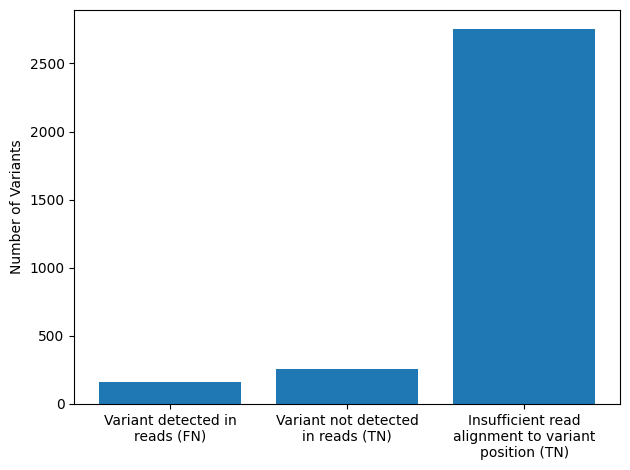

In [33]:
overall_results = {
    "Variant detected in reads (FN)": len(true_variants),
    "Variant not detected in reads (TN)": len(false_variants),
    "Insufficient read alignment to variant position (TN)": len(undetermined_variants),
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fn_bar_plot.pdf"))

## Analyze a FN

In [34]:
# detailed_txt_out_fn = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_fn_NOT_modified_bam.txt"
# vcrs_fasta = "/data/vk_ref_out_geuvadis/w37_k41/vcrs_filtered.fa"

variants_in_vcrs_reference = []
variants_not_in_vcrs_reference = []

with open(vcrs_fasta) as f:
    vcrs_reference_contents = f.read()

# loop through detailed_txt_out_fn and check if the variant was in the vcrs_fasta
with open(detailed_txt_out_fn) as f:
    lines = f.readlines()

for i in tqdm(range(len(lines))):
    if i + 1 < len(lines) and "True variant: True" not in lines[i + 1]:
        continue  # I only want to analyze True variants that varseek missed
    line = lines[i]
    if not line.startswith("vcrs"):
        continue
    parts = line.strip().split("|")
    if len(parts) < 3:
        continue
    mutation_str = parts[2].strip()  # e.g., ENST00000338591:c.716G>C
    if mutation_str in vcrs_reference_contents:
        variants_in_vcrs_reference.append(mutation_str)
    else:
        variants_not_in_vcrs_reference.append(mutation_str)

print(f"Variants in vcrs_reference: {len(variants_in_vcrs_reference)}")
print(f"Variants not in vcrs_reference: {len(variants_not_in_vcrs_reference)}")


  0%|                                                                                                                                                                                | 0/25384 [00:00<?, ?it/s]


 29%|███████████████████████████████████████████████                                                                                                                   | 7369/25384 [00:00<00:00, 70881.71it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 14458/25384 [00:00<00:00, 29100.21it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 18575/25384 [00:00<00:00, 19494.85it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 21340/25384 [00:00<00:00, 20518.73it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 23988/25384 [00:01<00:00, 20774.08it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25384/25384 [00:01<00:00, 22883.09it/s]

Variants in vcrs_reference: 164
Variants not in vcrs_reference: 0


In [35]:
variants_in_vcrs_reference[:20]

['ENST00000377403:c.1963C>T',
 'ENST00000374472:c.351A>G',
 'ENST00000374472:c.350A>G',
 'ENST00000373888:c.933T>C',
 'ENST00000340450:c.795T>G',
 'ENST00000340450:c.801T>G',
 'ENST00000370139:c.96G>A',
 'ENST00000370139:c.97C>T',
 'ENST00000340480:c.2288G>A',
 'ENST00000585156:c.6692C>G',
 'ENST00000581821:c.709G>C',
 'ENST00000355199:c.1215G>C',
 'ENST00000367577:c.554G>T',
 'ENST00000341360:c.508A>G',
 'ENST00000261458:c.740G>A',
 'ENST00000238181:c.457C>T',
 'ENST00000238181:c.458A>G',
 'ENST00000366576:c.2154C>A',
 'ENST00000359594:c.420G>A',
 'ENST00000328782:c.417G>A']

In [36]:
# look into detailed_txt_out_fn and pick a True variant that had reads align to ALT and is in the vcrs reference
# eg vcrs_104 | rs2502992 | ENST00000374472:c.351A>G | (-) strand | 1:g.24201919T>C 
# variant_bam_sorted_modified = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/final_total_sorted_reads_modified.bam"  #* uncomment if running only this bottom portion
# hgvsc = "ENST00000374472:c.351A>G"
# chrom = "1"
# pos = "24201919"
variant_bam_sorted = os.path.join(notebook_out_dir, "final_total_sorted_reads.bam") if not modify_bam else os.path.join(notebook_out_dir, "final_total_sorted_reads_modified.bam")
hgvsc = variants_in_vcrs_reference[0]
print(hgvsc)

result = None
with open(detailed_txt_out_fn) as f:
    for line in f:
        if hgvsc in line:
            result = line.strip().split(" | ")
            break  # stop at the first match

hgvsg = result[4]
chrom = hgvsg.split(":")[0]
match = re.search(r'g\.(\d+)', hgvsg)
pos = match.group(1) if match else None

# output_sam = f"/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/reads_at_{chrom}_{pos}.sam"
output_sam = os.path.join(notebook_out_dir, f"reads_at_{chrom}_{pos}.sam")
!samtools view {variant_bam_sorted} {chrom}:{pos}-{pos} > {output_sam}

ENST00000377403:c.1963C>T


In [37]:
# revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)
print(seq_rc[:38])
print(seq_rc[37:])

GACTTCCAGGTCCTCAGGGCCAAGTACCGAGAGAGCCTGCTGGTCTCCGCCTGGTCCGAGGAGCTGATCTCTAAG
CTTAGAGATCAGCTCCTCGGACCAGGCGGAGACCAGCAGGCTCTCTCGGTACTTGGCCCTGAGGACCTGGAAGTC
CTTAGAGATCAGCTCCTCGGACCAGGCGGAGACCAGCA
AGGCTCTCTCGGTACTTGGCCCTGAGGACCTGGAAGTC


(double click on this cell for it to make sense)
Applies to ENST00000374472:c.351A>G aka 1:g.24201919T>C 

In this case, the issue was due to multiple variants - all reads had the variant toward the left end of the read, and there is another variant to the right that blocks a perfect k-mer match (also, keep in mind that read length is 75 for this dataset and w=37/k=41, so the reads are relatively small)

Eg typical read:
TTCCGGCGGAGCCGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGTTCTCCAGGGCACTTAGCAGGCCCAGA  # read
TTCCGGCGGAGCTGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGT  # vcrs fragment aligned to read
           *
            ^

* mutation site for VCRS
^ unrelated mutation that blocks k-mer match

## Now let's look into a FP

In [38]:
# eg vcrs_100 | rs1131095 | ENST00000296456:c.1252T>C | (+) strand | 3:g.49714225T>C | 68.0 reported counts
# hgvsc = "ENST00000296456:c.1252T>C"
results = []

with open(detailed_txt_out) as f:
    lines = f.readlines()

for i in range(len(lines) - 1):
    line1 = lines[i].strip()
    line2 = lines[i + 1].strip()

    # Check that line1 has a reported count > min_counts
    try:
        count_str = line1.split(" | ")[-1].split()[0]  # e.g., '68.0' from '68.0 reported counts'
        reported_count = float(count_str)
    except (IndexError, ValueError):
        continue  # skip malformed lines

    # Check that the next line doesn't say "True variant: True"
    if reported_count > min_counts and line2 != "True variant: True":
        results.append(line1)

result_single = results[0]  # look at the first one
result_single = result_single.split(" | ")

hgvsc = result_single[2]
print(hgvsc)
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)

ENST00000368567:c.58T>C


ACCTACGCACACGAGAACATGCCTCTCGCAAAGGATCCCCTTCATCCCTCTCCAGAAGAGGAGAAGAGGAAACAC
GTGTTTCCTCTTCTCCTCTTCTGGAGAGGGATGAAGGGGATCCTTTGCGAGAGGCATGTTCTCGTGTGCGTAGGT


### Manually check if any read has a k-mer that matches the VCRS

In [39]:
# import pyfastx
# fastq_file = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/fastqs_combined/fastqs_combined.fastq.gz"  #* uncomment if running only this bottom portion
# fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)  #* uncomment if running only this bottom portion

k = 41  # from vk ref settings
kmer_set = set()

# Add k-mers from seq and seq_rc
for s in [seq, seq_rc]:
    for i in range(len(s) - k + 1):
        kmer_set.add(s[i:i+k])

# Store reads that contain any of those k-mers
matching_reads = {}

fq_read_only = pyfastx.Fastx(fastq_file)

for name, read_seq, _ in tqdm((fq_read_only), total=len(fastq_indexed)):
    found = any(read_seq[i:i+k] in kmer_set for i in range(len(read_seq) - k + 1))
    if found:
        matching_reads[name] = read_seq


  0%|                                                                                                                                                                             | 0/42245278 [00:00<?, ?it/s]


  0%|                                                                                                                                                               | 2575/42245278 [00:00<27:20, 25742.97it/s]


  0%|                                                                                                                                                               | 6825/42245278 [00:00<19:46, 35593.81it/s]


  0%|                                                                                                                                                              | 10804/42245278 [00:00<18:46, 37503.14it/s]


  0%|                                                                                                                                                              | 15106/42245278 [00:00<17:44, 39678.01it/s]


  0%|                                                                                                                                                              | 19717/42245278 [00:00<16:45, 41994.11it/s]


  0%|                                                                                                                                                              | 24120/42245278 [00:00<16:29, 42682.07it/s]


  0%|                                                                                                                                                              | 28774/42245278 [00:00<16:19, 43107.33it/s]


  0%|▏                                                                                                                                                             | 33550/42245278 [00:00<15:49, 44471.08it/s]


  0%|▏                                                                                                                                                             | 39425/42245278 [00:00<14:23, 48885.98it/s]


  0%|▏                                                                                                                                                             | 47373/42245278 [00:01<12:04, 58260.50it/s]


  0%|▏                                                                                                                                                             | 54648/42245278 [00:01<11:13, 62668.65it/s]


  0%|▏                                                                                                                                                             | 62202/42245278 [00:01<10:39, 65945.42it/s]


  0%|▎                                                                                                                                                             | 70192/42245278 [00:01<10:01, 70131.80it/s]


  0%|▎                                                                                                                                                             | 77696/42245278 [00:01<09:48, 71603.29it/s]


  0%|▎                                                                                                                                                             | 86068/42245278 [00:01<09:20, 75236.35it/s]


  0%|▎                                                                                                                                                             | 93928/42245278 [00:01<09:12, 76244.76it/s]


  0%|▍                                                                                                                                                            | 101781/42245278 [00:01<09:07, 76929.71it/s]


  0%|▍                                                                                                                                                            | 109912/42245278 [00:01<09:03, 77535.99it/s]


  0%|▍                                                                                                                                                            | 118210/42245278 [00:01<08:52, 79156.62it/s]


  0%|▍                                                                                                                                                            | 126128/42245278 [00:02<08:53, 79002.90it/s]


  0%|▍                                                                                                                                                            | 134030/42245278 [00:02<08:53, 78901.74it/s]


  0%|▌                                                                                                                                                            | 142414/42245278 [00:02<08:43, 80374.51it/s]


  0%|▌                                                                                                                                                            | 150453/42245278 [00:02<08:47, 79848.09it/s]


  0%|▌                                                                                                                                                            | 158440/42245278 [00:02<08:51, 79240.53it/s]


  0%|▌                                                                                                                                                            | 166801/42245278 [00:02<08:42, 80535.64it/s]


  0%|▋                                                                                                                                                            | 174858/42245278 [00:02<08:45, 79983.54it/s]


  0%|▋                                                                                                                                                            | 182859/42245278 [00:02<08:48, 79541.39it/s]


  0%|▋                                                                                                                                                            | 190815/42245278 [00:02<08:50, 79232.96it/s]


  0%|▋                                                                                                                                                            | 199102/42245278 [00:02<08:43, 80310.73it/s]


  0%|▊                                                                                                                                                            | 207136/42245278 [00:03<08:46, 79903.66it/s]


  1%|▊                                                                                                                                                            | 215128/42245278 [00:03<08:48, 79527.10it/s]


  1%|▊                                                                                                                                                            | 223515/42245278 [00:03<08:39, 80815.25it/s]


  1%|▊                                                                                                                                                            | 231599/42245278 [00:03<09:29, 73711.11it/s]


  1%|▉                                                                                                                                                            | 239294/42245278 [00:03<09:22, 74614.37it/s]


  1%|▉                                                                                                                                                            | 247484/42245278 [00:03<09:13, 75910.49it/s]


  1%|▉                                                                                                                                                            | 255794/42245278 [00:03<08:58, 77975.85it/s]


  1%|▉                                                                                                                                                            | 263678/42245278 [00:03<08:56, 78226.14it/s]


  1%|█                                                                                                                                                            | 271568/42245278 [00:03<08:55, 78422.26it/s]


  1%|█                                                                                                                                                            | 279866/42245278 [00:03<08:46, 79768.62it/s]


  1%|█                                                                                                                                                            | 287865/42245278 [00:04<08:48, 79458.36it/s]


  1%|█                                                                                                                                                            | 295827/42245278 [00:04<08:48, 79367.12it/s]


  1%|█▏                                                                                                                                                           | 304273/42245278 [00:04<08:47, 79499.53it/s]


  1%|█▏                                                                                                                                                           | 312560/42245278 [00:04<08:40, 80491.17it/s]


  1%|█▏                                                                                                                                                           | 320616/42245278 [00:04<08:42, 80190.89it/s]


  1%|█▏                                                                                                                                                           | 328640/42245278 [00:04<08:44, 79942.98it/s]


  1%|█▎                                                                                                                                                           | 337098/42245278 [00:04<08:35, 81316.45it/s]


  1%|█▎                                                                                                                                                           | 345234/42245278 [00:04<08:38, 80824.31it/s]


  1%|█▎                                                                                                                                                           | 353320/42245278 [00:04<08:43, 79988.11it/s]


  1%|█▎                                                                                                                                                           | 361323/42245278 [00:04<08:45, 79733.32it/s]


  1%|█▎                                                                                                                                                           | 369758/42245278 [00:05<08:36, 81100.33it/s]


  1%|█▍                                                                                                                                                           | 377872/42245278 [00:05<08:40, 80438.95it/s]


  1%|█▍                                                                                                                                                           | 385919/42245278 [00:05<08:42, 80045.41it/s]


  1%|█▍                                                                                                                                                           | 394234/42245278 [00:05<08:36, 80963.71it/s]


  1%|█▍                                                                                                                                                           | 402333/42245278 [00:05<08:40, 80440.06it/s]


  1%|█▌                                                                                                                                                           | 410380/42245278 [00:05<08:42, 80038.30it/s]


  1%|█▌                                                                                                                                                           | 418386/42245278 [00:05<08:44, 79772.74it/s]


  1%|█▌                                                                                                                                                           | 426814/42245278 [00:05<08:35, 81109.97it/s]


  1%|█▌                                                                                                                                                           | 434928/42245278 [00:05<08:41, 80173.60it/s]


  1%|█▋                                                                                                                                                           | 442949/42245278 [00:05<08:44, 79758.43it/s]


  1%|█▋                                                                                                                                                           | 451376/42245278 [00:06<08:35, 81091.47it/s]


  1%|█▋                                                                                                                                                           | 459489/42245278 [00:06<08:40, 80337.46it/s]


  1%|█▋                                                                                                                                                           | 467527/42245278 [00:06<08:42, 79978.39it/s]


  1%|█▊                                                                                                                                                           | 475528/42245278 [00:06<08:46, 79340.20it/s]


  1%|█▊                                                                                                                                                           | 483956/42245278 [00:06<08:36, 80797.91it/s]


  1%|█▊                                                                                                                                                           | 492040/42245278 [00:06<08:39, 80295.41it/s]


  1%|█▊                                                                                                                                                           | 500073/42245278 [00:06<08:42, 79917.13it/s]


  1%|█▉                                                                                                                                                           | 508445/42245278 [00:06<08:43, 79729.80it/s]


  1%|█▉                                                                                                                                                           | 516756/42245278 [00:06<08:36, 80722.66it/s]


  1%|█▉                                                                                                                                                           | 524832/42245278 [00:07<08:39, 80243.95it/s]


  1%|█▉                                                                                                                                                           | 532859/42245278 [00:07<08:41, 79939.42it/s]


  1%|██                                                                                                                                                           | 541296/42245278 [00:07<08:33, 81249.20it/s]


  1%|██                                                                                                                                                           | 549424/42245278 [00:07<08:37, 80628.32it/s]


  1%|██                                                                                                                                                           | 557490/42245278 [00:07<08:42, 79840.28it/s]


  1%|██                                                                                                                                                           | 565491/42245278 [00:07<08:44, 79540.73it/s]


  1%|██▏                                                                                                                                                          | 573913/42245278 [00:07<08:34, 80922.61it/s]


  1%|██▏                                                                                                                                                          | 582009/42245278 [00:07<08:38, 80419.21it/s]


  1%|██▏                                                                                                                                                          | 590054/42245278 [00:07<08:39, 80122.02it/s]


  1%|██▏                                                                                                                                                          | 598329/42245278 [00:07<08:34, 80899.98it/s]


  1%|██▎                                                                                                                                                          | 606421/42245278 [00:08<08:38, 80251.31it/s]


  1%|██▎                                                                                                                                                          | 614449/42245278 [00:08<08:41, 79819.43it/s]


  1%|██▎                                                                                                                                                          | 622433/42245278 [00:08<08:43, 79472.61it/s]


  1%|██▎                                                                                                                                                          | 630838/42245278 [00:08<08:34, 80827.59it/s]


  2%|██▎                                                                                                                                                          | 638924/42245278 [00:08<08:39, 80065.22it/s]


  2%|██▍                                                                                                                                                          | 646934/42245278 [00:08<08:41, 79756.26it/s]


  2%|██▍                                                                                                                                                          | 655368/42245278 [00:08<08:32, 81114.32it/s]


  2%|██▍                                                                                                                                                          | 663483/42245278 [00:08<08:36, 80523.16it/s]


  2%|██▍                                                                                                                                                          | 671538/42245278 [00:08<08:39, 80007.12it/s]


  2%|██▌                                                                                                                                                          | 679541/42245278 [00:08<08:43, 79336.80it/s]


  2%|██▌                                                                                                                                                          | 687976/42245278 [00:09<08:34, 80817.61it/s]


  2%|██▌                                                                                                                                                          | 696062/42245278 [00:09<08:37, 80298.27it/s]


  2%|██▌                                                                                                                                                          | 704095/42245278 [00:09<08:39, 79939.95it/s]


  2%|██▋                                                                                                                                                          | 712196/42245278 [00:09<08:41, 79704.12it/s]


  2%|██▋                                                                                                                                                          | 720499/42245278 [00:09<08:34, 80686.75it/s]


  2%|██▋                                                                                                                                                          | 728570/42245278 [00:09<08:37, 80154.09it/s]


  2%|██▋                                                                                                                                                          | 736588/42245278 [00:09<08:40, 79807.21it/s]


  2%|██▊                                                                                                                                                          | 745007/42245278 [00:09<08:31, 81106.17it/s]


  2%|██▊                                                                                                                                                          | 753120/42245278 [00:09<08:35, 80450.20it/s]


  2%|██▊                                                                                                                                                          | 761168/42245278 [00:09<08:40, 79656.49it/s]


  2%|██▊                                                                                                                                                          | 769137/42245278 [00:10<08:41, 79462.03it/s]


  2%|██▉                                                                                                                                                          | 777522/42245278 [00:10<08:33, 80760.73it/s]


  2%|██▉                                                                                                                                                          | 785601/42245278 [00:10<08:36, 80324.03it/s]


  2%|██▉                                                                                                                                                          | 793636/42245278 [00:10<08:38, 79878.80it/s]


  2%|██▉                                                                                                                                                          | 801881/42245278 [00:10<08:33, 80640.21it/s]


  2%|███                                                                                                                                                          | 809947/42245278 [00:10<08:37, 80088.18it/s]


  2%|███                                                                                                                                                          | 817958/42245278 [00:10<08:39, 79715.89it/s]


  2%|███                                                                                                                                                          | 826123/42245278 [00:10<08:40, 79534.01it/s]


  2%|███                                                                                                                                                          | 834397/42245278 [00:10<08:34, 80481.42it/s]


  2%|███▏                                                                                                                                                         | 842448/42245278 [00:10<08:37, 80029.29it/s]


  2%|███▏                                                                                                                                                         | 850453/42245278 [00:11<08:39, 79719.22it/s]


  2%|███▏                                                                                                                                                         | 858851/42245278 [00:11<08:31, 80982.53it/s]


  2%|███▏                                                                                                                                                         | 866952/42245278 [00:11<08:34, 80411.17it/s]


  2%|███▎                                                                                                                                                         | 874996/42245278 [00:11<09:26, 73039.56it/s]


  2%|███▎                                                                                                                                                         | 883168/42245278 [00:11<09:13, 74687.42it/s]


  2%|███▎                                                                                                                                                         | 891553/42245278 [00:11<08:55, 77271.07it/s]


  2%|███▎                                                                                                                                                         | 899437/42245278 [00:11<08:51, 77719.18it/s]


  2%|███▎                                                                                                                                                         | 907288/42245278 [00:11<08:50, 77948.11it/s]


  2%|███▍                                                                                                                                                         | 915577/42245278 [00:11<08:40, 79398.77it/s]


  2%|███▍                                                                                                                                                         | 923551/42245278 [00:12<08:42, 79128.70it/s]


  2%|███▍                                                                                                                                                         | 931488/42245278 [00:12<08:42, 79029.36it/s]


  2%|███▍                                                                                                                                                         | 939945/42245278 [00:12<08:32, 80671.91it/s]


  2%|███▌                                                                                                                                                         | 948026/42245278 [00:12<08:35, 80117.02it/s]


  2%|███▌                                                                                                                                                         | 956048/42245278 [00:12<08:40, 79294.44it/s]


  2%|███▌                                                                                                                                                         | 963986/42245278 [00:12<08:41, 79110.56it/s]


  2%|███▌                                                                                                                                                         | 972390/42245278 [00:12<08:32, 80569.46it/s]


  2%|███▋                                                                                                                                                         | 980453/42245278 [00:12<08:34, 80156.12it/s]


  2%|███▋                                                                                                                                                         | 988473/42245278 [00:12<08:36, 79820.94it/s]


  2%|███▋                                                                                                                                                         | 996753/42245278 [00:12<08:31, 80703.63it/s]


  2%|███▋                                                                                                                                                        | 1004827/42245278 [00:13<08:34, 80226.05it/s]


  2%|███▋                                                                                                                                                        | 1012852/42245278 [00:13<08:36, 79904.17it/s]


  2%|███▊                                                                                                                                                        | 1020845/42245278 [00:13<08:37, 79659.38it/s]


  2%|███▊                                                                                                                                                        | 1029299/42245278 [00:13<08:28, 81106.45it/s]


  2%|███▊                                                                                                                                                        | 1037412/42245278 [00:13<08:36, 79836.13it/s]


  2%|███▊                                                                                                                                                        | 1045401/42245278 [00:13<08:37, 79579.46it/s]


  2%|███▉                                                                                                                                                        | 1053657/42245278 [00:13<08:38, 79451.04it/s]


  3%|███▉                                                                                                                                                        | 1062054/42245278 [00:13<08:29, 80779.96it/s]


  3%|███▉                                                                                                                                                        | 1070137/42245278 [00:13<08:33, 80207.18it/s]


  3%|███▉                                                                                                                                                        | 1078161/42245278 [00:13<08:38, 79415.12it/s]


  3%|████                                                                                                                                                        | 1086540/42245278 [00:14<08:29, 80704.96it/s]


  3%|████                                                                                                                                                        | 1094615/42245278 [00:14<08:33, 80140.69it/s]


  3%|████                                                                                                                                                        | 1102633/42245278 [00:14<08:36, 79676.36it/s]


  3%|████                                                                                                                                                        | 1110603/42245278 [00:14<08:38, 79352.08it/s]


  3%|████▏                                                                                                                                                       | 1118540/42245278 [00:14<09:04, 75555.35it/s]


  3%|████▏                                                                                                                                                       | 1126430/42245278 [00:14<08:57, 76513.50it/s]


  3%|████▏                                                                                                                                                       | 1134256/42245278 [00:14<08:53, 77020.85it/s]


  3%|████▏                                                                                                                                                       | 1142677/42245278 [00:14<08:39, 79129.99it/s]


  3%|████▏                                                                                                                                                       | 1150610/42245278 [00:14<08:43, 78561.76it/s]


  3%|████▎                                                                                                                                                       | 1158481/42245278 [00:14<08:43, 78484.53it/s]


  3%|████▎                                                                                                                                                       | 1166340/42245278 [00:15<08:56, 76518.95it/s]


  3%|████▎                                                                                                                                                       | 1174213/42245278 [00:15<08:52, 77162.52it/s]


  3%|████▎                                                                                                                                                       | 1182082/42245278 [00:15<08:49, 77609.74it/s]


  3%|████▍                                                                                                                                                       | 1190373/42245278 [00:15<08:38, 79175.79it/s]


  3%|████▍                                                                                                                                                       | 1198300/42245278 [00:15<08:39, 79019.65it/s]


  3%|████▍                                                                                                                                                       | 1206244/42245278 [00:15<08:38, 79143.29it/s]


  3%|████▍                                                                                                                                                       | 1214163/42245278 [00:15<08:39, 79050.88it/s]


  3%|████▌                                                                                                                                                       | 1222572/42245278 [00:15<08:29, 80554.10it/s]


  3%|████▌                                                                                                                                                       | 1230631/42245278 [00:15<08:34, 79677.22it/s]


  3%|████▌                                                                                                                                                       | 1238603/42245278 [00:15<08:36, 79462.21it/s]


  3%|████▌                                                                                                                                                       | 1247015/42245278 [00:16<08:27, 80843.83it/s]


  3%|████▋                                                                                                                                                       | 1255103/42245278 [00:16<08:31, 80185.24it/s]


  3%|████▋                                                                                                                                                       | 1263125/42245278 [00:16<08:34, 79722.39it/s]


  3%|████▋                                                                                                                                                       | 1271100/42245278 [00:16<08:37, 79151.42it/s]


  3%|████▋                                                                                                                                                       | 1279518/42245278 [00:16<08:28, 80638.68it/s]


  3%|████▊                                                                                                                                                       | 1287586/42245278 [00:16<08:30, 80236.06it/s]


  3%|████▊                                                                                                                                                       | 1295613/42245278 [00:16<08:32, 79870.25it/s]


  3%|████▊                                                                                                                                                       | 1304015/42245278 [00:16<08:33, 79759.40it/s]


  3%|████▊                                                                                                                                                       | 1312311/42245278 [00:16<08:27, 80698.84it/s]


  3%|████▉                                                                                                                                                       | 1320384/42245278 [00:17<08:30, 80174.79it/s]


  3%|████▉                                                                                                                                                       | 1328404/42245278 [00:17<08:32, 79773.13it/s]


  3%|████▉                                                                                                                                                       | 1336824/42245278 [00:17<08:24, 81080.89it/s]


  3%|████▉                                                                                                                                                       | 1344935/42245278 [00:17<08:28, 80448.72it/s]


  3%|████▉                                                                                                                                                       | 1352983/42245278 [00:17<08:34, 79413.27it/s]


  3%|█████                                                                                                                                                       | 1360928/42245278 [00:17<08:35, 79243.21it/s]


  3%|█████                                                                                                                                                       | 1369378/42245278 [00:17<08:25, 80796.13it/s]


  3%|█████                                                                                                                                                       | 1377462/42245278 [00:17<08:30, 80081.53it/s]


  3%|█████                                                                                                                                                       | 1385474/42245278 [00:17<08:32, 79676.84it/s]


  3%|█████▏                                                                                                                                                      | 1393445/42245278 [00:17<09:36, 70868.04it/s]


  3%|█████▏                                                                                                                                                      | 1401284/42245278 [00:18<09:20, 72923.66it/s]


  3%|█████▏                                                                                                                                                      | 1409129/42245278 [00:18<09:08, 74475.06it/s]


  3%|█████▏                                                                                                                                                      | 1417414/42245278 [00:18<08:58, 75835.56it/s]


  3%|█████▎                                                                                                                                                      | 1425667/42245278 [00:18<08:44, 77757.94it/s]


  3%|█████▎                                                                                                                                                      | 1433523/42245278 [00:18<08:43, 77989.36it/s]


  3%|█████▎                                                                                                                                                      | 1441388/42245278 [00:18<08:41, 78182.34it/s]


  3%|█████▎                                                                                                                                                      | 1449803/42245278 [00:18<08:30, 79945.53it/s]


  3%|█████▍                                                                                                                                                      | 1457823/42245278 [00:18<08:32, 79580.14it/s]


  3%|█████▍                                                                                                                                                      | 1465799/42245278 [00:18<08:36, 79015.40it/s]


  3%|█████▍                                                                                                                                                      | 1473948/42245278 [00:18<08:35, 79100.70it/s]


  4%|█████▍                                                                                                                                                      | 1482409/42245278 [00:19<08:24, 80726.80it/s]


  4%|█████▌                                                                                                                                                      | 1490491/42245278 [00:19<08:27, 80374.57it/s]


  4%|█████▌                                                                                                                                                      | 1498535/42245278 [00:19<08:29, 79925.16it/s]


  4%|█████▌                                                                                                                                                      | 1506756/42245278 [00:19<08:25, 80601.96it/s]


  4%|█████▌                                                                                                                                                      | 1514821/42245278 [00:19<08:29, 80011.64it/s]


  4%|█████▌                                                                                                                                                      | 1522826/42245278 [00:19<08:31, 79570.47it/s]


  4%|█████▋                                                                                                                                                      | 1530786/42245278 [00:19<08:34, 79201.76it/s]


  4%|█████▋                                                                                                                                                      | 1539178/42245278 [00:19<08:25, 80598.55it/s]


  4%|█████▋                                                                                                                                                      | 1547241/42245278 [00:19<10:07, 67009.52it/s]


  4%|█████▋                                                                                                                                                      | 1554323/42245278 [00:20<11:41, 57983.13it/s]


  4%|█████▊                                                                                                                                                      | 1560559/42245278 [00:20<12:32, 54055.43it/s]


  4%|█████▊                                                                                                                                                      | 1566278/42245278 [00:20<13:00, 52123.53it/s]


  4%|█████▊                                                                                                                                                      | 1572882/42245278 [00:20<14:47, 45830.39it/s]


  4%|█████▊                                                                                                                                                      | 1580433/42245278 [00:20<12:54, 52496.68it/s]


  4%|█████▊                                                                                                                                                      | 1587454/42245278 [00:20<11:55, 56798.72it/s]


  4%|█████▉                                                                                                                                                      | 1594992/42245278 [00:20<11:02, 61375.50it/s]


  4%|█████▉                                                                                                                                                      | 1601473/42245278 [00:20<11:10, 60574.74it/s]


  4%|█████▉                                                                                                                                                      | 1609842/42245278 [00:21<10:07, 66850.15it/s]


  4%|█████▉                                                                                                                                                      | 1617652/42245278 [00:21<09:40, 69992.17it/s]


  4%|██████                                                                                                                                                      | 1625468/42245278 [00:21<09:21, 72321.59it/s]


  4%|██████                                                                                                                                                      | 1633725/42245278 [00:21<08:59, 75287.62it/s]


  4%|██████                                                                                                                                                      | 1641579/42245278 [00:21<08:52, 76237.94it/s]


  4%|██████                                                                                                                                                      | 1649416/42245278 [00:21<08:48, 76864.49it/s]


  4%|██████                                                                                                                                                      | 1657835/42245278 [00:21<08:33, 79033.96it/s]


  4%|██████▏                                                                                                                                                     | 1665781/42245278 [00:21<08:34, 78929.04it/s]


  4%|██████▏                                                                                                                                                     | 1673704/42245278 [00:21<08:38, 78301.05it/s]


  4%|██████▏                                                                                                                                                     | 1681723/42245278 [00:21<08:38, 78215.43it/s]


  4%|██████▏                                                                                                                                                     | 1690186/42245278 [00:22<08:26, 80110.20it/s]


  4%|██████▎                                                                                                                                                     | 1698211/42245278 [00:22<08:27, 79829.92it/s]


  4%|██████▎                                                                                                                                                     | 1706204/42245278 [00:22<08:30, 79474.11it/s]


  4%|██████▎                                                                                                                                                     | 1714423/42245278 [00:22<08:24, 80277.70it/s]


  4%|██████▎                                                                                                                                                     | 1722457/42245278 [00:22<08:28, 79685.85it/s]


  4%|██████▍                                                                                                                                                     | 1730430/42245278 [00:22<08:30, 79304.81it/s]


  4%|██████▍                                                                                                                                                     | 1738512/42245278 [00:22<08:31, 79125.10it/s]


  4%|██████▍                                                                                                                                                     | 1746849/42245278 [00:22<08:23, 80381.34it/s]


  4%|██████▍                                                                                                                                                     | 1754891/42245278 [00:22<08:29, 79495.40it/s]


  4%|██████▌                                                                                                                                                     | 1762845/42245278 [00:23<08:32, 78970.97it/s]


  4%|██████▌                                                                                                                                                     | 1771225/42245278 [00:23<08:23, 80396.88it/s]


  4%|██████▌                                                                                                                                                     | 1779269/42245278 [00:23<08:25, 80103.52it/s]


  4%|██████▌                                                                                                                                                     | 1787283/42245278 [00:23<08:27, 79656.01it/s]


  4%|██████▋                                                                                                                                                     | 1795300/42245278 [00:23<08:32, 78974.89it/s]


  4%|██████▋                                                                                                                                                     | 1803685/42245278 [00:23<08:22, 80414.87it/s]


  4%|██████▋                                                                                                                                                     | 1811731/42245278 [00:23<08:26, 79882.63it/s]


  4%|██████▋                                                                                                                                                     | 1819723/42245278 [00:23<08:28, 79491.13it/s]


  4%|██████▊                                                                                                                                                     | 1828082/42245278 [00:23<08:20, 80704.57it/s]


  4%|██████▊                                                                                                                                                     | 1836156/42245278 [00:23<08:26, 79813.11it/s]


  4%|██████▊                                                                                                                                                     | 1844141/42245278 [00:24<08:27, 79540.03it/s]


  4%|██████▊                                                                                                                                                     | 1852098/42245278 [00:24<08:29, 79260.13it/s]


  4%|██████▊                                                                                                                                                     | 1860516/42245278 [00:24<08:20, 80719.08it/s]


  4%|██████▉                                                                                                                                                     | 1868591/42245278 [00:24<08:23, 80151.97it/s]


  4%|██████▉                                                                                                                                                     | 1876609/42245278 [00:24<08:29, 79294.34it/s]


  4%|██████▉                                                                                                                                                     | 1884864/42245278 [00:24<08:30, 79092.23it/s]


  4%|██████▉                                                                                                                                                     | 1892776/42245278 [00:24<09:57, 67538.89it/s]


  4%|███████                                                                                                                                                     | 1899814/42245278 [00:24<11:34, 58072.09it/s]


  5%|███████                                                                                                                                                     | 1906008/42245278 [00:24<12:28, 53858.02it/s]


  5%|███████                                                                                                                                                     | 1911677/42245278 [00:25<13:08, 51131.70it/s]


  5%|███████                                                                                                                                                     | 1916977/42245278 [00:25<13:39, 49207.78it/s]


  5%|███████                                                                                                                                                     | 1922014/42245278 [00:25<14:03, 47805.98it/s]


  5%|███████                                                                                                                                                     | 1928533/42245278 [00:25<12:51, 52252.95it/s]


  5%|███████▏                                                                                                                                                    | 1936098/42245278 [00:25<11:28, 58514.53it/s]


  5%|███████▏                                                                                                                                                    | 1943097/42245278 [00:25<10:53, 61686.39it/s]


  5%|███████▏                                                                                                                                                    | 1950689/42245278 [00:25<10:13, 65716.10it/s]


  5%|███████▏                                                                                                                                                    | 1957716/42245278 [00:25<10:01, 67025.80it/s]


  5%|███████▎                                                                                                                                                    | 1965333/42245278 [00:25<09:37, 69690.16it/s]


  5%|███████▎                                                                                                                                                    | 1973700/42245278 [00:26<09:05, 73798.39it/s]


  5%|███████▎                                                                                                                                                    | 1981538/42245278 [00:26<08:55, 75152.50it/s]


  5%|███████▎                                                                                                                                                    | 1989394/42245278 [00:26<08:48, 76162.28it/s]


  5%|███████▍                                                                                                                                                    | 1997793/42245278 [00:26<08:32, 78493.58it/s]


  5%|███████▍                                                                                                                                                    | 2005666/42245278 [00:26<08:34, 78146.19it/s]


  5%|███████▍                                                                                                                                                    | 2013521/42245278 [00:26<08:34, 78263.99it/s]


  5%|███████▍                                                                                                                                                    | 2021487/42245278 [00:26<08:33, 78324.86it/s]


  5%|███████▍                                                                                                                                                    | 2029883/42245278 [00:26<08:22, 80000.92it/s]


  5%|███████▌                                                                                                                                                    | 2037890/42245278 [00:26<08:25, 79606.29it/s]


  5%|███████▌                                                                                                                                                    | 2045856/42245278 [00:26<08:28, 78988.78it/s]


  5%|███████▌                                                                                                                                                    | 2054263/42245278 [00:27<08:19, 80496.34it/s]


  5%|███████▌                                                                                                                                                    | 2062318/42245278 [00:27<08:22, 80009.66it/s]


  5%|███████▋                                                                                                                                                    | 2070323/42245278 [00:27<08:49, 75844.07it/s]


  5%|███████▋                                                                                                                                                    | 2078316/42245278 [00:27<08:46, 76310.21it/s]


  5%|███████▋                                                                                                                                                    | 2086732/42245278 [00:27<08:31, 78574.34it/s]


  5%|███████▋                                                                                                                                                    | 2094621/42245278 [00:27<08:31, 78559.17it/s]


  5%|███████▊                                                                                                                                                    | 2102499/42245278 [00:27<08:30, 78610.25it/s]


  5%|███████▊                                                                                                                                                    | 2110875/42245278 [00:27<08:20, 80132.29it/s]


  5%|███████▊                                                                                                                                                    | 2118902/42245278 [00:27<08:26, 79275.49it/s]


  5%|███████▊                                                                                                                                                    | 2126841/42245278 [00:27<08:27, 79123.17it/s]


  5%|███████▉                                                                                                                                                    | 2135105/42245278 [00:28<08:26, 79123.67it/s]


  5%|███████▉                                                                                                                                                    | 2143532/42245278 [00:28<08:17, 80639.83it/s]


  5%|███████▉                                                                                                                                                    | 2151603/42245278 [00:28<08:19, 80199.13it/s]


  5%|███████▉                                                                                                                                                    | 2159628/42245278 [00:28<08:24, 79442.19it/s]


  5%|████████                                                                                                                                                    | 2168073/42245278 [00:28<08:15, 80918.60it/s]


  5%|████████                                                                                                                                                    | 2176170/42245278 [00:28<08:19, 80200.03it/s]


  5%|████████                                                                                                                                                    | 2184195/42245278 [00:28<08:22, 79721.29it/s]


  5%|████████                                                                                                                                                    | 2192171/42245278 [00:28<08:24, 79455.94it/s]


  5%|████████                                                                                                                                                    | 2200119/42245278 [00:29<10:40, 62490.92it/s]


  5%|████████▏                                                                                                                                                   | 2207920/42245278 [00:29<10:03, 66364.69it/s]


  5%|████████▏                                                                                                                                                   | 2215556/42245278 [00:29<10:48, 61702.66it/s]


  5%|████████▏                                                                                                                                                   | 2223962/42245278 [00:29<09:54, 67322.81it/s]


  5%|████████▏                                                                                                                                                   | 2231631/42245278 [00:29<09:33, 69796.05it/s]


  5%|████████▎                                                                                                                                                   | 2239487/42245278 [00:29<09:14, 72195.77it/s]


  5%|████████▎                                                                                                                                                   | 2247875/42245278 [00:29<08:49, 75482.04it/s]


  5%|████████▎                                                                                                                                                   | 2255685/42245278 [00:29<08:44, 76229.76it/s]


  5%|████████▎                                                                                                                                                   | 2263524/42245278 [00:29<08:40, 76856.60it/s]


  5%|████████▍                                                                                                                                                   | 2271798/42245278 [00:29<08:28, 78580.39it/s]


  5%|████████▍                                                                                                                                                   | 2279726/42245278 [00:30<08:29, 78516.58it/s]


  5%|████████▍                                                                                                                                                   | 2287627/42245278 [00:30<08:29, 78456.42it/s]


  5%|████████▍                                                                                                                                                   | 2295828/42245278 [00:30<08:28, 78540.10it/s]


  5%|████████▌                                                                                                                                                   | 2304242/42245278 [00:30<08:18, 80189.30it/s]


  5%|████████▌                                                                                                                                                   | 2312281/42245278 [00:30<08:22, 79399.33it/s]


  5%|████████▌                                                                                                                                                   | 2320236/42245278 [00:30<08:24, 79125.66it/s]


  6%|████████▌                                                                                                                                                   | 2328637/42245278 [00:30<08:15, 80569.35it/s]


  6%|████████▋                                                                                                                                                   | 2336703/42245278 [00:30<08:18, 80044.39it/s]


  6%|████████▋                                                                                                                                                   | 2344715/42245278 [00:30<08:21, 79629.30it/s]


  6%|████████▋                                                                                                                                                   | 2352683/42245278 [00:30<08:25, 78975.76it/s]


  6%|████████▋                                                                                                                                                   | 2361082/42245278 [00:31<08:15, 80457.43it/s]


  6%|████████▋                                                                                                                                                   | 2369133/42245278 [00:31<08:18, 79929.45it/s]


  6%|████████▊                                                                                                                                                   | 2377130/42245278 [00:31<08:21, 79492.94it/s]


  6%|████████▊                                                                                                                                                   | 2385341/42245278 [00:31<08:25, 78878.52it/s]


  6%|████████▊                                                                                                                                                   | 2393746/42245278 [00:31<08:15, 80395.71it/s]


  6%|████████▊                                                                                                                                                   | 2401792/42245278 [00:31<10:27, 63457.80it/s]


  6%|████████▉                                                                                                                                                   | 2409624/42245278 [00:31<09:53, 67170.81it/s]


  6%|████████▉                                                                                                                                                   | 2417995/42245278 [00:31<09:16, 71522.05it/s]


  6%|████████▉                                                                                                                                                   | 2425618/42245278 [00:31<09:06, 72807.41it/s]


  6%|████████▉                                                                                                                                                   | 2433449/42245278 [00:32<08:55, 74351.56it/s]


  6%|█████████                                                                                                                                                   | 2441846/42245278 [00:32<08:36, 77102.99it/s]


  6%|█████████                                                                                                                                                   | 2449715/42245278 [00:32<08:33, 77485.86it/s]


  6%|█████████                                                                                                                                                   | 2457576/42245278 [00:32<08:32, 77707.63it/s]


  6%|█████████                                                                                                                                                   | 2465429/42245278 [00:32<08:32, 77651.29it/s]


  6%|█████████▏                                                                                                                                                  | 2473860/42245278 [00:32<08:19, 79616.61it/s]


  6%|█████████▏                                                                                                                                                  | 2481864/42245278 [00:32<08:21, 79267.53it/s]


  6%|█████████▏                                                                                                                                                  | 2489821/42245278 [00:32<08:48, 75263.93it/s]


  6%|█████████▏                                                                                                                                                  | 2498046/42245278 [00:32<08:34, 77265.05it/s]


  6%|█████████▎                                                                                                                                                  | 2505881/42245278 [00:32<08:32, 77577.93it/s]


  6%|█████████▎                                                                                                                                                  | 2513716/42245278 [00:33<08:30, 77801.82it/s]


  6%|█████████▎                                                                                                                                                  | 2522097/42245278 [00:33<08:19, 79574.65it/s]


  6%|█████████▎                                                                                                                                                  | 2530076/42245278 [00:33<08:21, 79254.63it/s]


  6%|█████████▎                                                                                                                                                  | 2538017/42245278 [00:33<08:24, 78660.41it/s]


  6%|█████████▍                                                                                                                                                  | 2545894/42245278 [00:33<08:25, 78509.78it/s]


  6%|█████████▍                                                                                                                                                  | 2553753/42245278 [00:33<08:54, 74275.52it/s]


  6%|█████████▍                                                                                                                                                  | 2561574/42245278 [00:33<08:46, 75398.67it/s]


  6%|█████████▍                                                                                                                                                  | 2569154/42245278 [00:33<09:09, 72204.96it/s]


  6%|█████████▌                                                                                                                                                  | 2576813/42245278 [00:33<09:00, 73447.29it/s]


  6%|█████████▌                                                                                                                                                  | 2584622/42245278 [00:34<08:50, 74783.98it/s]


  6%|█████████▌                                                                                                                                                  | 2592981/42245278 [00:34<08:32, 77352.33it/s]


  6%|█████████▌                                                                                                                                                  | 2600808/42245278 [00:34<08:30, 77619.48it/s]


  6%|█████████▋                                                                                                                                                  | 2608598/42245278 [00:34<08:30, 77699.94it/s]


  6%|█████████▋                                                                                                                                                  | 2616832/42245278 [00:34<08:21, 79075.62it/s]


  6%|█████████▋                                                                                                                                                  | 2624752/42245278 [00:34<08:23, 78754.40it/s]


  6%|█████████▋                                                                                                                                                  | 2632637/42245278 [00:34<08:23, 78632.27it/s]


  6%|█████████▊                                                                                                                                                  | 2640512/42245278 [00:34<08:23, 78581.52it/s]


  6%|█████████▊                                                                                                                                                  | 2648927/42245278 [00:34<08:13, 80242.03it/s]


  6%|█████████▊                                                                                                                                                  | 2656956/42245278 [00:34<08:19, 79196.24it/s]


  6%|█████████▊                                                                                                                                                  | 2664882/42245278 [00:35<08:21, 78950.49it/s]


  6%|█████████▊                                                                                                                                                  | 2673248/42245278 [00:35<08:12, 80345.53it/s]


  6%|█████████▉                                                                                                                                                  | 2681287/42245278 [00:35<08:16, 79651.94it/s]


  6%|█████████▉                                                                                                                                                  | 2689256/42245278 [00:35<08:19, 79254.85it/s]


  6%|█████████▉                                                                                                                                                  | 2697301/42245278 [00:35<08:22, 78698.95it/s]


  6%|█████████▉                                                                                                                                                  | 2705688/42245278 [00:35<08:12, 80222.44it/s]


  6%|██████████                                                                                                                                                  | 2713715/42245278 [00:35<08:16, 79688.13it/s]


  6%|██████████                                                                                                                                                  | 2721688/42245278 [00:35<08:18, 79350.64it/s]


  6%|██████████                                                                                                                                                  | 2730098/42245278 [00:35<08:09, 80755.47it/s]


  6%|██████████                                                                                                                                                  | 2738177/42245278 [00:35<08:15, 79794.01it/s]


  7%|██████████▏                                                                                                                                                 | 2746161/42245278 [00:36<08:17, 79336.65it/s]


  7%|██████████▏                                                                                                                                                 | 2754098/42245278 [00:36<09:09, 71877.88it/s]


  7%|██████████▏                                                                                                                                                 | 2761416/42245278 [00:36<09:12, 71492.56it/s]


  7%|██████████▏                                                                                                                                                 | 2769091/42245278 [00:36<09:00, 72969.13it/s]


  7%|██████████▎                                                                                                                                                 | 2777476/42245278 [00:36<08:47, 74760.39it/s]


  7%|██████████▎                                                                                                                                                 | 2785858/42245278 [00:36<08:30, 77358.94it/s]


  7%|██████████▎                                                                                                                                                 | 2793672/42245278 [00:36<08:28, 77584.73it/s]


  7%|██████████▎                                                                                                                                                 | 2801472/42245278 [00:36<08:27, 77705.30it/s]


  7%|██████████▍                                                                                                                                                 | 2809752/42245278 [00:36<08:17, 79207.39it/s]


  7%|██████████▍                                                                                                                                                 | 2817692/42245278 [00:37<08:19, 78896.68it/s]


  7%|██████████▍                                                                                                                                                 | 2825596/42245278 [00:37<08:20, 78770.37it/s]


  7%|██████████▍                                                                                                                                                 | 2834009/42245278 [00:37<08:19, 78896.42it/s]


  7%|██████████▍                                                                                                                                                 | 2842402/42245278 [00:37<08:10, 80376.15it/s]


  7%|██████████▌                                                                                                                                                 | 2850447/42245278 [00:37<08:15, 79572.32it/s]


  7%|██████████▌                                                                                                                                                 | 2858411/42245278 [00:37<08:16, 79327.52it/s]


  7%|██████████▌                                                                                                                                                 | 2866857/42245278 [00:37<08:07, 80842.62it/s]


  7%|██████████▌                                                                                                                                                 | 2874947/42245278 [00:37<08:11, 80143.27it/s]


  7%|██████████▋                                                                                                                                                 | 2882966/42245278 [00:37<09:00, 72825.06it/s]


  7%|██████████▋                                                                                                                                                 | 2890664/42245278 [00:37<08:51, 73977.36it/s]


  7%|██████████▋                                                                                                                                                 | 2899031/42245278 [00:38<08:32, 76728.66it/s]


  7%|██████████▋                                                                                                                                                 | 2906788/42245278 [00:38<08:52, 73833.84it/s]


  7%|██████████▊                                                                                                                                                 | 2914590/42245278 [00:38<08:44, 75017.98it/s]


  7%|██████████▊                                                                                                                                                 | 2923004/42245278 [00:38<08:26, 77644.11it/s]


  7%|██████████▊                                                                                                                                                 | 2930821/42245278 [00:38<09:33, 68589.05it/s]


  7%|██████████▊                                                                                                                                                 | 2938615/42245278 [00:38<09:12, 71100.37it/s]


  7%|██████████▉                                                                                                                                                 | 2947034/42245278 [00:38<08:45, 74728.69it/s]


  7%|██████████▉                                                                                                                                                 | 2954835/42245278 [00:38<08:39, 75657.18it/s]


  7%|██████████▉                                                                                                                                                 | 2962556/42245278 [00:38<08:36, 76104.45it/s]


  7%|██████████▉                                                                                                                                                 | 2970805/42245278 [00:39<08:30, 76951.42it/s]


  7%|███████████                                                                                                                                                 | 2979155/42245278 [00:39<08:17, 78857.99it/s]


  7%|███████████                                                                                                                                                 | 2987087/42245278 [00:39<08:19, 78563.92it/s]


  7%|███████████                                                                                                                                                 | 2994976/42245278 [00:39<08:20, 78435.33it/s]


  7%|███████████                                                                                                                                                 | 3003226/42245278 [00:39<08:12, 79635.18it/s]


  7%|███████████                                                                                                                                                 | 3011207/42245278 [00:39<08:14, 79383.71it/s]


  7%|███████████▏                                                                                                                                                | 3019158/42245278 [00:39<08:16, 79048.29it/s]


  7%|███████████▏                                                                                                                                                | 3027507/42245278 [00:39<08:07, 80364.61it/s]


  7%|███████████▏                                                                                                                                                | 3035551/42245278 [00:39<08:12, 79628.59it/s]


  7%|███████████▏                                                                                                                                                | 3043521/42245278 [00:39<08:17, 78812.45it/s]


  7%|███████████▎                                                                                                                                                | 3051408/42245278 [00:40<08:18, 78670.65it/s]


  7%|███████████▎                                                                                                                                                | 3059850/42245278 [00:40<08:07, 80372.24it/s]


  7%|███████████▎                                                                                                                                                | 3067892/42245278 [00:40<08:11, 79743.86it/s]


  7%|███████████▎                                                                                                                                                | 3075871/42245278 [00:40<08:14, 79284.42it/s]


  7%|███████████▍                                                                                                                                                | 3084131/42245278 [00:40<08:07, 80264.17it/s]


  7%|███████████▍                                                                                                                                                | 3092161/42245278 [00:40<08:11, 79611.93it/s]


  7%|███████████▍                                                                                                                                                | 3100126/42245278 [00:40<08:14, 79182.53it/s]


  7%|███████████▍                                                                                                                                                | 3108048/42245278 [00:40<08:16, 78895.94it/s]


  7%|███████████▌                                                                                                                                                | 3116386/42245278 [00:40<08:07, 80223.85it/s]


  7%|███████████▌                                                                                                                                                | 3124411/42245278 [00:40<08:12, 79417.03it/s]


  7%|███████████▌                                                                                                                                                | 3132356/42245278 [00:41<08:14, 79166.34it/s]


  7%|███████████▌                                                                                                                                                | 3140771/42245278 [00:41<08:04, 80643.91it/s]


  7%|███████████▋                                                                                                                                                | 3148839/42245278 [00:41<08:09, 79895.89it/s]


  7%|███████████▋                                                                                                                                                | 3156832/42245278 [00:41<08:13, 79235.17it/s]


  7%|███████████▋                                                                                                                                                | 3164776/42245278 [00:41<08:17, 78579.36it/s]


  8%|███████████▋                                                                                                                                                | 3173084/42245278 [00:41<08:08, 79905.58it/s]


  8%|███████████▋                                                                                                                                                | 3181079/42245278 [00:41<08:12, 79298.60it/s]


  8%|███████████▊                                                                                                                                                | 3189012/42245278 [00:41<08:14, 78921.29it/s]


  8%|███████████▊                                                                                                                                                | 3197379/42245278 [00:41<08:06, 80324.98it/s]


  8%|███████████▊                                                                                                                                                | 3205415/42245278 [00:41<08:12, 79201.62it/s]


  8%|███████████▊                                                                                                                                                | 3213341/42245278 [00:42<08:15, 78785.86it/s]


  8%|███████████▉                                                                                                                                                | 3221311/42245278 [00:42<08:16, 78611.22it/s]


  8%|███████████▉                                                                                                                                                | 3229650/42245278 [00:42<08:07, 80022.86it/s]


  8%|███████████▉                                                                                                                                                | 3237656/42245278 [00:42<08:12, 79182.26it/s]


  8%|███████████▉                                                                                                                                                | 3245579/42245278 [00:42<08:14, 78908.88it/s]


  8%|████████████                                                                                                                                                | 3253977/42245278 [00:42<08:04, 80407.97it/s]


  8%|████████████                                                                                                                                                | 3262022/42245278 [00:42<09:01, 71973.47it/s]


  8%|████████████                                                                                                                                                | 3269820/42245278 [00:42<08:49, 73626.33it/s]


  8%|████████████                                                                                                                                                | 3277846/42245278 [00:42<08:41, 74659.63it/s]


  8%|████████████▏                                                                                                                                               | 3286179/42245278 [00:43<08:25, 77130.99it/s]


  8%|████████████▏                                                                                                                                               | 3293971/42245278 [00:43<08:23, 77356.65it/s]


  8%|████████████▏                                                                                                                                               | 3301763/42245278 [00:43<08:24, 77175.97it/s]


  8%|████████████▏                                                                                                                                               | 3310123/42245278 [00:43<08:12, 79061.63it/s]


  8%|████████████▎                                                                                                                                               | 3318061/42245278 [00:43<08:15, 78553.66it/s]


  8%|████████████▎                                                                                                                                               | 3325939/42245278 [00:43<08:15, 78501.35it/s]


  8%|████████████▎                                                                                                                                               | 3334383/42245278 [00:43<08:14, 78758.80it/s]


  8%|████████████▎                                                                                                                                               | 3342269/42245278 [00:43<09:10, 70679.51it/s]


  8%|████████████▎                                                                                                                                               | 3350031/42245278 [00:43<08:55, 72574.68it/s]


  8%|████████████▍                                                                                                                                               | 3357938/42245278 [00:43<08:46, 73850.27it/s]


  8%|████████████▍                                                                                                                                               | 3366370/42245278 [00:44<08:26, 76829.65it/s]


  8%|████████████▍                                                                                                                                               | 3374209/42245278 [00:44<08:22, 77279.22it/s]


  8%|████████████▍                                                                                                                                               | 3382076/42245278 [00:44<08:20, 77682.91it/s]


  8%|████████████▌                                                                                                                                               | 3389887/42245278 [00:44<09:31, 67933.35it/s]


  8%|████████████▌                                                                                                                                               | 3397706/42245278 [00:44<09:09, 70688.83it/s]


  8%|████████████▌                                                                                                                                               | 3405600/42245278 [00:44<08:52, 72975.96it/s]


  8%|████████████▌                                                                                                                                               | 3413986/42245278 [00:44<08:30, 76063.00it/s]


  8%|████████████▋                                                                                                                                               | 3421723/42245278 [00:44<09:53, 65407.37it/s]


  8%|████████████▋                                                                                                                                               | 3429569/42245278 [00:44<09:24, 68807.89it/s]


  8%|████████████▋                                                                                                                                               | 3438000/42245278 [00:45<08:51, 73012.42it/s]


  8%|████████████▋                                                                                                                                               | 3445842/42245278 [00:45<08:40, 74520.66it/s]


  8%|████████████▊                                                                                                                                               | 3453724/42245278 [00:45<08:32, 75744.22it/s]


  8%|████████████▊                                                                                                                                               | 3461982/42245278 [00:45<08:19, 77720.85it/s]


  8%|████████████▊                                                                                                                                               | 3469856/42245278 [00:45<08:17, 77909.86it/s]


  8%|████████████▊                                                                                                                                               | 3477719/42245278 [00:45<08:16, 78111.52it/s]


  8%|████████████▊                                                                                                                                               | 3485783/42245278 [00:45<08:14, 78446.95it/s]


  8%|████████████▉                                                                                                                                               | 3494185/42245278 [00:45<08:03, 80094.59it/s]


  8%|████████████▉                                                                                                                                               | 3502222/42245278 [00:45<08:07, 79396.18it/s]


  8%|████████████▉                                                                                                                                               | 3510182/42245278 [00:45<08:09, 79204.41it/s]


  8%|████████████▉                                                                                                                                               | 3518571/42245278 [00:46<08:00, 80592.29it/s]


  8%|█████████████                                                                                                                                               | 3526642/42245278 [00:46<08:06, 79663.28it/s]


  8%|█████████████                                                                                                                                               | 3534618/42245278 [00:46<08:13, 78473.85it/s]


  8%|█████████████                                                                                                                                               | 3542572/42245278 [00:46<08:14, 78226.57it/s]


  8%|█████████████                                                                                                                                               | 3550940/42245278 [00:46<08:04, 79827.82it/s]


  8%|█████████████▏                                                                                                                                              | 3558931/42245278 [00:46<08:07, 79405.70it/s]


  8%|█████████████▏                                                                                                                                              | 3566877/42245278 [00:46<08:08, 79221.85it/s]


  8%|█████████████▏                                                                                                                                              | 3575282/42245278 [00:46<07:59, 80651.95it/s]


  8%|█████████████▏                                                                                                                                              | 3583352/42245278 [00:46<08:04, 79795.04it/s]


  9%|█████████████▎                                                                                                                                              | 3591336/42245278 [00:47<08:06, 79502.42it/s]


  9%|█████████████▎                                                                                                                                              | 3599290/42245278 [00:47<08:07, 79283.23it/s]


  9%|█████████████▎                                                                                                                                              | 3607688/42245278 [00:47<07:58, 80675.95it/s]


  9%|█████████████▎                                                                                                                                              | 3615759/42245278 [00:47<08:01, 80223.19it/s]


  9%|█████████████▍                                                                                                                                              | 3623784/42245278 [00:47<08:05, 79481.65it/s]


  9%|█████████████▍                                                                                                                                              | 3632115/42245278 [00:47<08:06, 79291.06it/s]


  9%|█████████████▍                                                                                                                                              | 3640567/42245278 [00:47<07:57, 80824.24it/s]


  9%|█████████████▍                                                                                                                                              | 3648655/42245278 [00:47<08:01, 80152.62it/s]


  9%|█████████████▌                                                                                                                                              | 3656674/42245278 [00:47<08:04, 79599.50it/s]


  9%|█████████████▌                                                                                                                                              | 3664925/42245278 [00:47<07:59, 80456.77it/s]


  9%|█████████████▌                                                                                                                                              | 3672974/42245278 [00:48<08:02, 79895.92it/s]


  9%|█████████████▌                                                                                                                                              | 3680967/42245278 [00:48<08:03, 79735.30it/s]


  9%|█████████████▌                                                                                                                                              | 3688943/42245278 [00:48<08:04, 79532.95it/s]


  9%|█████████████▋                                                                                                                                              | 3697381/42245278 [00:48<07:56, 80971.85it/s]


  9%|█████████████▋                                                                                                                                              | 3705481/42245278 [00:48<08:01, 79975.53it/s]


  9%|█████████████▋                                                                                                                                              | 3713483/42245278 [00:48<08:03, 79680.32it/s]


  9%|█████████████▋                                                                                                                                              | 3721629/42245278 [00:48<08:04, 79499.97it/s]


  9%|█████████████▊                                                                                                                                              | 3730009/42245278 [00:48<07:56, 80768.08it/s]


  9%|█████████████▊                                                                                                                                              | 3738089/42245278 [00:48<07:59, 80297.38it/s]


  9%|█████████████▊                                                                                                                                              | 3746122/42245278 [00:48<08:03, 79590.86it/s]


  9%|█████████████▊                                                                                                                                              | 3754549/42245278 [00:49<07:55, 80972.15it/s]


  9%|█████████████▉                                                                                                                                              | 3762650/42245278 [00:49<07:58, 80359.65it/s]


  9%|█████████████▉                                                                                                                                              | 3770689/42245278 [00:49<08:01, 79952.61it/s]


  9%|█████████████▉                                                                                                                                              | 3778687/42245278 [00:49<09:10, 69851.60it/s]


  9%|█████████████▉                                                                                                                                              | 3787016/42245278 [00:49<08:43, 73477.90it/s]


  9%|██████████████                                                                                                                                              | 3794873/42245278 [00:49<08:33, 74892.42it/s]


  9%|██████████████                                                                                                                                              | 3802728/42245278 [00:49<08:26, 75932.36it/s]


  9%|██████████████                                                                                                                                              | 3811104/42245278 [00:49<08:11, 78191.49it/s]


  9%|██████████████                                                                                                                                              | 3819009/42245278 [00:49<08:12, 78002.87it/s]


  9%|██████████████▏                                                                                                                                             | 3826903/42245278 [00:49<08:10, 78276.29it/s]


  9%|██████████████▏                                                                                                                                             | 3835174/42245278 [00:50<08:09, 78541.29it/s]


  9%|██████████████▏                                                                                                                                             | 3843590/42245278 [00:50<07:58, 80192.18it/s]


  9%|██████████████▏                                                                                                                                             | 3851634/42245278 [00:50<08:01, 79778.26it/s]


  9%|██████████████▎                                                                                                                                             | 3859629/42245278 [00:50<08:05, 79141.72it/s]


  9%|██████████████▎                                                                                                                                             | 3868040/42245278 [00:50<07:56, 80607.33it/s]


  9%|██████████████▎                                                                                                                                             | 3876112/42245278 [00:50<07:58, 80226.32it/s]


  9%|██████████████▎                                                                                                                                             | 3884143/42245278 [00:50<08:00, 79864.48it/s]


  9%|██████████████▎                                                                                                                                             | 3892135/42245278 [00:50<08:01, 79577.74it/s]


  9%|██████████████▍                                                                                                                                             | 3900424/42245278 [00:50<07:55, 80560.20it/s]


  9%|██████████████▍                                                                                                                                             | 3908484/42245278 [00:51<07:58, 80057.97it/s]


  9%|██████████████▍                                                                                                                                             | 3916493/42245278 [00:51<08:00, 79756.75it/s]


  9%|██████████████▍                                                                                                                                             | 3924919/42245278 [00:51<07:52, 81092.73it/s]


  9%|██████████████▌                                                                                                                                             | 3933031/42245278 [00:51<08:56, 71472.13it/s]


  9%|██████████████▌                                                                                                                                             | 3940746/42245278 [00:51<08:44, 73019.93it/s]


  9%|██████████████▌                                                                                                                                             | 3948753/42245278 [00:51<09:21, 68180.86it/s]


  9%|██████████████▌                                                                                                                                             | 3957157/42245278 [00:51<08:48, 72413.08it/s]


  9%|██████████████▋                                                                                                                                             | 3964982/42245278 [00:51<08:37, 74022.35it/s]


  9%|██████████████▋                                                                                                                                             | 3972699/42245278 [00:51<08:30, 74909.89it/s]


  9%|██████████████▋                                                                                                                                             | 3981094/42245278 [00:51<08:13, 77510.40it/s]


  9%|██████████████▋                                                                                                                                             | 3988960/42245278 [00:52<08:11, 77843.83it/s]


  9%|██████████████▊                                                                                                                                             | 3996809/42245278 [00:52<08:10, 78031.28it/s]


  9%|██████████████▊                                                                                                                                             | 4005215/42245278 [00:52<07:59, 79810.45it/s]


  9%|██████████████▊                                                                                                                                             | 4013228/42245278 [00:52<08:03, 79135.66it/s]


 10%|██████████████▊                                                                                                                                             | 4021165/42245278 [00:52<08:03, 79088.19it/s]


 10%|██████████████▉                                                                                                                                             | 4029090/42245278 [00:52<08:03, 78973.46it/s]


 10%|██████████████▉                                                                                                                                             | 4037524/42245278 [00:52<07:54, 80565.88it/s]


 10%|██████████████▉                                                                                                                                             | 4045590/42245278 [00:52<07:56, 80086.64it/s]


 10%|██████████████▉                                                                                                                                             | 4053606/42245278 [00:52<08:00, 79423.74it/s]


 10%|██████████████▉                                                                                                                                             | 4061823/42245278 [00:53<08:01, 79313.81it/s]


 10%|███████████████                                                                                                                                             | 4070194/42245278 [00:53<07:53, 80609.20it/s]


 10%|███████████████                                                                                                                                             | 4078260/42245278 [00:53<08:46, 72441.40it/s]


 10%|███████████████                                                                                                                                             | 4086098/42245278 [00:53<08:35, 74076.52it/s]


 10%|███████████████                                                                                                                                             | 4094353/42245278 [00:53<08:18, 76468.05it/s]


 10%|███████████████▏                                                                                                                                            | 4102213/42245278 [00:53<08:14, 77078.20it/s]


 10%|███████████████▏                                                                                                                                            | 4110037/42245278 [00:53<08:12, 77415.80it/s]


 10%|███████████████▏                                                                                                                                            | 4118358/42245278 [00:53<08:09, 77963.22it/s]


 10%|███████████████▏                                                                                                                                            | 4126191/42245278 [00:53<08:27, 75173.14it/s]


 10%|███████████████▎                                                                                                                                            | 4133904/42245278 [00:53<08:23, 75732.81it/s]


 10%|███████████████▎                                                                                                                                            | 4141915/42245278 [00:54<08:17, 76618.12it/s]


 10%|███████████████▎                                                                                                                                            | 4150300/42245278 [00:54<08:03, 78730.46it/s]


 10%|███████████████▎                                                                                                                                            | 4158196/42245278 [00:54<08:04, 78654.62it/s]


 10%|███████████████▍                                                                                                                                            | 4166077/42245278 [00:54<08:04, 78517.74it/s]


 10%|███████████████▍                                                                                                                                            | 4174276/42245278 [00:54<07:58, 79544.75it/s]


 10%|███████████████▍                                                                                                                                            | 4182240/42245278 [00:54<08:00, 79287.61it/s]


 10%|███████████████▍                                                                                                                                            | 4190175/42245278 [00:54<08:02, 78848.84it/s]


 10%|███████████████▌                                                                                                                                            | 4198544/42245278 [00:54<07:53, 80284.24it/s]


 10%|███████████████▌                                                                                                                                            | 4206577/42245278 [00:54<07:59, 79368.76it/s]


 10%|███████████████▌                                                                                                                                            | 4214519/42245278 [00:54<08:00, 79082.67it/s]


 10%|███████████████▌                                                                                                                                            | 4222431/42245278 [00:55<08:02, 78831.41it/s]


 10%|███████████████▌                                                                                                                                            | 4230732/42245278 [00:55<07:54, 80069.70it/s]


 10%|███████████████▋                                                                                                                                            | 4238742/42245278 [00:55<08:51, 71489.67it/s]


 10%|███████████████▋                                                                                                                                            | 4246062/42245278 [00:55<09:47, 64666.09it/s]


 10%|███████████████▋                                                                                                                                            | 4254445/42245278 [00:55<09:05, 69668.92it/s]


 10%|███████████████▋                                                                                                                                            | 4261637/42245278 [00:55<09:17, 68098.83it/s]


 10%|███████████████▊                                                                                                                                            | 4269688/42245278 [00:55<08:54, 70997.76it/s]


 10%|███████████████▊                                                                                                                                            | 4277958/42245278 [00:55<08:32, 74074.42it/s]


 10%|███████████████▊                                                                                                                                            | 4285764/42245278 [00:55<08:24, 75207.34it/s]


 10%|███████████████▊                                                                                                                                            | 4293633/42245278 [00:56<08:17, 76212.77it/s]


 10%|███████████████▉                                                                                                                                            | 4302041/42245278 [00:56<08:03, 78511.45it/s]


 10%|███████████████▉                                                                                                                                            | 4309943/42245278 [00:56<08:03, 78526.16it/s]


 10%|███████████████▉                                                                                                                                            | 4317831/42245278 [00:56<08:04, 78232.86it/s]


 10%|███████████████▉                                                                                                                                            | 4326265/42245278 [00:56<07:53, 80037.97it/s]


 10%|████████████████                                                                                                                                            | 4334289/42245278 [00:56<07:55, 79702.78it/s]


 10%|████████████████                                                                                                                                            | 4342274/42245278 [00:56<07:56, 79473.43it/s]


 10%|████████████████                                                                                                                                            | 4350231/42245278 [00:56<07:58, 79277.53it/s]


 10%|████████████████                                                                                                                                            | 4358494/42245278 [00:56<07:51, 80273.23it/s]


 10%|████████████████                                                                                                                                            | 4366527/42245278 [00:56<07:53, 79990.26it/s]


 10%|████████████████▏                                                                                                                                           | 4374530/42245278 [00:57<07:55, 79652.28it/s]


 10%|████████████████▏                                                                                                                                           | 4382957/42245278 [00:57<07:47, 81026.10it/s]


 10%|████████████████▏                                                                                                                                           | 4391063/42245278 [00:57<07:51, 80353.22it/s]


 10%|████████████████▏                                                                                                                                           | 4399102/42245278 [00:57<07:55, 79604.71it/s]


 10%|████████████████▎                                                                                                                                           | 4407066/42245278 [00:57<07:56, 79390.93it/s]


 10%|████████████████▎                                                                                                                                           | 4415490/42245278 [00:57<07:48, 80826.54it/s]


 10%|████████████████▎                                                                                                                                           | 4423576/42245278 [00:57<07:52, 80115.87it/s]


 10%|████████████████▎                                                                                                                                           | 4431591/42245278 [00:57<07:53, 79775.94it/s]


 11%|████████████████▍                                                                                                                                           | 4439743/42245278 [00:57<07:57, 79256.04it/s]


 11%|████████████████▍                                                                                                                                           | 4448170/42245278 [00:57<07:48, 80733.14it/s]


 11%|████████████████▍                                                                                                                                           | 4456248/42245278 [00:58<07:51, 80116.30it/s]


 11%|████████████████▍                                                                                                                                           | 4464263/42245278 [00:58<07:53, 79756.14it/s]


 11%|████████████████▌                                                                                                                                           | 4472695/42245278 [00:58<07:45, 81105.83it/s]


 11%|████████████████▌                                                                                                                                           | 4480809/42245278 [00:58<07:51, 80161.28it/s]


 11%|████████████████▌                                                                                                                                           | 4488830/42245278 [00:58<07:53, 79797.16it/s]


 11%|████████████████▌                                                                                                                                           | 4496813/42245278 [00:58<07:55, 79421.10it/s]


 11%|████████████████▋                                                                                                                                           | 4505233/42245278 [00:58<07:46, 80834.27it/s]


 11%|████████████████▋                                                                                                                                           | 4513320/42245278 [00:58<08:20, 75386.95it/s]


 11%|████████████████▋                                                                                                                                           | 4520970/42245278 [00:58<08:18, 75701.99it/s]


 11%|████████████████▋                                                                                                                                           | 4529256/42245278 [00:59<08:11, 76806.22it/s]


 11%|████████████████▊                                                                                                                                           | 4537632/42245278 [00:59<07:58, 78815.65it/s]


 11%|████████████████▊                                                                                                                                           | 4545548/42245278 [00:59<07:57, 78880.60it/s]


 11%|████████████████▊                                                                                                                                           | 4553461/42245278 [00:59<07:58, 78742.42it/s]


 11%|████████████████▊                                                                                                                                           | 4561739/42245278 [00:59<07:51, 79933.45it/s]


 11%|████████████████▊                                                                                                                                           | 4569746/42245278 [00:59<07:53, 79592.60it/s]


 11%|████████████████▉                                                                                                                                           | 4577715/42245278 [00:59<07:55, 79227.17it/s]


 11%|████████████████▉                                                                                                                                           | 4585791/42245278 [00:59<07:56, 79023.35it/s]


 11%|████████████████▉                                                                                                                                           | 4594111/42245278 [00:59<07:49, 80257.66it/s]


 11%|████████████████▉                                                                                                                                           | 4602142/42245278 [00:59<07:55, 79221.46it/s]


 11%|█████████████████                                                                                                                                           | 4610070/42245278 [01:00<07:57, 78744.59it/s]


 11%|█████████████████                                                                                                                                           | 4618432/42245278 [01:00<07:49, 80183.15it/s]


 11%|█████████████████                                                                                                                                           | 4626456/42245278 [01:00<07:52, 79619.58it/s]


 11%|█████████████████                                                                                                                                           | 4634422/42245278 [01:00<07:55, 79179.95it/s]


 11%|█████████████████▏                                                                                                                                          | 4642644/42245278 [01:00<07:58, 78661.51it/s]


 11%|█████████████████▏                                                                                                                                          | 4651044/42245278 [01:00<07:48, 80227.32it/s]


 11%|█████████████████▏                                                                                                                                          | 4659073/42245278 [01:00<07:50, 79848.41it/s]


 11%|█████████████████▏                                                                                                                                          | 4667062/42245278 [01:00<07:52, 79531.07it/s]


 11%|█████████████████▎                                                                                                                                          | 4675481/42245278 [01:00<07:44, 80908.51it/s]


 11%|█████████████████▎                                                                                                                                          | 4683576/42245278 [01:00<07:49, 79990.84it/s]


 11%|█████████████████▎                                                                                                                                          | 4691580/42245278 [01:01<07:51, 79637.32it/s]


 11%|█████████████████▎                                                                                                                                          | 4699547/42245278 [01:01<07:53, 79363.38it/s]


 11%|█████████████████▍                                                                                                                                          | 4707983/42245278 [01:01<07:44, 80842.60it/s]


 11%|█████████████████▍                                                                                                                                          | 4716071/42245278 [01:01<07:50, 79801.89it/s]


 11%|█████████████████▍                                                                                                                                          | 4724056/42245278 [01:01<07:52, 79452.55it/s]


 11%|█████████████████▍                                                                                                                                          | 4732441/42245278 [01:01<07:44, 80753.17it/s]


 11%|█████████████████▌                                                                                                                                          | 4740521/42245278 [01:01<07:48, 80133.34it/s]


 11%|█████████████████▌                                                                                                                                          | 4748538/42245278 [01:01<07:50, 79691.95it/s]


 11%|█████████████████▌                                                                                                                                          | 4756510/42245278 [01:01<07:54, 78986.65it/s]


 11%|█████████████████▌                                                                                                                                          | 4764902/42245278 [01:01<07:45, 80441.84it/s]


 11%|█████████████████▋                                                                                                                                          | 4772950/42245278 [01:02<07:49, 79888.13it/s]


 11%|█████████████████▋                                                                                                                                          | 4780942/42245278 [01:02<07:51, 79471.83it/s]


 11%|█████████████████▋                                                                                                                                          | 4789336/42245278 [01:02<07:43, 80793.11it/s]


 11%|█████████████████▋                                                                                                                                          | 4797419/42245278 [01:02<07:49, 79798.94it/s]


 11%|█████████████████▋                                                                                                                                          | 4805404/42245278 [01:02<08:30, 73312.60it/s]


 11%|█████████████████▊                                                                                                                                          | 4813270/42245278 [01:02<08:20, 74805.43it/s]


 11%|█████████████████▊                                                                                                                                          | 4821647/42245278 [01:02<08:03, 77361.35it/s]


 11%|█████████████████▊                                                                                                                                          | 4829518/42245278 [01:02<08:01, 77750.27it/s]


 11%|█████████████████▊                                                                                                                                          | 4837344/42245278 [01:02<08:01, 77648.53it/s]


 11%|█████████████████▉                                                                                                                                          | 4845767/42245278 [01:03<07:49, 79581.26it/s]


 11%|█████████████████▉                                                                                                                                          | 4853754/42245278 [01:03<07:51, 79352.81it/s]


 12%|█████████████████▉                                                                                                                                          | 4861710/42245278 [01:03<07:52, 79064.40it/s]


 12%|█████████████████▉                                                                                                                                          | 4869631/42245278 [01:03<07:53, 78993.63it/s]


 12%|██████████████████                                                                                                                                          | 4877919/42245278 [01:03<07:46, 80148.02it/s]


 12%|██████████████████                                                                                                                                          | 4885942/42245278 [01:03<07:48, 79759.94it/s]


 12%|██████████████████                                                                                                                                          | 4893924/42245278 [01:03<07:50, 79448.63it/s]


 12%|██████████████████                                                                                                                                          | 4902323/42245278 [01:03<07:42, 80796.21it/s]


 12%|██████████████████▏                                                                                                                                         | 4910407/42245278 [01:03<07:45, 80229.30it/s]


 12%|██████████████████▏                                                                                                                                         | 4918434/42245278 [01:03<07:49, 79463.73it/s]


 12%|██████████████████▏                                                                                                                                         | 4926384/42245278 [01:04<07:50, 79272.36it/s]


 12%|██████████████████▏                                                                                                                                         | 4934770/42245278 [01:04<07:42, 80630.18it/s]


 12%|██████████████████▎                                                                                                                                         | 4942837/42245278 [01:04<07:45, 80159.50it/s]


 12%|██████████████████▎                                                                                                                                         | 4950856/42245278 [01:04<07:47, 79852.29it/s]


 12%|██████████████████▎                                                                                                                                         | 4959043/42245278 [01:04<07:49, 79353.83it/s]


 12%|██████████████████▎                                                                                                                                         | 4967435/42245278 [01:04<07:41, 80698.65it/s]


 12%|██████████████████▎                                                                                                                                         | 4975509/42245278 [01:04<07:45, 80106.81it/s]


 12%|██████████████████▍                                                                                                                                         | 4983523/42245278 [01:04<07:47, 79767.50it/s]


 12%|██████████████████▍                                                                                                                                         | 4991952/42245278 [01:04<07:39, 81106.41it/s]


 12%|██████████████████▍                                                                                                                                         | 5000066/42245278 [01:04<07:45, 79999.72it/s]


 12%|██████████████████▍                                                                                                                                         | 5008071/42245278 [01:05<09:08, 67853.86it/s]


 12%|██████████████████▌                                                                                                                                         | 5015888/42245278 [01:05<08:47, 70571.31it/s]


 12%|██████████████████▌                                                                                                                                         | 5024294/42245278 [01:05<08:21, 74259.07it/s]


 12%|██████████████████▌                                                                                                                                         | 5031941/42245278 [01:05<08:16, 74878.31it/s]


 12%|██████████████████▌                                                                                                                                         | 5039801/42245278 [01:05<08:09, 75941.99it/s]


 12%|██████████████████▋                                                                                                                                         | 5048192/42245278 [01:05<07:55, 78252.82it/s]


 12%|██████████████████▋                                                                                                                                         | 5056105/42245278 [01:05<07:54, 78365.01it/s]


 12%|██████████████████▋                                                                                                                                         | 5064003/42245278 [01:05<07:53, 78454.13it/s]


 12%|██████████████████▋                                                                                                                                         | 5072260/42245278 [01:05<07:46, 79669.78it/s]


 12%|██████████████████▊                                                                                                                                         | 5080259/42245278 [01:06<08:47, 70397.38it/s]


 12%|██████████████████▊                                                                                                                                         | 5088084/42245278 [01:06<08:32, 72536.39it/s]


 12%|██████████████████▊                                                                                                                                         | 5096120/42245278 [01:06<08:20, 74265.53it/s]


 12%|██████████████████▊                                                                                                                                         | 5104454/42245278 [01:06<08:03, 76845.08it/s]


 12%|██████████████████▉                                                                                                                                         | 5112244/42245278 [01:06<08:02, 76989.60it/s]


 12%|██████████████████▉                                                                                                                                         | 5120102/42245278 [01:06<07:59, 77452.79it/s]


 12%|██████████████████▉                                                                                                                                         | 5128480/42245278 [01:06<07:47, 79313.90it/s]


 12%|██████████████████▉                                                                                                                                         | 5136453/42245278 [01:06<08:26, 73310.01it/s]


 12%|██████████████████▉                                                                                                                                         | 5144153/42245278 [01:06<08:19, 74344.87it/s]


 12%|███████████████████                                                                                                                                         | 5152555/42245278 [01:06<08:01, 77112.38it/s]


 12%|███████████████████                                                                                                                                         | 5160381/42245278 [01:07<07:58, 77444.58it/s]


 12%|███████████████████                                                                                                                                         | 5168248/42245278 [01:07<07:56, 77800.36it/s]


 12%|███████████████████                                                                                                                                         | 5176571/42245278 [01:07<07:54, 78142.50it/s]


 12%|███████████████████▏                                                                                                                                        | 5184831/42245278 [01:07<07:46, 79447.43it/s]


 12%|███████████████████▏                                                                                                                                        | 5192797/42245278 [01:07<07:48, 79057.53it/s]


 12%|███████████████████▏                                                                                                                                        | 5200718/42245278 [01:07<07:55, 77959.16it/s]


 12%|███████████████████▏                                                                                                                                        | 5209118/42245278 [01:07<07:44, 79731.06it/s]


 12%|███████████████████▎                                                                                                                                        | 5217104/42245278 [01:07<07:46, 79321.02it/s]


 12%|███████████████████▎                                                                                                                                        | 5225045/42245278 [01:07<07:49, 78805.55it/s]


 12%|███████████████████▎                                                                                                                                        | 5233361/42245278 [01:08<07:49, 78865.93it/s]


 12%|███████████████████▎                                                                                                                                        | 5241252/42245278 [01:08<08:08, 75731.92it/s]


 12%|███████████████████▍                                                                                                                                        | 5249060/42245278 [01:08<08:04, 76404.49it/s]


 12%|███████████████████▍                                                                                                                                        | 5256942/42245278 [01:08<08:00, 76953.70it/s]


 12%|███████████████████▍                                                                                                                                        | 5265245/42245278 [01:08<07:49, 78733.50it/s]


 12%|███████████████████▍                                                                                                                                        | 5273134/42245278 [01:08<07:50, 78557.26it/s]


 13%|███████████████████▌                                                                                                                                        | 5281001/42245278 [01:08<07:50, 78575.79it/s]


 13%|███████████████████▌                                                                                                                                        | 5289441/42245278 [01:08<07:40, 80303.26it/s]


 13%|███████████████████▌                                                                                                                                        | 5297479/42245278 [01:08<07:46, 79217.07it/s]


 13%|███████████████████▌                                                                                                                                        | 5305409/42245278 [01:08<07:49, 78720.56it/s]


 13%|███████████████████▌                                                                                                                                        | 5313477/42245278 [01:09<07:48, 78779.78it/s]


 13%|███████████████████▋                                                                                                                                        | 5321821/42245278 [01:09<07:40, 80155.12it/s]


 13%|███████████████████▋                                                                                                                                        | 5329842/42245278 [01:09<07:43, 79634.25it/s]


 13%|███████████████████▋                                                                                                                                        | 5337809/42245278 [01:09<07:45, 79266.39it/s]


 13%|███████████████████▋                                                                                                                                        | 5346068/42245278 [01:09<07:39, 80248.92it/s]


 13%|███████████████████▊                                                                                                                                        | 5354096/42245278 [01:09<07:42, 79756.11it/s]


 13%|███████████████████▊                                                                                                                                        | 5362074/42245278 [01:09<07:44, 79387.39it/s]


 13%|███████████████████▊                                                                                                                                        | 5370015/42245278 [01:09<07:46, 79046.91it/s]


 13%|███████████████████▊                                                                                                                                        | 5378391/42245278 [01:09<07:38, 80444.98it/s]


 13%|███████████████████▉                                                                                                                                        | 5386438/42245278 [01:09<07:43, 79499.79it/s]


 13%|███████████████████▉                                                                                                                                        | 5394392/42245278 [01:10<07:45, 79186.11it/s]


 13%|███████████████████▉                                                                                                                                        | 5402768/42245278 [01:10<07:37, 80540.19it/s]


 13%|███████████████████▉                                                                                                                                        | 5410826/42245278 [01:10<07:41, 79765.65it/s]


 13%|████████████████████                                                                                                                                        | 5418806/42245278 [01:10<07:44, 79342.65it/s]


 13%|████████████████████                                                                                                                                        | 5426743/42245278 [01:10<07:48, 78665.15it/s]


 13%|████████████████████                                                                                                                                        | 5435120/42245278 [01:10<07:39, 80170.51it/s]


 13%|████████████████████                                                                                                                                        | 5443141/42245278 [01:10<07:41, 79676.16it/s]


 13%|████████████████████▏                                                                                                                                       | 5451112/42245278 [01:10<07:44, 79237.07it/s]


 13%|████████████████████▏                                                                                                                                       | 5459505/42245278 [01:10<07:36, 80626.34it/s]


 13%|████████████████████▏                                                                                                                                       | 5467571/42245278 [01:10<07:42, 79522.26it/s]


 13%|████████████████████▏                                                                                                                                       | 5475529/42245278 [01:11<07:44, 79088.61it/s]


 13%|████████████████████▏                                                                                                                                       | 5483442/42245278 [01:11<07:46, 78828.85it/s]


 13%|████████████████████▎                                                                                                                                       | 5491829/42245278 [01:11<07:37, 80320.10it/s]


 13%|████████████████████▎                                                                                                                                       | 5499865/42245278 [01:11<07:42, 79384.07it/s]


 13%|████████████████████▎                                                                                                                                       | 5507808/42245278 [01:11<07:43, 79208.76it/s]


 13%|████████████████████▎                                                                                                                                       | 5516207/42245278 [01:11<07:35, 80622.92it/s]


 13%|████████████████████▍                                                                                                                                       | 5524273/42245278 [01:11<07:38, 80063.64it/s]


 13%|████████████████████▍                                                                                                                                       | 5532283/42245278 [01:11<07:40, 79646.82it/s]


 13%|████████████████████▍                                                                                                                                       | 5540250/42245278 [01:11<07:44, 79052.73it/s]


 13%|████████████████████▍                                                                                                                                       | 5548681/42245278 [01:11<07:35, 80607.17it/s]


 13%|████████████████████▌                                                                                                                                       | 5556746/42245278 [01:12<07:38, 80070.20it/s]


 13%|████████████████████▌                                                                                                                                       | 5564756/42245278 [01:12<07:40, 79660.17it/s]


 13%|████████████████████▌                                                                                                                                       | 5573132/42245278 [01:12<07:41, 79458.38it/s]


 13%|████████████████████▌                                                                                                                                       | 5581392/42245278 [01:12<07:36, 80380.18it/s]


 13%|████████████████████▋                                                                                                                                       | 5589434/42245278 [01:12<07:38, 79914.19it/s]


 13%|████████████████████▋                                                                                                                                       | 5597428/42245278 [01:12<07:40, 79547.08it/s]


 13%|████████████████████▋                                                                                                                                       | 5605385/42245278 [01:12<07:56, 76841.70it/s]


 13%|████████████████████▋                                                                                                                                       | 5613195/42245278 [01:12<07:54, 77203.75it/s]


 13%|████████████████████▊                                                                                                                                       | 5620930/42245278 [01:12<07:54, 77152.43it/s]


 13%|████████████████████▊                                                                                                                                       | 5629343/42245278 [01:13<07:42, 79207.31it/s]


 13%|████████████████████▊                                                                                                                                       | 5637275/42245278 [01:13<07:44, 78882.73it/s]


 13%|████████████████████▊                                                                                                                                       | 5645171/42245278 [01:13<07:44, 78742.92it/s]


 13%|████████████████████▉                                                                                                                                       | 5653581/42245278 [01:13<07:35, 80332.39it/s]


 13%|████████████████████▉                                                                                                                                       | 5661620/42245278 [01:13<07:41, 79311.41it/s]


 13%|████████████████████▉                                                                                                                                       | 5669557/42245278 [01:13<07:42, 79065.48it/s]


 13%|████████████████████▉                                                                                                                                       | 5677468/42245278 [01:13<07:43, 78815.43it/s]


 13%|████████████████████▉                                                                                                                                       | 5685840/42245278 [01:13<07:35, 80268.23it/s]


 13%|█████████████████████                                                                                                                                       | 5693871/42245278 [01:13<07:38, 79633.64it/s]


 13%|█████████████████████                                                                                                                                       | 5701838/42245278 [01:13<07:43, 78876.50it/s]


 14%|█████████████████████                                                                                                                                       | 5710230/42245278 [01:14<07:34, 80366.47it/s]


 14%|█████████████████████                                                                                                                                       | 5718271/42245278 [01:14<07:37, 79904.90it/s]


 14%|█████████████████████▏                                                                                                                                      | 5726265/42245278 [01:14<07:39, 79485.59it/s]


 14%|█████████████████████▏                                                                                                                                      | 5734216/42245278 [01:14<07:40, 79253.96it/s]


 14%|█████████████████████▏                                                                                                                                      | 5742483/42245278 [01:14<07:34, 80266.60it/s]


 14%|█████████████████████▏                                                                                                                                      | 5750512/42245278 [01:14<07:37, 79686.09it/s]


 14%|█████████████████████▎                                                                                                                                      | 5758483/42245278 [01:14<07:39, 79338.23it/s]


 14%|█████████████████████▎                                                                                                                                      | 5766419/42245278 [01:14<09:01, 67391.77it/s]


 14%|█████████████████████▎                                                                                                                                      | 5773465/42245278 [01:14<10:31, 57737.81it/s]


 14%|█████████████████████▎                                                                                                                                      | 5779652/42245278 [01:15<11:19, 53649.20it/s]


 14%|█████████████████████▎                                                                                                                                      | 5785317/42245278 [01:15<11:55, 50967.06it/s]


 14%|█████████████████████▍                                                                                                                                      | 5790613/42245278 [01:15<12:42, 47826.38it/s]


 14%|█████████████████████▍                                                                                                                                      | 5797720/42245278 [01:15<11:21, 53505.60it/s]


 14%|█████████████████████▍                                                                                                                                      | 5804725/42245278 [01:15<10:30, 57785.78it/s]


 14%|█████████████████████▍                                                                                                                                      | 5812237/42245278 [01:15<09:43, 62461.75it/s]


 14%|█████████████████████▍                                                                                                                                      | 5819232/42245278 [01:15<09:24, 64543.28it/s]


 14%|█████████████████████▌                                                                                                                                      | 5826779/42245278 [01:15<08:58, 67649.72it/s]


 14%|█████████████████████▌                                                                                                                                      | 5834349/42245278 [01:15<08:40, 69974.45it/s]


 14%|█████████████████████▌                                                                                                                                      | 5842258/42245278 [01:16<08:22, 72473.31it/s]


 14%|█████████████████████▌                                                                                                                                      | 5850594/42245278 [01:16<08:00, 75673.26it/s]


 14%|█████████████████████▋                                                                                                                                      | 5858396/42245278 [01:16<07:56, 76366.41it/s]


 14%|█████████████████████▋                                                                                                                                      | 5866213/42245278 [01:16<07:53, 76899.64it/s]


 14%|█████████████████████▋                                                                                                                                      | 5874446/42245278 [01:16<07:43, 78512.26it/s]


 14%|█████████████████████▋                                                                                                                                      | 5882320/42245278 [01:16<07:44, 78346.24it/s]


 14%|█████████████████████▊                                                                                                                                      | 5890171/42245278 [01:16<07:44, 78243.52it/s]


 14%|█████████████████████▊                                                                                                                                      | 5898523/42245278 [01:16<07:35, 79817.17it/s]


 14%|█████████████████████▊                                                                                                                                      | 5906514/42245278 [01:16<07:37, 79358.19it/s]


 14%|█████████████████████▊                                                                                                                                      | 5914457/42245278 [01:16<07:42, 78629.03it/s]


 14%|█████████████████████▊                                                                                                                                      | 5922349/42245278 [01:17<07:42, 78543.30it/s]


 14%|█████████████████████▉                                                                                                                                      | 5930714/42245278 [01:17<07:33, 80057.98it/s]


 14%|█████████████████████▉                                                                                                                                      | 5938724/42245278 [01:17<07:36, 79470.47it/s]


 14%|█████████████████████▉                                                                                                                                      | 5946675/42245278 [01:17<07:41, 78721.10it/s]


 14%|█████████████████████▉                                                                                                                                      | 5955029/42245278 [01:17<07:32, 80145.47it/s]


 14%|██████████████████████                                                                                                                                      | 5963048/42245278 [01:17<07:36, 79484.48it/s]


 14%|██████████████████████                                                                                                                                      | 5971001/42245278 [01:17<07:38, 79135.73it/s]


 14%|██████████████████████                                                                                                                                      | 5979122/42245278 [01:17<07:39, 78892.24it/s]


 14%|██████████████████████                                                                                                                                      | 5987343/42245278 [01:17<07:33, 79870.60it/s]


 14%|██████████████████████▏                                                                                                                                     | 5995334/42245278 [01:17<07:36, 79378.88it/s]


 14%|██████████████████████▏                                                                                                                                     | 6003275/42245278 [01:18<07:38, 79044.81it/s]


 14%|██████████████████████▏                                                                                                                                     | 6011616/42245278 [01:18<07:31, 80338.49it/s]


 14%|██████████████████████▏                                                                                                                                     | 6019653/42245278 [01:18<07:33, 79883.26it/s]


 14%|██████████████████████▎                                                                                                                                     | 6027644/42245278 [01:18<07:37, 79115.66it/s]


 14%|██████████████████████▎                                                                                                                                     | 6035911/42245278 [01:18<07:38, 78979.11it/s]


 14%|██████████████████████▎                                                                                                                                     | 6043811/42245278 [01:18<08:21, 72230.64it/s]


 14%|██████████████████████▎                                                                                                                                     | 6051617/42245278 [01:18<08:10, 73845.90it/s]


 14%|██████████████████████▍                                                                                                                                     | 6059573/42245278 [01:18<08:01, 75125.21it/s]


 14%|██████████████████████▍                                                                                                                                     | 6067801/42245278 [01:18<07:48, 77180.73it/s]


 14%|██████████████████████▍                                                                                                                                     | 6075631/42245278 [01:19<07:46, 77504.59it/s]


 14%|██████████████████████▍                                                                                                                                     | 6083427/42245278 [01:19<07:45, 77636.99it/s]


 14%|██████████████████████▍                                                                                                                                     | 6091812/42245278 [01:19<07:34, 79471.84it/s]


 14%|██████████████████████▌                                                                                                                                     | 6099782/42245278 [01:19<07:36, 79107.07it/s]


 14%|██████████████████████▌                                                                                                                                     | 6107709/42245278 [01:19<07:40, 78549.84it/s]


 14%|██████████████████████▌                                                                                                                                     | 6115576/42245278 [01:19<07:58, 75513.73it/s]


 14%|██████████████████████▌                                                                                                                                     | 6123158/42245278 [01:19<08:14, 73086.94it/s]


 15%|██████████████████████▋                                                                                                                                     | 6130561/42245278 [01:19<08:37, 69801.17it/s]


 15%|██████████████████████▋                                                                                                                                     | 6138024/42245278 [01:19<08:27, 71149.33it/s]


 15%|██████████████████████▋                                                                                                                                     | 6145672/42245278 [01:19<08:16, 72667.28it/s]


 15%|██████████████████████▋                                                                                                                                     | 6153918/42245278 [01:20<07:58, 75500.46it/s]


 15%|██████████████████████▊                                                                                                                                     | 6161720/42245278 [01:20<07:53, 76236.88it/s]


 15%|██████████████████████▊                                                                                                                                     | 6169517/42245278 [01:20<07:50, 76747.02it/s]


 15%|██████████████████████▊                                                                                                                                     | 6177776/42245278 [01:20<07:39, 78475.66it/s]


 15%|██████████████████████▊                                                                                                                                     | 6185640/42245278 [01:20<07:40, 78329.17it/s]


 15%|██████████████████████▊                                                                                                                                     | 6193484/42245278 [01:20<07:41, 78119.74it/s]


 15%|██████████████████████▉                                                                                                                                     | 6201458/42245278 [01:20<07:41, 78166.87it/s]


 15%|██████████████████████▉                                                                                                                                     | 6209768/42245278 [01:20<07:32, 79632.50it/s]


 15%|██████████████████████▉                                                                                                                                     | 6217737/42245278 [01:20<07:36, 78875.05it/s]


 15%|██████████████████████▉                                                                                                                                     | 6225630/42245278 [01:20<07:37, 78677.84it/s]


 15%|███████████████████████                                                                                                                                     | 6233978/42245278 [01:21<07:29, 80103.16it/s]


 15%|███████████████████████                                                                                                                                     | 6241993/42245278 [01:21<07:32, 79532.62it/s]


 15%|███████████████████████                                                                                                                                     | 6249950/42245278 [01:21<07:34, 79139.69it/s]


 15%|███████████████████████                                                                                                                                     | 6257993/42245278 [01:21<07:38, 78543.02it/s]


 15%|███████████████████████▏                                                                                                                                    | 6266341/42245278 [01:21<07:29, 79999.17it/s]


 15%|███████████████████████▏                                                                                                                                    | 6274346/42245278 [01:21<07:32, 79506.16it/s]


 15%|███████████████████████▏                                                                                                                                    | 6282300/42245278 [01:21<07:34, 79212.36it/s]


 15%|███████████████████████▏                                                                                                                                    | 6290721/42245278 [01:21<07:25, 80692.95it/s]


 15%|███████████████████████▎                                                                                                                                    | 6298794/42245278 [01:21<07:31, 79578.27it/s]


 15%|███████████████████████▎                                                                                                                                    | 6306757/42245278 [01:22<07:35, 78913.38it/s]


 15%|███████████████████████▎                                                                                                                                    | 6314653/42245278 [01:22<07:36, 78734.74it/s]


 15%|███████████████████████▎                                                                                                                                    | 6323026/42245278 [01:22<07:27, 80211.87it/s]


 15%|███████████████████████▍                                                                                                                                    | 6331051/42245278 [01:22<07:31, 79536.00it/s]


 15%|███████████████████████▍                                                                                                                                    | 6339008/42245278 [01:22<07:35, 78904.12it/s]


 15%|███████████████████████▍                                                                                                                                    | 6347420/42245278 [01:22<07:26, 80443.28it/s]


 15%|███████████████████████▍                                                                                                                                    | 6355469/42245278 [01:22<07:29, 79799.38it/s]


 15%|███████████████████████▍                                                                                                                                    | 6363453/42245278 [01:22<07:32, 79315.95it/s]


 15%|███████████████████████▌                                                                                                                                    | 6371388/42245278 [01:22<07:33, 79030.14it/s]


 15%|███████████████████████▌                                                                                                                                    | 6379660/42245278 [01:22<07:27, 80120.87it/s]


 15%|███████████████████████▌                                                                                                                                    | 6387675/42245278 [01:23<07:30, 79668.40it/s]


 15%|███████████████████████▌                                                                                                                                    | 6395644/42245278 [01:23<07:32, 79263.02it/s]


 15%|███████████████████████▋                                                                                                                                    | 6404020/42245278 [01:23<07:24, 80596.52it/s]


 15%|███████████████████████▋                                                                                                                                    | 6412083/42245278 [01:23<07:27, 79999.79it/s]


 15%|███████████████████████▋                                                                                                                                    | 6420086/42245278 [01:23<07:32, 79100.29it/s]


 15%|███████████████████████▋                                                                                                                                    | 6428000/42245278 [01:23<07:34, 78766.21it/s]


 15%|███████████████████████▊                                                                                                                                    | 6436364/42245278 [01:23<07:26, 80206.47it/s]


 15%|███████████████████████▊                                                                                                                                    | 6444389/42245278 [01:23<07:30, 79507.71it/s]


 15%|███████████████████████▊                                                                                                                                    | 6452343/42245278 [01:23<07:32, 79019.82it/s]


 15%|███████████████████████▊                                                                                                                                    | 6460539/42245278 [01:23<07:27, 79888.06it/s]


 15%|███████████████████████▉                                                                                                                                    | 6468531/42245278 [01:24<07:30, 79363.66it/s]


 15%|███████████████████████▉                                                                                                                                    | 6476470/42245278 [01:24<07:33, 78906.48it/s]


 15%|███████████████████████▉                                                                                                                                    | 6484499/42245278 [01:24<07:34, 78767.03it/s]


 15%|███████████████████████▉                                                                                                                                    | 6492929/42245278 [01:24<07:24, 80402.58it/s]


 15%|████████████████████████                                                                                                                                    | 6500973/42245278 [01:24<07:39, 77797.56it/s]


 15%|████████████████████████                                                                                                                                    | 6508772/42245278 [01:24<07:51, 75815.94it/s]


 15%|████████████████████████                                                                                                                                    | 6516373/42245278 [01:24<07:51, 75830.36it/s]


 15%|████████████████████████                                                                                                                                    | 6523970/42245278 [01:24<08:01, 74186.74it/s]


 15%|████████████████████████                                                                                                                                    | 6531511/42245278 [01:24<08:00, 74298.30it/s]


 15%|████████████████████████▏                                                                                                                                   | 6539357/42245278 [01:24<07:52, 75512.14it/s]


 15%|████████████████████████▏                                                                                                                                   | 6547129/42245278 [01:25<07:48, 76158.97it/s]


 16%|████████████████████████▏                                                                                                                                   | 6555490/42245278 [01:25<07:43, 77072.61it/s]


 16%|████████████████████████▏                                                                                                                                   | 6563871/42245278 [01:25<07:31, 79049.76it/s]


 16%|████████████████████████▎                                                                                                                                   | 6571783/42245278 [01:25<07:32, 78840.88it/s]


 16%|████████████████████████▎                                                                                                                                   | 6583716/42245278 [01:25<06:32, 90835.43it/s]


 16%|████████████████████████▎                                                                                                                                   | 6594825/42245278 [01:25<06:08, 96857.43it/s]


 16%|████████████████████████▏                                                                                                                                  | 6606817/42245278 [01:25<05:43, 103733.05it/s]


 16%|████████████████████████▎                                                                                                                                  | 6618259/42245278 [01:25<05:33, 106923.49it/s]


 16%|████████████████████████▎                                                                                                                                  | 6629855/42245278 [01:25<05:24, 109624.35it/s]


 16%|████████████████████████▎                                                                                                                                  | 6641359/42245278 [01:25<05:20, 111242.74it/s]


 16%|████████████████████████▍                                                                                                                                  | 6653137/42245278 [01:26<05:14, 113197.58it/s]


 16%|████████████████████████▍                                                                                                                                  | 6664484/42245278 [01:26<05:14, 113276.66it/s]


 16%|████████████████████████▍                                                                                                                                  | 6676233/42245278 [01:26<05:10, 114537.26it/s]


 16%|████████████████████████▌                                                                                                                                  | 6687738/42245278 [01:26<05:11, 114216.16it/s]


 16%|████████████████████████▌                                                                                                                                  | 6699504/42245278 [01:26<05:08, 115244.38it/s]


 16%|████████████████████████▌                                                                                                                                  | 6711294/42245278 [01:26<05:10, 114608.28it/s]


 16%|████████████████████████▋                                                                                                                                  | 6722758/42245278 [01:26<05:11, 114035.53it/s]


 16%|████████████████████████▋                                                                                                                                  | 6734851/42245278 [01:26<05:07, 115403.50it/s]


 16%|████████████████████████▊                                                                                                                                  | 6747355/42245278 [01:26<05:00, 118258.08it/s]


 16%|████████████████████████▊                                                                                                                                  | 6759689/42245278 [01:26<04:56, 119768.08it/s]


 16%|████████████████████████▊                                                                                                                                  | 6772468/42245278 [01:27<04:50, 122157.70it/s]


 16%|████████████████████████▉                                                                                                                                  | 6784833/42245278 [01:27<04:49, 122601.95it/s]


 16%|████████████████████████▉                                                                                                                                  | 6797097/42245278 [01:27<04:49, 122448.40it/s]


 16%|████████████████████████▉                                                                                                                                  | 6809773/42245278 [01:27<04:46, 123737.14it/s]


 16%|█████████████████████████                                                                                                                                  | 6822149/42245278 [01:27<04:47, 123224.64it/s]


 16%|█████████████████████████                                                                                                                                  | 6834488/42245278 [01:27<04:47, 123271.17it/s]


 16%|█████████████████████████                                                                                                                                  | 6847365/42245278 [01:27<04:43, 124914.16it/s]


 16%|█████████████████████████▏                                                                                                                                 | 6859858/42245278 [01:27<04:44, 124541.08it/s]


 16%|█████████████████████████▏                                                                                                                                 | 6872314/42245278 [01:27<04:45, 123807.04it/s]


 16%|█████████████████████████▎                                                                                                                                 | 6885282/42245278 [01:27<04:41, 125554.82it/s]


 16%|█████████████████████████▎                                                                                                                                 | 6897840/42245278 [01:28<04:42, 125076.22it/s]


 16%|█████████████████████████▎                                                                                                                                 | 6910360/42245278 [01:28<04:42, 125112.19it/s]


 16%|█████████████████████████▍                                                                                                                                 | 6923236/42245278 [01:28<04:39, 126200.51it/s]


 16%|█████████████████████████▍                                                                                                                                 | 6935858/42245278 [01:28<04:42, 125205.01it/s]


 16%|█████████████████████████▍                                                                                                                                 | 6948381/42245278 [01:28<04:43, 124550.77it/s]


 16%|█████████████████████████▌                                                                                                                                 | 6960839/42245278 [01:28<04:44, 123824.04it/s]


 17%|█████████████████████████▌                                                                                                                                 | 6973224/42245278 [01:28<04:45, 123639.09it/s]


 17%|█████████████████████████▋                                                                                                                                 | 6985628/42245278 [01:28<04:44, 123755.13it/s]


 17%|█████████████████████████▋                                                                                                                                 | 6998113/42245278 [01:28<04:44, 124078.94it/s]


 17%|█████████████████████████▋                                                                                                                                 | 7010522/42245278 [01:29<04:46, 123154.57it/s]


 17%|█████████████████████████▊                                                                                                                                 | 7023064/42245278 [01:29<04:44, 123827.19it/s]


 17%|█████████████████████████▊                                                                                                                                 | 7035449/42245278 [01:29<04:47, 122501.83it/s]


 17%|█████████████████████████▊                                                                                                                                 | 7047703/42245278 [01:29<04:50, 121140.90it/s]


 17%|█████████████████████████▉                                                                                                                                 | 7059822/42245278 [01:29<05:07, 114583.95it/s]


 17%|█████████████████████████▉                                                                                                                                 | 7071350/42245278 [01:29<05:46, 101470.76it/s]


 17%|██████████████████████████▏                                                                                                                                 | 7081788/42245278 [01:29<06:09, 95051.23it/s]


 17%|██████████████████████████▏                                                                                                                                 | 7091531/42245278 [01:29<06:26, 90840.77it/s]


 17%|██████████████████████████▏                                                                                                                                 | 7101776/42245278 [01:29<06:14, 93867.92it/s]


 17%|██████████████████████████▎                                                                                                                                 | 7113387/42245278 [01:30<05:51, 99905.10it/s]


 17%|██████████████████████████▏                                                                                                                                | 7125451/42245278 [01:30<05:32, 105697.99it/s]


 17%|██████████████████████████▏                                                                                                                                | 7137246/42245278 [01:30<05:21, 109191.99it/s]


 17%|██████████████████████████▏                                                                                                                                | 7150055/42245278 [01:30<05:06, 114661.35it/s]


 17%|██████████████████████████▎                                                                                                                                | 7161967/42245278 [01:30<05:02, 115964.15it/s]


 17%|██████████████████████████▎                                                                                                                                | 7174188/42245278 [01:30<04:57, 117804.61it/s]


 17%|██████████████████████████▎                                                                                                                                | 7186847/42245278 [01:30<04:51, 120406.55it/s]


 17%|██████████████████████████▍                                                                                                                                | 7199052/42245278 [01:30<04:49, 120892.80it/s]


 17%|██████████████████████████▍                                                                                                                                | 7211606/42245278 [01:30<04:49, 121119.73it/s]


 17%|██████████████████████████▌                                                                                                                                | 7224699/42245278 [01:30<04:42, 124029.50it/s]


 17%|██████████████████████████▌                                                                                                                                | 7237393/42245278 [01:31<04:40, 124893.26it/s]


 17%|██████████████████████████▌                                                                                                                                | 7250269/42245278 [01:31<04:37, 126044.38it/s]


 17%|██████████████████████████▋                                                                                                                                | 7263442/42245278 [01:31<04:33, 127741.73it/s]


 17%|██████████████████████████▊                                                                                                                                 | 7276225/42245278 [01:31<13:03, 44658.02it/s]


 17%|██████████████████████████▉                                                                                                                                 | 7285704/42245278 [01:32<11:42, 49738.49it/s]


 17%|██████████████████████████▉                                                                                                                                 | 7294666/42245278 [01:32<10:37, 54839.39it/s]


 17%|██████████████████████████▉                                                                                                                                 | 7303343/42245278 [01:32<09:46, 59594.80it/s]


 17%|███████████████████████████                                                                                                                                 | 7312064/42245278 [01:32<08:56, 65093.27it/s]


 17%|███████████████████████████                                                                                                                                 | 7324302/42245278 [01:32<07:28, 77779.04it/s]


 17%|███████████████████████████                                                                                                                                 | 7335874/42245278 [01:32<06:41, 86896.26it/s]


 17%|███████████████████████████▏                                                                                                                                | 7347982/42245278 [01:32<06:04, 95631.24it/s]


 17%|███████████████████████████                                                                                                                                | 7359815/42245278 [01:32<05:43, 101700.09it/s]


 17%|███████████████████████████                                                                                                                                | 7371891/42245278 [01:32<05:26, 106968.38it/s]


 17%|███████████████████████████                                                                                                                                | 7383668/42245278 [01:32<05:16, 110025.18it/s]


 18%|███████████████████████████▏                                                                                                                               | 7395950/42245278 [01:33<05:06, 113708.80it/s]


 18%|███████████████████████████▏                                                                                                                               | 7407692/42245278 [01:33<05:03, 114747.74it/s]


 18%|███████████████████████████▏                                                                                                                               | 7419835/42245278 [01:33<04:58, 116711.00it/s]


 18%|███████████████████████████▎                                                                                                                               | 7431694/42245278 [01:33<04:58, 116435.84it/s]


 18%|███████████████████████████▎                                                                                                                               | 7443470/42245278 [01:33<05:00, 115915.28it/s]


 18%|███████████████████████████▎                                                                                                                               | 7455638/42245278 [01:33<04:55, 117615.59it/s]


 18%|███████████████████████████▍                                                                                                                               | 7467467/42245278 [01:33<04:56, 117253.12it/s]


 18%|███████████████████████████▍                                                                                                                               | 7479552/42245278 [01:33<04:53, 118318.50it/s]


 18%|███████████████████████████▍                                                                                                                               | 7491419/42245278 [01:33<04:55, 117501.15it/s]


 18%|███████████████████████████▌                                                                                                                               | 7503336/42245278 [01:34<04:54, 117994.75it/s]


 18%|███████████████████████████▌                                                                                                                               | 7515154/42245278 [01:34<04:55, 117358.27it/s]


 18%|███████████████████████████▌                                                                                                                               | 7527303/42245278 [01:34<04:52, 118584.26it/s]


 18%|███████████████████████████▋                                                                                                                               | 7539172/42245278 [01:34<04:53, 118174.68it/s]


 18%|███████████████████████████▋                                                                                                                               | 7551297/42245278 [01:34<04:51, 119088.55it/s]


 18%|███████████████████████████▋                                                                                                                               | 7563212/42245278 [01:34<04:53, 118338.36it/s]


 18%|███████████████████████████▊                                                                                                                               | 7575349/42245278 [01:34<04:53, 118044.02it/s]


 18%|███████████████████████████▊                                                                                                                               | 7587397/42245278 [01:34<04:51, 118764.46it/s]


 18%|███████████████████████████▉                                                                                                                               | 7599278/42245278 [01:34<04:53, 117950.04it/s]


 18%|███████████████████████████▉                                                                                                                               | 7611215/42245278 [01:34<04:52, 118368.72it/s]


 18%|███████████████████████████▉                                                                                                                               | 7623055/42245278 [01:35<04:53, 118041.57it/s]


 18%|████████████████████████████                                                                                                                               | 7635041/42245278 [01:35<04:51, 118579.93it/s]


 18%|████████████████████████████                                                                                                                               | 7646901/42245278 [01:35<04:52, 118402.81it/s]


 18%|████████████████████████████                                                                                                                               | 7659072/42245278 [01:35<04:49, 119388.48it/s]


 18%|████████████████████████████▏                                                                                                                              | 7671013/42245278 [01:35<04:52, 118221.42it/s]


 18%|████████████████████████████▏                                                                                                                              | 7683226/42245278 [01:35<04:49, 119380.15it/s]


 18%|████████████████████████████▏                                                                                                                              | 7695168/42245278 [01:35<04:52, 118292.82it/s]


 18%|████████████████████████████▎                                                                                                                              | 7707409/42245278 [01:35<04:48, 119511.96it/s]


 18%|████████████████████████████▎                                                                                                                              | 7719365/42245278 [01:35<04:51, 118267.33it/s]


 18%|████████████████████████████▎                                                                                                                              | 7731343/42245278 [01:35<04:50, 118714.77it/s]


 18%|████████████████████████████▍                                                                                                                              | 7743219/42245278 [01:36<04:51, 118201.92it/s]


 18%|████████████████████████████▍                                                                                                                              | 7755043/42245278 [01:36<04:55, 116835.23it/s]


 18%|████████████████████████████▍                                                                                                                              | 7766731/42245278 [01:36<04:56, 116440.35it/s]


 18%|████████████████████████████▌                                                                                                                              | 7778698/42245278 [01:36<04:56, 116120.02it/s]


 18%|████████████████████████████▌                                                                                                                              | 7790594/42245278 [01:36<04:54, 116957.16it/s]


 18%|████████████████████████████▋                                                                                                                              | 7802361/42245278 [01:36<04:56, 116024.97it/s]


 18%|████████████████████████████▋                                                                                                                              | 7814496/42245278 [01:36<04:52, 117597.59it/s]


 19%|████████████████████████████▋                                                                                                                              | 7826261/42245278 [01:36<04:53, 117243.62it/s]


 19%|████████████████████████████▊                                                                                                                              | 7838498/42245278 [01:36<04:49, 118765.94it/s]


 19%|████████████████████████████▊                                                                                                                              | 7850379/42245278 [01:36<04:50, 118394.13it/s]


 19%|████████████████████████████▊                                                                                                                              | 7862351/42245278 [01:37<04:49, 118788.55it/s]


 19%|████████████████████████████▉                                                                                                                              | 7874232/42245278 [01:37<04:50, 118248.77it/s]


 19%|████████████████████████████▉                                                                                                                              | 7886345/42245278 [01:37<04:48, 119105.55it/s]


 19%|████████████████████████████▉                                                                                                                              | 7898258/42245278 [01:37<04:49, 118632.09it/s]


 19%|█████████████████████████████                                                                                                                              | 7910364/42245278 [01:37<04:47, 119354.18it/s]


 19%|█████████████████████████████                                                                                                                              | 7922301/42245278 [01:37<04:49, 118616.56it/s]


 19%|█████████████████████████████                                                                                                                              | 7934409/42245278 [01:37<04:50, 118147.38it/s]


 19%|█████████████████████████████▏                                                                                                                             | 7946666/42245278 [01:37<04:47, 119457.22it/s]


 19%|█████████████████████████████▏                                                                                                                             | 7958615/42245278 [01:37<04:48, 118708.23it/s]


 19%|█████████████████████████████▏                                                                                                                             | 7970682/42245278 [01:37<04:47, 119282.62it/s]


 19%|█████████████████████████████▎                                                                                                                             | 7982613/42245278 [01:38<04:49, 118504.40it/s]


 19%|█████████████████████████████▎                                                                                                                             | 7994902/42245278 [01:38<04:45, 119804.34it/s]


 19%|█████████████████████████████▍                                                                                                                             | 8006886/42245278 [01:38<04:48, 118550.10it/s]


 19%|█████████████████████████████▍                                                                                                                             | 8019059/42245278 [01:38<04:46, 119489.99it/s]


 19%|█████████████████████████████▍                                                                                                                             | 8031013/42245278 [01:38<04:48, 118396.85it/s]


 19%|█████████████████████████████▌                                                                                                                             | 8042857/42245278 [01:38<04:53, 116344.16it/s]


 19%|█████████████████████████████▌                                                                                                                             | 8054501/42245278 [01:38<04:55, 115622.39it/s]


 19%|█████████████████████████████▌                                                                                                                             | 8066137/42245278 [01:38<04:55, 115837.00it/s]


 19%|█████████████████████████████▋                                                                                                                             | 8077726/42245278 [01:38<04:57, 114887.01it/s]


 19%|█████████████████████████████▋                                                                                                                             | 8089734/42245278 [01:38<04:53, 116419.35it/s]


 19%|█████████████████████████████▋                                                                                                                             | 8101381/42245278 [01:39<04:54, 116021.43it/s]


 19%|█████████████████████████████▊                                                                                                                             | 8113574/42245278 [01:39<04:49, 117773.85it/s]


 19%|█████████████████████████████▊                                                                                                                             | 8125356/42245278 [01:39<04:51, 117072.18it/s]


 19%|█████████████████████████████▊                                                                                                                             | 8137323/42245278 [01:39<04:49, 117842.62it/s]


 19%|█████████████████████████████▉                                                                                                                             | 8149111/42245278 [01:39<04:50, 117177.99it/s]


 19%|█████████████████████████████▉                                                                                                                             | 8161151/42245278 [01:39<04:50, 117506.64it/s]


 19%|█████████████████████████████▉                                                                                                                             | 8173436/42245278 [01:39<04:46, 119092.15it/s]


 19%|██████████████████████████████                                                                                                                             | 8185348/42245278 [01:39<04:47, 118571.19it/s]


 19%|██████████████████████████████                                                                                                                             | 8197432/42245278 [01:39<04:45, 119244.88it/s]


 19%|██████████████████████████████                                                                                                                             | 8209359/42245278 [01:39<04:46, 118957.53it/s]


 19%|██████████████████████████████▏                                                                                                                            | 8221465/42245278 [01:40<04:44, 119583.99it/s]


 19%|██████████████████████████████▏                                                                                                                            | 8233425/42245278 [01:40<04:46, 118873.44it/s]


 20%|██████████████████████████████▎                                                                                                                            | 8245720/42245278 [01:40<04:43, 120085.63it/s]


 20%|██████████████████████████████▎                                                                                                                            | 8257731/42245278 [01:40<04:45, 118980.43it/s]


 20%|██████████████████████████████▎                                                                                                                            | 8269895/42245278 [01:40<04:43, 119769.66it/s]


 20%|██████████████████████████████▍                                                                                                                            | 8281876/42245278 [01:40<04:45, 119127.40it/s]


 20%|██████████████████████████████▍                                                                                                                            | 8293792/42245278 [01:40<04:47, 118184.04it/s]


 20%|██████████████████████████████▍                                                                                                                            | 8305845/42245278 [01:40<04:45, 118879.12it/s]


 20%|██████████████████████████████▌                                                                                                                            | 8317736/42245278 [01:40<04:48, 117678.58it/s]


 20%|██████████████████████████████▌                                                                                                                            | 8329942/42245278 [01:40<04:45, 118975.42it/s]


 20%|██████████████████████████████▌                                                                                                                            | 8341844/42245278 [01:41<04:46, 118228.41it/s]


 20%|██████████████████████████████▋                                                                                                                            | 8354009/42245278 [01:41<04:44, 119243.14it/s]


 20%|██████████████████████████████▋                                                                                                                            | 8365937/42245278 [01:41<04:46, 118291.73it/s]


 20%|██████████████████████████████▋                                                                                                                            | 8377961/42245278 [01:41<04:44, 118868.23it/s]


 20%|██████████████████████████████▊                                                                                                                            | 8389851/42245278 [01:41<04:50, 116738.29it/s]


 20%|██████████████████████████████▊                                                                                                                            | 8401614/42245278 [01:41<04:49, 116957.31it/s]


 20%|██████████████████████████████▊                                                                                                                            | 8413317/42245278 [01:41<04:49, 116691.60it/s]


 20%|███████████████████████████████                                                                                                                             | 8424991/42245278 [01:41<07:01, 80222.86it/s]


 20%|███████████████████████████████▏                                                                                                                            | 8434546/42245278 [01:42<08:30, 66215.81it/s]


 20%|███████████████████████████████▏                                                                                                                            | 8442556/42245278 [01:42<09:35, 58707.05it/s]


 20%|███████████████████████████████▏                                                                                                                            | 8449451/42245278 [01:42<09:18, 60556.91it/s]


 20%|███████████████████████████████▏                                                                                                                            | 8456316/42245278 [01:42<10:02, 56107.59it/s]


 20%|███████████████████████████████▏                                                                                                                            | 8462490/42245278 [01:42<10:36, 53060.13it/s]


 20%|███████████████████████████████▎                                                                                                                            | 8468168/42245278 [01:42<11:14, 50064.51it/s]


 20%|███████████████████████████████▎                                                                                                                            | 8474117/42245278 [01:42<10:46, 52234.92it/s]


 20%|███████████████████████████████▎                                                                                                                            | 8480078/42245278 [01:43<10:24, 54060.91it/s]


 20%|███████████████████████████████▎                                                                                                                            | 8486050/42245278 [01:43<10:07, 55538.75it/s]


 20%|███████████████████████████████▎                                                                                                                            | 8491767/42245278 [01:43<10:10, 55280.40it/s]


 20%|███████████████████████████████▍                                                                                                                            | 8498132/42245278 [01:43<09:45, 57599.09it/s]


 20%|███████████████████████████████▍                                                                                                                            | 8505936/42245278 [01:43<08:52, 63395.16it/s]


 20%|███████████████████████████████▍                                                                                                                            | 8514310/42245278 [01:43<08:07, 69259.30it/s]


 20%|███████████████████████████████▍                                                                                                                            | 8522146/42245278 [01:43<07:48, 71912.43it/s]


 20%|███████████████████████████████▍                                                                                                                            | 8529986/42245278 [01:43<07:36, 73819.76it/s]


 20%|███████████████████████████████▌                                                                                                                            | 8538298/42245278 [01:43<07:20, 76568.90it/s]


 20%|███████████████████████████████▌                                                                                                                            | 8546152/42245278 [01:43<07:16, 77153.50it/s]


 20%|███████████████████████████████▌                                                                                                                            | 8553996/42245278 [01:44<07:14, 77535.26it/s]


 20%|███████████████████████████████▌                                                                                                                            | 8562374/42245278 [01:44<07:04, 79397.16it/s]


 20%|███████████████████████████████▋                                                                                                                            | 8570330/42245278 [01:44<07:06, 78983.57it/s]


 20%|███████████████████████████████▋                                                                                                                            | 8578240/42245278 [01:44<07:08, 78580.15it/s]


 20%|███████████████████████████████▋                                                                                                                            | 8586260/42245278 [01:44<07:08, 78521.73it/s]


 20%|███████████████████████████████▋                                                                                                                            | 8594653/42245278 [01:44<06:59, 80126.08it/s]


 20%|███████████████████████████████▊                                                                                                                            | 8602672/42245278 [01:44<07:02, 79635.83it/s]


 20%|███████████████████████████████▊                                                                                                                            | 8610641/42245278 [01:44<07:04, 79301.16it/s]


 20%|███████████████████████████████▊                                                                                                                            | 8618929/42245278 [01:44<06:58, 80361.55it/s]


 20%|███████████████████████████████▊                                                                                                                            | 8626969/42245278 [01:45<07:01, 79819.41it/s]


 20%|███████████████████████████████▉                                                                                                                            | 8634954/42245278 [01:45<07:04, 79224.32it/s]


 20%|███████████████████████████████▉                                                                                                                            | 8643050/42245278 [01:45<07:05, 78962.86it/s]


 20%|███████████████████████████████▉                                                                                                                            | 8651371/42245278 [01:45<06:58, 80216.46it/s]


 20%|███████████████████████████████▉                                                                                                                            | 8659396/42245278 [01:45<07:02, 79467.25it/s]


 21%|████████████████████████████████                                                                                                                            | 8667346/42245278 [01:45<07:04, 79079.67it/s]


 21%|████████████████████████████████                                                                                                                            | 8675704/42245278 [01:45<06:57, 80409.19it/s]


 21%|████████████████████████████████                                                                                                                            | 8683749/42245278 [01:45<07:00, 79819.36it/s]


 21%|████████████████████████████████                                                                                                                            | 8691734/42245278 [01:45<07:02, 79344.13it/s]


 21%|████████████████████████████████▏                                                                                                                           | 8699671/42245278 [01:45<07:23, 75663.22it/s]


 21%|████████████████████████████████▏                                                                                                                           | 8707272/42245278 [01:46<07:53, 70757.14it/s]


 21%|████████████████████████████████▏                                                                                                                           | 8714423/42245278 [01:46<08:17, 67403.16it/s]


 21%|████████████████████████████████▏                                                                                                                           | 8721230/42245278 [01:46<08:22, 66665.22it/s]


 21%|████████████████████████████████▏                                                                                                                           | 8727939/42245278 [01:46<08:23, 66559.68it/s]


 21%|████████████████████████████████▎                                                                                                                           | 8735833/42245278 [01:46<07:58, 70069.57it/s]


 21%|████████████████████████████████▎                                                                                                                           | 8743746/42245278 [01:46<07:40, 72681.23it/s]


 21%|████████████████████████████████▎                                                                                                                           | 8751581/42245278 [01:46<07:30, 74287.06it/s]


 21%|████████████████████████████████▎                                                                                                                           | 8760050/42245278 [01:46<07:12, 77342.99it/s]


 21%|████████████████████████████████▍                                                                                                                           | 8767855/42245278 [01:46<07:11, 77549.90it/s]


 21%|████████████████████████████████▍                                                                                                                           | 8775775/42245278 [01:46<07:08, 78037.90it/s]


 21%|████████████████████████████████▍                                                                                                                           | 8784290/42245278 [01:47<06:57, 80155.12it/s]


 21%|████████████████████████████████▍                                                                                                                           | 8792318/42245278 [01:47<06:59, 79714.36it/s]


 21%|████████████████████████████████▍                                                                                                                           | 8800298/42245278 [01:47<06:59, 79693.26it/s]


 21%|████████████████████████████████▌                                                                                                                           | 8808354/42245278 [01:47<06:58, 79950.68it/s]


 21%|████████████████████████████████▌                                                                                                                           | 8817539/42245278 [01:47<06:40, 83443.74it/s]


 21%|████████████████████████████████▌                                                                                                                           | 8826961/42245278 [01:47<06:28, 85990.78it/s]


 21%|████████████████████████████████▋                                                                                                                           | 8836355/42245278 [01:47<06:18, 88353.82it/s]


 21%|████████████████████████████████▋                                                                                                                           | 8845192/42245278 [01:47<09:47, 56825.34it/s]


 21%|████████████████████████████████▋                                                                                                                           | 8852305/42245278 [01:48<10:39, 52226.97it/s]


 21%|████████████████████████████████▋                                                                                                                           | 8858552/42245278 [01:48<11:13, 49599.62it/s]


 21%|████████████████████████████████▋                                                                                                                           | 8864211/42245278 [01:48<11:34, 48036.67it/s]


 21%|████████████████████████████████▊                                                                                                                           | 8869482/42245278 [01:48<11:38, 47763.44it/s]


 21%|████████████████████████████████▊                                                                                                                           | 8874705/42245278 [01:48<11:23, 48825.06it/s]


 21%|████████████████████████████████▊                                                                                                                           | 8879874/42245278 [01:48<11:13, 49549.02it/s]


 21%|████████████████████████████████▊                                                                                                                           | 8885860/42245278 [01:48<10:37, 52291.07it/s]


 21%|████████████████████████████████▊                                                                                                                           | 8891269/42245278 [01:48<10:31, 52784.96it/s]


 21%|████████████████████████████████▊                                                                                                                           | 8896670/42245278 [01:49<10:37, 52324.11it/s]


 21%|████████████████████████████████▊                                                                                                                           | 8901987/42245278 [01:49<10:46, 51612.31it/s]


 21%|████████████████████████████████▉                                                                                                                           | 8907207/42245278 [01:49<11:03, 50265.50it/s]


 21%|████████████████████████████████▉                                                                                                                           | 8912283/42245278 [01:49<11:01, 50403.78it/s]


 21%|████████████████████████████████▉                                                                                                                           | 8917355/42245278 [01:49<11:03, 50249.17it/s]


 21%|████████████████████████████████▉                                                                                                                           | 8922402/42245278 [01:49<11:06, 50011.50it/s]


 21%|████████████████████████████████▉                                                                                                                           | 8927469/42245278 [01:49<11:03, 50201.34it/s]


 21%|████████████████████████████████▉                                                                                                                           | 8932500/42245278 [01:49<11:05, 50071.88it/s]


 21%|█████████████████████████████████                                                                                                                           | 8937568/42245278 [01:49<11:02, 50250.36it/s]


 21%|█████████████████████████████████                                                                                                                           | 8942599/42245278 [01:49<11:05, 50077.98it/s]


 21%|█████████████████████████████████                                                                                                                           | 8947662/42245278 [01:50<11:02, 50240.06it/s]


 21%|█████████████████████████████████                                                                                                                           | 8952689/42245278 [01:50<11:07, 49881.39it/s]


 21%|█████████████████████████████████                                                                                                                           | 8957735/42245278 [01:50<11:05, 50050.50it/s]


 21%|█████████████████████████████████                                                                                                                           | 8962742/42245278 [01:50<11:10, 49657.60it/s]


 21%|█████████████████████████████████                                                                                                                           | 8970267/42245278 [01:50<09:41, 57252.06it/s]


 21%|█████████████████████████████████▏                                                                                                                          | 8978105/42245278 [01:50<08:45, 63304.55it/s]


 21%|█████████████████████████████████▏                                                                                                                          | 8986416/42245278 [01:50<08:00, 69197.81it/s]


 21%|█████████████████████████████████▏                                                                                                                          | 8994215/42245278 [01:50<07:42, 71818.64it/s]


 21%|█████████████████████████████████▏                                                                                                                          | 9002001/42245278 [01:50<07:31, 73622.74it/s]


 21%|█████████████████████████████████▎                                                                                                                          | 9010238/42245278 [01:50<07:15, 76238.04it/s]


 21%|█████████████████████████████████▎                                                                                                                          | 9018003/42245278 [01:51<07:13, 76658.09it/s]


 21%|█████████████████████████████████▎                                                                                                                          | 9025700/42245278 [01:51<07:12, 76750.57it/s]


 21%|█████████████████████████████████▎                                                                                                                          | 9034025/42245278 [01:51<07:02, 78697.67it/s]


 21%|█████████████████████████████████▍                                                                                                                          | 9041897/42245278 [01:51<07:02, 78518.90it/s]


 21%|█████████████████████████████████▍                                                                                                                          | 9049751/42245278 [01:51<07:04, 78234.77it/s]


 21%|█████████████████████████████████▍                                                                                                                          | 9058104/42245278 [01:51<06:55, 79816.08it/s]


 21%|█████████████████████████████████▍                                                                                                                          | 9066088/42245278 [01:51<06:58, 79305.83it/s]


 21%|█████████████████████████████████▌                                                                                                                          | 9074021/42245278 [01:51<07:00, 78903.66it/s]


 21%|█████████████████████████████████▌                                                                                                                          | 9082221/42245278 [01:51<07:03, 78368.63it/s]


 22%|█████████████████████████████████▌                                                                                                                          | 9090514/42245278 [01:51<06:55, 79707.08it/s]


 22%|█████████████████████████████████▌                                                                                                                          | 9098490/42245278 [01:52<06:59, 78921.83it/s]


 22%|█████████████████████████████████▋                                                                                                                          | 9106387/42245278 [01:52<07:01, 78552.42it/s]


 22%|█████████████████████████████████▋                                                                                                                          | 9114683/42245278 [01:52<06:54, 79852.39it/s]


 22%|█████████████████████████████████▋                                                                                                                          | 9122672/42245278 [01:52<06:59, 79002.11it/s]


 22%|█████████████████████████████████▋                                                                                                                          | 9130577/42245278 [01:52<07:00, 78720.31it/s]


 22%|█████████████████████████████████▋                                                                                                                          | 9138897/42245278 [01:52<06:53, 80045.84it/s]


 22%|█████████████████████████████████▊                                                                                                                          | 9146906/42245278 [01:52<06:57, 79340.96it/s]


 22%|█████████████████████████████████▊                                                                                                                          | 9154844/42245278 [01:52<06:59, 78797.50it/s]


 22%|█████████████████████████████████▊                                                                                                                          | 9162727/42245278 [01:52<07:02, 78244.30it/s]


 22%|█████████████████████████████████▊                                                                                                                          | 9171092/42245278 [01:52<06:54, 79840.85it/s]


 22%|█████████████████████████████████▉                                                                                                                          | 9179080/42245278 [01:53<06:57, 79279.08it/s]


 22%|█████████████████████████████████▉                                                                                                                          | 9187011/42245278 [01:53<06:58, 78914.07it/s]


 22%|█████████████████████████████████▉                                                                                                                          | 9195386/42245278 [01:53<06:51, 80345.53it/s]


 22%|█████████████████████████████████▉                                                                                                                          | 9203424/42245278 [01:53<06:56, 79416.79it/s]


 22%|██████████████████████████████████                                                                                                                          | 9211370/42245278 [01:53<06:58, 78930.75it/s]


 22%|██████████████████████████████████                                                                                                                          | 9219266/42245278 [01:53<07:00, 78569.16it/s]


 22%|██████████████████████████████████                                                                                                                          | 9227571/42245278 [01:53<06:53, 79894.82it/s]


 22%|██████████████████████████████████                                                                                                                          | 9235564/42245278 [01:53<06:55, 79470.76it/s]


 22%|██████████████████████████████████▏                                                                                                                         | 9243514/42245278 [01:53<06:58, 78818.34it/s]


 22%|██████████████████████████████████▏                                                                                                                         | 9251897/42245278 [01:54<06:50, 80299.34it/s]


 22%|██████████████████████████████████▏                                                                                                                         | 9259931/42245278 [01:54<06:54, 79668.01it/s]


 22%|██████████████████████████████████▏                                                                                                                         | 9267901/42245278 [01:54<06:56, 79191.68it/s]


 22%|██████████████████████████████████▎                                                                                                                         | 9275823/42245278 [01:54<06:57, 78888.91it/s]


 22%|██████████████████████████████████▎                                                                                                                         | 9284027/42245278 [01:54<06:52, 79821.06it/s]


 22%|██████████████████████████████████▎                                                                                                                         | 9292012/42245278 [01:54<06:56, 79103.25it/s]


 22%|██████████████████████████████████▎                                                                                                                         | 9299925/42245278 [01:54<06:58, 78630.29it/s]


 22%|██████████████████████████████████▎                                                                                                                         | 9308210/42245278 [01:54<06:52, 79878.82it/s]


 22%|██████████████████████████████████▍                                                                                                                         | 9316201/42245278 [01:54<06:54, 79353.70it/s]


 22%|██████████████████████████████████▍                                                                                                                         | 9324139/42245278 [01:54<06:58, 78616.53it/s]


 22%|██████████████████████████████████▍                                                                                                                         | 9332193/42245278 [01:55<06:59, 78500.00it/s]


 22%|██████████████████████████████████▍                                                                                                                         | 9340504/42245278 [01:55<06:52, 79857.87it/s]


 22%|██████████████████████████████████▌                                                                                                                         | 9348494/42245278 [01:55<06:55, 79189.22it/s]


 22%|██████████████████████████████████▌                                                                                                                         | 9356416/42245278 [01:55<07:16, 75278.36it/s]


 22%|██████████████████████████████████▌                                                                                                                         | 9364663/42245278 [01:55<07:05, 77338.43it/s]


 22%|██████████████████████████████████▌                                                                                                                         | 9372434/42245278 [01:55<07:04, 77365.70it/s]


 22%|██████████████████████████████████▋                                                                                                                         | 9380223/42245278 [01:55<07:03, 77517.90it/s]


 22%|██████████████████████████████████▋                                                                                                                         | 9388499/42245278 [01:55<06:55, 79063.24it/s]


 22%|██████████████████████████████████▋                                                                                                                         | 9396421/42245278 [01:55<06:57, 78619.70it/s]


 22%|██████████████████████████████████▋                                                                                                                         | 9404294/42245278 [01:55<06:59, 78291.05it/s]


 22%|██████████████████████████████████▊                                                                                                                         | 9412518/42245278 [01:56<06:58, 78403.03it/s]


 22%|██████████████████████████████████▊                                                                                                                         | 9420904/42245278 [01:56<06:50, 80008.09it/s]


 22%|██████████████████████████████████▊                                                                                                                         | 9428912/42245278 [01:56<06:53, 79438.97it/s]


 22%|██████████████████████████████████▊                                                                                                                         | 9436861/42245278 [01:56<06:55, 79032.79it/s]


 22%|██████████████████████████████████▉                                                                                                                         | 9445120/42245278 [01:56<06:49, 80083.22it/s]


 22%|██████████████████████████████████▉                                                                                                                         | 9453133/42245278 [01:56<06:52, 79520.69it/s]


 22%|██████████████████████████████████▉                                                                                                                         | 9461089/42245278 [01:56<06:54, 79019.43it/s]


 22%|██████████████████████████████████▉                                                                                                                         | 9469310/42245278 [01:56<06:55, 78807.85it/s]


 22%|██████████████████████████████████▉                                                                                                                         | 9477554/42245278 [01:56<06:50, 79874.30it/s]


 22%|███████████████████████████████████                                                                                                                         | 9485545/42245278 [01:56<06:53, 79170.41it/s]


 22%|███████████████████████████████████                                                                                                                         | 9493466/42245278 [01:57<06:55, 78831.03it/s]


 22%|███████████████████████████████████                                                                                                                         | 9501770/42245278 [01:57<06:48, 80073.26it/s]


 23%|███████████████████████████████████                                                                                                                         | 9509781/42245278 [01:57<06:52, 79350.84it/s]


 23%|███████████████████████████████████▏                                                                                                                        | 9517720/42245278 [01:57<06:56, 78581.23it/s]


 23%|███████████████████████████████████▏                                                                                                                        | 9526029/42245278 [01:57<06:49, 79910.62it/s]


 23%|███████████████████████████████████▏                                                                                                                        | 9534025/42245278 [01:57<06:52, 79221.14it/s]


 23%|███████████████████████████████████▏                                                                                                                        | 9541951/42245278 [01:57<06:54, 78878.43it/s]


 23%|███████████████████████████████████▎                                                                                                                        | 9549842/42245278 [01:57<06:55, 78752.66it/s]


 23%|███████████████████████████████████▎                                                                                                                        | 9558080/42245278 [01:57<06:49, 79827.02it/s]


 23%|███████████████████████████████████▎                                                                                                                        | 9566065/42245278 [01:57<06:52, 79128.35it/s]


 23%|███████████████████████████████████▎                                                                                                                        | 9573981/42245278 [01:58<06:55, 78603.37it/s]


 23%|███████████████████████████████████▍                                                                                                                        | 9582255/42245278 [01:58<06:49, 79826.06it/s]


 23%|███████████████████████████████████▍                                                                                                                        | 9590241/42245278 [01:58<06:52, 79162.00it/s]


 23%|███████████████████████████████████▍                                                                                                                        | 9598160/42245278 [01:58<06:56, 78463.15it/s]


 23%|███████████████████████████████████▍                                                                                                                        | 9606434/42245278 [01:58<06:49, 79726.24it/s]


 23%|███████████████████████████████████▌                                                                                                                        | 9614411/42245278 [01:58<06:53, 78878.51it/s]


 23%|███████████████████████████████████▌                                                                                                                        | 9622303/42245278 [01:58<06:56, 78401.17it/s]


 23%|███████████████████████████████████▌                                                                                                                        | 9630148/42245278 [01:58<06:57, 78049.54it/s]


 23%|███████████████████████████████████▌                                                                                                                        | 9638324/42245278 [01:58<06:51, 79146.68it/s]


 23%|███████████████████████████████████▌                                                                                                                        | 9646242/42245278 [01:59<06:54, 78724.51it/s]


 23%|███████████████████████████████████▋                                                                                                                        | 9654117/42245278 [01:59<06:55, 78431.42it/s]


 23%|███████████████████████████████████▋                                                                                                                        | 9662445/42245278 [01:59<06:47, 79868.93it/s]


 23%|███████████████████████████████████▋                                                                                                                        | 9670435/42245278 [01:59<06:50, 79435.81it/s]


 23%|███████████████████████████████████▋                                                                                                                        | 9678381/42245278 [01:59<06:53, 78758.00it/s]


 23%|███████████████████████████████████▊                                                                                                                        | 9686685/42245278 [01:59<06:53, 78678.10it/s]


 23%|███████████████████████████████████▊                                                                                                                        | 9694987/42245278 [01:59<06:47, 79952.11it/s]


 23%|███████████████████████████████████▊                                                                                                                        | 9702987/42245278 [01:59<06:51, 79090.69it/s]


 23%|███████████████████████████████████▊                                                                                                                        | 9710900/42245278 [01:59<06:54, 78568.36it/s]


 23%|███████████████████████████████████▉                                                                                                                        | 9719090/42245278 [01:59<06:48, 79549.51it/s]


 23%|███████████████████████████████████▉                                                                                                                        | 9727049/42245278 [02:00<06:52, 78894.75it/s]


 23%|███████████████████████████████████▉                                                                                                                        | 9734942/42245278 [02:00<06:54, 78401.61it/s]


 23%|███████████████████████████████████▉                                                                                                                        | 9743221/42245278 [02:00<06:55, 78271.16it/s]


 23%|████████████████████████████████████                                                                                                                        | 9751531/42245278 [02:00<06:47, 79684.08it/s]


 23%|████████████████████████████████████                                                                                                                        | 9759504/42245278 [02:00<06:51, 79009.94it/s]


 23%|████████████████████████████████████                                                                                                                        | 9767409/42245278 [02:00<06:52, 78654.69it/s]


 23%|████████████████████████████████████                                                                                                                        | 9775781/42245278 [02:00<06:45, 80149.69it/s]


 23%|████████████████████████████████████▏                                                                                                                       | 9783800/42245278 [02:00<06:48, 79507.59it/s]


 23%|████████████████████████████████████▏                                                                                                                       | 9791754/42245278 [02:00<06:50, 79115.20it/s]


 23%|████████████████████████████████████▏                                                                                                                       | 9799756/42245278 [02:00<06:51, 78779.34it/s]


 23%|████████████████████████████████████▏                                                                                                                       | 9808157/42245278 [02:01<06:43, 80323.92it/s]


 23%|████████████████████████████████████▏                                                                                                                       | 9816193/42245278 [02:01<06:46, 79765.22it/s]


 23%|████████████████████████████████████▎                                                                                                                       | 9824173/42245278 [02:01<06:50, 78955.95it/s]


 23%|████████████████████████████████████▎                                                                                                                       | 9832594/42245278 [02:01<06:42, 80506.05it/s]


 23%|████████████████████████████████████▎                                                                                                                       | 9840650/42245278 [02:01<06:47, 79561.72it/s]


 23%|████████████████████████████████████▎                                                                                                                       | 9848611/42245278 [02:01<06:48, 79282.23it/s]


 23%|████████████████████████████████████▍                                                                                                                       | 9856543/42245278 [02:01<06:49, 79004.55it/s]


 23%|████████████████████████████████████▍                                                                                                                       | 9864936/42245278 [02:01<06:42, 80463.13it/s]


 23%|████████████████████████████████████▍                                                                                                                       | 9872986/42245278 [02:01<06:45, 79790.44it/s]


 23%|████████████████████████████████████▍                                                                                                                       | 9880969/42245278 [02:01<06:49, 79005.38it/s]


 23%|████████████████████████████████████▌                                                                                                                       | 9889363/42245278 [02:02<06:42, 80461.33it/s]


 23%|████████████████████████████████████▌                                                                                                                       | 9897414/42245278 [02:02<06:45, 79780.74it/s]


 23%|████████████████████████████████████▌                                                                                                                       | 9905396/42245278 [02:02<06:47, 79277.21it/s]


 23%|████████████████████████████████████▌                                                                                                                       | 9913327/42245278 [02:02<06:51, 78625.43it/s]


 23%|████████████████████████████████████▋                                                                                                                       | 9921656/42245278 [02:02<06:44, 80000.55it/s]


 24%|████████████████████████████████████▋                                                                                                                       | 9929660/42245278 [02:02<06:46, 79409.03it/s]


 24%|████████████████████████████████████▋                                                                                                                       | 9937604/42245278 [02:02<06:49, 78946.80it/s]


 24%|████████████████████████████████████▋                                                                                                                       | 9945950/42245278 [02:02<06:42, 80280.78it/s]


 24%|████████████████████████████████████▊                                                                                                                       | 9953982/42245278 [02:02<06:47, 79333.59it/s]


 24%|████████████████████████████████████▊                                                                                                                       | 9961920/42245278 [02:02<06:49, 78910.16it/s]


 24%|████████████████████████████████████▊                                                                                                                       | 9969967/42245278 [02:03<06:50, 78672.47it/s]


 24%|████████████████████████████████████▊                                                                                                                       | 9978326/42245278 [02:03<06:42, 80121.84it/s]


 24%|████████████████████████████████████▉                                                                                                                       | 9986343/42245278 [02:03<06:46, 79396.45it/s]


 24%|████████████████████████████████████▉                                                                                                                       | 9994287/42245278 [02:03<06:49, 78747.02it/s]


 24%|████████████████████████████████████▋                                                                                                                      | 10002635/42245278 [02:03<06:42, 80143.60it/s]


 24%|████████████████████████████████████▋                                                                                                                      | 10010654/42245278 [02:03<06:45, 79565.55it/s]


 24%|████████████████████████████████████▊                                                                                                                      | 10018614/42245278 [02:03<06:47, 79091.10it/s]


 24%|████████████████████████████████████▊                                                                                                                      | 10026638/42245278 [02:03<06:48, 78834.04it/s]


 24%|████████████████████████████████████▊                                                                                                                      | 10034909/42245278 [02:03<06:42, 79978.14it/s]


 24%|████████████████████████████████████▊                                                                                                                      | 10042910/42245278 [02:04<06:45, 79490.49it/s]


 24%|████████████████████████████████████▉                                                                                                                      | 10050862/42245278 [02:04<06:47, 79002.02it/s]


 24%|████████████████████████████████████▉                                                                                                                      | 10059207/42245278 [02:04<06:40, 80318.38it/s]


 24%|████████████████████████████████████▉                                                                                                                      | 10067242/42245278 [02:04<06:44, 79555.55it/s]


 24%|████████████████████████████████████▉                                                                                                                      | 10075201/42245278 [02:04<06:48, 78840.81it/s]


 24%|████████████████████████████████████▉                                                                                                                      | 10083088/42245278 [02:04<06:49, 78543.36it/s]


 24%|█████████████████████████████████████                                                                                                                      | 10091382/42245278 [02:04<06:42, 79842.92it/s]


 24%|█████████████████████████████████████                                                                                                                      | 10099370/42245278 [02:04<06:45, 79265.58it/s]


 24%|█████████████████████████████████████                                                                                                                      | 10107300/42245278 [02:04<06:46, 78970.88it/s]


 24%|█████████████████████████████████████                                                                                                                      | 10115593/42245278 [02:04<06:40, 80142.68it/s]


 24%|█████████████████████████████████████▏                                                                                                                     | 10123610/42245278 [02:05<06:44, 79462.98it/s]


 24%|█████████████████████████████████████▏                                                                                                                     | 10131559/42245278 [02:05<06:47, 78784.66it/s]


 24%|█████████████████████████████████████▏                                                                                                                     | 10139440/42245278 [02:05<06:48, 78519.20it/s]


 24%|█████████████████████████████████████▏                                                                                                                     | 10147813/42245278 [02:05<06:40, 80061.53it/s]


 24%|█████████████████████████████████████▎                                                                                                                     | 10155823/42245278 [02:05<06:45, 79208.85it/s]


 24%|█████████████████████████████████████▎                                                                                                                     | 10163748/42245278 [02:05<06:46, 78829.47it/s]


 24%|█████████████████████████████████████▎                                                                                                                     | 10172110/42245278 [02:05<06:39, 80244.98it/s]


 24%|█████████████████████████████████████▎                                                                                                                     | 10180139/42245278 [02:05<06:43, 79562.71it/s]


 24%|█████████████████████████████████████▍                                                                                                                     | 10188099/42245278 [02:05<07:00, 76206.96it/s]


 24%|█████████████████████████████████████▍                                                                                                                     | 10195815/42245278 [02:05<06:59, 76479.75it/s]


 24%|█████████████████████████████████████▍                                                                                                                     | 10204184/42245278 [02:06<06:47, 78581.99it/s]


 24%|█████████████████████████████████████▍                                                                                                                     | 10212064/42245278 [02:06<06:48, 78393.87it/s]


 24%|█████████████████████████████████████▍                                                                                                                     | 10219918/42245278 [02:06<06:48, 78387.48it/s]


 24%|█████████████████████████████████████▌                                                                                                                     | 10228327/42245278 [02:06<06:39, 80075.96it/s]


 24%|█████████████████████████████████████▌                                                                                                                     | 10236344/42245278 [02:06<06:44, 79166.33it/s]


 24%|█████████████████████████████████████▌                                                                                                                     | 10244269/42245278 [02:06<06:45, 78910.93it/s]


 24%|█████████████████████████████████████▌                                                                                                                     | 10252166/42245278 [02:06<06:46, 78763.97it/s]


 24%|█████████████████████████████████████▋                                                                                                                     | 10260572/42245278 [02:06<06:38, 80334.54it/s]


 24%|█████████████████████████████████████▋                                                                                                                     | 10268610/42245278 [02:06<06:42, 79537.13it/s]


 24%|█████████████████████████████████████▋                                                                                                                     | 10276568/42245278 [02:06<06:45, 78886.55it/s]


 24%|█████████████████████████████████████▋                                                                                                                     | 10284826/42245278 [02:07<06:43, 79147.28it/s]


 24%|█████████████████████████████████████▊                                                                                                                     | 10293242/42245278 [02:07<06:36, 80622.10it/s]


 24%|█████████████████████████████████████▊                                                                                                                     | 10301309/42245278 [02:07<06:37, 80275.03it/s]


 24%|█████████████████████████████████████▊                                                                                                                     | 10309340/42245278 [02:07<06:40, 79727.98it/s]


 24%|█████████████████████████████████████▊                                                                                                                     | 10317748/42245278 [02:07<06:34, 81013.52it/s]


 24%|█████████████████████████████████████▉                                                                                                                     | 10325853/42245278 [02:07<06:36, 80512.70it/s]


 24%|█████████████████████████████████████▉                                                                                                                     | 10333907/42245278 [02:07<06:38, 80176.34it/s]


 24%|█████████████████████████████████████▉                                                                                                                     | 10341927/42245278 [02:07<06:39, 79881.41it/s]


 25%|█████████████████████████████████████▉                                                                                                                     | 10350264/42245278 [02:07<06:34, 80915.51it/s]


 25%|██████████████████████████████████████                                                                                                                     | 10358358/42245278 [02:07<06:36, 80492.04it/s]


 25%|██████████████████████████████████████                                                                                                                     | 10366409/42245278 [02:08<06:36, 80307.17it/s]


 25%|██████████████████████████████████████                                                                                                                     | 10374441/42245278 [02:08<06:38, 80070.12it/s]


 25%|██████████████████████████████████████                                                                                                                     | 10382875/42245278 [02:08<06:31, 81338.68it/s]


 25%|██████████████████████████████████████▏                                                                                                                    | 10391011/42245278 [02:08<06:35, 80567.46it/s]


 25%|██████████████████████████████████████▏                                                                                                                    | 10399071/42245278 [02:08<06:36, 80236.05it/s]


 25%|██████████████████████████████████████▏                                                                                                                    | 10407365/42245278 [02:08<06:37, 80037.76it/s]


 25%|██████████████████████████████████████▏                                                                                                                    | 10415807/42245278 [02:08<06:31, 81330.58it/s]


 25%|██████████████████████████████████████▏                                                                                                                    | 10423944/42245278 [02:08<06:34, 80758.55it/s]


 25%|██████████████████████████████████████▎                                                                                                                    | 10432023/42245278 [02:08<06:36, 80194.58it/s]


 25%|██████████████████████████████████████▎                                                                                                                    | 10440344/42245278 [02:09<06:37, 80011.56it/s]


 25%|██████████████████████████████████████▎                                                                                                                    | 10448790/42245278 [02:09<06:31, 81319.83it/s]


 25%|██████████████████████████████████████▎                                                                                                                    | 10456926/42245278 [02:09<06:33, 80878.60it/s]


 25%|██████████████████████████████████████▍                                                                                                                    | 10465017/42245278 [02:09<06:34, 80481.42it/s]


 25%|██████████████████████████████████████▍                                                                                                                    | 10473306/42245278 [02:09<06:37, 79932.02it/s]


 25%|██████████████████████████████████████▍                                                                                                                    | 10481690/42245278 [02:09<06:31, 81078.63it/s]


 25%|██████████████████████████████████████▍                                                                                                                    | 10489802/42245278 [02:09<06:34, 80478.74it/s]


 25%|██████████████████████████████████████▌                                                                                                                    | 10497853/42245278 [02:09<06:35, 80259.59it/s]


 25%|██████████████████████████████████████▌                                                                                                                    | 10506137/42245278 [02:09<06:35, 80232.84it/s]


 25%|██████████████████████████████████████▌                                                                                                                    | 10514505/42245278 [02:09<06:30, 81250.10it/s]


 25%|██████████████████████████████████████▌                                                                                                                    | 10522633/42245278 [02:10<06:32, 80789.02it/s]


 25%|██████████████████████████████████████▋                                                                                                                    | 10530714/42245278 [02:10<06:34, 80390.92it/s]


 25%|██████████████████████████████████████▋                                                                                                                    | 10538969/42245278 [02:10<06:35, 80233.84it/s]


 25%|██████████████████████████████████████▋                                                                                                                    | 10547437/42245278 [02:10<06:28, 81545.50it/s]


 25%|██████████████████████████████████████▋                                                                                                                    | 10555595/42245278 [02:10<06:32, 80716.54it/s]


 25%|██████████████████████████████████████▊                                                                                                                    | 10563670/42245278 [02:10<06:34, 80403.01it/s]


 25%|██████████████████████████████████████▊                                                                                                                    | 10571800/42245278 [02:10<06:34, 80244.86it/s]


 25%|██████████████████████████████████████▊                                                                                                                    | 10580265/42245278 [02:10<06:28, 81548.36it/s]


 25%|██████████████████████████████████████▊                                                                                                                    | 10588423/42245278 [02:10<06:31, 80939.25it/s]


 25%|██████████████████████████████████████▉                                                                                                                    | 10596520/42245278 [02:10<06:34, 80301.71it/s]


 25%|██████████████████████████████████████▉                                                                                                                    | 10604618/42245278 [02:11<06:33, 80500.03it/s]


 25%|██████████████████████████████████████▉                                                                                                                    | 10612670/42245278 [02:11<06:35, 80077.07it/s]


 25%|██████████████████████████████████████▉                                                                                                                    | 10620680/42245278 [02:11<06:35, 79911.74it/s]


 25%|██████████████████████████████████████▉                                                                                                                    | 10628673/42245278 [02:11<06:36, 79751.66it/s]


 25%|███████████████████████████████████████                                                                                                                    | 10637008/42245278 [02:11<06:31, 80820.99it/s]


 25%|███████████████████████████████████████                                                                                                                    | 10645092/42245278 [02:11<06:32, 80449.25it/s]


 25%|███████████████████████████████████████                                                                                                                    | 10653138/42245278 [02:11<06:33, 80212.81it/s]


 25%|███████████████████████████████████████                                                                                                                    | 10661161/42245278 [02:11<06:34, 80085.54it/s]


 25%|███████████████████████████████████████▏                                                                                                                   | 10669590/42245278 [02:11<06:28, 81336.74it/s]


 25%|███████████████████████████████████████▏                                                                                                                   | 10677725/42245278 [02:11<06:32, 80519.49it/s]


 25%|███████████████████████████████████████▏                                                                                                                   | 10685780/42245278 [02:12<06:33, 80282.95it/s]


 25%|███████████████████████████████████████▏                                                                                                                   | 10693943/42245278 [02:12<06:33, 80151.31it/s]


 25%|███████████████████████████████████████▎                                                                                                                   | 10702413/42245278 [02:12<06:27, 81498.07it/s]


 25%|███████████████████████████████████████▎                                                                                                                   | 10710566/42245278 [02:12<06:29, 80892.47it/s]


 25%|███████████████████████████████████████▎                                                                                                                   | 10718658/42245278 [02:12<06:32, 80256.87it/s]


 25%|███████████████████████████████████████▎                                                                                                                   | 10726922/42245278 [02:12<06:33, 80057.21it/s]


 25%|███████████████████████████████████████▍                                                                                                                   | 10735387/42245278 [02:12<06:27, 81408.53it/s]


 25%|███████████████████████████████████████▍                                                                                                                   | 10743532/42245278 [02:12<06:29, 80859.94it/s]


 25%|███████████████████████████████████████▍                                                                                                                   | 10751621/42245278 [02:12<06:31, 80444.69it/s]


 25%|███████████████████████████████████████▍                                                                                                                   | 10759901/42245278 [02:12<06:33, 79971.70it/s]


 25%|███████████████████████████████████████▌                                                                                                                   | 10768368/42245278 [02:13<06:26, 81353.41it/s]


 26%|███████████████████████████████████████▌                                                                                                                   | 10776508/42245278 [02:13<06:29, 80835.47it/s]


 26%|███████████████████████████████████████▌                                                                                                                   | 10784595/42245278 [02:13<06:31, 80372.67it/s]


 26%|███████████████████████████████████████▌                                                                                                                   | 10792881/42245278 [02:13<06:33, 79913.18it/s]


 26%|███████████████████████████████████████▋                                                                                                                   | 10801339/42245278 [02:13<06:26, 81284.12it/s]


 26%|███████████████████████████████████████▋                                                                                                                   | 10809472/42245278 [02:13<06:29, 80732.15it/s]


 26%|███████████████████████████████████████▋                                                                                                                   | 10817549/42245278 [02:13<06:31, 80333.86it/s]


 26%|███████████████████████████████████████▋                                                                                                                   | 10825860/42245278 [02:13<06:31, 80153.67it/s]


 26%|███████████████████████████████████████▊                                                                                                                   | 10834200/42245278 [02:13<06:27, 81108.16it/s]


 26%|███████████████████████████████████████▊                                                                                                                   | 10842314/42245278 [02:13<06:29, 80530.33it/s]


 26%|███████████████████████████████████████▊                                                                                                                   | 10850370/42245278 [02:14<06:32, 80079.11it/s]


 26%|███████████████████████████████████████▊                                                                                                                   | 10858763/42245278 [02:14<06:26, 81217.43it/s]


 26%|███████████████████████████████████████▊                                                                                                                   | 10866888/42245278 [02:14<06:29, 80604.36it/s]


 26%|███████████████████████████████████████▉                                                                                                                   | 10874951/42245278 [02:14<06:32, 79928.31it/s]


 26%|███████████████████████████████████████▉                                                                                                                   | 10882947/42245278 [02:14<06:33, 79675.26it/s]


 26%|███████████████████████████████████████▉                                                                                                                   | 10891358/42245278 [02:14<06:27, 80988.22it/s]


 26%|███████████████████████████████████████▉                                                                                                                   | 10899460/42245278 [02:14<06:29, 80487.89it/s]


 26%|████████████████████████████████████████                                                                                                                   | 10907511/42245278 [02:14<06:30, 80250.04it/s]


 26%|████████████████████████████████████████                                                                                                                   | 10915538/42245278 [02:14<06:32, 79820.24it/s]


 26%|████████████████████████████████████████                                                                                                                   | 10923990/42245278 [02:14<06:25, 81212.99it/s]


 26%|████████████████████████████████████████                                                                                                                   | 10932114/42245278 [02:15<06:28, 80540.48it/s]


 26%|████████████████████████████████████████▏                                                                                                                  | 10940171/42245278 [02:15<06:30, 80149.28it/s]


 26%|████████████████████████████████████████▏                                                                                                                  | 10948188/42245278 [02:15<06:31, 79848.25it/s]


 26%|████████████████████████████████████████▏                                                                                                                  | 10956506/42245278 [02:15<06:27, 80834.10it/s]


 26%|████████████████████████████████████████▏                                                                                                                  | 10964592/42245278 [02:15<06:28, 80557.94it/s]


 26%|████████████████████████████████████████▎                                                                                                                  | 10972650/42245278 [02:15<07:30, 69493.41it/s]


 26%|████████████████████████████████████████▎                                                                                                                  | 10980817/42245278 [02:15<07:13, 72151.30it/s]


 26%|████████████████████████████████████████▎                                                                                                                  | 10989287/42245278 [02:15<06:53, 75606.44it/s]


 26%|████████████████████████████████████████▎                                                                                                                  | 10997132/42245278 [02:15<06:48, 76408.53it/s]


 26%|████████████████████████████████████████▍                                                                                                                  | 11005051/42245278 [02:16<06:44, 77206.28it/s]


 26%|████████████████████████████████████████▍                                                                                                                  | 11013483/42245278 [02:16<06:33, 79274.78it/s]


 26%|████████████████████████████████████████▍                                                                                                                  | 11021483/42245278 [02:16<06:33, 79386.52it/s]


 26%|████████████████████████████████████████▍                                                                                                                  | 11029473/42245278 [02:16<06:33, 79379.84it/s]


 26%|████████████████████████████████████████▍                                                                                                                  | 11037447/42245278 [02:16<06:34, 79183.58it/s]


 26%|████████████████████████████████████████▌                                                                                                                  | 11045921/42245278 [02:16<06:25, 80829.29it/s]


 26%|████████████████████████████████████████▌                                                                                                                  | 11054024/42245278 [02:16<06:27, 80503.09it/s]


 26%|████████████████████████████████████████▌                                                                                                                  | 11062088/42245278 [02:16<06:28, 80210.69it/s]


 26%|████████████████████████████████████████▌                                                                                                                  | 11070119/42245278 [02:16<06:31, 79657.58it/s]


 26%|████████████████████████████████████████▋                                                                                                                  | 11078543/42245278 [02:16<06:24, 81015.30it/s]


 26%|████████████████████████████████████████▋                                                                                                                  | 11086652/42245278 [02:17<06:27, 80363.80it/s]


 26%|████████████████████████████████████████▋                                                                                                                  | 11094694/42245278 [02:17<07:35, 68391.45it/s]


 26%|████████████████████████████████████████▋                                                                                                                  | 11101840/42245278 [02:17<08:37, 60143.62it/s]


 26%|████████████████████████████████████████▊                                                                                                                  | 11108209/42245278 [02:17<09:34, 54217.39it/s]


 26%|████████████████████████████████████████▊                                                                                                                  | 11113935/42245278 [02:17<10:03, 51587.83it/s]


 26%|████████████████████████████████████████▊                                                                                                                  | 11119294/42245278 [02:17<10:27, 49630.81it/s]


 26%|████████████████████████████████████████▊                                                                                                                  | 11124382/42245278 [02:17<10:27, 49626.52it/s]


 26%|████████████████████████████████████████▊                                                                                                                  | 11131478/42245278 [02:17<09:23, 55186.94it/s]


 26%|████████████████████████████████████████▊                                                                                                                  | 11139037/42245278 [02:18<08:32, 60721.67it/s]


 26%|████████████████████████████████████████▉                                                                                                                  | 11146099/42245278 [02:18<08:09, 63484.75it/s]


 26%|████████████████████████████████████████▉                                                                                                                  | 11153640/42245278 [02:18<07:44, 66884.52it/s]


 26%|████████████████████████████████████████▉                                                                                                                  | 11160439/42245278 [02:18<07:55, 65405.15it/s]


 26%|████████████████████████████████████████▉                                                                                                                  | 11168782/42245278 [02:18<07:20, 70576.54it/s]


 26%|█████████████████████████████████████████                                                                                                                  | 11175920/42245278 [02:18<07:26, 69597.31it/s]


 26%|█████████████████████████████████████████                                                                                                                  | 11183727/42245278 [02:18<07:11, 72033.94it/s]


 26%|█████████████████████████████████████████                                                                                                                  | 11192152/42245278 [02:18<06:50, 75609.61it/s]


 27%|█████████████████████████████████████████                                                                                                                  | 11199952/42245278 [02:18<06:46, 76314.09it/s]


 27%|█████████████████████████████████████████                                                                                                                  | 11207856/42245278 [02:19<06:42, 77120.84it/s]


 27%|█████████████████████████████████████████▏                                                                                                                 | 11216030/42245278 [02:19<06:39, 77717.18it/s]


 27%|█████████████████████████████████████████▏                                                                                                                 | 11224478/42245278 [02:19<06:29, 79719.44it/s]


 27%|█████████████████████████████████████████▏                                                                                                                 | 11232464/42245278 [02:19<06:29, 79617.40it/s]


 27%|█████████████████████████████████████████▏                                                                                                                 | 11240435/42245278 [02:19<06:31, 79275.28it/s]


 27%|█████████████████████████████████████████▎                                                                                                                 | 11248775/42245278 [02:19<06:25, 80499.67it/s]


 27%|█████████████████████████████████████████▎                                                                                                                 | 11256831/42245278 [02:19<06:27, 79976.11it/s]


 27%|█████████████████████████████████████████▎                                                                                                                 | 11264834/42245278 [02:19<06:28, 79737.40it/s]


 27%|█████████████████████████████████████████▎                                                                                                                 | 11272811/42245278 [02:19<06:29, 79549.28it/s]


 27%|█████████████████████████████████████████▍                                                                                                                 | 11281169/42245278 [02:19<06:23, 80746.00it/s]


 27%|█████████████████████████████████████████▍                                                                                                                 | 11289246/42245278 [02:20<06:25, 80330.54it/s]


 27%|█████████████████████████████████████████▍                                                                                                                 | 11297282/42245278 [02:20<06:25, 80182.40it/s]


 27%|█████████████████████████████████████████▍                                                                                                                 | 11305451/42245278 [02:20<06:26, 80043.47it/s]


 27%|█████████████████████████████████████████▌                                                                                                                 | 11313850/42245278 [02:20<06:20, 81214.66it/s]


 27%|█████████████████████████████████████████▌                                                                                                                 | 11321974/42245278 [02:20<06:24, 80461.65it/s]


 27%|█████████████████████████████████████████▌                                                                                                                 | 11330023/42245278 [02:20<06:25, 80145.46it/s]


 27%|█████████████████████████████████████████▌                                                                                                                 | 11338282/42245278 [02:20<06:26, 80059.32it/s]


 27%|█████████████████████████████████████████▋                                                                                                                 | 11346742/42245278 [02:20<06:19, 81400.46it/s]


 27%|█████████████████████████████████████████▋                                                                                                                 | 11354885/42245278 [02:20<06:21, 80872.48it/s]


 27%|█████████████████████████████████████████▋                                                                                                                 | 11362975/42245278 [02:20<06:25, 80176.54it/s]


 27%|█████████████████████████████████████████▋                                                                                                                 | 11371113/42245278 [02:21<06:25, 80030.79it/s]


 27%|█████████████████████████████████████████▊                                                                                                                 | 11379585/42245278 [02:21<06:19, 81416.44it/s]


 27%|█████████████████████████████████████████▊                                                                                                                 | 11387730/42245278 [02:21<06:21, 80951.37it/s]


 27%|█████████████████████████████████████████▊                                                                                                                 | 11395828/42245278 [02:21<06:23, 80433.41it/s]


 27%|█████████████████████████████████████████▊                                                                                                                 | 11403874/42245278 [02:21<07:01, 73106.62it/s]


 27%|█████████████████████████████████████████▊                                                                                                                 | 11411771/42245278 [02:21<06:52, 74735.00it/s]


 27%|█████████████████████████████████████████▉                                                                                                                 | 11419641/42245278 [02:21<06:46, 75860.68it/s]


 27%|█████████████████████████████████████████▉                                                                                                                 | 11427532/42245278 [02:21<06:41, 76740.33it/s]


 27%|█████████████████████████████████████████▉                                                                                                                 | 11435875/42245278 [02:21<06:31, 78692.37it/s]


 27%|█████████████████████████████████████████▉                                                                                                                 | 11443790/42245278 [02:21<06:30, 78796.12it/s]


 27%|██████████████████████████████████████████                                                                                                                 | 11451702/42245278 [02:22<06:30, 78779.10it/s]


 27%|██████████████████████████████████████████                                                                                                                 | 11460120/42245278 [02:22<06:22, 80380.37it/s]


 27%|██████████████████████████████████████████                                                                                                                 | 11468176/42245278 [02:22<06:25, 79837.20it/s]


 27%|██████████████████████████████████████████                                                                                                                 | 11476173/42245278 [02:22<07:50, 65415.29it/s]


 27%|██████████████████████████████████████████▏                                                                                                                | 11483146/42245278 [02:22<08:45, 58556.92it/s]


 27%|██████████████████████████████████████████▏                                                                                                                | 11489396/42245278 [02:22<09:38, 53136.51it/s]


 27%|██████████████████████████████████████████▏                                                                                                                | 11495029/42245278 [02:22<10:01, 51145.54it/s]


 27%|██████████████████████████████████████████▏                                                                                                                | 11502439/42245278 [02:22<09:07, 56191.19it/s]


 27%|██████████████████████████████████████████▏                                                                                                                | 11510020/42245278 [02:23<08:22, 61222.03it/s]


 27%|██████████████████████████████████████████▎                                                                                                                | 11517087/42245278 [02:23<08:01, 63754.09it/s]


 27%|██████████████████████████████████████████▎                                                                                                                | 11524699/42245278 [02:23<07:37, 67176.94it/s]


 27%|██████████████████████████████████████████▎                                                                                                                | 11531817/42245278 [02:23<07:29, 68310.99it/s]


 27%|██████████████████████████████████████████▎                                                                                                                | 11540209/42245278 [02:23<07:08, 71693.91it/s]


 27%|██████████████████████████████████████████▎                                                                                                                | 11548657/42245278 [02:23<06:47, 75380.30it/s]


 27%|██████████████████████████████████████████▍                                                                                                                | 11556572/42245278 [02:23<06:41, 76477.73it/s]


 27%|██████████████████████████████████████████▍                                                                                                                | 11564444/42245278 [02:23<06:37, 77134.81it/s]


 27%|██████████████████████████████████████████▍                                                                                                                | 11572773/42245278 [02:23<06:28, 78955.43it/s]


 27%|██████████████████████████████████████████▍                                                                                                                | 11580701/42245278 [02:23<06:28, 78979.72it/s]


 27%|██████████████████████████████████████████▌                                                                                                                | 11588622/42245278 [02:24<07:25, 68880.16it/s]


 27%|██████████████████████████████████████████▌                                                                                                                | 11596744/42245278 [02:24<07:08, 71499.02it/s]


 27%|██████████████████████████████████████████▌                                                                                                                | 11605116/42245278 [02:24<06:49, 74878.51it/s]


 27%|██████████████████████████████████████████▌                                                                                                                | 11612917/42245278 [02:24<06:44, 75764.45it/s]


 28%|██████████████████████████████████████████▋                                                                                                                | 11620832/42245278 [02:24<06:39, 76737.04it/s]


 28%|██████████████████████████████████████████▋                                                                                                                | 11629281/42245278 [02:24<06:27, 78996.57it/s]


 28%|██████████████████████████████████████████▋                                                                                                                | 11637249/42245278 [02:24<06:27, 79037.03it/s]


 28%|██████████████████████████████████████████▋                                                                                                                | 11645238/42245278 [02:24<06:25, 79286.49it/s]


 28%|██████████████████████████████████████████▊                                                                                                                | 11653280/42245278 [02:24<06:26, 79109.80it/s]


 28%|██████████████████████████████████████████▊                                                                                                                | 11661686/42245278 [02:25<06:19, 80575.29it/s]


 28%|██████████████████████████████████████████▊                                                                                                                | 11669762/42245278 [02:25<06:21, 80150.58it/s]


 28%|██████████████████████████████████████████▊                                                                                                                | 11677791/42245278 [02:25<06:22, 79836.02it/s]


 28%|██████████████████████████████████████████▉                                                                                                                | 11686190/42245278 [02:25<06:16, 81067.66it/s]


 28%|██████████████████████████████████████████▉                                                                                                                | 11694305/42245278 [02:25<06:20, 80269.58it/s]


 28%|██████████████████████████████████████████▉                                                                                                                | 11702339/42245278 [02:25<06:22, 79873.75it/s]


 28%|██████████████████████████████████████████▉                                                                                                                | 11710332/42245278 [02:25<06:23, 79660.57it/s]


 28%|██████████████████████████████████████████▉                                                                                                                | 11718737/42245278 [02:25<06:17, 80962.79it/s]


 28%|███████████████████████████████████████████                                                                                                                | 11726837/42245278 [02:25<06:19, 80476.71it/s]


 28%|███████████████████████████████████████████                                                                                                                | 11734888/42245278 [02:25<06:21, 79956.19it/s]


 28%|███████████████████████████████████████████                                                                                                                | 11742886/42245278 [02:26<06:22, 79789.25it/s]


 28%|███████████████████████████████████████████                                                                                                                | 11751327/42245278 [02:26<06:15, 81159.61it/s]


 28%|███████████████████████████████████████████▏                                                                                                               | 11759446/42245278 [02:26<06:18, 80614.48it/s]


 28%|███████████████████████████████████████████▏                                                                                                               | 11767510/42245278 [02:26<06:19, 80206.74it/s]


 28%|███████████████████████████████████████████▏                                                                                                               | 11775533/42245278 [02:26<07:27, 68092.00it/s]


 28%|███████████████████████████████████████████▏                                                                                                               | 11783909/42245278 [02:26<07:01, 72239.63it/s]


 28%|███████████████████████████████████████████▎                                                                                                               | 11791831/42245278 [02:26<06:50, 74153.34it/s]


 28%|███████████████████████████████████████████▎                                                                                                               | 11799765/42245278 [02:26<06:42, 75611.70it/s]


 28%|███████████████████████████████████████████▎                                                                                                               | 11808119/42245278 [02:26<06:30, 77885.20it/s]


 28%|███████████████████████████████████████████▎                                                                                                               | 11816049/42245278 [02:27<06:28, 78294.65it/s]


 28%|███████████████████████████████████████████▍                                                                                                               | 11823966/42245278 [02:27<06:27, 78549.93it/s]


 28%|███████████████████████████████████████████▍                                                                                                               | 11831882/42245278 [02:27<06:26, 78727.81it/s]


 28%|███████████████████████████████████████████▍                                                                                                               | 11840351/42245278 [02:27<06:17, 80496.15it/s]


 28%|███████████████████████████████████████████▍                                                                                                               | 11848433/42245278 [02:28<19:22, 26154.13it/s]


 28%|███████████████████████████████████████████▍                                                                                                               | 11854394/42245278 [02:28<17:26, 29047.86it/s]


 28%|███████████████████████████████████████████▌                                                                                                               | 11859911/42245278 [02:28<16:39, 30386.56it/s]


 28%|███████████████████████████████████████████▌                                                                                                               | 11865158/42245278 [02:28<14:56, 33897.55it/s]


 28%|███████████████████████████████████████████▌                                                                                                               | 11871553/42245278 [02:28<12:49, 39460.43it/s]


 28%|███████████████████████████████████████████▌                                                                                                               | 11877948/42245278 [02:28<11:21, 44582.16it/s]


 28%|███████████████████████████████████████████▌                                                                                                               | 11883823/42245278 [02:28<10:34, 47839.79it/s]


 28%|███████████████████████████████████████████▋                                                                                                               | 11890887/42245278 [02:28<09:27, 53477.21it/s]


 28%|███████████████████████████████████████████▋                                                                                                               | 11898763/42245278 [02:29<08:25, 60076.35it/s]


 28%|███████████████████████████████████████████▋                                                                                                               | 11906845/42245278 [02:29<07:44, 65322.72it/s]


 28%|███████████████████████████████████████████▋                                                                                                               | 11915227/42245278 [02:29<07:10, 70471.14it/s]


 28%|███████████████████████████████████████████▋                                                                                                               | 11923098/42245278 [02:29<06:56, 72813.79it/s]


 28%|███████████████████████████████████████████▊                                                                                                               | 11930861/42245278 [02:29<06:48, 74204.00it/s]


 28%|███████████████████████████████████████████▊                                                                                                               | 11939294/42245278 [02:29<06:32, 77162.16it/s]


 28%|███████████████████████████████████████████▊                                                                                                               | 11947176/42245278 [02:29<06:30, 77648.73it/s]


 28%|███████████████████████████████████████████▊                                                                                                               | 11955084/42245278 [02:29<06:27, 78071.37it/s]


 28%|███████████████████████████████████████████▉                                                                                                               | 11963296/42245278 [02:29<06:25, 78482.29it/s]


 28%|███████████████████████████████████████████▉                                                                                                               | 11971597/42245278 [02:29<06:19, 79821.28it/s]


 28%|███████████████████████████████████████████▉                                                                                                               | 11979619/42245278 [02:30<06:20, 79644.27it/s]


 28%|███████████████████████████████████████████▉                                                                                                               | 11987611/42245278 [02:30<06:20, 79543.78it/s]


 28%|████████████████████████████████████████████                                                                                                               | 11996047/42245278 [02:30<06:13, 80974.17it/s]


 28%|████████████████████████████████████████████                                                                                                               | 12004159/42245278 [02:30<06:14, 80651.40it/s]


 28%|████████████████████████████████████████████                                                                                                               | 12012235/42245278 [02:30<06:18, 79925.02it/s]


 28%|████████████████████████████████████████████                                                                                                               | 12020236/42245278 [02:30<06:19, 79644.83it/s]


 28%|████████████████████████████████████████████▏                                                                                                              | 12028641/42245278 [02:30<06:13, 80950.07it/s]


 28%|████████████████████████████████████████████▏                                                                                                              | 12036742/42245278 [02:30<06:14, 80732.58it/s]


 29%|████████████████████████████████████████████▏                                                                                                              | 12044820/42245278 [02:30<06:16, 80276.63it/s]


 29%|████████████████████████████████████████████▏                                                                                                              | 12052851/42245278 [02:30<06:19, 79529.34it/s]


 29%|████████████████████████████████████████████▎                                                                                                              | 12061197/42245278 [02:31<06:14, 80689.89it/s]


 29%|████████████████████████████████████████████▎                                                                                                              | 12069270/42245278 [02:31<06:16, 80140.33it/s]


 29%|████████████████████████████████████████████▎                                                                                                              | 12077287/42245278 [02:31<06:18, 79747.69it/s]


 29%|████████████████████████████████████████████▎                                                                                                              | 12085694/42245278 [02:31<06:12, 81028.34it/s]


 29%|████████████████████████████████████████████▎                                                                                                              | 12093800/42245278 [02:31<07:19, 68566.77it/s]


 29%|████████████████████████████████████████████▍                                                                                                              | 12101573/42245278 [02:31<07:04, 70988.16it/s]


 29%|████████████████████████████████████████████▍                                                                                                              | 12109431/42245278 [02:31<06:52, 73069.02it/s]


 29%|████████████████████████████████████████████▍                                                                                                              | 12117848/42245278 [02:31<06:35, 76189.85it/s]


 29%|████████████████████████████████████████████▍                                                                                                              | 12125630/42245278 [02:31<06:33, 76583.97it/s]


 29%|████████████████████████████████████████████▌                                                                                                              | 12133479/42245278 [02:31<06:30, 77134.74it/s]


 29%|████████████████████████████████████████████▌                                                                                                              | 12141856/42245278 [02:32<06:20, 79078.17it/s]


 29%|████████████████████████████████████████████▌                                                                                                              | 12149826/42245278 [02:32<06:21, 78990.56it/s]


 29%|████████████████████████████████████████████▌                                                                                                              | 12157769/42245278 [02:32<06:20, 79078.89it/s]


 29%|████████████████████████████████████████████▋                                                                                                              | 12165881/42245278 [02:32<06:22, 78697.68it/s]


 29%|████████████████████████████████████████████▋                                                                                                              | 12174313/42245278 [02:32<06:14, 80354.87it/s]


 29%|████████████████████████████████████████████▋                                                                                                              | 12182367/42245278 [02:32<06:15, 80042.47it/s]


 29%|████████████████████████████████████████████▋                                                                                                              | 12190384/42245278 [02:32<06:16, 79778.95it/s]


 29%|████████████████████████████████████████████▊                                                                                                              | 12198744/42245278 [02:32<06:16, 79735.83it/s]


 29%|████████████████████████████████████████████▊                                                                                                              | 12207049/42245278 [02:32<06:12, 80711.25it/s]


 29%|████████████████████████████████████████████▊                                                                                                              | 12215127/42245278 [02:33<06:14, 80284.75it/s]


 29%|████████████████████████████████████████████▊                                                                                                              | 12223160/42245278 [02:33<06:15, 79975.97it/s]


 29%|████████████████████████████████████████████▉                                                                                                              | 12231566/42245278 [02:33<06:09, 81184.73it/s]


 29%|████████████████████████████████████████████▉                                                                                                              | 12239688/42245278 [02:33<06:12, 80652.71it/s]


 29%|████████████████████████████████████████████▉                                                                                                              | 12247757/42245278 [02:33<06:15, 79891.17it/s]


 29%|████████████████████████████████████████████▉                                                                                                              | 12255749/42245278 [02:33<06:16, 79669.19it/s]


 29%|████████████████████████████████████████████▉                                                                                                              | 12264189/42245278 [02:33<06:09, 81068.61it/s]


 29%|█████████████████████████████████████████████                                                                                                              | 12272299/42245278 [02:33<06:12, 80538.48it/s]


 29%|█████████████████████████████████████████████                                                                                                              | 12280356/42245278 [02:33<06:14, 80064.40it/s]


 29%|█████████████████████████████████████████████                                                                                                              | 12288365/42245278 [02:33<06:17, 79387.34it/s]


 29%|█████████████████████████████████████████████                                                                                                              | 12296764/42245278 [02:34<06:10, 80746.30it/s]


 29%|█████████████████████████████████████████████▏                                                                                                             | 12304842/42245278 [02:34<06:37, 75322.20it/s]


 29%|█████████████████████████████████████████████▏                                                                                                             | 12312705/42245278 [02:34<06:32, 76257.87it/s]


 29%|█████████████████████████████████████████████▏                                                                                                             | 12320688/42245278 [02:34<06:28, 77086.50it/s]


 29%|█████████████████████████████████████████████▏                                                                                                             | 12328940/42245278 [02:34<06:20, 78667.79it/s]


 29%|█████████████████████████████████████████████▎                                                                                                             | 12336841/42245278 [02:34<06:19, 78765.69it/s]


 29%|█████████████████████████████████████████████▎                                                                                                             | 12344742/42245278 [02:34<06:19, 78811.77it/s]


 29%|█████████████████████████████████████████████▎                                                                                                             | 12353199/42245278 [02:34<06:11, 80518.58it/s]


 29%|█████████████████████████████████████████████▎                                                                                                             | 12361265/42245278 [02:34<06:13, 80072.68it/s]


 29%|█████████████████████████████████████████████▍                                                                                                             | 12369283/42245278 [02:34<06:16, 79437.72it/s]


 29%|█████████████████████████████████████████████▍                                                                                                             | 12377235/42245278 [02:35<06:16, 79292.92it/s]


 29%|█████████████████████████████████████████████▍                                                                                                             | 12385649/42245278 [02:35<06:09, 80730.13it/s]


 29%|█████████████████████████████████████████████▍                                                                                                             | 12393728/42245278 [02:35<06:11, 80381.14it/s]


 29%|█████████████████████████████████████████████▌                                                                                                             | 12401770/42245278 [02:35<06:12, 80138.72it/s]


 29%|█████████████████████████████████████████████▌                                                                                                             | 12409803/42245278 [02:35<06:14, 79596.84it/s]


 29%|█████████████████████████████████████████████▌                                                                                                             | 12418279/42245278 [02:35<06:07, 81127.15it/s]


 29%|█████████████████████████████████████████████▌                                                                                                             | 12426395/42245278 [02:35<06:09, 80664.25it/s]


 29%|█████████████████████████████████████████████▌                                                                                                             | 12434464/42245278 [02:35<07:37, 65134.36it/s]


 29%|█████████████████████████████████████████████▋                                                                                                             | 12442734/42245278 [02:35<07:08, 69616.76it/s]


 29%|█████████████████████████████████████████████▋                                                                                                             | 12450542/42245278 [02:36<06:54, 71876.90it/s]


 29%|█████████████████████████████████████████████▋                                                                                                             | 12458323/42245278 [02:36<06:45, 73511.66it/s]


 30%|█████████████████████████████████████████████▋                                                                                                             | 12466410/42245278 [02:36<06:36, 75040.45it/s]


 30%|█████████████████████████████████████████████▊                                                                                                             | 12474872/42245278 [02:36<06:22, 77782.72it/s]


 30%|█████████████████████████████████████████████▊                                                                                                             | 12482784/42245278 [02:36<06:22, 77873.44it/s]


 30%|█████████████████████████████████████████████▊                                                                                                             | 12490715/42245278 [02:36<06:20, 78292.27it/s]


 30%|█████████████████████████████████████████████▊                                                                                                             | 12499139/42245278 [02:36<06:11, 80043.07it/s]


 30%|█████████████████████████████████████████████▉                                                                                                             | 12507193/42245278 [02:36<06:12, 79814.72it/s]


 30%|█████████████████████████████████████████████▉                                                                                                             | 12515210/42245278 [02:36<06:13, 79646.98it/s]


 30%|█████████████████████████████████████████████▉                                                                                                             | 12523199/42245278 [02:36<06:15, 79206.46it/s]


 30%|█████████████████████████████████████████████▉                                                                                                             | 12531233/42245278 [02:37<06:13, 79539.82it/s]


 30%|██████████████████████████████████████████████                                                                                                             | 12539200/42245278 [02:37<06:14, 79366.10it/s]


 30%|██████████████████████████████████████████████                                                                                                             | 12547146/42245278 [02:37<06:14, 79206.06it/s]


 30%|██████████████████████████████████████████████                                                                                                             | 12555640/42245278 [02:37<06:06, 80910.93it/s]


 30%|██████████████████████████████████████████████                                                                                                             | 12563737/42245278 [02:37<06:40, 74136.74it/s]


 30%|██████████████████████████████████████████████▏                                                                                                            | 12571632/42245278 [02:37<06:33, 75486.25it/s]


 30%|██████████████████████████████████████████████▏                                                                                                            | 12579512/42245278 [02:37<06:28, 76433.05it/s]


 30%|██████████████████████████████████████████████▏                                                                                                            | 12587944/42245278 [02:37<06:16, 78720.15it/s]


 30%|██████████████████████████████████████████████▏                                                                                                            | 12595870/42245278 [02:37<06:17, 78521.43it/s]


 30%|██████████████████████████████████████████████▏                                                                                                            | 12603841/42245278 [02:37<06:15, 78868.56it/s]


 30%|██████████████████████████████████████████████▎                                                                                                            | 12612302/42245278 [02:38<06:07, 80566.73it/s]


 30%|██████████████████████████████████████████████▎                                                                                                            | 12620380/42245278 [02:38<06:09, 80155.01it/s]


 30%|██████████████████████████████████████████████▎                                                                                                            | 12628411/42245278 [02:38<06:10, 79859.81it/s]


 30%|██████████████████████████████████████████████▎                                                                                                            | 12636408/42245278 [02:38<07:26, 66378.89it/s]


 30%|██████████████████████████████████████████████▍                                                                                                            | 12644761/42245278 [02:38<06:57, 70844.88it/s]


 30%|██████████████████████████████████████████████▍                                                                                                            | 12652684/42245278 [02:38<06:44, 73118.56it/s]


 30%|██████████████████████████████████████████████▍                                                                                                            | 12660577/42245278 [02:38<06:35, 74739.01it/s]


 30%|██████████████████████████████████████████████▍                                                                                                            | 12668930/42245278 [02:38<06:28, 76151.98it/s]


 30%|██████████████████████████████████████████████▌                                                                                                            | 12677286/42245278 [02:38<06:17, 78271.79it/s]


 30%|██████████████████████████████████████████████▌                                                                                                            | 12685226/42245278 [02:39<06:16, 78597.85it/s]


 30%|██████████████████████████████████████████████▌                                                                                                            | 12693162/42245278 [02:39<06:15, 78793.99it/s]


 30%|██████████████████████████████████████████████▌                                                                                                            | 12701613/42245278 [02:39<06:07, 80480.60it/s]


 30%|██████████████████████████████████████████████▋                                                                                                            | 12709702/42245278 [02:39<06:08, 80185.91it/s]


 30%|██████████████████████████████████████████████▋                                                                                                            | 12717749/42245278 [02:39<06:10, 79718.58it/s]


 30%|██████████████████████████████████████████████▋                                                                                                            | 12725741/42245278 [02:39<06:10, 79672.89it/s]


 30%|██████████████████████████████████████████████▋                                                                                                            | 12734215/42245278 [02:39<06:03, 81174.97it/s]


 30%|██████████████████████████████████████████████▊                                                                                                            | 12742344/42245278 [02:39<06:05, 80623.94it/s]


 30%|██████████████████████████████████████████████▊                                                                                                            | 12750415/42245278 [02:39<06:08, 80020.05it/s]


 30%|██████████████████████████████████████████████▊                                                                                                            | 12758424/42245278 [02:39<06:09, 79830.13it/s]


 30%|██████████████████████████████████████████████▊                                                                                                            | 12766894/42245278 [02:40<06:02, 81273.28it/s]


 30%|██████████████████████████████████████████████▊                                                                                                            | 12775026/42245278 [02:40<06:04, 80796.00it/s]


 30%|██████████████████████████████████████████████▉                                                                                                            | 12783110/42245278 [02:40<06:06, 80486.40it/s]


 30%|██████████████████████████████████████████████▉                                                                                                            | 12791162/42245278 [02:40<06:08, 79924.92it/s]


 30%|██████████████████████████████████████████████▉                                                                                                            | 12799656/42245278 [02:40<06:01, 81410.66it/s]


 30%|██████████████████████████████████████████████▉                                                                                                            | 12807801/42245278 [02:40<06:03, 80900.97it/s]


 30%|███████████████████████████████████████████████                                                                                                            | 12815894/42245278 [02:40<06:05, 80546.03it/s]


 30%|███████████████████████████████████████████████                                                                                                            | 12823951/42245278 [02:40<07:13, 67801.64it/s]


 30%|███████████████████████████████████████████████                                                                                                            | 12832216/42245278 [02:40<06:50, 71707.15it/s]


 30%|███████████████████████████████████████████████                                                                                                            | 12840111/42245278 [02:41<06:39, 73684.54it/s]


 30%|███████████████████████████████████████████████▏                                                                                                           | 12848002/42245278 [02:41<06:31, 75149.88it/s]


 30%|███████████████████████████████████████████████▏                                                                                                           | 12856445/42245278 [02:41<06:17, 77803.81it/s]


 30%|███████████████████████████████████████████████▏                                                                                                           | 12864362/42245278 [02:41<06:15, 78197.83it/s]


 30%|███████████████████████████████████████████████▏                                                                                                           | 12872274/42245278 [02:41<06:15, 78151.61it/s]


 30%|███████████████████████████████████████████████▎                                                                                                           | 12880221/42245278 [02:41<06:13, 78539.11it/s]


 31%|███████████████████████████████████████████████▎                                                                                                           | 12888730/42245278 [02:41<06:04, 80475.50it/s]


 31%|███████████████████████████████████████████████▎                                                                                                           | 12896813/42245278 [02:41<06:06, 79982.41it/s]


 31%|███████████████████████████████████████████████▎                                                                                                           | 12904836/42245278 [02:41<06:08, 79673.08it/s]


 31%|███████████████████████████████████████████████▍                                                                                                           | 12912868/42245278 [02:41<06:10, 79147.06it/s]


 31%|███████████████████████████████████████████████▍                                                                                                           | 12921284/42245278 [02:42<06:03, 80627.80it/s]


 31%|███████████████████████████████████████████████▍                                                                                                           | 12929358/42245278 [02:42<06:53, 70892.92it/s]


 31%|███████████████████████████████████████████████▍                                                                                                           | 12937212/42245278 [02:42<06:41, 72968.28it/s]


 31%|███████████████████████████████████████████████▍                                                                                                           | 12945499/42245278 [02:42<06:26, 75734.32it/s]


 31%|███████████████████████████████████████████████▌                                                                                                           | 12953352/42245278 [02:42<06:22, 76529.52it/s]


 31%|███████████████████████████████████████████████▌                                                                                                           | 12961172/42245278 [02:42<06:20, 77012.50it/s]


 31%|███████████████████████████████████████████████▌                                                                                                           | 12969473/42245278 [02:42<06:16, 77773.47it/s]


 31%|███████████████████████████████████████████████▌                                                                                                           | 12977919/42245278 [02:42<06:07, 79724.90it/s]


 31%|███████████████████████████████████████████████▋                                                                                                           | 12985933/42245278 [02:42<06:09, 79148.77it/s]


 31%|███████████████████████████████████████████████▋                                                                                                           | 12993877/42245278 [02:43<06:10, 79029.00it/s]


 31%|███████████████████████████████████████████████▋                                                                                                           | 13002297/42245278 [02:43<06:03, 80554.50it/s]


 31%|███████████████████████████████████████████████▋                                                                                                           | 13010369/42245278 [02:43<06:04, 80108.39it/s]


 31%|███████████████████████████████████████████████▊                                                                                                           | 13018392/42245278 [02:43<06:06, 79701.35it/s]


 31%|███████████████████████████████████████████████▊                                                                                                           | 13026371/42245278 [02:43<06:09, 79143.68it/s]


 31%|███████████████████████████████████████████████▊                                                                                                           | 13034803/42245278 [02:43<06:02, 80672.37it/s]


 31%|███████████████████████████████████████████████▊                                                                                                           | 13042877/42245278 [02:43<06:03, 80233.83it/s]


 31%|███████████████████████████████████████████████▉                                                                                                           | 13050905/42245278 [02:43<06:05, 79835.40it/s]


 31%|███████████████████████████████████████████████▉                                                                                                           | 13058987/42245278 [02:43<06:06, 79567.27it/s]


 31%|███████████████████████████████████████████████▉                                                                                                           | 13067273/42245278 [02:43<06:02, 80540.30it/s]


 31%|███████████████████████████████████████████████▉                                                                                                           | 13075330/42245278 [02:44<06:04, 80041.80it/s]


 31%|████████████████████████████████████████████████                                                                                                           | 13083337/42245278 [02:44<06:05, 79697.55it/s]


 31%|████████████████████████████████████████████████                                                                                                           | 13091756/42245278 [02:44<05:59, 81028.94it/s]


 31%|████████████████████████████████████████████████                                                                                                           | 13099862/42245278 [02:44<06:02, 80382.12it/s]


 31%|████████████████████████████████████████████████                                                                                                           | 13107903/42245278 [02:44<06:06, 79467.11it/s]


 31%|████████████████████████████████████████████████                                                                                                           | 13115853/42245278 [02:44<06:07, 79215.05it/s]


 31%|████████████████████████████████████████████████▏                                                                                                          | 13124309/42245278 [02:44<06:00, 80795.21it/s]


 31%|████████████████████████████████████████████████▏                                                                                                          | 13132393/42245278 [02:44<06:02, 80346.33it/s]


 31%|████████████████████████████████████████████████▏                                                                                                          | 13140431/42245278 [02:44<06:03, 80040.79it/s]


 31%|████████████████████████████████████████████████▏                                                                                                          | 13148503/42245278 [02:44<06:05, 79507.47it/s]


 31%|████████████████████████████████████████████████▎                                                                                                          | 13156923/42245278 [02:45<05:59, 80894.87it/s]


 31%|████████████████████████████████████████████████▎                                                                                                          | 13165016/42245278 [02:45<06:43, 72045.02it/s]


 31%|████████████████████████████████████████████████▎                                                                                                          | 13172861/42245278 [02:45<06:33, 73799.34it/s]


 31%|████████████████████████████████████████████████▎                                                                                                          | 13181076/42245278 [02:45<06:21, 76149.50it/s]


 31%|████████████████████████████████████████████████▍                                                                                                          | 13188954/42245278 [02:45<06:17, 76902.55it/s]


 31%|████████████████████████████████████████████████▍                                                                                                          | 13196807/42245278 [02:45<06:15, 77372.70it/s]


 31%|████████████████████████████████████████████████▍                                                                                                          | 13204828/42245278 [02:45<06:13, 77776.72it/s]


 31%|████████████████████████████████████████████████▍                                                                                                          | 13213272/42245278 [02:45<06:04, 79735.01it/s]


 31%|████████████████████████████████████████████████▌                                                                                                          | 13221279/42245278 [02:45<06:06, 79242.45it/s]


 31%|████████████████████████████████████████████████▌                                                                                                          | 13229227/42245278 [02:45<06:06, 79194.93it/s]


 31%|████████████████████████████████████████████████▌                                                                                                          | 13237660/42245278 [02:46<06:05, 79317.95it/s]


 31%|████████████████████████████████████████████████▌                                                                                                          | 13246104/42245278 [02:46<05:58, 80821.69it/s]


 31%|████████████████████████████████████████████████▋                                                                                                          | 13254198/42245278 [02:46<06:01, 80214.70it/s]


 31%|████████████████████████████████████████████████▋                                                                                                          | 13262228/42245278 [02:46<06:05, 79370.46it/s]


 31%|████████████████████████████████████████████████▋                                                                                                          | 13270492/42245278 [02:46<06:05, 79306.82it/s]


 31%|████████████████████████████████████████████████▋                                                                                                          | 13278840/42245278 [02:46<05:59, 80530.28it/s]


 31%|████████████████████████████████████████████████▊                                                                                                          | 13286899/42245278 [02:46<06:01, 80131.67it/s]


 31%|████████████████████████████████████████████████▊                                                                                                          | 13294917/42245278 [02:46<06:03, 79683.48it/s]


 31%|████████████████████████████████████████████████▊                                                                                                          | 13303212/42245278 [02:46<05:58, 80647.73it/s]


 32%|████████████████████████████████████████████████▊                                                                                                          | 13311281/42245278 [02:47<06:00, 80232.00it/s]


 32%|████████████████████████████████████████████████▊                                                                                                          | 13319307/42245278 [02:47<06:02, 79875.95it/s]


 32%|████████████████████████████████████████████████▉                                                                                                          | 13327297/42245278 [02:47<06:03, 79567.99it/s]


 32%|████████████████████████████████████████████████▉                                                                                                          | 13335729/42245278 [02:47<05:57, 80976.45it/s]


 32%|████████████████████████████████████████████████▉                                                                                                          | 13343829/42245278 [02:47<06:01, 80051.04it/s]


 32%|████████████████████████████████████████████████▉                                                                                                          | 13351838/42245278 [02:47<06:02, 79740.42it/s]


 32%|█████████████████████████████████████████████████                                                                                                          | 13359815/42245278 [02:47<06:03, 79541.35it/s]


 32%|█████████████████████████████████████████████████                                                                                                          | 13368242/42245278 [02:47<05:56, 80944.48it/s]


 32%|█████████████████████████████████████████████████                                                                                                          | 13376339/42245278 [02:47<05:58, 80422.66it/s]


 32%|█████████████████████████████████████████████████                                                                                                          | 13384384/42245278 [02:47<06:02, 79681.07it/s]


 32%|█████████████████████████████████████████████████▏                                                                                                         | 13392440/42245278 [02:48<06:03, 79430.47it/s]


 32%|█████████████████████████████████████████████████▏                                                                                                         | 13400882/42245278 [02:48<05:56, 80904.59it/s]


 32%|█████████████████████████████████████████████████▏                                                                                                         | 13408976/42245278 [02:48<05:58, 80369.38it/s]


 32%|█████████████████████████████████████████████████▏                                                                                                         | 13417016/42245278 [02:48<06:00, 79988.89it/s]


 32%|█████████████████████████████████████████████████▎                                                                                                         | 13425299/42245278 [02:48<06:03, 79382.32it/s]


 32%|█████████████████████████████████████████████████▎                                                                                                         | 13433707/42245278 [02:48<05:56, 80760.83it/s]


 32%|█████████████████████████████████████████████████▎                                                                                                         | 13441789/42245278 [02:48<05:59, 80016.22it/s]


 32%|█████████████████████████████████████████████████▎                                                                                                         | 13449795/42245278 [02:48<06:01, 79698.03it/s]


 32%|█████████████████████████████████████████████████▍                                                                                                         | 13457890/42245278 [02:48<05:59, 80065.92it/s]


 32%|█████████████████████████████████████████████████▍                                                                                                         | 13465899/42245278 [02:48<06:03, 79250.04it/s]


 32%|█████████████████████████████████████████████████▍                                                                                                         | 13473827/42245278 [02:49<06:03, 79071.69it/s]


 32%|█████████████████████████████████████████████████▍                                                                                                         | 13481920/42245278 [02:49<06:04, 78872.98it/s]


 32%|█████████████████████████████████████████████████▍                                                                                                         | 13490353/42245278 [02:49<05:57, 80483.83it/s]


 32%|█████████████████████████████████████████████████▌                                                                                                         | 13498405/42245278 [02:49<06:48, 70432.85it/s]


 32%|█████████████████████████████████████████████████▌                                                                                                         | 13505673/42245278 [02:49<08:01, 59709.19it/s]


 32%|█████████████████████████████████████████████████▌                                                                                                         | 13512042/42245278 [02:49<08:42, 55040.51it/s]


 32%|█████████████████████████████████████████████████▌                                                                                                         | 13517848/42245278 [02:49<09:12, 52006.72it/s]


 32%|█████████████████████████████████████████████████▌                                                                                                         | 13523252/42245278 [02:49<09:07, 52480.43it/s]


 32%|█████████████████████████████████████████████████▋                                                                                                         | 13530232/42245278 [02:50<08:24, 56942.99it/s]


 32%|█████████████████████████████████████████████████▋                                                                                                         | 13537793/42245278 [02:50<07:43, 61965.10it/s]


 32%|█████████████████████████████████████████████████▋                                                                                                         | 13544763/42245278 [02:50<07:27, 64112.02it/s]


 32%|█████████████████████████████████████████████████▋                                                                                                         | 13552330/42245278 [02:50<07:05, 67392.57it/s]


 32%|█████████████████████████████████████████████████▊                                                                                                         | 13559706/42245278 [02:50<06:54, 69227.70it/s]


 32%|█████████████████████████████████████████████████▊                                                                                                         | 13567493/42245278 [02:50<06:39, 71749.11it/s]


 32%|█████████████████████████████████████████████████▊                                                                                                         | 13574740/42245278 [02:50<06:59, 68415.10it/s]


 32%|█████████████████████████████████████████████████▊                                                                                                         | 13582432/42245278 [02:50<06:44, 70841.69it/s]


 32%|█████████████████████████████████████████████████▊                                                                                                         | 13590284/42245278 [02:50<06:32, 72915.39it/s]


 32%|█████████████████████████████████████████████████▉                                                                                                         | 13598386/42245278 [02:50<06:20, 75282.55it/s]


 32%|█████████████████████████████████████████████████▉                                                                                                         | 13606162/42245278 [02:51<06:16, 76011.30it/s]


 32%|█████████████████████████████████████████████████▉                                                                                                         | 13613957/42245278 [02:51<06:13, 76583.42it/s]


 32%|█████████████████████████████████████████████████▉                                                                                                         | 13622261/42245278 [02:51<06:04, 78500.04it/s]


 32%|██████████████████████████████████████████████████                                                                                                         | 13630129/42245278 [02:51<06:07, 77927.52it/s]


 32%|██████████████████████████████████████████████████                                                                                                         | 13637935/42245278 [02:51<06:08, 77639.12it/s]


 32%|██████████████████████████████████████████████████                                                                                                         | 13646287/42245278 [02:51<06:00, 79384.93it/s]


 32%|██████████████████████████████████████████████████                                                                                                         | 13654234/42245278 [02:51<06:01, 79099.00it/s]


 32%|██████████████████████████████████████████████████▏                                                                                                        | 13662150/42245278 [02:51<06:02, 78847.55it/s]


 32%|██████████████████████████████████████████████████▏                                                                                                        | 13670330/42245278 [02:51<06:02, 78911.02it/s]


 32%|██████████████████████████████████████████████████▏                                                                                                        | 13678541/42245278 [02:51<05:57, 79857.69it/s]


 32%|██████████████████████████████████████████████████▏                                                                                                        | 13686530/42245278 [02:52<06:02, 78848.81it/s]


 32%|██████████████████████████████████████████████████▏                                                                                                        | 13694420/42245278 [02:52<06:02, 78694.55it/s]


 32%|██████████████████████████████████████████████████▎                                                                                                        | 13702800/42245278 [02:52<05:55, 80205.05it/s]


 32%|██████████████████████████████████████████████████▎                                                                                                        | 13710825/42245278 [02:52<05:59, 79296.97it/s]


 32%|██████████████████████████████████████████████████▎                                                                                                        | 13718760/42245278 [02:52<06:01, 78994.69it/s]


 32%|██████████████████████████████████████████████████▎                                                                                                        | 13726663/42245278 [02:52<06:01, 78877.95it/s]


 33%|██████████████████████████████████████████████████▍                                                                                                        | 13735068/42245278 [02:52<05:54, 80412.04it/s]


 33%|██████████████████████████████████████████████████▍                                                                                                        | 13743113/42245278 [02:52<05:58, 79469.53it/s]


 33%|██████████████████████████████████████████████████▍                                                                                                        | 13751064/42245278 [02:52<06:01, 78771.64it/s]


 33%|██████████████████████████████████████████████████▍                                                                                                        | 13759447/42245278 [02:52<05:54, 80263.03it/s]


 33%|██████████████████████████████████████████████████▌                                                                                                        | 13767478/42245278 [02:53<05:58, 79533.36it/s]


 33%|██████████████████████████████████████████████████▌                                                                                                        | 13775436/42245278 [02:53<05:59, 79109.18it/s]


 33%|██████████████████████████████████████████████████▌                                                                                                        | 13783350/42245278 [02:53<06:00, 78859.99it/s]


 33%|██████████████████████████████████████████████████▌                                                                                                        | 13791597/42245278 [02:53<05:55, 79928.80it/s]


 33%|██████████████████████████████████████████████████▋                                                                                                        | 13799593/42245278 [02:53<05:57, 79460.77it/s]


 33%|██████████████████████████████████████████████████▋                                                                                                        | 13807542/42245278 [02:53<05:58, 79279.52it/s]


 33%|██████████████████████████████████████████████████▋                                                                                                        | 13815733/42245278 [02:53<05:58, 79281.91it/s]


 33%|██████████████████████████████████████████████████▋                                                                                                        | 13824185/42245278 [02:53<05:51, 80831.47it/s]


 33%|██████████████████████████████████████████████████▊                                                                                                        | 13832271/42245278 [02:53<05:54, 80041.35it/s]


 33%|██████████████████████████████████████████████████▊                                                                                                        | 13840279/42245278 [02:54<05:56, 79752.59it/s]


 33%|██████████████████████████████████████████████████▊                                                                                                        | 13848565/42245278 [02:54<05:56, 79625.80it/s]


 33%|██████████████████████████████████████████████████▊                                                                                                        | 13857015/42245278 [02:54<05:50, 81060.00it/s]


 33%|██████████████████████████████████████████████████▊                                                                                                        | 13865125/42245278 [02:54<07:05, 66722.76it/s]


 33%|██████████████████████████████████████████████████▉                                                                                                        | 13872954/42245278 [02:54<06:47, 69710.25it/s]


 33%|██████████████████████████████████████████████████▉                                                                                                        | 13881285/42245278 [02:54<06:26, 73374.20it/s]


 33%|██████████████████████████████████████████████████▉                                                                                                        | 13888984/42245278 [02:54<06:21, 74378.80it/s]


 33%|██████████████████████████████████████████████████▉                                                                                                        | 13896763/42245278 [02:54<06:16, 75347.99it/s]


 33%|███████████████████████████████████████████████████                                                                                                        | 13904852/42245278 [02:54<06:13, 75888.30it/s]


 33%|███████████████████████████████████████████████████                                                                                                        | 13912545/42245278 [02:55<06:38, 71087.27it/s]


 33%|███████████████████████████████████████████████████                                                                                                        | 13919779/42245278 [02:55<07:55, 59592.02it/s]


 33%|███████████████████████████████████████████████████                                                                                                        | 13926109/42245278 [02:55<08:34, 55083.08it/s]


 33%|███████████████████████████████████████████████████                                                                                                        | 13931900/42245278 [02:55<08:36, 54849.53it/s]


 33%|███████████████████████████████████████████████████▏                                                                                                       | 13937888/42245278 [02:55<08:26, 55871.89it/s]


 33%|███████████████████████████████████████████████████▏                                                                                                       | 13944272/42245278 [02:55<08:07, 57994.71it/s]


 33%|███████████████████████████████████████████████████▏                                                                                                       | 13950636/42245278 [02:55<07:55, 59550.56it/s]


 33%|███████████████████████████████████████████████████▏                                                                                                       | 13956742/42245278 [02:55<07:57, 59230.94it/s]


 33%|███████████████████████████████████████████████████▏                                                                                                       | 13964270/42245278 [02:55<07:23, 63804.77it/s]


 33%|███████████████████████████████████████████████████▎                                                                                                       | 13972098/42245278 [02:56<06:55, 67992.24it/s]


 33%|███████████████████████████████████████████████████▎                                                                                                       | 13980310/42245278 [02:56<06:37, 71167.36it/s]


 33%|███████████████████████████████████████████████████▎                                                                                                       | 13988674/42245278 [02:56<06:17, 74807.46it/s]


 33%|███████████████████████████████████████████████████▎                                                                                                       | 13996578/42245278 [02:56<06:11, 76050.86it/s]


 33%|███████████████████████████████████████████████████▍                                                                                                       | 14004316/42245278 [02:56<06:09, 76441.59it/s]


 33%|███████████████████████████████████████████████████▍                                                                                                       | 14012726/42245278 [02:56<05:58, 78715.20it/s]


 33%|███████████████████████████████████████████████████▍                                                                                                       | 14020634/42245278 [02:56<05:58, 78822.09it/s]


 33%|███████████████████████████████████████████████████▍                                                                                                       | 14028580/42245278 [02:56<05:57, 79011.07it/s]


 33%|███████████████████████████████████████████████████▌                                                                                                       | 14036845/42245278 [02:56<06:25, 73129.21it/s]


 33%|███████████████████████████████████████████████████▌                                                                                                       | 14045044/42245278 [02:56<06:12, 75614.46it/s]


 33%|███████████████████████████████████████████████████▌                                                                                                       | 14052941/42245278 [02:57<06:08, 76571.62it/s]


 33%|███████████████████████████████████████████████████▌                                                                                                       | 14060800/42245278 [02:57<06:05, 77155.50it/s]


 33%|███████████████████████████████████████████████████▌                                                                                                       | 14069113/42245278 [02:57<05:57, 78903.91it/s]


 33%|███████████████████████████████████████████████████▋                                                                                                       | 14077043/42245278 [02:57<05:59, 78398.82it/s]


 33%|███████████████████████████████████████████████████▋                                                                                                       | 14084911/42245278 [02:57<05:58, 78446.13it/s]


 33%|███████████████████████████████████████████████████▋                                                                                                       | 14093298/42245278 [02:57<05:51, 80051.27it/s]


 33%|███████████████████████████████████████████████████▋                                                                                                       | 14101319/42245278 [02:57<05:54, 79312.08it/s]


 33%|███████████████████████████████████████████████████▊                                                                                                       | 14109263/42245278 [02:57<05:55, 79253.57it/s]


 33%|███████████████████████████████████████████████████▊                                                                                                       | 14117197/42245278 [02:57<05:56, 78882.99it/s]


 33%|███████████████████████████████████████████████████▊                                                                                                       | 14125637/42245278 [02:57<05:49, 80518.91it/s]


 33%|███████████████████████████████████████████████████▊                                                                                                       | 14133695/42245278 [02:58<05:52, 79817.54it/s]


 33%|███████████████████████████████████████████████████▉                                                                                                       | 14141682/42245278 [02:58<05:53, 79482.65it/s]


 33%|███████████████████████████████████████████████████▉                                                                                                       | 14149640/42245278 [02:58<05:54, 79230.11it/s]


 34%|███████████████████████████████████████████████████▉                                                                                                       | 14157879/42245278 [02:58<05:50, 80165.66it/s]


 34%|███████████████████████████████████████████████████▉                                                                                                       | 14165899/42245278 [02:58<05:53, 79471.02it/s]


 34%|████████████████████████████████████████████████████                                                                                                       | 14173849/42245278 [02:58<05:54, 79290.16it/s]


 34%|████████████████████████████████████████████████████                                                                                                       | 14182279/42245278 [02:58<05:47, 80777.47it/s]


 34%|████████████████████████████████████████████████████                                                                                                       | 14190360/42245278 [02:58<05:48, 80418.90it/s]


 34%|████████████████████████████████████████████████████                                                                                                       | 14198404/42245278 [02:58<05:51, 79884.64it/s]


 34%|████████████████████████████████████████████████████                                                                                                       | 14206395/42245278 [02:58<05:51, 79657.77it/s]


 34%|████████████████████████████████████████████████████▏                                                                                                      | 14214852/42245278 [02:59<05:45, 81114.80it/s]


 34%|████████████████████████████████████████████████████▏                                                                                                      | 14222966/42245278 [02:59<05:47, 80567.57it/s]


 34%|████████████████████████████████████████████████████▏                                                                                                      | 14231025/42245278 [02:59<05:50, 80036.69it/s]


 34%|████████████████████████████████████████████████████▏                                                                                                      | 14239031/42245278 [02:59<05:53, 79304.02it/s]


 34%|████████████████████████████████████████████████████▎                                                                                                      | 14247398/42245278 [02:59<05:47, 80594.54it/s]


 34%|████████████████████████████████████████████████████▎                                                                                                      | 14255461/42245278 [02:59<05:49, 80085.86it/s]


 34%|████████████████████████████████████████████████████▎                                                                                                      | 14263473/42245278 [02:59<05:50, 79757.85it/s]


 34%|████████████████████████████████████████████████████▎                                                                                                      | 14271583/42245278 [02:59<05:51, 79499.10it/s]


 34%|████████████████████████████████████████████████████▍                                                                                                      | 14279844/42245278 [02:59<05:47, 80417.63it/s]


 34%|████████████████████████████████████████████████████▍                                                                                                      | 14287889/42245278 [03:00<06:20, 73556.02it/s]


 34%|████████████████████████████████████████████████████▍                                                                                                      | 14295734/42245278 [03:00<06:13, 74923.68it/s]


 34%|████████████████████████████████████████████████████▍                                                                                                      | 14304135/42245278 [03:00<06:00, 77516.60it/s]


 34%|████████████████████████████████████████████████████▌                                                                                                      | 14311962/42245278 [03:00<06:00, 77520.12it/s]


 34%|████████████████████████████████████████████████████▌                                                                                                      | 14319767/42245278 [03:00<06:00, 77433.00it/s]


 34%|████████████████████████████████████████████████████▌                                                                                                      | 14328118/42245278 [03:00<05:52, 79217.13it/s]


 34%|████████████████████████████████████████████████████▌                                                                                                      | 14336070/42245278 [03:00<05:53, 78988.80it/s]


 34%|████████████████████████████████████████████████████▋                                                                                                      | 14343990/42245278 [03:00<05:54, 78657.78it/s]


 34%|████████████████████████████████████████████████████▋                                                                                                      | 14351871/42245278 [03:00<05:54, 78692.22it/s]


 34%|████████████████████████████████████████████████████▋                                                                                                      | 14360084/42245278 [03:00<05:49, 79713.47it/s]


 34%|████████████████████████████████████████████████████▋                                                                                                      | 14368064/42245278 [03:01<05:50, 79555.58it/s]


 34%|████████████████████████████████████████████████████▋                                                                                                      | 14376026/42245278 [03:01<05:51, 79292.84it/s]


 34%|████████████████████████████████████████████████████▊                                                                                                      | 14384437/42245278 [03:01<05:45, 80725.16it/s]


 34%|████████████████████████████████████████████████████▊                                                                                                      | 14392514/42245278 [03:01<05:47, 80255.58it/s]


 34%|████████████████████████████████████████████████████▊                                                                                                      | 14400543/42245278 [03:01<05:50, 79352.44it/s]


 34%|████████████████████████████████████████████████████▊                                                                                                      | 14408483/42245278 [03:01<05:52, 78929.68it/s]


 34%|████████████████████████████████████████████████████▉                                                                                                      | 14416890/42245278 [03:01<05:45, 80450.86it/s]


 34%|████████████████████████████████████████████████████▉                                                                                                      | 14424939/42245278 [03:01<05:47, 80110.31it/s]


 34%|████████████████████████████████████████████████████▉                                                                                                      | 14432953/42245278 [03:01<05:48, 79880.97it/s]


 34%|████████████████████████████████████████████████████▉                                                                                                      | 14441224/42245278 [03:01<05:50, 79353.67it/s]


 34%|█████████████████████████████████████████████████████                                                                                                      | 14449563/42245278 [03:02<05:45, 80541.67it/s]


 34%|█████████████████████████████████████████████████████                                                                                                      | 14457622/42245278 [03:02<05:47, 79923.49it/s]


 34%|█████████████████████████████████████████████████████                                                                                                      | 14465618/42245278 [03:02<05:50, 79257.08it/s]


 34%|█████████████████████████████████████████████████████                                                                                                      | 14474005/42245278 [03:02<05:44, 80616.85it/s]


 34%|█████████████████████████████████████████████████████▏                                                                                                     | 14482071/42245278 [03:02<05:48, 79616.23it/s]


 34%|█████████████████████████████████████████████████████▏                                                                                                     | 14490038/42245278 [03:02<05:49, 79365.25it/s]


 34%|█████████████████████████████████████████████████████▏                                                                                                     | 14497978/42245278 [03:02<05:50, 79220.03it/s]


 34%|█████████████████████████████████████████████████████▏                                                                                                     | 14506401/42245278 [03:02<05:43, 80703.18it/s]


 34%|█████████████████████████████████████████████████████▎                                                                                                     | 14514475/42245278 [03:02<05:46, 79989.75it/s]


 34%|█████████████████████████████████████████████████████▎                                                                                                     | 14522478/42245278 [03:02<05:47, 79820.33it/s]


 34%|█████████████████████████████████████████████████████▎                                                                                                     | 14530463/42245278 [03:03<13:27, 34305.63it/s]


 34%|█████████████████████████████████████████████████████▎                                                                                                     | 14536490/42245278 [03:03<12:51, 35896.61it/s]


 34%|█████████████████████████████████████████████████████▎                                                                                                     | 14541969/42245278 [03:03<12:16, 37639.08it/s]


 34%|█████████████████████████████████████████████████████▎                                                                                                     | 14547139/42245278 [03:03<11:35, 39825.48it/s]


 34%|█████████████████████████████████████████████████████▍                                                                                                     | 14553911/42245278 [03:03<10:05, 45731.72it/s]


 34%|█████████████████████████████████████████████████████▍                                                                                                     | 14560163/42245278 [03:04<09:17, 49629.02it/s]


 34%|█████████████████████████████████████████████████████▍                                                                                                     | 14566919/42245278 [03:04<08:31, 54094.11it/s]


 34%|█████████████████████████████████████████████████████▍                                                                                                     | 14573197/42245278 [03:04<08:10, 56373.47it/s]


 35%|█████████████████████████████████████████████████████▍                                                                                                     | 14580261/42245278 [03:04<07:39, 60262.54it/s]


 35%|█████████████████████████████████████████████████████▌                                                                                                     | 14588007/42245278 [03:04<07:04, 65083.38it/s]


 35%|█████████████████████████████████████████████████████▌                                                                                                     | 14596221/42245278 [03:04<06:39, 69186.56it/s]


 35%|█████████████████████████████████████████████████████▌                                                                                                     | 14604583/42245278 [03:04<06:16, 73337.01it/s]


 35%|█████████████████████████████████████████████████████▌                                                                                                     | 14612475/42245278 [03:04<06:08, 74961.70it/s]


 35%|█████████████████████████████████████████████████████▋                                                                                                     | 14620252/42245278 [03:04<06:04, 75786.23it/s]


 35%|█████████████████████████████████████████████████████▋                                                                                                     | 14628670/42245278 [03:04<05:52, 78267.08it/s]


 35%|█████████████████████████████████████████████████████▋                                                                                                     | 14636600/42245278 [03:05<05:51, 78573.22it/s]


 35%|█████████████████████████████████████████████████████▋                                                                                                     | 14644505/42245278 [03:05<05:50, 78706.82it/s]


 35%|█████████████████████████████████████████████████████▊                                                                                                     | 14652505/42245278 [03:05<05:50, 78741.32it/s]


 35%|█████████████████████████████████████████████████████▊                                                                                                     | 14660808/42245278 [03:05<05:44, 80017.72it/s]


 35%|█████████████████████████████████████████████████████▊                                                                                                     | 14668827/42245278 [03:05<05:45, 79856.96it/s]


 35%|█████████████████████████████████████████████████████▊                                                                                                     | 14676825/42245278 [03:05<05:46, 79608.32it/s]


 35%|█████████████████████████████████████████████████████▉                                                                                                     | 14685205/42245278 [03:05<05:40, 80855.99it/s]


 35%|█████████████████████████████████████████████████████▉                                                                                                     | 14693298/42245278 [03:05<05:42, 80442.43it/s]


 35%|█████████████████████████████████████████████████████▉                                                                                                     | 14701348/42245278 [03:05<05:45, 79737.32it/s]


 35%|█████████████████████████████████████████████████████▉                                                                                                     | 14709327/42245278 [03:06<05:46, 79410.27it/s]


 35%|██████████████████████████████████████████████████████                                                                                                     | 14717715/42245278 [03:06<05:40, 80733.71it/s]


 35%|██████████████████████████████████████████████████████                                                                                                     | 14725792/42245278 [03:06<05:42, 80241.03it/s]


 35%|██████████████████████████████████████████████████████                                                                                                     | 14733819/42245278 [03:06<05:45, 79667.18it/s]


 35%|██████████████████████████████████████████████████████                                                                                                     | 14741853/42245278 [03:06<05:47, 79054.75it/s]


 35%|██████████████████████████████████████████████████████                                                                                                     | 14750233/42245278 [03:06<05:41, 80455.64it/s]


 35%|██████████████████████████████████████████████████████▏                                                                                                    | 14758283/42245278 [03:06<05:43, 80016.28it/s]


 35%|██████████████████████████████████████████████████████▏                                                                                                    | 14766288/42245278 [03:06<05:45, 79527.19it/s]


 35%|██████████████████████████████████████████████████████▏                                                                                                    | 14774684/42245278 [03:06<05:39, 80837.79it/s]


 35%|██████████████████████████████████████████████████████▏                                                                                                    | 14782771/42245278 [03:06<05:44, 79670.54it/s]


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 14790744/42245278 [03:07<05:45, 79474.41it/s]


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 14798695/42245278 [03:07<05:45, 79419.78it/s]


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 14807131/42245278 [03:07<05:39, 80884.97it/s]


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 14815223/42245278 [03:07<05:42, 80199.49it/s]


 35%|██████████████████████████████████████████████████████▍                                                                                                    | 14823246/42245278 [03:07<05:45, 79441.17it/s]


 35%|██████████████████████████████████████████████████████▍                                                                                                    | 14831369/42245278 [03:07<06:16, 72777.77it/s]


 35%|██████████████████████████████████████████████████████▍                                                                                                    | 14839686/42245278 [03:07<06:02, 75662.36it/s]


 35%|██████████████████████████████████████████████████████▍                                                                                                    | 14847433/42245278 [03:07<05:59, 76174.59it/s]


 35%|██████████████████████████████████████████████████████▌                                                                                                    | 14855238/42245278 [03:07<05:57, 76715.21it/s]


 35%|██████████████████████████████████████████████████████▌                                                                                                    | 14863460/42245278 [03:07<05:49, 78321.29it/s]


 35%|██████████████████████████████████████████████████████▌                                                                                                    | 14871335/42245278 [03:08<05:50, 78074.02it/s]


 35%|██████████████████████████████████████████████████████▌                                                                                                    | 14879172/42245278 [03:08<05:50, 78157.51it/s]


 35%|██████████████████████████████████████████████████████▌                                                                                                    | 14887468/42245278 [03:08<05:43, 79579.49it/s]


 35%|██████████████████████████████████████████████████████▋                                                                                                    | 14895443/42245278 [03:08<05:45, 79063.47it/s]


 35%|██████████████████████████████████████████████████████▋                                                                                                    | 14903362/42245278 [03:08<05:45, 79055.68it/s]


 35%|██████████████████████████████████████████████████████▋                                                                                                    | 14911461/42245278 [03:08<05:46, 78849.39it/s]


 35%|██████████████████████████████████████████████████████▋                                                                                                    | 14919857/42245278 [03:08<05:40, 80361.04it/s]


 35%|██████████████████████████████████████████████████████▊                                                                                                    | 14927900/42245278 [03:08<05:41, 80035.32it/s]


 35%|██████████████████████████████████████████████████████▊                                                                                                    | 14935908/42245278 [03:08<05:44, 79364.57it/s]


 35%|██████████████████████████████████████████████████████▊                                                                                                    | 14944327/42245278 [03:08<05:43, 79454.05it/s]


 35%|██████████████████████████████████████████████████████▊                                                                                                    | 14952754/42245278 [03:09<05:37, 80866.99it/s]


 35%|██████████████████████████████████████████████████████▉                                                                                                    | 14960846/42245278 [03:09<05:40, 80221.27it/s]


 35%|██████████████████████████████████████████████████████▉                                                                                                    | 14968872/42245278 [03:09<05:45, 79050.47it/s]


 35%|██████████████████████████████████████████████████████▉                                                                                                    | 14976920/42245278 [03:09<05:43, 79468.51it/s]


 35%|██████████████████████████████████████████████████████▉                                                                                                    | 14984872/42245278 [03:09<05:44, 79184.47it/s]


 35%|███████████████████████████████████████████████████████                                                                                                    | 14992794/42245278 [03:09<05:44, 79009.93it/s]


 36%|███████████████████████████████████████████████████████                                                                                                    | 15000697/42245278 [03:09<05:45, 78876.07it/s]


 36%|███████████████████████████████████████████████████████                                                                                                    | 15009097/42245278 [03:09<05:38, 80398.10it/s]


 36%|███████████████████████████████████████████████████████                                                                                                    | 15017139/42245278 [03:09<05:42, 79557.34it/s]


 36%|███████████████████████████████████████████████████████▏                                                                                                   | 15025098/42245278 [03:10<06:58, 65040.81it/s]


 36%|███████████████████████████████████████████████████████▏                                                                                                   | 15032031/42245278 [03:10<07:47, 58212.53it/s]


 36%|███████████████████████████████████████████████████████▏                                                                                                   | 15038244/42245278 [03:10<08:33, 52957.04it/s]


 36%|███████████████████████████████████████████████████████▏                                                                                                   | 15044965/42245278 [03:10<08:02, 56349.31it/s]


 36%|███████████████████████████████████████████████████████▏                                                                                                   | 15051759/42245278 [03:10<07:38, 59289.55it/s]


 36%|███████████████████████████████████████████████████████▏                                                                                                   | 15057976/42245278 [03:10<07:32, 60054.45it/s]


 36%|███████████████████████████████████████████████████████▎                                                                                                   | 15064720/42245278 [03:10<07:17, 62087.56it/s]


 36%|███████████████████████████████████████████████████████▎                                                                                                   | 15071086/42245278 [03:10<07:16, 62244.11it/s]


 36%|███████████████████████████████████████████████████████▎                                                                                                   | 15079470/42245278 [03:10<06:36, 68429.66it/s]


 36%|███████████████████████████████████████████████████████▎                                                                                                   | 15087218/42245278 [03:11<06:22, 71056.57it/s]


 36%|███████████████████████████████████████████████████████▍                                                                                                   | 15095063/42245278 [03:11<06:10, 73223.70it/s]


 36%|███████████████████████████████████████████████████████▍                                                                                                   | 15103461/42245278 [03:11<05:55, 76398.37it/s]


 36%|███████████████████████████████████████████████████████▍                                                                                                   | 15111212/42245278 [03:11<05:53, 76724.99it/s]


 36%|███████████████████████████████████████████████████████▍                                                                                                   | 15119049/42245278 [03:11<05:51, 77211.65it/s]


 36%|███████████████████████████████████████████████████████▌                                                                                                   | 15127248/42245278 [03:11<05:48, 77820.37it/s]


 36%|███████████████████████████████████████████████████████▌                                                                                                   | 15135664/42245278 [03:11<05:40, 79700.04it/s]


 36%|███████████████████████████████████████████████████████▌                                                                                                   | 15143648/42245278 [03:11<05:40, 79522.03it/s]


 36%|███████████████████████████████████████████████████████▌                                                                                                   | 15151610/42245278 [03:11<06:19, 71303.92it/s]


 36%|███████████████████████████████████████████████████████▌                                                                                                   | 15159938/42245278 [03:12<06:03, 74607.14it/s]


 36%|███████████████████████████████████████████████████████▋                                                                                                   | 15167738/42245278 [03:12<05:58, 75565.87it/s]


 36%|███████████████████████████████████████████████████████▋                                                                                                   | 15175597/42245278 [03:12<05:54, 76435.19it/s]


 36%|███████████████████████████████████████████████████████▋                                                                                                   | 15183808/42245278 [03:12<05:51, 76982.39it/s]


 36%|███████████████████████████████████████████████████████▋                                                                                                   | 15192076/42245278 [03:12<05:44, 78638.14it/s]


 36%|███████████████████████████████████████████████████████▊                                                                                                   | 15199983/42245278 [03:12<05:44, 78536.10it/s]


 36%|███████████████████████████████████████████████████████▊                                                                                                   | 15207867/42245278 [03:12<05:45, 78261.61it/s]


 36%|███████████████████████████████████████████████████████▊                                                                                                   | 15216225/42245278 [03:12<05:38, 79832.14it/s]


 36%|███████████████████████████████████████████████████████▊                                                                                                   | 15224226/42245278 [03:12<05:40, 79432.16it/s]


 36%|███████████████████████████████████████████████████████▉                                                                                                   | 15232182/42245278 [03:12<05:42, 78801.84it/s]


 36%|███████████████████████████████████████████████████████▉                                                                                                   | 15240346/42245278 [03:13<05:42, 78755.06it/s]


 36%|███████████████████████████████████████████████████████▉                                                                                                   | 15248756/42245278 [03:13<05:36, 80329.42it/s]


 36%|███████████████████████████████████████████████████████▉                                                                                                   | 15256797/42245278 [03:13<05:37, 79909.92it/s]


 36%|████████████████████████████████████████████████████████                                                                                                   | 15264794/42245278 [03:13<05:38, 79595.66it/s]


 36%|████████████████████████████████████████████████████████                                                                                                   | 15272960/42245278 [03:13<05:36, 80204.56it/s]


 36%|████████████████████████████████████████████████████████                                                                                                   | 15280984/42245278 [03:13<05:37, 79816.14it/s]


 36%|████████████████████████████████████████████████████████                                                                                                   | 15288968/42245278 [03:13<05:38, 79617.55it/s]


 36%|████████████████████████████████████████████████████████▏                                                                                                  | 15296932/42245278 [03:13<05:39, 79428.58it/s]


 36%|████████████████████████████████████████████████████████▏                                                                                                  | 15305346/42245278 [03:13<05:33, 80828.39it/s]


 36%|████████████████████████████████████████████████████████▏                                                                                                  | 15313431/42245278 [03:13<05:54, 76024.35it/s]


 36%|████████████████████████████████████████████████████████▏                                                                                                  | 15321268/42245278 [03:14<05:51, 76694.14it/s]


 36%|████████████████████████████████████████████████████████▏                                                                                                  | 15329557/42245278 [03:14<05:42, 78491.06it/s]


 36%|████████████████████████████████████████████████████████▎                                                                                                  | 15337443/42245278 [03:14<05:43, 78234.27it/s]


 36%|████████████████████████████████████████████████████████▎                                                                                                  | 15345295/42245278 [03:14<05:43, 78316.14it/s]


 36%|████████████████████████████████████████████████████████▎                                                                                                  | 15353418/42245278 [03:14<05:44, 78084.42it/s]


 36%|████████████████████████████████████████████████████████▎                                                                                                  | 15361801/42245278 [03:14<05:37, 79772.56it/s]


 36%|████████████████████████████████████████████████████████▍                                                                                                  | 15369791/42245278 [03:14<05:37, 79525.05it/s]


 36%|████████████████████████████████████████████████████████▍                                                                                                  | 15377753/42245278 [03:14<05:38, 79362.60it/s]


 36%|████████████████████████████████████████████████████████▍                                                                                                  | 15386029/42245278 [03:14<05:34, 80370.07it/s]


 36%|████████████████████████████████████████████████████████▍                                                                                                  | 15394072/42245278 [03:14<05:36, 79789.14it/s]


 36%|████████████████████████████████████████████████████████▌                                                                                                  | 15402056/42245278 [03:15<05:38, 79411.63it/s]


 36%|████████████████████████████████████████████████████████▌                                                                                                  | 15410001/42245278 [03:15<05:38, 79204.89it/s]


 36%|████████████████████████████████████████████████████████▌                                                                                                  | 15418404/42245278 [03:15<05:32, 80636.03it/s]


 37%|████████████████████████████████████████████████████████▌                                                                                                  | 15426471/42245278 [03:15<05:36, 79776.81it/s]


 37%|████████████████████████████████████████████████████████▋                                                                                                  | 15434453/42245278 [03:15<05:37, 79458.63it/s]


 37%|████████████████████████████████████████████████████████▋                                                                                                  | 15442561/42245278 [03:15<05:38, 79284.72it/s]


 37%|████████████████████████████████████████████████████████▋                                                                                                  | 15450983/42245278 [03:15<05:31, 80742.72it/s]


 37%|████████████████████████████████████████████████████████▋                                                                                                  | 15459061/42245278 [03:15<05:34, 80114.40it/s]


 37%|████████████████████████████████████████████████████████▋                                                                                                  | 15467076/42245278 [03:15<05:37, 79447.05it/s]


 37%|████████████████████████████████████████████████████████▊                                                                                                  | 15475399/42245278 [03:15<05:37, 79431.81it/s]


 37%|████████████████████████████████████████████████████████▊                                                                                                  | 15483806/42245278 [03:16<05:31, 80793.82it/s]


 37%|████████████████████████████████████████████████████████▊                                                                                                  | 15491890/42245278 [03:16<05:33, 80256.53it/s]


 37%|████████████████████████████████████████████████████████▊                                                                                                  | 15499919/42245278 [03:16<05:35, 79783.68it/s]


 37%|████████████████████████████████████████████████████████▉                                                                                                  | 15508191/42245278 [03:16<05:31, 80649.81it/s]


 37%|████████████████████████████████████████████████████████▉                                                                                                  | 15516259/42245278 [03:16<05:33, 80136.92it/s]


 37%|████████████████████████████████████████████████████████▉                                                                                                  | 15524275/42245278 [03:16<05:35, 79717.38it/s]


 37%|████████████████████████████████████████████████████████▉                                                                                                  | 15532249/42245278 [03:16<05:36, 79377.09it/s]


 37%|█████████████████████████████████████████████████████████                                                                                                  | 15540662/42245278 [03:16<05:30, 80784.93it/s]


 37%|█████████████████████████████████████████████████████████                                                                                                  | 15548743/42245278 [03:16<05:34, 79751.32it/s]


 37%|█████████████████████████████████████████████████████████                                                                                                  | 15556722/42245278 [03:17<05:35, 79455.57it/s]


 37%|█████████████████████████████████████████████████████████                                                                                                  | 15564671/42245278 [03:17<05:36, 79259.26it/s]


 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 15573059/42245278 [03:17<05:30, 80626.23it/s]


 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 15581125/42245278 [03:17<05:32, 80119.81it/s]


 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 15589140/42245278 [03:17<05:36, 79315.30it/s]


 37%|█████████████████████████████████████████████████████████▏                                                                                                 | 15597521/42245278 [03:17<05:30, 80642.69it/s]


 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 15605590/42245278 [03:17<05:32, 80075.00it/s]


 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 15613601/42245278 [03:17<05:34, 79555.24it/s]


 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 15621559/42245278 [03:17<05:36, 79223.79it/s]


 37%|█████████████████████████████████████████████████████████▎                                                                                                 | 15629806/42245278 [03:17<05:31, 80183.37it/s]


 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 15637827/42245278 [03:18<05:33, 79793.29it/s]


 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 15645809/42245278 [03:18<05:34, 79520.51it/s]


 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 15654098/42245278 [03:18<05:34, 79428.43it/s]


 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 15662522/42245278 [03:18<05:28, 80847.95it/s]


 37%|█████████████████████████████████████████████████████████▍                                                                                                 | 15670610/42245278 [03:18<05:32, 79947.26it/s]


 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 15678609/42245278 [03:18<05:33, 79568.62it/s]


 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 15687025/42245278 [03:18<05:28, 80924.70it/s]


 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 15695122/42245278 [03:18<05:31, 80161.30it/s]


 37%|█████████████████████████████████████████████████████████▌                                                                                                 | 15703142/42245278 [03:18<05:33, 79705.36it/s]


 37%|█████████████████████████████████████████████████████████▋                                                                                                 | 15711115/42245278 [03:18<06:18, 70143.09it/s]


 37%|█████████████████████████████████████████████████████████▋                                                                                                 | 15719528/42245278 [03:19<05:58, 73933.45it/s]


 37%|█████████████████████████████████████████████████████████▋                                                                                                 | 15727344/42245278 [03:19<05:53, 75111.49it/s]


 37%|█████████████████████████████████████████████████████████▋                                                                                                 | 15735078/42245278 [03:19<05:49, 75744.38it/s]


 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 15743286/42245278 [03:19<05:41, 77575.26it/s]


 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 15751130/42245278 [03:19<05:40, 77826.26it/s]


 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 15758967/42245278 [03:19<05:39, 77964.67it/s]


 37%|█████████████████████████████████████████████████████████▊                                                                                                 | 15767169/42245278 [03:19<05:39, 78036.59it/s]


 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 15775592/42245278 [03:19<05:31, 79857.43it/s]


 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 15783600/42245278 [03:19<05:33, 79264.68it/s]


 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 15791543/42245278 [03:19<05:34, 79120.26it/s]


 37%|█████████████████████████████████████████████████████████▉                                                                                                 | 15799982/42245278 [03:20<05:27, 80679.92it/s]


 37%|██████████████████████████████████████████████████████████                                                                                                 | 15808060/42245278 [03:20<05:30, 80057.81it/s]


 37%|██████████████████████████████████████████████████████████                                                                                                 | 15816074/42245278 [03:20<05:31, 79613.20it/s]


 37%|██████████████████████████████████████████████████████████                                                                                                 | 15824041/42245278 [03:20<05:34, 78928.22it/s]


 37%|██████████████████████████████████████████████████████████                                                                                                 | 15832433/42245278 [03:20<05:28, 80402.46it/s]


 37%|██████████████████████████████████████████████████████████                                                                                                 | 15840479/42245278 [03:20<05:30, 79880.29it/s]


 38%|██████████████████████████████████████████████████████████▏                                                                                                | 15848471/42245278 [03:20<05:31, 79581.99it/s]


 38%|██████████████████████████████████████████████████████████▏                                                                                                | 15856449/42245278 [03:20<05:32, 79274.73it/s]


 38%|██████████████████████████████████████████████████████████▏                                                                                                | 15864726/42245278 [03:20<05:28, 80308.87it/s]


 38%|██████████████████████████████████████████████████████████▏                                                                                                | 15872760/42245278 [03:21<05:30, 79879.66it/s]


 38%|██████████████████████████████████████████████████████████▎                                                                                                | 15880750/42245278 [03:21<05:31, 79602.95it/s]


 38%|██████████████████████████████████████████████████████████▎                                                                                                | 15888712/42245278 [03:21<06:24, 68502.90it/s]


 38%|██████████████████████████████████████████████████████████▎                                                                                                | 15896504/42245278 [03:21<06:10, 71022.09it/s]


 38%|██████████████████████████████████████████████████████████▎                                                                                                | 15904229/42245278 [03:21<06:02, 72742.87it/s]


 38%|██████████████████████████████████████████████████████████▍                                                                                                | 15912609/42245278 [03:21<05:47, 75873.47it/s]


 38%|██████████████████████████████████████████████████████████▍                                                                                                | 15920461/42245278 [03:21<05:43, 76634.88it/s]


 38%|██████████████████████████████████████████████████████████▍                                                                                                | 15928282/42245278 [03:21<05:41, 77091.96it/s]


 38%|██████████████████████████████████████████████████████████▍                                                                                                | 15936183/42245278 [03:21<05:39, 77596.73it/s]


 38%|██████████████████████████████████████████████████████████▌                                                                                                | 15944274/42245278 [03:21<05:34, 78572.70it/s]


 38%|██████████████████████████████████████████████████████████▌                                                                                                | 15952168/42245278 [03:22<05:36, 78244.10it/s]


 38%|██████████████████████████████████████████████████████████▌                                                                                                | 15960021/42245278 [03:22<05:35, 78328.33it/s]


 38%|██████████████████████████████████████████████████████████▌                                                                                                | 15968475/42245278 [03:22<05:27, 80175.55it/s]


 38%|██████████████████████████████████████████████████████████▌                                                                                                | 15976507/42245278 [03:22<05:30, 79452.97it/s]


 38%|██████████████████████████████████████████████████████████▋                                                                                                | 15984464/42245278 [03:22<05:31, 79270.51it/s]


 38%|██████████████████████████████████████████████████████████▋                                                                                                | 15992466/42245278 [03:22<05:31, 79178.92it/s]


 38%|██████████████████████████████████████████████████████████▋                                                                                                | 16000847/42245278 [03:22<05:25, 80554.68it/s]


 38%|██████████████████████████████████████████████████████████▋                                                                                                | 16008908/42245278 [03:22<05:29, 79604.42it/s]


 38%|██████████████████████████████████████████████████████████▊                                                                                                | 16016874/42245278 [03:22<05:32, 78992.08it/s]


 38%|██████████████████████████████████████████████████████████▊                                                                                                | 16025274/42245278 [03:22<05:25, 80471.41it/s]


 38%|██████████████████████████████████████████████████████████▊                                                                                                | 16033327/42245278 [03:23<05:27, 80023.02it/s]


 38%|██████████████████████████████████████████████████████████▊                                                                                                | 16041334/42245278 [03:23<05:28, 79677.54it/s]


 38%|██████████████████████████████████████████████████████████▉                                                                                                | 16049305/42245278 [03:23<05:29, 79386.65it/s]


 38%|██████████████████████████████████████████████████████████▉                                                                                                | 16057584/42245278 [03:23<05:25, 80395.36it/s]


 38%|██████████████████████████████████████████████████████████▉                                                                                                | 16065626/42245278 [03:23<05:28, 79726.20it/s]


 38%|██████████████████████████████████████████████████████████▉                                                                                                | 16073602/42245278 [03:23<05:29, 79423.43it/s]


 38%|███████████████████████████████████████████████████████████                                                                                                | 16081803/42245278 [03:23<05:29, 79355.17it/s]


 38%|███████████████████████████████████████████████████████████                                                                                                | 16090220/42245278 [03:23<05:23, 80776.15it/s]


 38%|███████████████████████████████████████████████████████████                                                                                                | 16098301/42245278 [03:23<05:27, 79891.10it/s]


 38%|███████████████████████████████████████████████████████████                                                                                                | 16106294/42245278 [03:24<05:28, 79534.42it/s]


 38%|███████████████████████████████████████████████████████████▏                                                                                               | 16114754/42245278 [03:24<05:22, 81031.73it/s]


 38%|███████████████████████████████████████████████████████████▏                                                                                               | 16122861/42245278 [03:24<05:26, 79982.05it/s]


 38%|███████████████████████████████████████████████████████████▏                                                                                               | 16130864/42245278 [03:24<05:27, 79702.44it/s]


 38%|███████████████████████████████████████████████████████████▏                                                                                               | 16138838/42245278 [03:24<05:29, 79192.16it/s]


 38%|███████████████████████████████████████████████████████████▏                                                                                               | 16147269/42245278 [03:24<05:23, 80703.89it/s]


 38%|███████████████████████████████████████████████████████████▎                                                                                               | 16155344/42245278 [03:24<05:28, 79416.38it/s]


 38%|███████████████████████████████████████████████████████████▎                                                                                               | 16163292/42245278 [03:24<05:29, 79172.03it/s]


 38%|███████████████████████████████████████████████████████████▎                                                                                               | 16171320/42245278 [03:24<05:29, 79146.72it/s]


 38%|███████████████████████████████████████████████████████████▎                                                                                               | 16179557/42245278 [03:24<05:25, 80096.66it/s]


 38%|███████████████████████████████████████████████████████████▍                                                                                               | 16187570/42245278 [03:25<05:28, 79307.41it/s]


 38%|███████████████████████████████████████████████████████████▍                                                                                               | 16195505/42245278 [03:25<05:29, 79167.75it/s]


 38%|███████████████████████████████████████████████████████████▍                                                                                               | 16203949/42245278 [03:25<05:22, 80730.84it/s]


 38%|███████████████████████████████████████████████████████████▍                                                                                               | 16212026/42245278 [03:25<05:24, 80211.85it/s]


 38%|███████████████████████████████████████████████████████████▌                                                                                               | 16220050/42245278 [03:25<05:27, 79431.42it/s]


 38%|███████████████████████████████████████████████████████████▌                                                                                               | 16227997/42245278 [03:25<05:28, 79284.66it/s]


 38%|███████████████████████████████████████████████████████████▌                                                                                               | 16236402/42245278 [03:25<05:22, 80697.34it/s]


 38%|███████████████████████████████████████████████████████████▌                                                                                               | 16244475/42245278 [03:25<05:25, 79850.09it/s]


 38%|███████████████████████████████████████████████████████████▋                                                                                               | 16252464/42245278 [03:25<05:26, 79504.94it/s]


 38%|███████████████████████████████████████████████████████████▋                                                                                               | 16260781/42245278 [03:25<05:22, 80587.92it/s]


 39%|███████████████████████████████████████████████████████████▋                                                                                               | 16268843/42245278 [03:26<05:25, 79862.09it/s]


 39%|███████████████████████████████████████████████████████████▋                                                                                               | 16276833/42245278 [03:26<05:26, 79414.25it/s]


 39%|███████████████████████████████████████████████████████████▋                                                                                               | 16284777/42245278 [03:26<05:28, 79084.37it/s]


 39%|███████████████████████████████████████████████████████████▊                                                                                               | 16293134/42245278 [03:26<05:22, 80412.06it/s]


 39%|███████████████████████████████████████████████████████████▊                                                                                               | 16301178/42245278 [03:26<05:26, 79448.04it/s]


 39%|███████████████████████████████████████████████████████████▊                                                                                               | 16309127/42245278 [03:26<05:27, 79283.73it/s]


 39%|███████████████████████████████████████████████████████████▊                                                                                               | 16317232/42245278 [03:26<05:27, 79145.24it/s]


 39%|███████████████████████████████████████████████████████████▉                                                                                               | 16325579/42245278 [03:26<05:22, 80422.41it/s]


 39%|███████████████████████████████████████████████████████████▉                                                                                               | 16333625/42245278 [03:26<05:24, 79878.41it/s]


 39%|███████████████████████████████████████████████████████████▉                                                                                               | 16341616/42245278 [03:26<05:27, 79126.34it/s]


 39%|███████████████████████████████████████████████████████████▉                                                                                               | 16349971/42245278 [03:27<05:21, 80430.23it/s]


 39%|████████████████████████████████████████████████████████████                                                                                               | 16358018/42245278 [03:27<05:25, 79521.70it/s]


 39%|████████████████████████████████████████████████████████████                                                                                               | 16365975/42245278 [03:27<05:26, 79174.11it/s]


 39%|████████████████████████████████████████████████████████████                                                                                               | 16373896/42245278 [03:27<05:27, 79042.82it/s]


 39%|████████████████████████████████████████████████████████████                                                                                               | 16382172/42245278 [03:27<05:22, 80142.87it/s]


 39%|████████████████████████████████████████████████████████████▏                                                                                              | 16390189/42245278 [03:27<05:24, 79754.77it/s]


 39%|████████████████████████████████████████████████████████████▏                                                                                              | 16398167/42245278 [03:27<05:26, 79093.86it/s]


 39%|████████████████████████████████████████████████████████████▏                                                                                              | 16406346/42245278 [03:27<05:27, 78879.05it/s]


 39%|████████████████████████████████████████████████████████████▏                                                                                              | 16414696/42245278 [03:27<05:21, 80238.54it/s]


 39%|████████████████████████████████████████████████████████████▎                                                                                              | 16422724/42245278 [03:27<05:25, 79268.02it/s]


 39%|████████████████████████████████████████████████████████████▎                                                                                              | 16430655/42245278 [03:28<05:26, 79132.50it/s]


 39%|████████████████████████████████████████████████████████████▎                                                                                              | 16439099/42245278 [03:28<05:19, 80701.13it/s]


 39%|████████████████████████████████████████████████████████████▎                                                                                              | 16447174/42245278 [03:28<05:21, 80308.79it/s]


 39%|████████████████████████████████████████████████████████████▎                                                                                              | 16455208/42245278 [03:28<05:24, 79548.73it/s]


 39%|████████████████████████████████████████████████████████████▍                                                                                              | 16463166/42245278 [03:28<05:25, 79291.50it/s]


 39%|████████████████████████████████████████████████████████████▍                                                                                              | 16471565/42245278 [03:28<05:19, 80683.41it/s]


 39%|████████████████████████████████████████████████████████████▍                                                                                              | 16479637/42245278 [03:28<05:22, 79839.38it/s]


 39%|████████████████████████████████████████████████████████████▍                                                                                              | 16487625/42245278 [03:28<05:23, 79570.49it/s]


 39%|████████████████████████████████████████████████████████████▌                                                                                              | 16495585/42245278 [03:28<05:25, 79106.14it/s]


 39%|████████████████████████████████████████████████████████████▌                                                                                              | 16504030/42245278 [03:28<05:19, 80687.91it/s]


 39%|████████████████████████████████████████████████████████████▌                                                                                              | 16512102/42245278 [03:29<05:21, 80125.71it/s]


 39%|████████████████████████████████████████████████████████████▌                                                                                              | 16520118/42245278 [03:29<05:22, 79741.09it/s]


 39%|████████████████████████████████████████████████████████████▋                                                                                              | 16528293/42245278 [03:29<05:23, 79584.89it/s]


 39%|████████████████████████████████████████████████████████████▋                                                                                              | 16536468/42245278 [03:29<05:20, 80222.98it/s]


 39%|████████████████████████████████████████████████████████████▋                                                                                              | 16544493/42245278 [03:29<05:22, 79793.15it/s]


 39%|████████████████████████████████████████████████████████████▋                                                                                              | 16552474/42245278 [03:29<05:23, 79450.10it/s]


 39%|████████████████████████████████████████████████████████████▊                                                                                              | 16560917/42245278 [03:29<05:17, 80925.14it/s]


 39%|████████████████████████████████████████████████████████████▊                                                                                              | 16569012/42245278 [03:29<05:24, 79161.05it/s]


 39%|████████████████████████████████████████████████████████████▊                                                                                              | 16576938/42245278 [03:29<05:29, 77942.19it/s]


 39%|████████████████████████████████████████████████████████████▊                                                                                              | 16584907/42245278 [03:30<05:28, 78157.09it/s]


 39%|████████████████████████████████████████████████████████████▉                                                                                              | 16593358/42245278 [03:30<05:20, 80021.68it/s]


 39%|████████████████████████████████████████████████████████████▉                                                                                              | 16601369/42245278 [03:30<05:22, 79454.29it/s]


 39%|████████████████████████████████████████████████████████████▉                                                                                              | 16609321/42245278 [03:30<05:23, 79166.09it/s]


 39%|████████████████████████████████████████████████████████████▉                                                                                              | 16617576/42245278 [03:30<05:19, 80165.29it/s]


 39%|█████████████████████████████████████████████████████████████                                                                                              | 16625597/42245278 [03:30<05:21, 79692.78it/s]


 39%|█████████████████████████████████████████████████████████████                                                                                              | 16633570/42245278 [03:30<05:22, 79340.52it/s]


 39%|█████████████████████████████████████████████████████████████                                                                                              | 16641507/42245278 [03:30<05:23, 79165.36it/s]


 39%|█████████████████████████████████████████████████████████████                                                                                              | 16649905/42245278 [03:30<05:17, 80594.89it/s]


 39%|█████████████████████████████████████████████████████████████                                                                                              | 16657967/42245278 [03:30<05:21, 79481.10it/s]


 39%|█████████████████████████████████████████████████████████████▏                                                                                             | 16665920/42245278 [03:31<05:22, 79340.25it/s]


 39%|█████████████████████████████████████████████████████████████▏                                                                                             | 16674364/42245278 [03:31<05:16, 80850.32it/s]


 39%|█████████████████████████████████████████████████████████████▏                                                                                             | 16682453/42245278 [03:31<05:18, 80257.76it/s]


 40%|█████████████████████████████████████████████████████████████▏                                                                                             | 16690483/42245278 [03:31<05:20, 79809.23it/s]


 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 16698467/42245278 [03:31<05:22, 79223.55it/s]


 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 16706876/42245278 [03:31<05:16, 80661.58it/s]


 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 16714946/42245278 [03:31<05:19, 79859.88it/s]


 40%|█████████████████████████████████████████████████████████████▎                                                                                             | 16722936/42245278 [03:31<05:20, 79682.22it/s]


 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 16730960/42245278 [03:31<05:21, 79430.38it/s]


 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 16739243/42245278 [03:31<05:17, 80435.77it/s]


 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 16747289/42245278 [03:32<05:19, 79929.43it/s]


 40%|█████████████████████████████████████████████████████████████▍                                                                                             | 16755284/42245278 [03:32<05:20, 79583.02it/s]


 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 16763732/42245278 [03:32<05:14, 81036.38it/s]


 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 16771839/42245278 [03:32<05:17, 80240.20it/s]


 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 16779867/42245278 [03:32<05:20, 79429.99it/s]


 40%|█████████████████████████████████████████████████████████████▌                                                                                             | 16787814/42245278 [03:32<05:21, 79298.11it/s]


 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 16796208/42245278 [03:32<05:15, 80671.45it/s]


 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 16804279/42245278 [03:32<05:17, 80011.58it/s]


 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 16812284/42245278 [03:32<05:19, 79573.52it/s]


 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 16820275/42245278 [03:32<05:21, 78979.06it/s]


 40%|█████████████████████████████████████████████████████████████▋                                                                                             | 16828683/42245278 [03:33<05:15, 80483.77it/s]


 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 16836735/42245278 [03:33<05:19, 79614.90it/s]


 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 16844701/42245278 [03:33<05:20, 79303.83it/s]


 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 16853095/42245278 [03:33<05:14, 80675.54it/s]


 40%|█████████████████████████████████████████████████████████████▊                                                                                             | 16861167/42245278 [03:33<05:18, 79717.25it/s]


 40%|█████████████████████████████████████████████████████████████▉                                                                                             | 16869144/42245278 [03:33<05:19, 79305.16it/s]


 40%|█████████████████████████████████████████████████████████████▉                                                                                             | 16877078/42245278 [03:33<05:20, 79056.31it/s]


 40%|█████████████████████████████████████████████████████████████▉                                                                                             | 16885461/42245278 [03:33<05:15, 80468.18it/s]


 40%|█████████████████████████████████████████████████████████████▉                                                                                             | 16893511/42245278 [03:33<05:19, 79413.50it/s]


 40%|██████████████████████████████████████████████████████████████                                                                                             | 16901457/42245278 [03:33<05:20, 79145.05it/s]


 40%|██████████████████████████████████████████████████████████████                                                                                             | 16909391/42245278 [03:34<05:20, 78955.59it/s]


 40%|██████████████████████████████████████████████████████████████                                                                                             | 16917767/42245278 [03:34<05:15, 80377.35it/s]


 40%|██████████████████████████████████████████████████████████████                                                                                             | 16925808/42245278 [03:34<05:17, 79706.64it/s]


 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 16933782/42245278 [03:34<05:20, 79002.99it/s]


 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 16942145/42245278 [03:34<05:14, 80368.97it/s]


 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 16950186/42245278 [03:34<05:18, 79428.88it/s]


 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 16958134/42245278 [03:34<05:19, 79164.25it/s]


 40%|██████████████████████████████████████████████████████████████▏                                                                                            | 16966054/42245278 [03:34<05:19, 79015.92it/s]


 40%|██████████████████████████████████████████████████████████████▎                                                                                            | 16974332/42245278 [03:34<05:15, 80131.00it/s]


 40%|██████████████████████████████████████████████████████████████▎                                                                                            | 16982348/42245278 [03:34<05:16, 79704.01it/s]


 40%|██████████████████████████████████████████████████████████████▎                                                                                            | 16990321/42245278 [03:35<05:18, 79403.92it/s]


 40%|██████████████████████████████████████████████████████████████▎                                                                                            | 16998508/42245278 [03:35<05:18, 79324.03it/s]


 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 17006762/42245278 [03:35<05:14, 80274.31it/s]


 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 17014792/42245278 [03:35<05:17, 79535.18it/s]


 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 17022748/42245278 [03:35<05:17, 79347.14it/s]


 40%|██████████████████████████████████████████████████████████████▍                                                                                            | 17031175/42245278 [03:35<05:12, 80806.01it/s]


 40%|██████████████████████████████████████████████████████████████▌                                                                                            | 17039259/42245278 [03:35<05:15, 79951.14it/s]


 40%|██████████████████████████████████████████████████████████████▌                                                                                            | 17047258/42245278 [03:35<05:17, 79412.37it/s]


 40%|██████████████████████████████████████████████████████████████▌                                                                                            | 17055202/42245278 [03:35<05:19, 78764.07it/s]


 40%|██████████████████████████████████████████████████████████████▌                                                                                            | 17063358/42245278 [03:36<05:16, 79587.22it/s]


 40%|██████████████████████████████████████████████████████████████▋                                                                                            | 17071320/42245278 [03:36<05:19, 78830.61it/s]


 40%|██████████████████████████████████████████████████████████████▋                                                                                            | 17079206/42245278 [03:36<05:20, 78491.73it/s]


 40%|██████████████████████████████████████████████████████████████▋                                                                                            | 17087558/42245278 [03:36<05:14, 79979.69it/s]


 40%|██████████████████████████████████████████████████████████████▋                                                                                            | 17095560/42245278 [03:36<05:17, 79242.84it/s]


 40%|██████████████████████████████████████████████████████████████▊                                                                                            | 17103488/42245278 [03:36<05:18, 78981.62it/s]


 41%|██████████████████████████████████████████████████████████████▊                                                                                            | 17111529/42245278 [03:36<05:18, 78833.65it/s]


 41%|██████████████████████████████████████████████████████████████▊                                                                                            | 17119925/42245278 [03:36<05:12, 80350.10it/s]


 41%|██████████████████████████████████████████████████████████████▊                                                                                            | 17127964/42245278 [03:36<05:14, 79858.16it/s]


 41%|██████████████████████████████████████████████████████████████▊                                                                                            | 17135953/42245278 [03:36<05:17, 79137.38it/s]


 41%|██████████████████████████████████████████████████████████████▉                                                                                            | 17144313/42245278 [03:37<05:11, 80455.48it/s]


 41%|██████████████████████████████████████████████████████████████▉                                                                                            | 17152363/42245278 [03:37<05:13, 79929.56it/s]


 41%|██████████████████████████████████████████████████████████████▉                                                                                            | 17160359/42245278 [03:37<05:15, 79439.07it/s]


 41%|██████████████████████████████████████████████████████████████▉                                                                                            | 17168306/42245278 [03:37<05:16, 79249.60it/s]


 41%|███████████████████████████████████████████████████████████████                                                                                            | 17176584/42245278 [03:37<05:12, 80295.71it/s]


 41%|███████████████████████████████████████████████████████████████                                                                                            | 17184616/42245278 [03:37<05:56, 70363.41it/s]


 41%|███████████████████████████████████████████████████████████████                                                                                            | 17191873/42245278 [03:37<06:07, 68257.59it/s]


 41%|███████████████████████████████████████████████████████████████                                                                                            | 17200192/42245278 [03:37<05:46, 72314.51it/s]


 41%|███████████████████████████████████████████████████████████████▏                                                                                           | 17207775/42245278 [03:37<05:41, 73294.93it/s]


 41%|███████████████████████████████████████████████████████████████▏                                                                                           | 17215526/42245278 [03:37<05:35, 74496.78it/s]


 41%|███████████████████████████████████████████████████████████████▏                                                                                           | 17223908/42245278 [03:38<05:24, 77196.71it/s]


 41%|███████████████████████████████████████████████████████████████▏                                                                                           | 17231697/42245278 [03:38<05:23, 77355.87it/s]


 41%|███████████████████████████████████████████████████████████████▎                                                                                           | 17239482/42245278 [03:38<05:22, 77432.47it/s]


 41%|███████████████████████████████████████████████████████████████▎                                                                                           | 17247726/42245278 [03:38<05:16, 78912.04it/s]


 41%|███████████████████████████████████████████████████████████████▎                                                                                           | 17255643/42245278 [03:38<05:16, 78831.98it/s]


 41%|███████████████████████████████████████████████████████████████▎                                                                                           | 17263545/42245278 [03:38<05:17, 78646.08it/s]


 41%|███████████████████████████████████████████████████████████████▎                                                                                           | 17271617/42245278 [03:38<05:17, 78660.92it/s]


 41%|███████████████████████████████████████████████████████████████▍                                                                                           | 17279979/42245278 [03:38<05:11, 80131.15it/s]


 41%|███████████████████████████████████████████████████████████████▍                                                                                           | 17288000/42245278 [03:38<05:14, 79368.22it/s]


 41%|███████████████████████████████████████████████████████████████▍                                                                                           | 17295944/42245278 [03:39<15:47, 26320.63it/s]


 41%|███████████████████████████████████████████████████████████████▍                                                                                           | 17301810/42245278 [03:39<14:14, 29180.75it/s]


 41%|███████████████████████████████████████████████████████████████▌                                                                                           | 17307258/42245278 [03:39<13:00, 31952.88it/s]


 41%|███████████████████████████████████████████████████████████████▌                                                                                           | 17312442/42245278 [03:40<11:56, 34800.19it/s]


 41%|███████████████████████████████████████████████████████████████▌                                                                                           | 17317507/42245278 [03:40<11:06, 37380.51it/s]


 41%|███████████████████████████████████████████████████████████████▌                                                                                           | 17322483/42245278 [03:40<10:29, 39612.95it/s]


 41%|███████████████████████████████████████████████████████████████▌                                                                                           | 17327392/42245278 [03:40<10:01, 41460.46it/s]


 41%|███████████████████████████████████████████████████████████████▌                                                                                           | 17334054/42245278 [03:40<08:42, 47662.54it/s]


 41%|███████████████████████████████████████████████████████████████▋                                                                                           | 17341982/42245278 [03:40<07:32, 55026.44it/s]


 41%|███████████████████████████████████████████████████████████████▋                                                                                           | 17349863/42245278 [03:40<06:45, 61402.26it/s]


 41%|███████████████████████████████████████████████████████████████▋                                                                                           | 17357242/42245278 [03:40<06:23, 64831.87it/s]


 41%|███████████████████████████████████████████████████████████████▋                                                                                           | 17365266/42245278 [03:40<05:59, 69197.96it/s]


 41%|███████████████████████████████████████████████████████████████▋                                                                                           | 17372831/42245278 [03:40<05:50, 71055.99it/s]


 41%|███████████████████████████████████████████████████████████████▊                                                                                           | 17380651/42245278 [03:41<05:39, 73137.69it/s]


 41%|███████████████████████████████████████████████████████████████▊                                                                                           | 17388893/42245278 [03:41<05:32, 74741.89it/s]


 41%|███████████████████████████████████████████████████████████████▊                                                                                           | 17397199/42245278 [03:41<05:21, 77174.09it/s]


 41%|███████████████████████████████████████████████████████████████▊                                                                                           | 17404989/42245278 [03:41<05:22, 77117.19it/s]


 41%|███████████████████████████████████████████████████████████████▉                                                                                           | 17412752/42245278 [03:41<05:22, 76939.40it/s]


 41%|███████████████████████████████████████████████████████████████▉                                                                                           | 17421082/42245278 [03:41<05:14, 78820.32it/s]


 41%|███████████████████████████████████████████████████████████████▉                                                                                           | 17428992/42245278 [03:41<05:15, 78547.13it/s]


 41%|███████████████████████████████████████████████████████████████▉                                                                                           | 17436866/42245278 [03:41<05:16, 78347.22it/s]


 41%|████████████████████████████████████████████████████████████████                                                                                           | 17445186/42245278 [03:41<05:18, 77983.73it/s]


 41%|████████████████████████████████████████████████████████████████                                                                                           | 17453545/42245278 [03:41<05:11, 79624.92it/s]


 41%|████████████████████████████████████████████████████████████████                                                                                           | 17461519/42245278 [03:42<05:12, 79269.17it/s]


 41%|████████████████████████████████████████████████████████████████                                                                                           | 17469454/42245278 [03:42<05:14, 78709.02it/s]


 41%|████████████████████████████████████████████████████████████████▏                                                                                          | 17477823/42245278 [03:42<05:08, 80178.16it/s]


 41%|████████████████████████████████████████████████████████████████▏                                                                                          | 17485848/42245278 [03:42<05:14, 78788.01it/s]


 41%|████████████████████████████████████████████████████████████████▏                                                                                          | 17493736/42245278 [03:42<05:14, 78687.10it/s]


 41%|████████████████████████████████████████████████████████████████▏                                                                                          | 17501766/42245278 [03:42<05:13, 78892.14it/s]


 41%|████████████████████████████████████████████████████████████████▏                                                                                          | 17510219/42245278 [03:42<05:07, 80560.56it/s]


 41%|████████████████████████████████████████████████████████████████▎                                                                                          | 17518281/42245278 [03:42<05:07, 80325.27it/s]


 41%|████████████████████████████████████████████████████████████████▎                                                                                          | 17526318/42245278 [03:42<05:13, 78725.04it/s]


 42%|████████████████████████████████████████████████████████████████▎                                                                                          | 17534739/42245278 [03:42<05:07, 80335.03it/s]


 42%|████████████████████████████████████████████████████████████████▎                                                                                          | 17542782/42245278 [03:43<05:08, 80122.76it/s]


 42%|████████████████████████████████████████████████████████████████▍                                                                                          | 17550801/42245278 [03:43<05:08, 79937.78it/s]


 42%|████████████████████████████████████████████████████████████████▍                                                                                          | 17558800/42245278 [03:43<05:09, 79778.96it/s]


 42%|████████████████████████████████████████████████████████████████▍                                                                                          | 17567137/42245278 [03:43<05:05, 80843.17it/s]


 42%|████████████████████████████████████████████████████████████████▍                                                                                          | 17575225/42245278 [03:43<05:07, 80268.01it/s]


 42%|████████████████████████████████████████████████████████████████▌                                                                                          | 17583255/42245278 [03:43<05:08, 79845.43it/s]


 42%|████████████████████████████████████████████████████████████████▌                                                                                          | 17591284/42245278 [03:43<05:10, 79461.55it/s]


 42%|████████████████████████████████████████████████████████████████▌                                                                                          | 17599735/42245278 [03:43<05:04, 80954.15it/s]


 42%|████████████████████████████████████████████████████████████████▌                                                                                          | 17607834/42245278 [03:43<05:06, 80282.46it/s]


 42%|████████████████████████████████████████████████████████████████▋                                                                                          | 17615866/42245278 [03:44<05:07, 80055.21it/s]


 42%|████████████████████████████████████████████████████████████████▋                                                                                          | 17624264/42245278 [03:44<05:07, 80018.44it/s]


 42%|████████████████████████████████████████████████████████████████▋                                                                                          | 17632721/42245278 [03:44<05:02, 81357.84it/s]


 42%|████████████████████████████████████████████████████████████████▋                                                                                          | 17640861/42245278 [03:44<05:04, 80880.44it/s]


 42%|████████████████████████████████████████████████████████████████▊                                                                                          | 17648952/42245278 [03:44<05:06, 80246.85it/s]


 42%|████████████████████████████████████████████████████████████████▊                                                                                          | 17657203/42245278 [03:44<05:08, 79810.79it/s]


 42%|████████████████████████████████████████████████████████████████▊                                                                                          | 17665589/42245278 [03:44<05:03, 80999.86it/s]


 42%|████████████████████████████████████████████████████████████████▊                                                                                          | 17673693/42245278 [03:44<05:05, 80526.86it/s]


 42%|████████████████████████████████████████████████████████████████▉                                                                                          | 17681749/42245278 [03:44<05:06, 80077.04it/s]


 42%|████████████████████████████████████████████████████████████████▉                                                                                          | 17690035/42245278 [03:44<05:08, 79594.23it/s]


 42%|████████████████████████████████████████████████████████████████▉                                                                                          | 17698459/42245278 [03:45<05:03, 80957.69it/s]


 42%|████████████████████████████████████████████████████████████████▉                                                                                          | 17706560/42245278 [03:45<05:05, 80334.34it/s]


 42%|████████████████████████████████████████████████████████████████▉                                                                                          | 17714597/42245278 [03:45<05:33, 73599.11it/s]


 42%|█████████████████████████████████████████████████████████████████                                                                                          | 17722867/42245278 [03:45<05:27, 74878.20it/s]


 42%|█████████████████████████████████████████████████████████████████                                                                                          | 17731268/42245278 [03:45<05:16, 77444.36it/s]


 42%|█████████████████████████████████████████████████████████████████                                                                                          | 17739128/42245278 [03:45<05:15, 77774.27it/s]


 42%|█████████████████████████████████████████████████████████████████                                                                                          | 17746993/42245278 [03:45<05:13, 78027.61it/s]


 42%|█████████████████████████████████████████████████████████████████▏                                                                                         | 17755453/42245278 [03:45<05:06, 79953.10it/s]


 42%|█████████████████████████████████████████████████████████████████▏                                                                                         | 17763479/42245278 [03:45<05:08, 79475.48it/s]


 42%|█████████████████████████████████████████████████████████████████▏                                                                                         | 17771448/42245278 [03:45<05:08, 79421.78it/s]


 42%|█████████████████████████████████████████████████████████████████▏                                                                                         | 17779405/42245278 [03:46<05:09, 79087.51it/s]


 42%|█████████████████████████████████████████████████████████████████▎                                                                                         | 17787838/42245278 [03:46<05:03, 80639.85it/s]


 42%|█████████████████████████████████████████████████████████████████▎                                                                                         | 17795912/42245278 [03:46<05:04, 80285.02it/s]


 42%|█████████████████████████████████████████████████████████████████▎                                                                                         | 17803947/42245278 [03:46<05:06, 79616.03it/s]


 42%|█████████████████████████████████████████████████████████████████▎                                                                                         | 17811982/42245278 [03:46<05:07, 79329.53it/s]


 42%|█████████████████████████████████████████████████████████████████▍                                                                                         | 17820377/42245278 [03:46<05:02, 80694.54it/s]


 42%|█████████████████████████████████████████████████████████████████▍                                                                                         | 17828451/42245278 [03:46<05:03, 80321.89it/s]


 42%|█████████████████████████████████████████████████████████████████▍                                                                                         | 17836487/42245278 [03:46<05:06, 79758.38it/s]


 42%|█████████████████████████████████████████████████████████████████▍                                                                                         | 17844799/42245278 [03:46<05:02, 80752.36it/s]


 42%|█████████████████████████████████████████████████████████████████▌                                                                                         | 17852878/42245278 [03:46<05:03, 80395.06it/s]


 42%|█████████████████████████████████████████████████████████████████▌                                                                                         | 17860920/42245278 [03:47<05:04, 79986.32it/s]


 42%|█████████████████████████████████████████████████████████████████▌                                                                                         | 17868921/42245278 [03:47<05:05, 79805.14it/s]


 42%|█████████████████████████████████████████████████████████████████▌                                                                                         | 17877373/42245278 [03:47<05:00, 81204.33it/s]


 42%|█████████████████████████████████████████████████████████████████▌                                                                                         | 17885496/42245278 [03:47<05:03, 80381.27it/s]


 42%|█████████████████████████████████████████████████████████████████▋                                                                                         | 17893537/42245278 [03:47<05:18, 76345.75it/s]


 42%|█████████████████████████████████████████████████████████████████▋                                                                                         | 17901411/42245278 [03:47<05:17, 76757.01it/s]


 42%|█████████████████████████████████████████████████████████████████▋                                                                                         | 17909833/42245278 [03:47<05:08, 78919.51it/s]


 42%|█████████████████████████████████████████████████████████████████▋                                                                                         | 17917765/42245278 [03:47<05:07, 79033.75it/s]


 42%|█████████████████████████████████████████████████████████████████▊                                                                                         | 17925689/42245278 [03:47<05:08, 78832.31it/s]


 42%|█████████████████████████████████████████████████████████████████▊                                                                                         | 17934207/42245278 [03:48<05:01, 80707.04it/s]


 42%|█████████████████████████████████████████████████████████████████▊                                                                                         | 17942291/42245278 [03:48<05:02, 80356.58it/s]


 42%|█████████████████████████████████████████████████████████████████▊                                                                                         | 17950336/42245278 [03:48<05:03, 79927.63it/s]


 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 17958336/42245278 [03:48<05:05, 79624.65it/s]


 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 17966535/42245278 [03:48<05:02, 80323.55it/s]


 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 17974572/42245278 [03:48<05:03, 79919.35it/s]


 43%|█████████████████████████████████████████████████████████████████▉                                                                                         | 17982567/42245278 [03:48<05:04, 79618.35it/s]


 43%|██████████████████████████████████████████████████████████████████                                                                                         | 17990931/42245278 [03:48<05:04, 79629.33it/s]


 43%|██████████████████████████████████████████████████████████████████                                                                                         | 17999398/42245278 [03:48<04:58, 81114.73it/s]


 43%|██████████████████████████████████████████████████████████████████                                                                                         | 18007513/42245278 [03:48<05:01, 80520.20it/s]


 43%|██████████████████████████████████████████████████████████████████                                                                                         | 18015568/42245278 [03:49<05:02, 80219.62it/s]


 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 18023911/42245278 [03:49<05:02, 80093.39it/s]


 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 18032288/42245278 [03:49<04:58, 81176.03it/s]


 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 18040409/42245278 [03:49<05:00, 80665.77it/s]


 43%|██████████████████████████████████████████████████████████████████▏                                                                                        | 18048478/42245278 [03:49<05:02, 80044.10it/s]


 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 18056876/42245278 [03:49<05:02, 79982.01it/s]


 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 18065298/42245278 [03:49<04:57, 81224.09it/s]


 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 18073425/42245278 [03:49<05:00, 80442.19it/s]


 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 18081473/42245278 [03:49<05:01, 80070.62it/s]


 43%|██████████████████████████████████████████████████████████████████▎                                                                                        | 18089709/42245278 [03:49<05:04, 79340.48it/s]


 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 18098159/42245278 [03:50<04:58, 80851.75it/s]


 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 18106250/42245278 [03:50<04:59, 80504.96it/s]


 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 18114305/42245278 [03:50<05:04, 79169.23it/s]


 43%|██████████████████████████████████████████████████████████████████▍                                                                                        | 18122541/42245278 [03:50<05:06, 78688.94it/s]


 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 18130996/42245278 [03:50<04:59, 80395.71it/s]


 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 18139044/42245278 [03:50<05:00, 80177.54it/s]


 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 18147068/42245278 [03:50<05:01, 80021.74it/s]


 43%|██████████████████████████████████████████████████████████████████▌                                                                                        | 18155375/42245278 [03:50<05:02, 79753.74it/s]


 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 18163718/42245278 [03:50<04:57, 80832.73it/s]


 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 18171806/42245278 [03:50<04:59, 80478.30it/s]


 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 18179857/42245278 [03:51<04:59, 80224.48it/s]


 43%|██████████████████████████████████████████████████████████████████▋                                                                                        | 18188207/42245278 [03:51<05:00, 80051.88it/s]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 18196665/42245278 [03:51<04:55, 81383.67it/s]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 18204807/42245278 [03:51<04:58, 80570.46it/s]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 18212868/42245278 [03:51<04:59, 80266.76it/s]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                        | 18221041/42245278 [03:51<05:01, 79757.83it/s]


 43%|██████████████████████████████████████████████████████████████████▉                                                                                        | 18229455/42245278 [03:51<04:56, 81048.29it/s]


 43%|██████████████████████████████████████████████████████████████████▉                                                                                        | 18237564/42245278 [03:51<04:57, 80811.77it/s]


 43%|██████████████████████████████████████████████████████████████████▉                                                                                        | 18245648/42245278 [03:51<04:59, 80167.44it/s]


 43%|██████████████████████████████████████████████████████████████████▉                                                                                        | 18253873/42245278 [03:52<04:59, 80056.00it/s]


 43%|███████████████████████████████████████████████████████████████████                                                                                        | 18262294/42245278 [03:52<04:55, 81280.73it/s]


 43%|███████████████████████████████████████████████████████████████████                                                                                        | 18270426/42245278 [03:52<04:57, 80596.03it/s]


 43%|███████████████████████████████████████████████████████████████████                                                                                        | 18278489/42245278 [03:52<04:59, 79946.43it/s]


 43%|███████████████████████████████████████████████████████████████████                                                                                        | 18286794/42245278 [03:52<04:56, 80860.65it/s]


 43%|███████████████████████████████████████████████████████████████████                                                                                        | 18294884/42245278 [03:52<04:57, 80394.34it/s]


 43%|███████████████████████████████████████████████████████████████████▏                                                                                       | 18302926/42245278 [03:52<04:59, 80045.90it/s]


 43%|███████████████████████████████████████████████████████████████████▏                                                                                       | 18310933/42245278 [03:52<05:00, 79716.48it/s]


 43%|███████████████████████████████████████████████████████████████████▏                                                                                       | 18319346/42245278 [03:52<04:55, 81025.04it/s]


 43%|███████████████████████████████████████████████████████████████████▏                                                                                       | 18327451/42245278 [03:52<04:58, 80167.49it/s]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 18335471/42245278 [03:53<04:59, 79893.11it/s]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 18343463/42245278 [03:53<05:00, 79508.50it/s]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 18351908/42245278 [03:53<04:55, 80970.60it/s]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                       | 18360008/42245278 [03:53<04:56, 80561.06it/s]


 43%|███████████████████████████████████████████████████████████████████▍                                                                                       | 18368067/42245278 [03:53<04:58, 79932.81it/s]


 43%|███████████████████████████████████████████████████████████████████▍                                                                                       | 18376385/42245278 [03:53<04:59, 79816.41it/s]


 44%|███████████████████████████████████████████████████████████████████▍                                                                                       | 18384822/42245278 [03:53<04:54, 81156.26it/s]


 44%|███████████████████████████████████████████████████████████████████▍                                                                                       | 18392942/42245278 [03:53<04:55, 80591.78it/s]


 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 18401004/42245278 [03:53<04:57, 80129.09it/s]


 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 18409190/42245278 [03:53<04:55, 80638.28it/s]


 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 18417256/42245278 [03:54<04:57, 80200.46it/s]


 44%|███████████████████████████████████████████████████████████████████▌                                                                                       | 18425278/42245278 [03:54<04:58, 79830.79it/s]


 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 18433263/42245278 [03:54<04:59, 79601.25it/s]


 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 18441689/42245278 [03:54<04:53, 80982.95it/s]


 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 18449790/42245278 [03:54<04:56, 80153.52it/s]


 44%|███████████████████████████████████████████████████████████████████▋                                                                                       | 18457809/42245278 [03:54<04:57, 79828.30it/s]


 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 18465905/42245278 [03:54<04:59, 79523.98it/s]


 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 18474351/42245278 [03:54<04:53, 80981.95it/s]


 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 18482453/42245278 [03:54<04:54, 80568.57it/s]


 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 18490513/42245278 [03:54<04:57, 79866.68it/s]


 44%|███████████████████████████████████████████████████████████████████▊                                                                                       | 18498809/42245278 [03:55<04:57, 79778.09it/s]


 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 18507254/42245278 [03:55<04:52, 81152.96it/s]


 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 18515374/42245278 [03:55<04:54, 80601.19it/s]


 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 18523437/42245278 [03:55<04:55, 80186.72it/s]


 44%|███████████████████████████████████████████████████████████████████▉                                                                                       | 18531458/42245278 [03:55<04:57, 79746.58it/s]


 44%|████████████████████████████████████████████████████████████████████                                                                                       | 18539434/42245278 [03:55<04:58, 79328.78it/s]


 44%|████████████████████████████████████████████████████████████████████                                                                                       | 18547368/42245278 [03:55<04:59, 79161.07it/s]


 44%|████████████████████████████████████████████████████████████████████                                                                                       | 18555285/42245278 [03:55<04:59, 79042.09it/s]


 44%|████████████████████████████████████████████████████████████████████                                                                                       | 18563793/42245278 [03:55<04:52, 80835.57it/s]


 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 18571879/42245278 [03:55<04:56, 79842.14it/s]


 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 18579867/42245278 [03:56<04:58, 79268.42it/s]


 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 18587927/42245278 [03:56<04:59, 78962.44it/s]


 44%|████████████████████████████████████████████████████████████████████▏                                                                                      | 18596273/42245278 [03:56<04:54, 80287.36it/s]


 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 18604306/42245278 [03:56<04:58, 79308.11it/s]


 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 18612242/42245278 [03:56<04:59, 79037.80it/s]


 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 18620615/42245278 [03:56<04:53, 80424.26it/s]


 44%|████████████████████████████████████████████████████████████████████▎                                                                                      | 18628662/42245278 [03:56<04:55, 79886.77it/s]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 18636654/42245278 [03:56<04:57, 79426.98it/s]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 18644599/42245278 [03:56<04:59, 78852.41it/s]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 18652846/42245278 [03:56<04:55, 79920.58it/s]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 18660841/42245278 [03:57<04:56, 79533.88it/s]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                      | 18668797/42245278 [03:57<04:57, 79258.88it/s]


 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 18677045/42245278 [03:57<04:57, 79171.62it/s]


 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 18685259/42245278 [03:57<04:54, 80046.63it/s]


 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 18693266/42245278 [03:57<04:55, 79734.75it/s]


 44%|████████████████████████████████████████████████████████████████████▌                                                                                      | 18701241/42245278 [03:57<04:57, 79271.85it/s]


 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 18709606/42245278 [03:57<04:52, 80568.64it/s]


 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 18717666/42245278 [03:57<04:55, 79619.62it/s]


 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 18725632/42245278 [03:57<04:58, 78836.88it/s]


 44%|████████████████████████████████████████████████████████████████████▋                                                                                      | 18733530/42245278 [03:58<04:58, 78745.33it/s]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 18741923/42245278 [03:58<04:52, 80279.31it/s]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 18749955/42245278 [03:58<04:54, 79792.77it/s]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 18757937/42245278 [03:58<04:56, 79319.23it/s]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                      | 18766131/42245278 [03:58<04:53, 80093.00it/s]


 44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 18774143/42245278 [03:58<05:41, 68757.06it/s]


 44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 18781298/42245278 [03:58<06:37, 59044.65it/s]


 44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 18787598/42245278 [03:58<07:08, 54758.11it/s]


 44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 18793456/42245278 [03:58<07:01, 55681.96it/s]


 45%|████████████████████████████████████████████████████████████████████▉                                                                                      | 18799433/42245278 [03:59<06:53, 56731.43it/s]


 45%|████████████████████████████████████████████████████████████████████▉                                                                                      | 18805283/42245278 [03:59<06:56, 56274.02it/s]


 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 18811228/42245278 [03:59<06:50, 57142.54it/s]


 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 18817107/42245278 [03:59<06:46, 57603.44it/s]


 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 18824929/42245278 [03:59<06:08, 63510.74it/s]


 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 18832621/42245278 [03:59<05:47, 67405.47it/s]


 45%|█████████████████████████████████████████████████████████████████████                                                                                      | 18839427/42245278 [03:59<06:09, 63300.85it/s]


 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 18845850/42245278 [03:59<06:22, 61131.68it/s]


 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 18853534/42245278 [03:59<05:57, 65515.02it/s]


 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 18861332/42245278 [04:00<05:38, 69065.16it/s]


 45%|█████████████████████████████████████████████████████████████████████▏                                                                                     | 18868315/42245278 [04:00<05:38, 69039.54it/s]


 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 18876116/42245278 [04:00<05:26, 71654.12it/s]


 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 18884296/42245278 [04:00<05:16, 73780.91it/s]


 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 18892569/42245278 [04:00<05:05, 76404.18it/s]


 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 18900258/42245278 [04:00<05:04, 76544.32it/s]


 45%|█████████████████████████████████████████████████████████████████████▎                                                                                     | 18908087/42245278 [04:00<05:02, 77060.64it/s]


 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 18916483/42245278 [04:00<04:54, 79111.59it/s]


 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 18924406/42245278 [04:00<04:55, 79009.40it/s]


 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 18932315/42245278 [04:00<04:56, 78555.53it/s]


 45%|█████████████████████████████████████████████████████████████████████▍                                                                                     | 18940753/42245278 [04:01<04:50, 80285.81it/s]


 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 18948788/42245278 [04:01<04:51, 79868.87it/s]


 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 18956779/42245278 [04:01<04:52, 79561.84it/s]


 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 18964739/42245278 [04:01<04:54, 79136.65it/s]


 45%|█████████████████████████████████████████████████████████████████████▌                                                                                     | 18972764/42245278 [04:01<04:52, 79465.58it/s]


 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 18980713/42245278 [04:01<04:56, 78377.80it/s]


 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 18988555/42245278 [04:01<05:00, 77362.79it/s]


 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 18996627/42245278 [04:01<04:56, 78347.72it/s]


 45%|█████████████████████████████████████████████████████████████████████▋                                                                                     | 19004467/42245278 [04:01<04:59, 77539.11it/s]


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 19012243/42245278 [04:01<04:59, 77600.84it/s]


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 19020519/42245278 [04:02<04:57, 78034.62it/s]


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 19028988/42245278 [04:02<04:50, 79992.79it/s]


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                     | 19036992/42245278 [04:02<04:50, 79906.53it/s]


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 19044986/42245278 [04:02<04:50, 79770.62it/s]


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 19053334/42245278 [04:02<04:46, 80872.53it/s]


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 19061424/42245278 [04:02<04:47, 80542.01it/s]


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 19069480/42245278 [04:02<04:48, 80206.55it/s]


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                     | 19077503/42245278 [04:02<04:49, 79902.25it/s]


 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 19085495/42245278 [04:02<06:12, 62198.13it/s]


 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 19092315/42245278 [04:03<07:22, 52335.78it/s]


 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 19098181/42245278 [04:03<07:50, 49208.41it/s]


 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 19103536/42245278 [04:03<08:09, 47253.61it/s]


 45%|██████████████████████████████████████████████████████████████████████                                                                                     | 19110364/42245278 [04:03<07:23, 52186.35it/s]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                    | 19117988/42245278 [04:03<06:37, 58222.97it/s]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                    | 19125097/42245278 [04:03<06:15, 61617.06it/s]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                    | 19132423/42245278 [04:03<05:56, 64802.24it/s]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                    | 19139632/42245278 [04:03<05:45, 66850.37it/s]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 19147499/42245278 [04:03<05:28, 70234.50it/s]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 19155610/42245278 [04:04<05:14, 73390.82it/s]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 19163059/42245278 [04:04<05:17, 72601.61it/s]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 19170922/42245278 [04:04<05:10, 74360.57it/s]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                    | 19179059/42245278 [04:04<05:01, 76421.97it/s]


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 19186747/42245278 [04:04<05:03, 76053.88it/s]


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 19194391/42245278 [04:04<05:04, 75657.20it/s]


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 19202390/42245278 [04:04<04:59, 76935.87it/s]


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                    | 19210102/42245278 [04:04<05:02, 76050.72it/s]


 45%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 19217948/42245278 [04:04<05:03, 75973.13it/s]


 46%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 19226362/42245278 [04:05<04:53, 78377.12it/s]


 46%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 19234225/42245278 [04:05<04:53, 78449.04it/s]


 46%|██████████████████████████████████████████████████████████████████████▌                                                                                    | 19242163/42245278 [04:05<04:52, 78723.43it/s]


 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 19250574/42245278 [04:05<04:46, 80326.41it/s]


 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 19258612/42245278 [04:05<04:48, 79683.42it/s]


 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 19266585/42245278 [04:05<04:48, 79647.49it/s]


 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 19274553/42245278 [04:05<04:56, 77393.08it/s]


 46%|██████████████████████████████████████████████████████████████████████▋                                                                                    | 19282681/42245278 [04:05<04:52, 78527.75it/s]


 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 19290631/42245278 [04:05<04:51, 78811.93it/s]


 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 19298523/42245278 [04:05<04:52, 78473.64it/s]


 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 19307025/42245278 [04:06<04:45, 80411.90it/s]


 46%|██████████████████████████████████████████████████████████████████████▊                                                                                    | 19315074/42245278 [04:06<04:46, 80000.47it/s]


 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 19323080/42245278 [04:06<04:47, 79758.35it/s]


 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 19331060/42245278 [04:06<04:48, 79382.41it/s]


 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 19339403/42245278 [04:06<04:44, 80582.07it/s]


 46%|██████████████████████████████████████████████████████████████████████▉                                                                                    | 19347465/42245278 [04:06<04:46, 79999.67it/s]


 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 19355468/42245278 [04:06<04:47, 79614.34it/s]


 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 19363781/42245278 [04:06<04:43, 80655.94it/s]


 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 19371850/42245278 [04:06<04:45, 80063.32it/s]


 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 19379859/42245278 [04:06<04:48, 79295.08it/s]


 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 19387792/42245278 [04:07<04:48, 79287.82it/s]


 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 19396170/42245278 [04:07<04:43, 80619.51it/s]


 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 19404235/42245278 [04:07<04:44, 80173.73it/s]


 46%|███████████████████████████████████████████████████████████████████████▏                                                                                   | 19412255/42245278 [04:07<04:46, 79681.33it/s]


 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 19420333/42245278 [04:07<04:47, 79253.45it/s]


 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 19428747/42245278 [04:07<04:42, 80695.61it/s]


 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 19436820/42245278 [04:07<04:44, 80210.92it/s]


 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 19444844/42245278 [04:07<04:45, 79747.90it/s]


 46%|███████████████████████████████████████████████████████████████████████▎                                                                                   | 19453166/42245278 [04:07<04:47, 79336.24it/s]


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 19461415/42245278 [04:07<04:43, 80260.47it/s]


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 19469445/42245278 [04:08<04:44, 80065.16it/s]


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 19477454/42245278 [04:08<04:45, 79835.29it/s]


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                   | 19485924/42245278 [04:08<04:40, 81277.11it/s]


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 19494055/42245278 [04:08<04:42, 80468.32it/s]


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 19502105/42245278 [04:08<04:45, 79743.56it/s]


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 19510083/42245278 [04:08<04:46, 79420.20it/s]


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                   | 19518416/42245278 [04:08<04:42, 80574.91it/s]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 19526477/42245278 [04:08<04:42, 80325.35it/s]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 19534512/42245278 [04:08<04:45, 79516.27it/s]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 19542467/42245278 [04:08<04:46, 79136.31it/s]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                   | 19550795/42245278 [04:09<04:42, 80360.84it/s]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 19558834/42245278 [04:09<04:44, 79813.04it/s]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 19566818/42245278 [04:09<04:45, 79403.96it/s]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 19574831/42245278 [04:09<04:44, 79616.76it/s]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                   | 19582795/42245278 [04:09<04:48, 78636.72it/s]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 19590680/42245278 [04:09<04:47, 78697.36it/s]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 19598626/42245278 [04:09<04:46, 78921.91it/s]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 19607078/42245278 [04:09<04:40, 80586.99it/s]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 19615140/42245278 [04:09<04:43, 79837.95it/s]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                   | 19623127/42245278 [04:09<04:43, 79754.54it/s]


 46%|████████████████████████████████████████████████████████████████████████                                                                                   | 19631507/42245278 [04:10<04:43, 79671.31it/s]


 46%|████████████████████████████████████████████████████████████████████████                                                                                   | 19639476/42245278 [04:10<09:37, 39146.94it/s]


 47%|████████████████████████████████████████████████████████████████████████                                                                                   | 19646938/42245278 [04:10<08:19, 45230.99it/s]


 47%|████████████████████████████████████████████████████████████████████████                                                                                   | 19654927/42245278 [04:10<07:13, 52051.87it/s]


 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 19662424/42245278 [04:10<06:35, 57080.96it/s]


 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 19670065/42245278 [04:10<06:05, 61692.27it/s]


 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 19678444/42245278 [04:11<05:35, 67310.09it/s]


 47%|████████████████████████████████████████████████████████████████████████▏                                                                                  | 19686051/42245278 [04:11<05:26, 68994.88it/s]


 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 19693580/42245278 [04:11<06:24, 58700.32it/s]


 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 19700143/42245278 [04:11<06:50, 54855.54it/s]


 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 19706131/42245278 [04:11<07:12, 52141.06it/s]


 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 19711692/42245278 [04:11<08:22, 44829.07it/s]


 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 19716539/42245278 [04:11<08:36, 43615.54it/s]


 47%|████████████████████████████████████████████████████████████████████████▎                                                                                  | 19722924/42245278 [04:11<07:45, 48397.90it/s]


 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 19729139/42245278 [04:12<07:14, 51868.21it/s]


 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 19735192/42245278 [04:12<06:57, 53873.75it/s]


 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 19741479/42245278 [04:12<06:39, 56332.80it/s]


 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 19748991/42245278 [04:12<06:05, 61611.11it/s]


 47%|████████████████████████████████████████████████████████████████████████▍                                                                                  | 19755309/42245278 [04:12<06:16, 59737.55it/s]


 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 19762784/42245278 [04:12<05:51, 63978.25it/s]


 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 19769291/42245278 [04:12<06:04, 61607.46it/s]


 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 19775979/42245278 [04:12<05:56, 63094.96it/s]


 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 19783251/42245278 [04:12<05:41, 65859.72it/s]


 47%|████████████████████████████████████████████████████████████████████████▌                                                                                  | 19790138/42245278 [04:13<05:36, 66733.82it/s]


 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 19796858/42245278 [04:13<05:40, 65979.27it/s]


 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 19804312/42245278 [04:13<05:27, 68483.66it/s]


 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 19811190/42245278 [04:13<05:40, 65845.85it/s]


 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 19819196/42245278 [04:13<05:20, 69938.71it/s]


 47%|████████████████████████████████████████████████████████████████████████▋                                                                                  | 19827011/42245278 [04:13<05:09, 72330.17it/s]


 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 19834861/42245278 [04:13<05:02, 74141.92it/s]


 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 19843249/42245278 [04:13<04:50, 77021.06it/s]


 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 19851096/42245278 [04:13<04:49, 77448.93it/s]


 47%|████████████████████████████████████████████████████████████████████████▊                                                                                  | 19858860/42245278 [04:13<04:49, 77338.34it/s]


 47%|████████████████████████████████████████████████████████████████████████▉                                                                                  | 19867067/42245278 [04:14<04:47, 77925.22it/s]


 47%|████████████████████████████████████████████████████████████████████████▉                                                                                  | 19875457/42245278 [04:14<04:40, 79693.56it/s]


 47%|████████████████████████████████████████████████████████████████████████▉                                                                                  | 19883434/42245278 [04:14<04:42, 79097.61it/s]


 47%|████████████████████████████████████████████████████████████████████████▉                                                                                  | 19891355/42245278 [04:14<04:42, 79127.61it/s]


 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 19899646/42245278 [04:14<04:38, 80251.57it/s]


 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 19907675/42245278 [04:14<04:39, 79954.77it/s]


 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 19915674/42245278 [04:14<04:40, 79490.63it/s]


 47%|█████████████████████████████████████████████████████████████████████████                                                                                  | 19923626/42245278 [04:14<04:41, 79173.71it/s]


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 19931994/42245278 [04:14<04:37, 80511.36it/s]


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 19940048/42245278 [04:14<04:41, 79278.05it/s]


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 19947982/42245278 [04:15<04:41, 79070.32it/s]


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                 | 19956179/42245278 [04:15<04:41, 79146.11it/s]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 19964585/42245278 [04:15<04:36, 80595.33it/s]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 19972649/42245278 [04:15<04:37, 80134.76it/s]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 19980666/42245278 [04:15<04:40, 79365.46it/s]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 19989009/42245278 [04:15<04:40, 79254.13it/s]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                 | 19997411/42245278 [04:15<04:35, 80649.00it/s]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 20005481/42245278 [04:15<04:38, 79719.66it/s]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 20013458/42245278 [04:15<04:40, 79241.15it/s]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 20021842/42245278 [04:15<04:40, 79207.92it/s]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                 | 20030260/42245278 [04:16<04:35, 80659.53it/s]


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 20038332/42245278 [04:16<04:36, 80284.13it/s]


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 20046364/42245278 [04:16<04:37, 80057.94it/s]


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 20054629/42245278 [04:16<04:34, 80821.92it/s]


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                 | 20062714/42245278 [04:16<04:37, 79918.71it/s]


 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 20070710/42245278 [04:16<04:37, 79828.90it/s]


 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 20078696/42245278 [04:16<04:39, 79435.02it/s]


 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 20087102/42245278 [04:16<04:34, 80804.79it/s]


 48%|█████████████████████████████████████████████████████████████████████████▋                                                                                 | 20095186/42245278 [04:16<04:47, 76925.71it/s]


 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 20102918/42245278 [04:17<04:47, 76912.96it/s]


 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 20110637/42245278 [04:17<04:52, 75625.30it/s]


 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 20118221/42245278 [04:17<05:04, 72646.62it/s]


 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 20126045/42245278 [04:17<04:57, 74235.71it/s]


 48%|█████████████████████████████████████████████████████████████████████████▊                                                                                 | 20134303/42245278 [04:17<04:48, 76645.87it/s]


 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 20141999/42245278 [04:17<04:59, 73704.68it/s]


 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 20149800/42245278 [04:17<04:54, 74934.69it/s]


 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 20158180/42245278 [04:17<04:44, 77503.62it/s]


 48%|█████████████████████████████████████████████████████████████████████████▉                                                                                 | 20165963/42245278 [04:17<04:44, 77592.52it/s]


 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 20173746/42245278 [04:17<04:44, 77547.12it/s]


 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 20181747/42245278 [04:18<04:44, 77622.85it/s]


 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 20190194/42245278 [04:18<04:36, 79643.80it/s]


 48%|██████████████████████████████████████████████████████████████████████████                                                                                 | 20198170/42245278 [04:18<04:37, 79444.83it/s]


 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 20206122/42245278 [04:18<04:38, 79212.81it/s]


 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 20214410/42245278 [04:18<04:34, 80301.93it/s]


 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 20222445/42245278 [04:18<04:36, 79548.21it/s]


 48%|██████████████████████████████████████████████████████████████████████████▏                                                                                | 20230405/42245278 [04:18<04:37, 79317.23it/s]


 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 20238340/42245278 [04:18<04:39, 78869.71it/s]


 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 20246715/42245278 [04:18<04:33, 80315.31it/s]


 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 20254750/42245278 [04:18<04:35, 79760.48it/s]


 48%|██████████████████████████████████████████████████████████████████████████▎                                                                                | 20262729/42245278 [04:19<04:36, 79494.44it/s]


 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 20271160/42245278 [04:19<04:31, 80923.62it/s]


 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 20279256/42245278 [04:19<04:33, 80252.24it/s]


 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 20287284/42245278 [04:19<04:35, 79782.04it/s]


 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 20295265/42245278 [04:19<04:37, 79156.97it/s]


 48%|██████████████████████████████████████████████████████████████████████████▍                                                                                | 20303595/42245278 [04:19<04:32, 80381.08it/s]


 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 20311637/42245278 [04:19<04:34, 80003.51it/s]


 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 20319640/42245278 [04:19<04:35, 79679.19it/s]


 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 20327805/42245278 [04:19<04:37, 79087.79it/s]


 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                | 20336276/42245278 [04:19<04:31, 80743.40it/s]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 20344355/42245278 [04:20<04:32, 80244.65it/s]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 20352383/42245278 [04:20<04:33, 79905.06it/s]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 20360720/42245278 [04:20<04:30, 80930.02it/s]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                | 20368816/42245278 [04:20<04:33, 79936.10it/s]


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 20376814/42245278 [04:20<04:34, 79643.48it/s]


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 20384781/42245278 [04:20<04:35, 79340.82it/s]


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 20393193/42245278 [04:20<04:30, 80754.47it/s]


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                | 20401272/42245278 [04:20<04:32, 80195.06it/s]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 20409294/42245278 [04:20<04:34, 79544.40it/s]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 20417251/42245278 [04:20<04:35, 79143.48it/s]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 20425649/42245278 [04:21<04:30, 80574.78it/s]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                | 20433710/42245278 [04:21<04:32, 80040.28it/s]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 20441717/42245278 [04:21<04:32, 79869.36it/s]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 20449915/42245278 [04:21<04:34, 79411.75it/s]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 20458361/42245278 [04:21<04:29, 80900.57it/s]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 20466455/42245278 [04:21<04:30, 80370.69it/s]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                | 20474496/42245278 [04:21<04:32, 79976.41it/s]


 48%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 20482749/42245278 [04:21<04:33, 79447.88it/s]


 49%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 20491039/42245278 [04:21<04:30, 80460.41it/s]


 49%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 20499089/42245278 [04:22<04:33, 79580.66it/s]


 49%|███████████████████████████████████████████████████████████████████████████▏                                                                               | 20507051/42245278 [04:22<04:35, 78803.69it/s]


 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 20515461/42245278 [04:22<04:30, 80360.86it/s]


 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 20523503/42245278 [04:22<04:31, 80010.83it/s]


 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 20531508/42245278 [04:22<04:33, 79285.43it/s]


 49%|███████████████████████████████████████████████████████████████████████████▎                                                                               | 20539440/42245278 [04:22<04:35, 78847.82it/s]


 49%|███████████████████████████████████████████████████████████████████████████▍                                                                               | 20547937/42245278 [04:22<04:29, 80655.71it/s]


 49%|███████████████████████████████████████████████████████████████████████████▍                                                                               | 20556007/42245278 [04:22<04:30, 80231.65it/s]


 49%|███████████████████████████████████████████████████████████████████████████▍                                                                               | 20564034/42245278 [04:22<04:30, 80169.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████▍                                                                               | 20572054/42245278 [04:22<04:32, 79583.13it/s]


 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 20580554/42245278 [04:23<04:26, 81187.71it/s]


 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 20588676/42245278 [04:23<04:29, 80351.70it/s]


 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 20596715/42245278 [04:23<04:32, 79533.74it/s]


 49%|███████████████████████████████████████████████████████████████████████████▌                                                                               | 20604702/42245278 [04:23<04:32, 79356.82it/s]


 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 20613037/42245278 [04:23<04:28, 80536.56it/s]


 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 20621094/42245278 [04:23<04:29, 80198.59it/s]


 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 20629117/42245278 [04:23<04:30, 79872.78it/s]


 49%|███████████████████████████████████████████████████████████████████████████▋                                                                               | 20637555/42245278 [04:23<04:26, 81208.46it/s]


 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 20645679/42245278 [04:23<04:27, 80684.15it/s]


 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 20653750/42245278 [04:23<04:31, 79618.89it/s]


 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 20661716/42245278 [04:24<04:31, 79434.30it/s]


 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 20670096/42245278 [04:24<04:27, 80723.39it/s]


 49%|███████████████████████████████████████████████████████████████████████████▊                                                                               | 20678172/42245278 [04:24<04:28, 80336.65it/s]


 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 20686209/42245278 [04:24<04:31, 79448.84it/s]


 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 20694205/42245278 [04:24<04:33, 78744.69it/s]


 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 20702613/42245278 [04:24<04:28, 80315.37it/s]


 49%|███████████████████████████████████████████████████████████████████████████▉                                                                               | 20710650/42245278 [04:24<04:29, 79829.62it/s]


 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 20718637/42245278 [04:24<04:32, 79024.80it/s]


 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 20727007/42245278 [04:24<04:27, 80402.20it/s]


 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 20735052/42245278 [04:24<04:30, 79519.71it/s]


 49%|████████████████████████████████████████████████████████████████████████████                                                                               | 20743009/42245278 [04:25<04:34, 78314.75it/s]


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 20750860/42245278 [04:25<04:34, 78368.50it/s]


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 20759268/42245278 [04:25<04:28, 80051.86it/s]


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 20767279/42245278 [04:25<04:30, 79256.84it/s]


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                              | 20775210/42245278 [04:25<04:32, 78648.39it/s]


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 20783601/42245278 [04:25<04:27, 80199.20it/s]


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 20791626/42245278 [04:25<04:28, 79816.93it/s]


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 20799612/42245278 [04:25<04:29, 79486.01it/s]


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 20807564/42245278 [04:25<04:31, 79021.62it/s]


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                              | 20815991/42245278 [04:25<04:25, 80575.95it/s]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 20824052/42245278 [04:26<04:30, 79280.44it/s]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 20831986/42245278 [04:26<05:21, 66572.28it/s]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 20838984/42245278 [04:26<06:03, 58915.54it/s]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                              | 20845233/42245278 [04:26<08:10, 43587.28it/s]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 20850353/42245278 [04:26<08:08, 43803.86it/s]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 20855274/42245278 [04:26<08:02, 44346.71it/s]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 20861969/42245278 [04:26<07:10, 49696.37it/s]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 20868537/42245278 [04:27<06:42, 53073.18it/s]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 20875302/42245278 [04:27<06:15, 56902.75it/s]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                              | 20882082/42245278 [04:27<05:56, 59876.52it/s]


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 20888374/42245278 [04:27<05:51, 60729.08it/s]


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 20896681/42245278 [04:27<05:22, 66114.97it/s]


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 20905092/42245278 [04:27<04:59, 71278.92it/s]


 50%|████████████████████████████████████████████████████████████████████████████▋                                                                              | 20912352/42245278 [04:27<04:57, 71657.56it/s]


 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 20919597/42245278 [04:27<05:46, 61578.40it/s]


 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 20927279/42245278 [04:27<05:24, 65604.07it/s]


 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 20935102/42245278 [04:28<05:08, 69062.33it/s]


 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 20943509/42245278 [04:28<04:50, 73281.89it/s]


 50%|████████████████████████████████████████████████████████████████████████████▊                                                                              | 20951221/42245278 [04:28<04:46, 74380.18it/s]


 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 20959069/42245278 [04:28<04:41, 75570.80it/s]


 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 20967041/42245278 [04:28<04:39, 76108.54it/s]


 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 20975346/42245278 [04:28<04:32, 78143.30it/s]


 50%|████████████████████████████████████████████████████████████████████████████▉                                                                              | 20983212/42245278 [04:28<04:31, 78208.21it/s]


 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 20991105/42245278 [04:28<04:31, 78419.87it/s]


 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 20999476/42245278 [04:28<04:25, 79991.95it/s]


 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 21007495/42245278 [04:28<04:28, 79010.91it/s]


 50%|█████████████████████████████████████████████████████████████████████████████                                                                              | 21015412/42245278 [04:29<04:28, 78931.39it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                             | 21023327/42245278 [04:29<04:28, 78927.93it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                             | 21031759/42245278 [04:29<04:23, 80530.89it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                             | 21039819/42245278 [04:29<04:24, 80145.30it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                             | 21047839/42245278 [04:29<04:38, 76126.31it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 21055496/42245278 [04:29<04:42, 75047.36it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 21063031/42245278 [04:29<04:51, 72564.80it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 21070319/42245278 [04:29<04:58, 70979.49it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 21077799/42245278 [04:29<04:53, 72062.58it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                             | 21085628/42245278 [04:30<04:46, 73858.19it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 21093686/42245278 [04:30<04:40, 75327.64it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 21101615/42245278 [04:30<04:36, 76487.07it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 21109392/42245278 [04:30<04:34, 76862.93it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                             | 21117142/42245278 [04:30<04:35, 76649.89it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 21125627/42245278 [04:30<04:27, 79078.25it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 21133544/42245278 [04:30<04:27, 78920.89it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 21141539/42245278 [04:30<04:26, 79224.75it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 21150057/42245278 [04:30<04:20, 80999.42it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                             | 21159608/42245278 [04:30<04:07, 85335.75it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                             | 21171283/42245278 [04:31<03:42, 94733.22it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▏                                                                            | 21183355/42245278 [04:31<03:25, 102513.32it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                            | 21194338/42245278 [04:31<03:21, 104703.33it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                             | 21204813/42245278 [04:31<03:30, 99718.64it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▎                                                                            | 21217203/42245278 [04:31<03:17, 106718.57it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                            | 21229839/42245278 [04:31<03:06, 112465.61it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                            | 21242505/42245278 [04:31<03:00, 116647.96it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▍                                                                            | 21255503/42245278 [04:31<02:54, 120043.94it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                            | 21268893/42245278 [04:31<02:48, 124149.50it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                            | 21281597/42245278 [04:31<02:47, 125006.86it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                            | 21294119/42245278 [04:32<02:49, 123703.22it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                            | 21306507/42245278 [04:32<02:51, 122283.38it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                            | 21318750/42245278 [04:32<02:53, 120811.73it/s]


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                            | 21331617/42245278 [04:32<02:49, 123120.54it/s]


 51%|█████████████████████████████████████████████████████████████████████████████▊                                                                            | 21344851/42245278 [04:32<02:46, 125844.65it/s]


 51%|█████████████████████████████████████████████████████████████████████████████▊                                                                            | 21357658/42245278 [04:32<02:45, 126501.81it/s]


 51%|█████████████████████████████████████████████████████████████████████████████▉                                                                            | 21370480/42245278 [04:32<02:44, 127010.77it/s]


 51%|█████████████████████████████████████████████████████████████████████████████▉                                                                            | 21383507/42245278 [04:32<02:43, 127821.32it/s]


 51%|██████████████████████████████████████████████████████████████████████████████                                                                            | 21396973/42245278 [04:32<02:40, 129861.75it/s]


 51%|██████████████████████████████████████████████████████████████████████████████                                                                            | 21409964/42245278 [04:32<02:41, 128951.12it/s]


 51%|██████████████████████████████████████████████████████████████████████████████                                                                            | 21422864/42245278 [04:33<02:42, 128224.15it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▏                                                                           | 21435690/42245278 [04:33<02:45, 125565.90it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▏                                                                           | 21448595/42245278 [04:33<02:44, 126586.43it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▏                                                                           | 21461265/42245278 [04:33<02:45, 125517.50it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▎                                                                           | 21473826/42245278 [04:33<02:47, 123946.73it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▎                                                                           | 21486229/42245278 [04:33<02:53, 119716.48it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▎                                                                           | 21498231/42245278 [04:33<02:56, 117841.84it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▍                                                                           | 21510036/42245278 [04:33<02:57, 116887.85it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▍                                                                           | 21521738/42245278 [04:33<02:57, 116464.45it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▍                                                                           | 21533578/42245278 [04:33<02:56, 117027.54it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▌                                                                           | 21545288/42245278 [04:34<02:59, 115114.95it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▌                                                                           | 21556809/42245278 [04:34<03:00, 114319.14it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▌                                                                           | 21568247/42245278 [04:34<03:03, 112562.31it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▋                                                                           | 21579510/42245278 [04:34<03:10, 108530.64it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▋                                                                           | 21590390/42245278 [04:34<03:13, 106749.62it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▋                                                                           | 21601084/42245278 [04:34<03:16, 104852.26it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                           | 21611582/42245278 [04:34<03:22, 101940.44it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                           | 21621792/42245278 [04:34<03:23, 101217.06it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▊                                                                           | 21631923/42245278 [04:34<03:25, 100499.89it/s]


 51%|██████████████████████████████████████████████████████████████████████████████▉                                                                           | 21641978/42245278 [04:35<03:25, 100101.92it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                           | 21651991/42245278 [04:35<03:26, 99857.91it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                           | 21661978/42245278 [04:35<03:27, 99317.95it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 21671910/42245278 [04:35<03:27, 99273.00it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 21681838/42245278 [04:35<03:28, 98800.15it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 21691749/42245278 [04:35<03:27, 98890.35it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                           | 21701639/42245278 [04:35<03:30, 97557.74it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 21711536/42245278 [04:35<03:29, 97972.03it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 21721340/42245278 [04:35<03:29, 97991.32it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                           | 21731142/42245278 [04:35<03:31, 97132.89it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                           | 21740968/42245278 [04:36<03:30, 97464.15it/s]


 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                           | 21750843/42245278 [04:36<03:29, 97844.00it/s]


 52%|███████████████████████████████████████████████████████████████████████████████▊                                                                           | 21760786/42245278 [04:36<03:28, 98316.03it/s]


 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 21770688/42245278 [04:36<03:27, 98523.87it/s]


 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 21780542/42245278 [04:36<03:28, 98144.43it/s]


 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 21790503/42245278 [04:36<03:27, 98581.00it/s]


 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 21800453/42245278 [04:36<03:26, 98853.13it/s]


 52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 21810360/42245278 [04:36<03:29, 97609.11it/s]


 52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 21820264/42245278 [04:36<03:28, 98032.18it/s]


 52%|████████████████████████████████████████████████████████████████████████████████                                                                           | 21830071/42245278 [04:36<03:28, 97925.73it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 21839872/42245278 [04:37<03:28, 97949.98it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 21849798/42245278 [04:37<03:27, 98339.96it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 21859634/42245278 [04:37<03:31, 96543.39it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▏                                                                          | 21869297/42245278 [04:37<04:45, 71266.29it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 21877378/42245278 [04:37<05:33, 60985.42it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 21884334/42245278 [04:37<06:01, 56366.71it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 21890571/42245278 [04:37<05:55, 57335.68it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 21897497/42245278 [04:38<05:38, 60167.25it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▎                                                                          | 21905027/42245278 [04:38<05:17, 64000.89it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 21912044/42245278 [04:38<05:09, 65638.58it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 21919422/42245278 [04:38<05:02, 67167.90it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 21927376/42245278 [04:38<04:47, 70630.43it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▍                                                                          | 21934599/42245278 [04:38<05:12, 64949.09it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 21941284/42245278 [04:38<05:50, 57919.30it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 21947319/42245278 [04:38<06:17, 53777.12it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 21952888/42245278 [04:38<06:24, 52814.65it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 21958855/42245278 [04:39<06:11, 54587.09it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 21964813/42245278 [04:39<06:02, 55933.95it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▌                                                                          | 21970759/42245278 [04:39<05:56, 56914.42it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 21976525/42245278 [04:39<06:00, 56265.36it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 21984540/42245278 [04:39<05:21, 63092.08it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 21992366/42245278 [04:39<05:00, 67487.72it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▋                                                                          | 22000237/42245278 [04:39<04:46, 70656.51it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 22008614/42245278 [04:39<04:31, 74519.60it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 22016359/42245278 [04:39<04:28, 75386.19it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 22024093/42245278 [04:39<04:26, 75964.85it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 22032465/42245278 [04:40<04:18, 78275.97it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                          | 22040310/42245278 [04:40<04:18, 78302.93it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 22048153/42245278 [04:40<04:18, 78278.78it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 22056472/42245278 [04:40<04:13, 79745.51it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 22064453/42245278 [04:40<04:14, 79149.24it/s]


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                          | 22072374/42245278 [04:40<04:16, 78746.43it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 22080742/42245278 [04:40<04:11, 80212.28it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 22088768/42245278 [04:40<04:12, 79779.17it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 22096750/42245278 [04:40<04:14, 79114.21it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                          | 22104739/42245278 [04:40<04:15, 78938.84it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 22112635/42245278 [04:41<04:49, 69544.88it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 22119790/42245278 [04:41<05:43, 58521.12it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 22126041/42245278 [04:41<06:12, 53945.99it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 22131737/42245278 [04:41<06:35, 50877.26it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 22137029/42245278 [04:41<06:51, 48916.40it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                         | 22142049/42245278 [04:41<07:03, 47427.85it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 22147009/42245278 [04:41<06:58, 47979.42it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 22153788/42245278 [04:42<06:17, 53258.65it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 22161271/42245278 [04:42<05:39, 59206.70it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 22167322/42245278 [04:42<06:21, 52691.22it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 22172799/42245278 [04:42<06:41, 50028.46it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                         | 22177954/42245278 [04:42<06:55, 48336.35it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 22182889/42245278 [04:42<07:07, 46940.08it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 22187649/42245278 [04:42<07:16, 45995.76it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 22192290/42245278 [04:42<07:25, 44985.06it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 22198121/42245278 [04:42<06:52, 48637.13it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 22205106/42245278 [04:43<06:06, 54605.46it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▍                                                                         | 22212637/42245278 [04:43<05:30, 60539.90it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 22219639/42245278 [04:43<05:16, 63293.46it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 22227019/42245278 [04:43<05:01, 66374.02it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 22234352/42245278 [04:43<04:52, 68427.05it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                         | 22242135/42245278 [04:43<04:40, 71214.18it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 22250411/42245278 [04:43<04:27, 74649.66it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 22258187/42245278 [04:43<04:24, 75576.45it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 22266052/42245278 [04:43<04:21, 76493.74it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▋                                                                         | 22274311/42245278 [04:43<04:15, 78315.07it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 22282152/42245278 [04:44<05:12, 63853.13it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 22288979/42245278 [04:44<05:55, 56066.76it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 22295026/42245278 [04:44<06:13, 53445.71it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 22301755/42245278 [04:44<05:50, 56823.55it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▊                                                                         | 22307841/42245278 [04:44<05:44, 57864.76it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 22316996/42245278 [04:44<04:59, 66637.50it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 22326461/42245278 [04:44<04:31, 73412.11it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 22335926/42245278 [04:44<04:13, 78517.09it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████▉                                                                         | 22345744/42245278 [04:44<03:56, 84103.03it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 22355507/42245278 [04:45<03:46, 88007.05it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 22365248/42245278 [04:45<03:39, 90750.96it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████                                                                         | 22375068/42245278 [04:45<03:33, 92942.12it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 22384776/42245278 [04:45<03:30, 94163.51it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 22394611/42245278 [04:45<03:28, 95404.87it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 22404444/42245278 [04:45<03:26, 96275.24it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▏                                                                        | 22414299/42245278 [04:45<03:24, 96951.85it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 22424184/42245278 [04:45<03:23, 97517.87it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 22433949/42245278 [04:45<03:23, 97124.19it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▎                                                                        | 22443774/42245278 [04:45<03:23, 97458.50it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 22453527/42245278 [04:46<03:23, 97381.40it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 22463387/42245278 [04:46<03:22, 97744.50it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 22473165/42245278 [04:46<03:24, 96515.76it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                        | 22482823/42245278 [04:46<03:24, 96485.48it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 22492709/42245278 [04:46<03:23, 97189.37it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 22502527/42245278 [04:46<03:22, 97482.42it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                        | 22512423/42245278 [04:46<03:21, 97922.36it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 22522218/42245278 [04:46<03:22, 97534.43it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 22531974/42245278 [04:46<03:24, 96602.69it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 22541637/42245278 [04:47<03:25, 95881.00it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                        | 22551228/42245278 [04:47<03:26, 95571.63it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                        | 22560787/42245278 [04:47<03:26, 95542.70it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                        | 22570343/42245278 [04:47<03:26, 95366.53it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                        | 22579881/42245278 [04:47<03:26, 95063.26it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 22589405/42245278 [04:47<03:26, 95112.62it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 22598917/42245278 [04:47<03:27, 94554.71it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 22608374/42245278 [04:47<03:41, 88741.71it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████▉                                                                        | 22617319/42245278 [04:47<03:41, 88635.61it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 22626232/42245278 [04:47<03:47, 86321.34it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 22634905/42245278 [04:48<03:55, 83187.98it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 22643266/42245278 [04:48<04:02, 80982.23it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████                                                                        | 22651396/42245278 [04:48<04:02, 80788.02it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 22659496/42245278 [04:48<04:07, 79224.38it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 22667434/42245278 [04:48<04:10, 78231.54it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 22675407/42245278 [04:48<04:08, 78658.96it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                       | 22683281/42245278 [04:48<04:12, 77523.90it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 22691040/42245278 [04:48<04:15, 76644.71it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 22698922/42245278 [04:48<04:12, 77276.38it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 22706655/42245278 [04:48<04:15, 76406.45it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 22714300/42245278 [04:49<04:16, 76059.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▎                                                                       | 22722105/42245278 [04:49<04:14, 76643.24it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 22729773/42245278 [04:49<04:15, 76401.09it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 22737415/42245278 [04:49<04:56, 65823.99it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 22744251/42245278 [04:49<05:40, 57266.18it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 22750316/42245278 [04:49<06:12, 52357.94it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▍                                                                       | 22755822/42245278 [04:49<06:29, 50027.91it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 22762669/42245278 [04:49<05:57, 54558.33it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 22769821/42245278 [04:50<05:30, 58963.61it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 22776406/42245278 [04:50<05:20, 60826.02it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 22783544/42245278 [04:50<05:05, 63766.51it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▌                                                                       | 22790131/42245278 [04:50<05:02, 64363.20it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 22798116/42245278 [04:50<04:42, 68839.68it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 22805091/42245278 [04:50<05:33, 58324.03it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 22811256/42245278 [04:50<06:08, 52697.05it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 22816827/42245278 [04:50<06:24, 50530.87it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▋                                                                       | 22822084/42245278 [04:51<06:29, 49896.52it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 22827211/42245278 [04:51<06:35, 49136.29it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 22832253/42245278 [04:51<06:32, 49476.82it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 22837267/42245278 [04:51<06:46, 47778.21it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 22842093/42245278 [04:51<07:00, 46093.43it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 22848346/42245278 [04:51<06:23, 50597.78it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 22853473/42245278 [04:51<06:39, 48497.40it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▊                                                                       | 22859587/42245278 [04:51<06:12, 52002.22it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 22865070/42245278 [04:51<06:09, 52412.11it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 22871173/42245278 [04:51<05:53, 54883.65it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 22877127/42245278 [04:52<05:44, 56236.54it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 22883029/42245278 [04:52<05:39, 57050.86it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████▉                                                                       | 22888762/42245278 [04:52<05:46, 55894.11it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 22895017/42245278 [04:52<05:34, 57837.89it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 22900823/42245278 [04:52<06:06, 52738.13it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 22906194/42245278 [04:52<06:21, 50695.82it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 22911338/42245278 [04:52<06:56, 46414.49it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 22916080/42245278 [04:52<07:05, 45474.28it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 22922184/42245278 [04:52<06:29, 49648.01it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                       | 22927460/42245278 [04:53<06:22, 50509.42it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 22932585/42245278 [04:53<06:40, 48215.47it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 22937472/42245278 [04:53<06:52, 46758.90it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 22943343/42245278 [04:53<06:25, 50072.18it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 22948410/42245278 [04:53<06:30, 49376.43it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 22953389/42245278 [04:53<07:37, 42211.95it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 22957805/42245278 [04:53<07:34, 42400.32it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 22962184/42245278 [04:53<07:34, 42413.88it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 22966523/42245278 [04:53<07:33, 42500.44it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 22970842/42245278 [04:54<07:32, 42579.91it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 22975170/42245278 [04:54<07:30, 42777.06it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 22979483/42245278 [04:54<07:30, 42808.81it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 22984391/42245278 [04:54<07:11, 44642.84it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 22991811/42245278 [04:54<06:00, 53354.50it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 22997178/42245278 [04:54<06:24, 50063.29it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 23002246/42245278 [04:54<06:52, 46650.02it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 23006990/42245278 [04:54<07:04, 45283.64it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 23012210/42245278 [04:54<06:47, 47177.55it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 23017572/42245278 [04:55<06:32, 48988.69it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 23022788/42245278 [04:55<06:25, 49895.71it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 23028202/42245278 [04:55<06:15, 51127.20it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 23033347/42245278 [04:55<06:28, 49462.65it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 23038970/42245278 [04:55<06:13, 51411.07it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 23045452/42245278 [04:55<05:47, 55318.67it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 23052522/42245278 [04:55<05:20, 59838.47it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 23059074/42245278 [04:55<05:11, 61517.09it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 23066111/42245278 [04:55<04:58, 64145.06it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 23073753/42245278 [04:55<04:42, 67800.90it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 23082048/42245278 [04:56<04:24, 72320.56it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 23089815/42245278 [04:56<04:19, 73917.75it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 23097412/42245278 [04:56<04:16, 74530.56it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 23105627/42245278 [04:56<04:14, 75331.78it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 23113962/42245278 [04:56<04:06, 77698.34it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 23121737/42245278 [04:56<04:40, 68156.51it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 23128764/42245278 [04:56<05:20, 59735.62it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 23135038/42245278 [04:56<05:50, 54486.22it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 23140739/42245278 [04:57<05:55, 53732.07it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 23146279/42245278 [04:57<05:59, 53133.66it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 23151702/42245278 [04:57<06:02, 52664.13it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 23157041/42245278 [04:57<06:05, 52237.34it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 23164066/42245278 [04:57<05:33, 57207.03it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 23171844/42245278 [04:57<05:02, 63022.88it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 23178728/42245278 [04:57<04:54, 64695.10it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 23186401/42245278 [04:57<04:39, 68198.91it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████                                                                      | 23194766/42245278 [04:57<04:21, 72738.26it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 23202425/42245278 [04:57<04:17, 73874.06it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 23210245/42245278 [04:58<04:13, 75155.67it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 23217788/42245278 [04:58<04:29, 70578.44it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 23224921/42245278 [04:58<05:21, 59190.72it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 23231183/42245278 [04:58<05:49, 54344.57it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 23236895/42245278 [04:58<06:09, 51403.01it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 23242227/42245278 [04:58<06:27, 49078.06it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 23247260/42245278 [04:58<06:38, 47631.39it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 23252332/42245278 [04:58<06:32, 48422.21it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 23257241/42245278 [04:59<06:33, 48279.17it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 23262114/42245278 [04:59<06:33, 48220.70it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 23270161/42245278 [04:59<05:31, 57312.33it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 23277614/42245278 [04:59<05:04, 62254.85it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 23285325/42245278 [04:59<04:48, 65631.23it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 23293318/42245278 [04:59<04:31, 69785.33it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 23300606/42245278 [04:59<04:27, 70689.23it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 23308641/42245278 [04:59<04:17, 73540.79it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 23316026/42245278 [04:59<04:50, 65090.48it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 23322732/42245278 [05:00<05:28, 57672.07it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 23328762/42245278 [05:00<06:02, 52193.00it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 23334220/42245278 [05:00<06:18, 49925.98it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 23339727/42245278 [05:00<06:09, 51206.13it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 23346828/42245278 [05:00<05:35, 56403.14it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 23353363/42245278 [05:00<05:21, 58842.11it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 23360526/42245278 [05:00<05:02, 62425.52it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 23367059/42245278 [05:00<04:58, 63253.40it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 23374418/42245278 [05:00<04:44, 66250.40it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 23381851/42245278 [05:01<04:34, 68614.89it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 23389391/42245278 [05:01<04:29, 69965.20it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 23397266/42245278 [05:01<04:19, 72549.86it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 23404615/42245278 [05:01<04:18, 72824.98it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 23412393/42245278 [05:01<04:13, 74294.93it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 23419840/42245278 [05:01<04:13, 74321.25it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 23427311/42245278 [05:01<04:12, 74435.18it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 23434764/42245278 [05:01<04:39, 67224.11it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 23441625/42245278 [05:01<05:33, 56459.80it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 23447632/42245278 [05:02<05:58, 52483.01it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 23453150/42245278 [05:02<06:16, 49900.52it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 23458321/42245278 [05:02<06:30, 48095.01it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 23463901/42245278 [05:02<06:15, 50041.22it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████                                                                     | 23470647/42245278 [05:02<05:43, 54661.26it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 23478106/42245278 [05:02<05:12, 60136.77it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 23485077/42245278 [05:02<04:58, 62834.03it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 23492592/42245278 [05:02<04:42, 66369.07it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 23499835/42245278 [05:02<04:35, 68129.81it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 23507647/42245278 [05:03<04:23, 71060.40it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 23516019/42245278 [05:03<04:10, 74797.33it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 23523547/42245278 [05:03<04:25, 70581.80it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 23530686/42245278 [05:03<05:32, 56309.13it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 23536809/42245278 [05:03<06:03, 51467.22it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 23542337/42245278 [05:03<06:18, 49478.54it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 23547538/42245278 [05:03<06:29, 48059.87it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 23553244/42245278 [05:03<06:11, 50310.35it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 23560239/42245278 [05:04<05:36, 55479.92it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 23567809/42245278 [05:04<05:06, 61004.37it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 23574793/42245278 [05:04<04:54, 63482.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 23582396/42245278 [05:04<04:38, 67072.04it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 23589525/42245278 [05:04<04:33, 68294.41it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 23596442/42245278 [05:04<06:12, 50120.52it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 23602204/42245278 [05:04<06:44, 46043.84it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 23607360/42245278 [05:04<06:38, 46825.93it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 23614109/42245278 [05:04<05:59, 51880.86it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 23620321/42245278 [05:05<05:44, 54140.79it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 23626990/42245278 [05:05<05:23, 57510.68it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 23633769/42245278 [05:05<05:08, 60359.55it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 23640275/42245278 [05:05<05:01, 61692.94it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 23648601/42245278 [05:05<04:33, 67911.33it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 23656383/42245278 [05:05<04:22, 70800.64it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 23664166/42245278 [05:05<04:14, 72867.88it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 23672422/42245278 [05:05<04:09, 74493.72it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 23680584/42245278 [05:05<04:02, 76583.89it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 23688300/42245278 [05:06<04:01, 76751.31it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 23696084/42245278 [05:06<04:02, 76604.66it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 23704402/42245278 [05:06<03:56, 78552.79it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 23712273/42245278 [05:06<03:56, 78444.77it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 23720129/42245278 [05:06<03:57, 78028.77it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 23728516/42245278 [05:06<03:52, 79764.78it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 23736500/42245278 [05:06<03:53, 79230.41it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████                                                                    | 23744429/42245278 [05:06<03:54, 78970.26it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 23752796/42245278 [05:06<03:50, 80366.22it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 23760837/42245278 [05:06<03:53, 79212.05it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 23768765/42245278 [05:07<03:54, 78650.56it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 23776635/42245278 [05:07<03:55, 78441.78it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 23784648/42245278 [05:07<03:53, 78940.50it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 23792545/42245278 [05:07<03:54, 78763.61it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 23800424/42245278 [05:07<03:55, 78239.70it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 23808753/42245278 [05:07<03:51, 79738.46it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 23816730/42245278 [05:07<03:53, 78791.01it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 23824613/42245278 [05:07<03:54, 78419.39it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 23832860/42245278 [05:07<03:51, 79618.28it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 23840826/42245278 [05:07<03:53, 78697.68it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 23848700/42245278 [05:08<03:54, 78316.35it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 23856905/42245278 [05:08<03:55, 78238.60it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 23865195/42245278 [05:08<03:50, 79607.83it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 23873161/42245278 [05:08<04:45, 64346.76it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 23880845/42245278 [05:08<04:31, 67525.69it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 23889164/42245278 [05:08<04:16, 71700.17it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 23896909/42245278 [05:08<04:10, 73285.41it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 23904709/42245278 [05:08<04:05, 74617.36it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 23912895/42245278 [05:08<03:59, 76698.66it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 23920697/42245278 [05:09<03:58, 76903.45it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 23928480/42245278 [05:09<03:58, 76749.99it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 23936753/42245278 [05:09<03:53, 78508.44it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 23944653/42245278 [05:09<03:54, 78142.79it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 23952502/42245278 [05:09<03:55, 77623.40it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 23960550/42245278 [05:09<03:55, 77627.82it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 23968780/42245278 [05:09<03:51, 79000.58it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 23976695/42245278 [05:09<03:52, 78561.32it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 23984562/42245278 [05:09<03:54, 77928.42it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 23992724/42245278 [05:09<03:50, 79017.35it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 24000633/42245278 [05:10<03:52, 78468.08it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 24008485/42245278 [05:10<03:53, 78126.49it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████                                                                   | 24016768/42245278 [05:10<03:49, 79518.45it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 24024725/42245278 [05:10<03:50, 79052.00it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 24032634/42245278 [05:10<03:52, 78329.63it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 24040640/42245278 [05:10<03:53, 77912.30it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 24048938/42245278 [05:10<03:49, 79404.15it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 24056884/42245278 [05:10<03:50, 78862.50it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 24064774/42245278 [05:10<03:52, 78363.93it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 24072943/42245278 [05:10<03:49, 79344.46it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 24080881/42245278 [05:11<03:50, 78834.59it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 24088767/42245278 [05:11<03:52, 78235.23it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 24096766/42245278 [05:11<03:50, 78752.24it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 24104644/42245278 [05:11<03:51, 78280.08it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 24112474/42245278 [05:11<03:53, 77585.66it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 24120739/42245278 [05:11<03:49, 79082.14it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 24128651/42245278 [05:11<03:50, 78551.76it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 24136509/42245278 [05:11<03:51, 78158.10it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 24144613/42245278 [05:11<03:49, 79009.67it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 24152517/42245278 [05:11<03:51, 78219.59it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 24160342/42245278 [05:12<03:51, 77977.13it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 24168350/42245278 [05:12<03:52, 77788.66it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 24176632/42245278 [05:12<03:47, 79272.35it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 24184563/42245278 [05:12<03:50, 78448.88it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 24192412/42245278 [05:12<03:51, 78075.19it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 24200614/42245278 [05:12<03:47, 79238.93it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 24208542/42245278 [05:12<03:49, 78544.88it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 24216400/42245278 [05:12<03:50, 78047.40it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 24224207/42245278 [05:12<04:21, 68936.19it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 24231291/42245278 [05:13<05:07, 58489.05it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 24237508/42245278 [05:13<05:32, 54177.50it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 24243201/42245278 [05:13<05:51, 51273.57it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 24250129/42245278 [05:13<05:23, 55684.55it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24257676/42245278 [05:13<04:55, 60812.91it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24264534/42245278 [05:13<04:45, 62911.10it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24272055/42245278 [05:13<04:30, 66336.41it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24278942/42245278 [05:13<04:27, 67056.56it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                  | 24286684/42245278 [05:13<04:16, 70051.98it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 24295038/42245278 [05:14<04:02, 73993.22it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 24302817/42245278 [05:14<03:58, 75109.22it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 24310383/42245278 [05:14<04:54, 60821.69it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 24316939/42245278 [05:14<05:24, 55274.72it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 24322857/42245278 [05:14<07:10, 41658.03it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 24327731/42245278 [05:14<07:06, 41986.82it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 24334120/42245278 [05:14<06:22, 46861.93it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 24341606/42245278 [05:15<05:33, 53616.11it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 24348534/42245278 [05:15<05:10, 57629.28it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 24356047/42245278 [05:15<04:47, 62318.42it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 24362983/42245278 [05:15<04:38, 64266.45it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 24370983/42245278 [05:15<04:20, 68724.47it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 24378738/42245278 [05:15<04:10, 71265.24it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 24386513/42245278 [05:15<04:04, 73155.05it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 24394841/42245278 [05:15<03:54, 76130.46it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 24402590/42245278 [05:15<03:53, 76530.89it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 24410306/42245278 [05:15<03:53, 76444.54it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 24417995/42245278 [05:16<04:13, 70436.52it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 24425161/42245278 [05:16<04:33, 65049.07it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 24432952/42245278 [05:16<04:19, 68511.32it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 24442904/42245278 [05:16<03:50, 77126.49it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 24455319/42245278 [05:16<03:16, 90484.07it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 24466617/42245278 [05:16<03:03, 96976.90it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 24478915/42245278 [05:16<02:49, 104563.73it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 24490739/42245278 [05:16<02:43, 108587.50it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 24503141/42245278 [05:16<02:36, 113153.71it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 24515221/42245278 [05:17<02:33, 115424.50it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 24527196/42245278 [05:17<02:31, 116710.10it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 24539480/42245278 [05:17<02:29, 118537.73it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 24551363/42245278 [05:17<02:29, 118544.36it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 24563285/42245278 [05:17<02:28, 118743.65it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 24575206/42245278 [05:17<02:28, 118882.21it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 24587733/42245278 [05:17<02:26, 120793.11it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 24599820/42245278 [05:17<02:29, 118402.32it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 24611676/42245278 [05:17<02:29, 117631.77it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 24623451/42245278 [05:17<02:30, 116820.97it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 24636003/42245278 [05:18<02:29, 117884.58it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 24648649/42245278 [05:18<02:26, 120403.51it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 24660698/42245278 [05:18<02:26, 120244.26it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 24673085/42245278 [05:18<02:24, 121317.16it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 24685222/42245278 [05:18<02:25, 120416.96it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                | 24697269/42245278 [05:18<02:26, 119604.49it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████                                                                | 24709233/42245278 [05:18<02:29, 117027.62it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████                                                                | 24721031/42245278 [05:18<02:29, 117305.67it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 24733067/42245278 [05:18<02:28, 118203.54it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 24744896/42245278 [05:18<02:29, 117250.24it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 24757266/42245278 [05:19<02:26, 119154.91it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 24769189/42245278 [05:19<05:25, 53632.85it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 24778235/42245278 [05:19<04:59, 58284.95it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 24786960/42245278 [05:19<04:39, 62490.10it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 24795456/42245278 [05:19<04:21, 66783.65it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████                                                                | 24803897/42245278 [05:19<04:10, 69576.27it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████                                                                | 24812161/42245278 [05:20<04:02, 71973.22it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████                                                                | 24820323/42245278 [05:20<03:55, 73841.82it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████                                                                | 24828751/42245278 [05:20<03:47, 76602.15it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 24836942/42245278 [05:20<03:46, 76852.36it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 24845000/42245278 [05:20<03:44, 77494.29it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 24853015/42245278 [05:20<03:43, 77911.61it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 24861468/42245278 [05:20<03:37, 79811.94it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 24869589/42245278 [05:20<03:37, 79851.88it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 24877672/42245278 [05:20<03:38, 79379.21it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 24886012/42245278 [05:21<03:39, 79108.12it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 24894437/42245278 [05:21<03:35, 80602.57it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 24902536/42245278 [05:21<03:36, 80248.96it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 24910588/42245278 [05:21<03:36, 79928.97it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 24918937/42245278 [05:21<03:33, 80977.63it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 24927050/42245278 [05:21<03:35, 80447.37it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 24935106/42245278 [05:21<03:36, 80131.25it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 24943127/42245278 [05:21<03:36, 79772.61it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 24951450/42245278 [05:21<03:34, 80796.26it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 24959535/42245278 [05:21<03:36, 79949.75it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 24967535/42245278 [05:22<03:36, 79680.34it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 24975930/42245278 [05:22<03:36, 79607.93it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 24984337/42245278 [05:22<03:33, 80918.61it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 24992434/42245278 [05:22<03:34, 80360.15it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 25000474/42245278 [05:22<03:36, 79623.53it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 25008806/42245278 [05:22<03:33, 80712.21it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 25016882/42245278 [05:22<03:34, 80248.92it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 25024910/42245278 [05:22<03:35, 79847.85it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 25032897/42245278 [05:22<03:36, 79455.80it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 25041197/42245278 [05:22<03:33, 80503.03it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 25049250/42245278 [05:23<03:34, 80030.73it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 25057255/42245278 [05:23<03:35, 79665.47it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 25065625/42245278 [05:23<03:32, 80860.76it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 25073714/42245278 [05:23<03:34, 79876.26it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                               | 25081706/42245278 [05:23<03:37, 79076.30it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                               | 25089617/42245278 [05:23<03:37, 79013.86it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                               | 25098027/42245278 [05:23<03:32, 80517.75it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                               | 25106083/42245278 [05:23<03:34, 79720.33it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 25114059/42245278 [05:23<03:37, 78916.74it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 25122407/42245278 [05:23<03:37, 78636.96it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 25130759/42245278 [05:24<03:33, 80059.81it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 25138771/42245278 [05:24<03:34, 79617.47it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 25146737/42245278 [05:24<03:35, 79289.68it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 25155034/42245278 [05:24<03:32, 80374.75it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 25163075/42245278 [05:24<03:33, 79951.87it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 25171073/42245278 [05:24<03:36, 78950.58it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 25178972/42245278 [05:24<03:39, 77866.47it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 25187113/42245278 [05:24<03:36, 78903.07it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 25195009/42245278 [05:24<03:38, 77886.74it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 25202803/42245278 [05:25<03:40, 77451.12it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 25210552/42245278 [05:25<04:27, 63563.71it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 25217311/42245278 [05:25<05:09, 55015.55it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 25223250/42245278 [05:25<05:15, 53980.95it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 25228942/42245278 [05:25<05:11, 54644.76it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 25236641/42245278 [05:25<04:41, 60461.01it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 25244880/42245278 [05:25<04:16, 66403.31it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 25252782/42245278 [05:25<04:03, 69922.20it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 25260562/42245278 [05:25<03:55, 72165.56it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 25268455/42245278 [05:26<03:49, 74049.80it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 25276832/42245278 [05:26<03:40, 76888.33it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 25284674/42245278 [05:26<03:39, 77336.36it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 25292549/42245278 [05:26<03:38, 77754.44it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 25300719/42245278 [05:26<03:34, 78924.40it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 25308642/42245278 [05:26<03:34, 78856.52it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 25316554/42245278 [05:26<03:34, 78934.40it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 25324960/42245278 [05:26<03:30, 80462.68it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 25333018/42245278 [05:26<03:31, 80021.21it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 25341029/42245278 [05:26<03:33, 79318.63it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 25348968/42245278 [05:27<03:33, 79142.26it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 25357342/42245278 [05:27<03:29, 80505.81it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 25365398/42245278 [05:27<03:32, 79564.07it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 25373360/42245278 [05:27<03:34, 78826.72it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 25381736/42245278 [05:27<03:30, 80280.06it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 25389770/42245278 [05:27<03:31, 79770.63it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 25397751/42245278 [05:27<03:32, 79444.24it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 25405712/42245278 [05:27<03:32, 79242.56it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 25414004/42245278 [05:27<03:29, 80333.12it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 25422040/42245278 [05:27<03:31, 79656.22it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 25430009/42245278 [05:28<03:32, 79144.80it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 25438373/42245278 [05:28<03:28, 80473.71it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 25446424/42245278 [05:28<03:30, 79833.29it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 25454411/42245278 [05:28<03:32, 79113.48it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 25462502/42245278 [05:28<03:32, 78925.89it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 25470887/42245278 [05:28<03:28, 80377.38it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 25478929/42245278 [05:28<03:40, 76025.74it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 25486848/42245278 [05:28<03:37, 76928.44it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 25495151/42245278 [05:28<03:32, 78697.45it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 25503054/42245278 [05:29<03:35, 77856.97it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 25510887/42245278 [05:29<03:34, 77993.15it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 25519172/42245278 [05:29<03:33, 78467.02it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 25527030/42245278 [05:29<04:12, 66221.56it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 25533976/42245278 [05:29<04:52, 57168.86it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 25540092/42245278 [05:29<05:12, 53444.35it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 25545719/42245278 [05:29<05:28, 50834.51it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 25551271/42245278 [05:29<05:21, 51977.21it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 25558246/42245278 [05:30<04:54, 56571.72it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 25565761/42245278 [05:30<04:30, 61582.08it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 25572731/42245278 [05:30<04:21, 63838.09it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 25580264/42245278 [05:30<04:08, 67103.20it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 25587095/42245278 [05:30<04:44, 58611.80it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 25593223/42245278 [05:30<05:11, 53518.59it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 25598816/42245278 [05:30<05:27, 50763.79it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 25604062/42245278 [05:30<05:50, 47543.59it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 25609746/42245278 [05:30<05:33, 49883.51it/s]


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 25615620/42245278 [05:31<05:18, 52226.08it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████                                                             | 25621510/42245278 [05:31<05:07, 54054.48it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████                                                             | 25627403/42245278 [05:31<04:59, 55423.56it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████                                                             | 25633028/42245278 [05:31<05:01, 55028.50it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████                                                             | 25641135/42245278 [05:31<04:25, 62534.56it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████                                                             | 25648856/42245278 [05:31<04:08, 66813.62it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 25655599/42245278 [05:31<04:43, 58528.02it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 25661675/42245278 [05:31<05:15, 52542.95it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 25667171/42245278 [05:31<05:31, 49998.10it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 25672339/42245278 [05:32<05:42, 48323.87it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 25677281/42245278 [05:32<05:52, 47001.09it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 25682050/42245278 [05:32<06:00, 45995.19it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 25688098/42245278 [05:32<05:31, 49877.44it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 25695051/42245278 [05:32<04:59, 55318.57it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 25702574/42245278 [05:32<04:31, 60961.51it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 25709472/42245278 [05:32<04:21, 63271.15it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 25716996/42245278 [05:32<04:07, 66758.79it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 25724311/42245278 [05:32<04:00, 68636.88it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 25732054/42245278 [05:33<03:51, 71236.70it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 25740409/42245278 [05:33<03:40, 74893.75it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 25748184/42245278 [05:33<03:37, 75742.89it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 25755977/42245278 [05:33<03:35, 76393.87it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 25763958/42245278 [05:33<03:32, 77412.21it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 25771731/42245278 [05:33<03:32, 77500.92it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 25779491/42245278 [05:33<03:32, 77527.52it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 25787857/42245278 [05:33<03:27, 79363.11it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 25795798/42245278 [05:33<03:28, 78961.43it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 25803698/42245278 [05:33<03:29, 78573.71it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 25811795/42245278 [05:34<03:29, 78470.10it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 25820021/42245278 [05:34<03:26, 79591.29it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 25827983/42245278 [05:34<03:27, 79093.04it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 25835895/42245278 [05:34<03:28, 78691.02it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 25844155/42245278 [05:34<03:25, 79848.76it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 25852143/42245278 [05:34<03:26, 79442.45it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 25860090/42245278 [05:34<04:17, 63713.92it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 25868380/42245278 [05:34<03:58, 68586.10it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 25876035/42245278 [05:34<03:51, 70704.21it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 25883707/42245278 [05:35<03:46, 72360.39it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 25892022/42245278 [05:35<03:36, 75405.23it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                            | 25899765/42245278 [05:35<03:35, 75985.55it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                            | 25907583/42245278 [05:35<03:33, 76621.63it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                            | 25915788/42245278 [05:35<03:28, 78213.45it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                            | 25923681/42245278 [05:35<03:28, 78191.52it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 25931551/42245278 [05:35<03:28, 78222.90it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 25939522/42245278 [05:35<03:29, 77935.08it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 25947812/42245278 [05:35<03:25, 79402.15it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 25955772/42245278 [05:35<03:27, 78573.68it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 25963645/42245278 [05:36<03:27, 78341.31it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 25971941/42245278 [05:36<03:24, 79706.26it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 25979921/42245278 [05:36<03:24, 79351.36it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 25987863/42245278 [05:36<03:25, 79198.36it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 25995999/42245278 [05:36<03:23, 79838.63it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 26003987/42245278 [05:36<03:24, 79284.16it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 26011919/42245278 [05:36<03:25, 78983.91it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 26019820/42245278 [05:36<03:26, 78750.24it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 26028119/42245278 [05:36<03:22, 80007.61it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 26036122/42245278 [05:36<03:23, 79486.04it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 26044073/42245278 [05:37<03:24, 79201.16it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 26052105/42245278 [05:37<03:23, 79531.30it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 26060060/42245278 [05:37<03:25, 78883.08it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 26067951/42245278 [05:37<03:25, 78715.31it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 26076161/42245278 [05:37<03:26, 78448.91it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 26084471/42245278 [05:37<03:22, 79816.93it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 26092457/42245278 [05:37<03:23, 79276.20it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 26100388/42245278 [05:37<03:24, 78867.70it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 26108684/42245278 [05:37<03:21, 80077.42it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 26116695/42245278 [05:37<03:24, 78890.71it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 26124590/42245278 [05:38<03:25, 78541.91it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 26132696/42245278 [05:38<03:25, 78422.64it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 26141017/42245278 [05:38<03:21, 79828.90it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 26149005/42245278 [05:38<03:22, 79368.69it/s]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 26156945/42245278 [05:38<03:24, 78684.33it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 26165244/42245278 [05:38<03:21, 79952.36it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 26173244/42245278 [05:38<03:23, 78964.49it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 26181145/42245278 [05:38<03:24, 78621.89it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 26189306/42245278 [05:38<03:21, 79503.63it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 26197260/42245278 [05:38<03:23, 79009.86it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 26205164/42245278 [05:39<03:23, 78669.30it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 26213213/42245278 [05:39<03:24, 78386.95it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 26221495/42245278 [05:39<03:21, 79695.06it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 26229468/42245278 [05:39<03:23, 78579.87it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 26237331/42245278 [05:39<03:24, 78389.45it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 26245626/42245278 [05:39<03:20, 79734.81it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 26253604/42245278 [05:39<03:22, 79127.83it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 26261521/42245278 [05:39<03:23, 78722.72it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 26269706/42245278 [05:39<03:20, 79646.38it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 26277674/42245278 [05:39<03:21, 79255.01it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 26285602/42245278 [05:40<03:23, 78587.32it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 26293664/42245278 [05:40<03:24, 78124.10it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 26301996/42245278 [05:40<03:20, 79651.77it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 26309966/42245278 [05:40<03:22, 78583.44it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 26317830/42245278 [05:40<03:23, 78257.00it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 26326121/42245278 [05:40<03:19, 79629.07it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 26334089/42245278 [05:40<04:11, 63374.84it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 26340948/42245278 [05:40<04:40, 56733.46it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 26347072/42245278 [05:41<05:07, 51666.93it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 26352587/42245278 [05:41<05:21, 49462.27it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 26357760/42245278 [05:41<05:31, 47917.75it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 26364400/42245278 [05:41<05:02, 52485.81it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 26371233/42245278 [05:41<04:40, 56620.49it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 26378680/42245278 [05:41<04:18, 61467.41it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 26385588/42245278 [05:41<04:09, 63593.44it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 26392905/42245278 [05:41<04:03, 65194.63it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 26400988/42245278 [05:41<03:47, 69664.51it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 26408728/42245278 [05:42<03:40, 71905.52it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 26416461/42245278 [05:42<03:35, 73343.47it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 26424837/42245278 [05:42<03:27, 76410.02it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 26432596/42245278 [05:42<03:26, 76756.49it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 26440303/42245278 [05:42<03:25, 76748.48it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 26448586/42245278 [05:42<03:21, 78558.23it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 26456459/42245278 [05:42<03:22, 78051.73it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 26464277/42245278 [05:42<03:22, 77949.94it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 26472635/42245278 [05:42<03:18, 79623.35it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 26480605/42245278 [05:42<03:20, 78800.79it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 26488492/42245278 [05:43<03:20, 78556.73it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 26496399/42245278 [05:43<03:20, 78707.28it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 26504274/42245278 [05:43<03:26, 76392.63it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 26511930/42245278 [05:43<03:26, 76166.38it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 26520107/42245278 [05:43<03:24, 76782.13it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 26528479/42245278 [05:43<03:19, 78810.72it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 26536370/42245278 [05:43<03:20, 78398.53it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 26544217/42245278 [05:43<03:20, 78412.70it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 26552450/42245278 [05:43<03:17, 79571.91it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 26560412/42245278 [05:43<03:18, 78959.51it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 26568312/42245278 [05:44<03:20, 78287.67it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 26576643/42245278 [05:44<03:19, 78347.70it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 26584946/42245278 [05:44<03:16, 79719.45it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 26592923/42245278 [05:44<03:18, 78880.53it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 26600816/42245278 [05:44<03:19, 78573.20it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 26609070/42245278 [05:44<03:16, 79742.10it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 26617048/42245278 [05:44<03:18, 78818.78it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 26624934/42245278 [05:44<03:20, 77896.20it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 26633066/42245278 [05:44<03:17, 78900.73it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 26640961/42245278 [05:45<03:19, 78273.91it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 26648793/42245278 [05:45<03:20, 77658.59it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 26656582/42245278 [05:45<03:20, 77723.28it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 26664357/42245278 [05:45<03:21, 77465.23it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 26672105/42245278 [05:45<03:22, 76902.46it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 26680208/42245278 [05:45<03:19, 78122.84it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 26688023/42245278 [05:45<03:19, 77926.69it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 26695818/42245278 [05:45<03:20, 77547.17it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 26704112/42245278 [05:45<03:16, 79147.72it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 26712030/42245278 [05:45<03:18, 78222.92it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 26719856/42245278 [05:46<03:18, 78103.27it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 26728085/42245278 [05:46<03:18, 78279.05it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 26736375/42245278 [05:46<03:14, 79639.64it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 26744343/42245278 [05:46<03:15, 79303.10it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 26752276/42245278 [05:46<03:17, 78598.10it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 26760716/42245278 [05:46<03:12, 80312.95it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 26768752/42245278 [05:46<03:13, 79831.23it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 26776739/42245278 [05:46<03:14, 79446.33it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 26784875/42245278 [05:46<03:14, 79297.04it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 26793081/42245278 [05:46<03:12, 80112.65it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 26801095/42245278 [05:47<03:14, 79564.36it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 26809054/42245278 [05:47<03:14, 79271.08it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 26817474/42245278 [05:47<03:11, 80732.82it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 26825550/42245278 [05:47<03:12, 80064.62it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 26833560/42245278 [05:47<03:14, 79301.89it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 26841596/42245278 [05:47<03:15, 78971.31it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 26849858/42245278 [05:47<03:12, 80045.83it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 26857866/42245278 [05:47<03:13, 79340.41it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 26865803/42245278 [05:47<03:14, 78963.43it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 26874065/42245278 [05:47<03:12, 80043.94it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 26882073/42245278 [05:48<03:13, 79372.44it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 26890013/42245278 [05:48<03:14, 79139.28it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 26898130/42245278 [05:48<03:14, 78935.78it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 26906429/42245278 [05:48<03:11, 80130.63it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 26914445/42245278 [05:48<03:13, 79319.67it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 26922381/42245278 [05:48<03:13, 79148.95it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 26930737/42245278 [05:48<03:10, 80454.39it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 26938786/42245278 [05:48<03:12, 79594.58it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 26946749/42245278 [05:48<03:13, 78901.47it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 26954665/42245278 [05:48<03:13, 78827.20it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 26962906/42245278 [05:49<03:11, 79887.11it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 26970898/42245278 [05:49<03:12, 79401.58it/s]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 26978841/42245278 [05:49<03:20, 76152.31it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 26987088/42245278 [05:49<03:15, 77976.24it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 26994912/42245278 [05:49<03:15, 77984.61it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 27002735/42245278 [05:49<03:15, 78055.72it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 27011095/42245278 [05:49<03:11, 79693.20it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 27019076/42245278 [05:49<03:13, 78788.61it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 27026965/42245278 [05:49<03:14, 78167.84it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 27034789/42245278 [05:49<03:15, 77971.27it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 27042749/42245278 [05:50<03:13, 78450.04it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 27050598/42245278 [05:50<03:14, 78122.01it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 27058413/42245278 [05:50<03:14, 78080.24it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 27066223/42245278 [05:50<03:14, 77950.53it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 27074020/42245278 [05:50<03:15, 77645.81it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 27081989/42245278 [05:50<03:15, 77714.35it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 27090331/42245278 [05:50<03:10, 79407.22it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 27098274/42245278 [05:50<03:12, 78881.64it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 27106165/42245278 [05:50<03:13, 78388.75it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 27114439/42245278 [05:51<03:09, 79677.85it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 27122410/42245278 [05:51<03:10, 79266.96it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 27130339/42245278 [05:51<03:11, 78809.10it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 27138749/42245278 [05:51<03:07, 80376.01it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 27146790/42245278 [05:51<03:10, 79458.82it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 27154740/42245278 [05:51<03:12, 78237.78it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 27162570/42245278 [05:51<03:13, 78025.72it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 27170824/42245278 [05:51<03:09, 79355.70it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 27178765/42245278 [05:51<03:11, 78767.56it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 27186646/42245278 [05:51<03:13, 77942.71it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 27194997/42245278 [05:52<03:09, 79584.16it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 27202961/42245278 [05:52<03:10, 79155.85it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 27210881/42245278 [05:52<03:10, 78776.02it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 27219238/42245278 [05:52<03:07, 80193.96it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 27227261/42245278 [05:52<03:09, 79270.99it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 27235193/42245278 [05:52<03:10, 78879.40it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 27243084/42245278 [05:52<03:11, 78348.69it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 27251438/42245278 [05:52<03:07, 79881.94it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 27259430/42245278 [05:52<03:08, 79358.43it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 27267369/42245278 [05:52<03:10, 78593.43it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 27275725/42245278 [05:53<03:06, 80059.02it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 27283736/42245278 [05:53<03:08, 79530.27it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 27291693/42245278 [05:53<03:09, 78914.64it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 27299712/42245278 [05:53<03:09, 78695.81it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 27307981/42245278 [05:53<03:07, 79873.82it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 27315972/42245278 [05:53<03:08, 79313.73it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 27323906/42245278 [05:53<03:08, 79024.25it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 27332275/42245278 [05:53<03:05, 80405.97it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 27340319/42245278 [05:53<03:06, 79789.08it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 27348301/42245278 [05:53<03:08, 78850.51it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 27356266/42245278 [05:54<03:09, 78657.02it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 27364622/42245278 [05:54<03:05, 80102.74it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 27372637/42245278 [05:54<03:07, 79449.66it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 27380586/42245278 [05:54<03:08, 79034.03it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 27388807/42245278 [05:54<03:05, 79972.67it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 27396808/42245278 [05:54<03:07, 79362.55it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 27404747/42245278 [05:54<03:08, 78700.14it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 27412801/42245278 [05:54<03:08, 78606.62it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 27420878/42245278 [05:54<03:07, 79244.50it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 27428805/42245278 [05:54<03:07, 78861.31it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 27436693/42245278 [05:55<03:08, 78474.92it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 27444997/42245278 [05:55<03:05, 79827.84it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 27452983/42245278 [05:55<03:14, 75998.04it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 27460621/42245278 [05:55<03:14, 75830.63it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 27468974/42245278 [05:55<03:09, 78068.85it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 27476807/42245278 [05:55<03:09, 78022.83it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 27484627/42245278 [05:55<03:09, 77970.85it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 27492892/42245278 [05:55<03:08, 78134.73it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 27501112/42245278 [05:55<03:05, 79328.94it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 27509053/42245278 [05:56<03:06, 78920.48it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 27516951/42245278 [05:56<03:07, 78396.44it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 27525313/42245278 [05:56<03:04, 79939.85it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 27533313/42245278 [05:56<03:05, 79318.64it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 27541249/42245278 [05:56<03:07, 78609.49it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 27549467/42245278 [05:56<03:07, 78400.53it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 27557855/42245278 [05:56<03:03, 80007.34it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 27565862/42245278 [05:56<03:04, 79383.39it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 27573805/42245278 [05:56<03:06, 78688.78it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 27582020/42245278 [05:56<03:03, 79707.72it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 27589995/42245278 [05:57<03:05, 78963.60it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 27597895/42245278 [05:57<03:06, 78625.43it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 27606257/42245278 [05:57<03:02, 80100.43it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 27614271/42245278 [05:57<03:06, 78552.94it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 27622135/42245278 [05:57<03:08, 77589.14it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 27629988/42245278 [05:57<03:08, 77657.67it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 27638322/42245278 [05:57<03:04, 79330.37it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 27646262/42245278 [05:57<03:04, 79044.00it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 27654171/42245278 [05:57<03:05, 78843.76it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 27662447/42245278 [05:57<03:02, 80005.52it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 27670451/42245278 [05:58<03:03, 79316.61it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 27678386/42245278 [05:58<03:05, 78639.10it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 27686733/42245278 [05:58<03:01, 80066.96it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 27694744/42245278 [05:58<03:03, 79435.95it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 27702691/42245278 [05:58<03:04, 78710.57it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 27710566/42245278 [05:58<03:05, 78477.81it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 27718870/42245278 [05:58<03:01, 79828.26it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 27726856/42245278 [05:58<03:02, 79459.53it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 27734805/42245278 [05:58<03:04, 78854.85it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 27743034/42245278 [05:58<03:01, 79870.61it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 27751024/42245278 [05:59<03:02, 79292.08it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 27758956/42245278 [05:59<03:03, 78814.74it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 27767166/42245278 [05:59<03:04, 78625.56it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 27775393/42245278 [05:59<03:01, 79696.34it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 27783366/42245278 [05:59<03:03, 78849.81it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 27791255/42245278 [05:59<03:04, 78543.19it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 27799615/42245278 [05:59<03:00, 80035.50it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 27807623/42245278 [05:59<03:01, 79446.52it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 27815571/42245278 [05:59<03:03, 78759.86it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 27823701/42245278 [05:59<03:03, 78607.27it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 27832016/42245278 [06:00<03:00, 79943.23it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 27840015/42245278 [06:00<03:02, 79128.65it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 27847932/42245278 [06:00<03:02, 78781.15it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 27856147/42245278 [06:00<03:00, 79774.59it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 27864128/42245278 [06:00<03:01, 79221.54it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 27872053/42245278 [06:00<03:02, 78745.40it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 27880237/42245278 [06:00<03:02, 78508.49it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 27888566/42245278 [06:00<02:59, 79914.05it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 27896562/42245278 [06:00<03:02, 78632.90it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 27904432/42245278 [06:01<03:02, 78589.22it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 27912798/42245278 [06:01<02:58, 80084.39it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 27920812/42245278 [06:01<03:00, 79496.96it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 27928766/42245278 [06:01<03:01, 79031.32it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 27936771/42245278 [06:01<03:02, 78391.52it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 27945039/42245278 [06:01<02:59, 79652.92it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 27953009/42245278 [06:01<03:00, 79097.64it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 27960923/42245278 [06:01<03:01, 78821.55it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 27969339/42245278 [06:01<02:57, 80401.24it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 27977383/42245278 [06:01<02:59, 79614.94it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 27985349/42245278 [06:02<02:59, 79450.10it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 27993526/42245278 [06:02<02:59, 79331.48it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 28001876/42245278 [06:02<02:56, 80562.86it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 28009936/42245278 [06:02<02:57, 80089.03it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 28017948/42245278 [06:02<02:59, 79289.86it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 28026337/42245278 [06:02<02:56, 80647.74it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 28034406/42245278 [06:02<02:57, 80098.62it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 28042419/42245278 [06:02<02:58, 79671.79it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 28050389/42245278 [06:02<02:58, 79345.58it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 28058666/42245278 [06:02<02:56, 80360.03it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 28066705/42245278 [06:03<02:57, 79682.86it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 28074676/42245278 [06:03<02:58, 79390.52it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 28083098/42245278 [06:03<02:55, 80820.84it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 28091183/42245278 [06:03<02:56, 80380.77it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 28099224/42245278 [06:03<02:57, 79659.58it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 28107193/42245278 [06:03<02:57, 79461.53it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 28115630/42245278 [06:03<02:54, 80915.62it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 28123725/42245278 [06:03<02:56, 79997.83it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 28131729/42245278 [06:03<02:57, 79572.17it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 28140009/42245278 [06:03<02:55, 80525.29it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 28148065/42245278 [06:04<02:57, 79283.39it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 28155999/42245278 [06:04<02:58, 78819.83it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 28163893/42245278 [06:04<02:58, 78852.76it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 28172354/42245278 [06:04<02:54, 80557.89it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 28180414/42245278 [06:04<02:56, 79576.38it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 28188377/42245278 [06:04<02:56, 79452.29it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 28196804/42245278 [06:04<02:56, 79579.17it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 28205237/42245278 [06:04<02:53, 80975.16it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 28213339/42245278 [06:04<02:55, 80075.55it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 28221351/42245278 [06:04<02:55, 79720.07it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 28229776/42245278 [06:05<02:52, 81056.14it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 28237886/42245278 [06:05<02:54, 80100.76it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 28245901/42245278 [06:05<02:55, 79807.62it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 28253885/42245278 [06:05<02:56, 79227.92it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 28262306/42245278 [06:05<02:53, 80699.33it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 28270380/42245278 [06:05<02:54, 80161.68it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 28278400/42245278 [06:05<02:55, 79763.27it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 28286379/42245278 [06:05<02:55, 79503.42it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 28294331/42245278 [06:05<03:29, 66585.70it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 28301340/42245278 [06:06<04:02, 57591.12it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 28307515/42245278 [06:06<04:19, 53767.37it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 28313189/42245278 [06:06<04:29, 51704.47it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 28320214/42245278 [06:06<04:07, 56268.38it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 28327765/42245278 [06:06<03:47, 61272.99it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 28334816/42245278 [06:06<03:38, 63773.78it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 28342352/42245278 [06:06<03:27, 67005.19it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 28349357/42245278 [06:06<03:24, 67872.20it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 28357126/42245278 [06:06<03:16, 70651.23it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 28365489/42245278 [06:07<03:06, 74442.08it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 28373334/42245278 [06:07<03:03, 75621.73it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 28381143/42245278 [06:07<03:01, 76351.79it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 28389415/42245278 [06:07<02:57, 78244.19it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 28397305/42245278 [06:07<02:56, 78437.37it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 28405170/42245278 [06:07<02:56, 78408.61it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 28413601/42245278 [06:07<02:52, 80170.01it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 28421629/42245278 [06:07<02:53, 79567.70it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 28429595/42245278 [06:07<02:54, 78977.31it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 28437587/42245278 [06:07<02:54, 78926.82it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 28445971/42245278 [06:08<02:51, 80384.08it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 28454015/42245278 [06:08<02:52, 79874.97it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 28462007/42245278 [06:08<02:53, 79401.33it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 28470269/42245278 [06:08<02:51, 80353.64it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 28478308/42245278 [06:08<02:53, 79512.20it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 28486263/42245278 [06:08<02:53, 79103.54it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 28494380/42245278 [06:08<02:54, 79009.61it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 28502779/42245278 [06:08<02:50, 80480.28it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 28510831/42245278 [06:08<02:52, 79640.32it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 28518799/42245278 [06:09<02:53, 79266.36it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 28527191/42245278 [06:09<02:50, 80641.33it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 28535259/42245278 [06:09<02:51, 79842.91it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 28543247/42245278 [06:09<02:52, 79486.06it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 28551199/42245278 [06:09<02:53, 78979.09it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 28559612/42245278 [06:09<02:50, 80502.05it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 28567666/42245278 [06:09<02:51, 79928.74it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 28575662/42245278 [06:09<02:51, 79558.18it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 28584066/42245278 [06:09<02:48, 80886.39it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 28592158/42245278 [06:09<02:50, 79996.46it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 28600162/42245278 [06:10<02:52, 79253.22it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 28608091/42245278 [06:10<02:52, 78966.51it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 28616527/42245278 [06:10<02:49, 80560.89it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 28624587/42245278 [06:10<02:50, 80082.15it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 28632598/42245278 [06:10<02:51, 79456.46it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 28640642/42245278 [06:10<02:51, 79205.75it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 28648997/42245278 [06:10<02:48, 80489.45it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 28657049/42245278 [06:10<02:50, 79758.42it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 28665028/42245278 [06:10<02:50, 79439.74it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 28673269/42245278 [06:10<02:48, 80316.88it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 28681304/42245278 [06:11<02:49, 79865.39it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 28689293/42245278 [06:11<02:50, 79542.36it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 28697249/42245278 [06:11<02:51, 79201.91it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 28705619/42245278 [06:11<02:48, 80534.74it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 28713675/42245278 [06:11<02:50, 79492.44it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 28721629/42245278 [06:11<02:50, 79290.93it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 28730031/42245278 [06:11<02:47, 80691.11it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 28738104/42245278 [06:11<02:48, 80206.95it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 28746128/42245278 [06:11<02:49, 79723.06it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 28754103/42245278 [06:11<02:50, 79128.75it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 28762525/42245278 [06:12<02:47, 80634.15it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 28770592/42245278 [06:12<02:48, 79812.71it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 28778577/42245278 [06:12<02:49, 79619.33it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 28786941/42245278 [06:12<02:49, 79554.11it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 28795245/42245278 [06:12<02:46, 80578.44it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 28803307/42245278 [06:12<02:47, 80090.39it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 28811319/42245278 [06:12<02:48, 79617.66it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 28819745/42245278 [06:12<02:45, 80989.52it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 28827848/42245278 [06:12<02:47, 80032.01it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 28835856/42245278 [06:12<02:49, 79319.89it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 28843792/42245278 [06:13<02:49, 79037.50it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 28852181/42245278 [06:13<02:46, 80469.86it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 28860232/42245278 [06:13<02:47, 80017.31it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 28868237/42245278 [06:13<02:48, 79286.08it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 28876619/42245278 [06:13<02:45, 80625.44it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 28884686/42245278 [06:13<02:47, 79997.41it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 28892689/42245278 [06:13<02:48, 79257.68it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 28900618/42245278 [06:13<02:49, 78932.45it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 28908883/42245278 [06:13<02:46, 80029.76it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 28916889/42245278 [06:13<02:47, 79571.31it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 28924849/42245278 [06:14<02:47, 79302.92it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 28933230/42245278 [06:14<02:45, 80640.35it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 28941297/42245278 [06:14<02:45, 80182.88it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 28949318/42245278 [06:14<02:47, 79186.39it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 28957302/42245278 [06:14<02:48, 79039.55it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 28965728/42245278 [06:14<02:44, 80582.82it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 28973790/42245278 [06:14<02:45, 80031.36it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 28981797/42245278 [06:14<02:46, 79722.77it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 28990115/42245278 [06:14<02:44, 80745.82it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 28998193/42245278 [06:15<02:45, 80237.22it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 29006219/42245278 [06:15<02:46, 79374.48it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 29014160/42245278 [06:15<02:47, 79222.95it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 29022587/42245278 [06:15<02:43, 80716.90it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 29030662/42245278 [06:15<02:45, 79926.97it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 29038658/42245278 [06:15<02:45, 79604.43it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 29046816/42245278 [06:15<02:46, 79400.06it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 29055216/42245278 [06:15<02:43, 80758.49it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 29063296/42245278 [06:15<02:45, 79862.51it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 29071286/42245278 [06:15<02:46, 79122.07it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 29079682/42245278 [06:16<02:43, 80547.76it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 29087742/42245278 [06:16<02:44, 79820.10it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 29095728/42245278 [06:16<02:45, 79388.73it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 29103670/42245278 [06:16<02:46, 79046.33it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 29111921/42245278 [06:16<02:44, 80068.65it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 29119931/42245278 [06:16<02:44, 79648.84it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 29127898/42245278 [06:16<02:46, 79008.43it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 29136292/42245278 [06:16<02:42, 80468.21it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 29144343/42245278 [06:16<02:43, 79944.80it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 29152341/42245278 [06:16<02:45, 79242.10it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 29160268/42245278 [06:17<02:45, 79038.10it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 29168670/42245278 [06:17<02:42, 80513.24it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 29176725/42245278 [06:17<02:43, 79995.66it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 29184727/42245278 [06:17<02:44, 79403.37it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 29193017/42245278 [06:17<02:42, 80437.72it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 29201064/42245278 [06:17<02:44, 79192.46it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 29208989/42245278 [06:17<02:45, 78665.87it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 29216860/42245278 [06:17<02:46, 78382.14it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 29225179/42245278 [06:17<02:43, 79800.57it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 29233163/42245278 [06:17<02:44, 78903.11it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 29241058/42245278 [06:18<02:45, 78350.87it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 29249348/42245278 [06:18<02:43, 79693.62it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 29257322/42245278 [06:18<02:44, 79063.44it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 29265232/42245278 [06:18<02:44, 78720.97it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 29273411/42245278 [06:18<02:42, 79627.76it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 29281377/42245278 [06:18<02:43, 79294.12it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 29289309/42245278 [06:18<02:44, 78906.65it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 29297202/42245278 [06:18<02:45, 78245.04it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 29305413/42245278 [06:18<02:42, 79386.18it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 29313355/42245278 [06:18<02:43, 78923.20it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 29321250/42245278 [06:19<02:44, 78682.88it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 29329585/42245278 [06:19<02:41, 80068.63it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 29337595/42245278 [06:19<02:42, 79535.84it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 29345551/42245278 [06:19<02:43, 78784.09it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 29353850/42245278 [06:19<02:41, 80026.94it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 29361857/42245278 [06:19<02:42, 79082.70it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 29369770/42245278 [06:19<02:43, 78676.41it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 29377641/42245278 [06:19<02:44, 78430.60it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 29385890/42245278 [06:19<02:41, 79632.50it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 29393856/42245278 [06:19<02:42, 79184.10it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 29401777/42245278 [06:20<02:42, 78940.96it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 29409746/42245278 [06:20<02:42, 79162.43it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 29417664/42245278 [06:20<02:42, 78725.75it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 29425538/42245278 [06:20<02:43, 78381.20it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 29433907/42245278 [06:20<02:40, 79957.25it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 29441905/42245278 [06:20<02:40, 79530.30it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 29449860/42245278 [06:20<02:41, 79196.36it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 29457781/42245278 [06:20<02:41, 78980.16it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 29466060/42245278 [06:20<02:39, 80112.85it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 29474073/42245278 [06:21<02:40, 79554.08it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 29482031/42245278 [06:21<02:42, 78309.46it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 29490420/42245278 [06:21<02:39, 79952.68it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 29498422/42245278 [06:21<02:39, 79683.16it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 29506395/42245278 [06:21<02:40, 79268.66it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 29514325/42245278 [06:21<02:41, 79046.32it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 29522672/42245278 [06:21<02:38, 80357.66it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 29530711/42245278 [06:21<02:39, 79905.41it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 29538704/42245278 [06:21<02:40, 79310.85it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 29546992/42245278 [06:21<02:38, 80366.52it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 29555032/42245278 [06:22<02:38, 79959.36it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 29563030/42245278 [06:22<02:39, 79629.18it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 29570995/42245278 [06:22<02:40, 79081.41it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 29579383/42245278 [06:22<02:37, 80503.04it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 29587436/42245278 [06:22<02:38, 79614.20it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 29595401/42245278 [06:22<02:39, 79080.21it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 29603767/42245278 [06:22<02:37, 80431.24it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 29611814/42245278 [06:22<02:43, 77219.58it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 29619569/42245278 [06:22<02:43, 77312.99it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 29627632/42245278 [06:22<02:43, 77209.48it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 29635968/42245278 [06:23<02:39, 79001.15it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 29643883/42245278 [06:23<03:03, 68714.41it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 29651421/42245278 [06:23<02:58, 70496.89it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 29659260/42245278 [06:23<02:53, 72676.97it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 29666680/42245278 [06:23<02:57, 71032.75it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 29673892/42245278 [06:23<02:56, 71090.72it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 29681077/42245278 [06:23<03:54, 53508.12it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 29687104/42245278 [06:23<03:59, 52477.61it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 29693930/42245278 [06:24<03:42, 56298.59it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 29701463/42245278 [06:24<03:24, 61189.79it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 29708318/42245278 [06:24<03:18, 63163.94it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 29716029/42245278 [06:24<03:06, 67028.38it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 29722962/42245278 [06:24<03:11, 65264.35it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 29730457/42245278 [06:24<03:04, 67983.58it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 29737391/42245278 [06:24<03:06, 67016.95it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 29745682/42245278 [06:24<02:54, 71563.37it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 29753406/42245278 [06:24<02:50, 73209.17it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 29760987/42245278 [06:24<02:48, 73969.33it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 29769224/42245278 [06:25<02:43, 76445.72it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 29776907/42245278 [06:25<02:43, 76379.22it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 29784572/42245278 [06:25<02:42, 76446.15it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 29792822/42245278 [06:25<02:39, 78243.04it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 29800661/42245278 [06:25<02:43, 75944.97it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 29808280/42245278 [06:25<02:46, 74669.25it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 29815766/42245278 [06:25<02:47, 74266.56it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 29823206/42245278 [06:25<02:48, 73843.72it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 29830599/42245278 [06:25<03:32, 58463.45it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 29836943/42245278 [06:26<03:56, 52431.36it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 29842606/42245278 [06:26<04:08, 49830.17it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 29847874/42245278 [06:26<04:14, 48620.12it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 29854632/42245278 [06:26<03:52, 53334.15it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 29862036/42245278 [06:26<03:30, 58760.46it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 29868939/42245278 [06:26<03:21, 61556.87it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 29876474/42245278 [06:26<03:09, 65419.03it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 29883361/42245278 [06:26<03:06, 66403.70it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 29891749/42245278 [06:26<02:52, 71470.01it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 29899566/42245278 [06:27<02:48, 73429.78it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 29907424/42245278 [06:27<02:44, 74947.68it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 29915781/42245278 [06:27<02:39, 77502.85it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 29923574/42245278 [06:27<02:39, 77406.05it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 29931404/42245278 [06:27<02:38, 77670.44it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 29939369/42245278 [06:27<02:38, 77727.25it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 29947672/42245278 [06:27<02:35, 79302.39it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 29955614/42245278 [06:27<02:35, 79070.14it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 29963530/42245278 [06:27<02:36, 78465.17it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 29971907/42245278 [06:27<02:33, 80037.35it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 29979917/42245278 [06:28<02:34, 79609.78it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 29987883/42245278 [06:28<02:34, 79299.83it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 29995904/42245278 [06:28<02:35, 78912.04it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 30004169/42245278 [06:28<02:32, 80017.23it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 30012174/42245278 [06:28<02:33, 79663.99it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 30020143/42245278 [06:28<02:33, 79460.97it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 30028572/42245278 [06:28<02:31, 80896.98it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 30036664/42245278 [06:28<02:32, 80241.88it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 30044691/42245278 [06:28<02:33, 79322.46it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 30052627/42245278 [06:29<02:34, 78901.59it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 30061036/42245278 [06:29<02:31, 80433.68it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 30069084/42245278 [06:29<02:32, 80024.83it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 30077090/42245278 [06:29<02:32, 79662.82it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 30085376/42245278 [06:29<02:30, 80610.50it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 30093440/42245278 [06:29<02:31, 80055.43it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 30101448/42245278 [06:29<02:32, 79679.67it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 30109418/42245278 [06:29<02:33, 79141.08it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 30117827/42245278 [06:29<02:30, 80606.02it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 30125891/42245278 [06:29<02:31, 79769.67it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 30133872/42245278 [06:30<02:32, 79451.22it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 30142313/42245278 [06:30<02:29, 80919.82it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 30150409/42245278 [06:30<02:30, 80329.83it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 30158445/42245278 [06:30<02:31, 79878.41it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 30166435/42245278 [06:30<02:33, 78868.64it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 30174841/42245278 [06:30<02:30, 80397.44it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 30182886/42245278 [06:30<02:31, 79799.09it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 30190870/42245278 [06:30<02:31, 79477.00it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 30199262/42245278 [06:30<02:29, 80790.01it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 30207345/42245278 [06:30<02:30, 80063.09it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 30215355/42245278 [06:31<02:30, 79699.03it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 30223328/42245278 [06:31<02:31, 79115.81it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 30231753/42245278 [06:31<02:28, 80632.89it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 30239820/42245278 [06:31<02:29, 80118.48it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 30247835/42245278 [06:31<02:31, 79370.81it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 30256106/42245278 [06:31<02:31, 79270.77it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 30264513/42245278 [06:31<02:28, 80681.02it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 30272586/42245278 [06:31<02:31, 79195.71it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 30280513/42245278 [06:31<02:32, 78679.61it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 30288794/42245278 [06:31<02:29, 79891.90it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 30296790/42245278 [06:32<02:29, 79794.35it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 30304774/42245278 [06:32<02:29, 79779.20it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 30312755/42245278 [06:32<02:30, 79547.37it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 30321170/42245278 [06:32<02:27, 80914.28it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 30330049/42245278 [06:32<02:23, 83262.21it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 30339247/42245278 [06:32<02:18, 85865.60it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 30348429/42245278 [06:32<02:15, 87646.41it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 30357548/42245278 [06:32<02:14, 88705.18it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 30366707/42245278 [06:32<02:12, 89566.65it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 30376781/42245278 [06:32<02:07, 92914.60it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 30387162/42245278 [06:33<02:03, 96178.30it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 30396782/42245278 [06:33<02:20, 84625.00it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 30405499/42245278 [06:33<02:57, 66844.10it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 30412902/42245278 [06:33<03:22, 58484.38it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 30419366/42245278 [06:33<03:36, 54655.81it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 30425249/42245278 [06:33<03:48, 51813.22it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 30431704/42245278 [06:33<03:35, 54746.93it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 30439203/42245278 [06:34<03:17, 59757.41it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 30446206/42245278 [06:34<03:08, 62439.58it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 30453701/42245278 [06:34<02:59, 65838.71it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 30460777/42245278 [06:34<02:55, 67212.89it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 30468422/42245278 [06:34<02:48, 69848.85it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 30476910/42245278 [06:34<02:38, 74201.28it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 30484847/42245278 [06:34<02:35, 75712.75it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 30492754/42245278 [06:34<02:33, 76701.14it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 30501135/42245278 [06:34<02:31, 77612.97it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 30509420/42245278 [06:34<02:28, 79151.41it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 30517364/42245278 [06:35<02:28, 78973.88it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 30525281/42245278 [06:35<02:28, 78776.19it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 30533800/42245278 [06:35<02:25, 80677.28it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 30541880/42245278 [06:35<02:25, 80224.66it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 30554417/42245278 [06:35<02:04, 93636.79it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 30567473/42245278 [06:35<01:52, 103723.07it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 30580938/42245278 [06:35<01:43, 112899.43it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 30593790/42245278 [06:35<01:39, 117548.46it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 30606503/42245278 [06:35<01:36, 120405.98it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 30619531/42245278 [06:35<01:35, 121950.22it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 30632829/42245278 [06:36<01:32, 125220.92it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 30645717/42245278 [06:36<01:31, 126307.69it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 30658685/42245278 [06:36<01:31, 127313.10it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 30671589/42245278 [06:36<01:31, 126728.88it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 30684697/42245278 [06:36<01:30, 128021.27it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 30697597/42245278 [06:36<01:29, 128312.51it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 30710589/42245278 [06:36<01:29, 128790.72it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 30723648/42245278 [06:36<01:29, 128887.39it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 30736789/42245278 [06:36<01:28, 129638.23it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 30749755/42245278 [06:36<01:29, 128532.95it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 30762685/42245278 [06:37<01:29, 128760.57it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 30775565/42245278 [06:37<01:29, 128771.36it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 30788535/42245278 [06:37<01:28, 129045.74it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 30801441/42245278 [06:37<01:29, 128476.43it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 30814290/42245278 [06:37<01:29, 128199.90it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 30827360/42245278 [06:37<01:29, 127621.86it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 30840725/42245278 [06:37<01:28, 129408.01it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 30853669/42245278 [06:37<01:28, 128337.42it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 30866507/42245278 [06:37<01:29, 127765.88it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 30879441/42245278 [06:37<01:28, 128230.14it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 30892766/42245278 [06:38<01:27, 129722.89it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 30905741/42245278 [06:38<01:27, 129694.85it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 30918713/42245278 [06:38<01:27, 128806.01it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 30931596/42245278 [06:38<01:28, 128193.46it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 30945057/42245278 [06:38<01:26, 130099.16it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 30958070/42245278 [06:38<01:34, 118857.28it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 30970143/42245278 [06:38<01:34, 119177.25it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 30982832/42245278 [06:38<01:32, 121376.96it/s]


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 30995074/42245278 [06:38<01:32, 121475.27it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 31007902/42245278 [06:39<01:31, 123462.87it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 31020803/42245278 [06:39<01:30, 124510.86it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 31034424/42245278 [06:39<01:27, 127963.41it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 31047255/42245278 [06:39<01:27, 127745.89it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 31060054/42245278 [06:39<01:27, 127483.69it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 31072863/42245278 [06:39<01:28, 126212.83it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 31086368/42245278 [06:39<01:26, 128825.76it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 31099264/42245278 [06:39<01:26, 128650.47it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 31112287/42245278 [06:39<01:26, 129119.26it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 31125206/42245278 [06:39<01:27, 127559.14it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 31138702/42245278 [06:40<01:25, 129749.17it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 31151686/42245278 [06:40<01:26, 128826.57it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 31164619/42245278 [06:40<01:25, 128973.65it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 31177522/42245278 [06:40<01:26, 128620.11it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 31190793/42245278 [06:40<01:25, 129830.42it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 31203780/42245278 [06:40<01:25, 129292.59it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 31216784/42245278 [06:40<01:25, 129513.23it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 31229738/42245278 [06:40<01:25, 129022.52it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 31242642/42245278 [06:40<01:25, 128593.50it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 31255908/42245278 [06:40<01:24, 129803.91it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 31268911/42245278 [06:41<01:24, 129869.43it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 31281900/42245278 [06:41<01:24, 129120.86it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 31294814/42245278 [06:41<01:24, 129008.42it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 31307716/42245278 [06:41<01:26, 125737.59it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 31320308/42245278 [06:41<01:33, 116366.72it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 31332083/42245278 [06:41<01:38, 110672.84it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 31343278/42245278 [06:41<01:41, 107623.39it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 31354127/42245278 [06:41<01:41, 107346.47it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 31364920/42245278 [06:41<01:42, 106432.25it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 31376021/42245278 [06:42<01:40, 107729.46it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 31388169/42245278 [06:42<01:37, 111699.31it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 31401211/42245278 [06:42<01:32, 117168.97it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 31413570/42245278 [06:42<01:30, 119059.02it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 31425645/42245278 [06:42<01:30, 119556.74it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 31438047/42245278 [06:42<01:29, 120882.08it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 31450153/42245278 [06:42<01:29, 120814.51it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 31462376/42245278 [06:42<01:28, 121235.11it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 31474509/42245278 [06:42<01:29, 120924.74it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 31486608/42245278 [06:42<01:30, 118768.89it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 31498498/42245278 [06:43<01:32, 115829.13it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 31510102/42245278 [06:43<01:33, 114408.52it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 31521558/42245278 [06:43<01:38, 109224.65it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 31533726/42245278 [06:43<01:34, 112762.50it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 31545056/42245278 [06:43<01:35, 111606.92it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 31557232/42245278 [06:43<01:33, 114545.69it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 31568834/42245278 [06:43<01:32, 114975.21it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 31580358/42245278 [06:43<01:54, 93347.91it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 31592378/42245278 [06:43<01:46, 100184.92it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 31603496/42245278 [06:44<01:43, 103115.73it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 31616151/42245278 [06:44<01:36, 109580.02it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 31628723/42245278 [06:44<01:33, 114142.27it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 31641542/42245278 [06:44<01:29, 118183.06it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 31653681/42245278 [06:44<01:28, 119115.89it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 31666323/42245278 [06:44<01:27, 121260.31it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 31678563/42245278 [06:44<01:29, 117850.68it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 31690446/42245278 [06:44<01:33, 112403.66it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 31701797/42245278 [06:44<01:37, 108128.56it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 31712704/42245278 [06:44<01:37, 107928.92it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 31724494/42245278 [06:45<01:34, 110764.22it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 31737275/42245278 [06:45<01:30, 115687.81it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 31749916/42245278 [06:45<01:28, 118104.78it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 31762958/42245278 [06:45<01:26, 121713.52it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 31775423/42245278 [06:45<01:25, 122573.66it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 31787710/42245278 [06:45<01:25, 122563.39it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 31801315/42245278 [06:45<01:22, 126572.88it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 31814158/42245278 [06:45<01:22, 127123.58it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 31826884/42245278 [06:45<01:22, 126765.02it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 31839877/42245278 [06:45<01:21, 127707.77it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 31853182/42245278 [06:46<01:20, 129301.65it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 31866274/42245278 [06:46<01:19, 129783.09it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 31879257/42245278 [06:46<01:20, 128190.02it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 31892083/42245278 [06:46<01:24, 122964.52it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 31904426/42245278 [06:46<01:26, 119218.16it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 31916395/42245278 [06:46<01:26, 118768.25it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 31928303/42245278 [06:46<01:27, 117776.94it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 31940191/42245278 [06:46<01:27, 118095.92it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 31952401/42245278 [06:46<01:26, 118963.25it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 31965986/42245278 [06:47<01:22, 123936.76it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 31978872/42245278 [06:47<01:21, 125394.38it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 31992124/42245278 [06:47<01:20, 127512.19it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 32004999/42245278 [06:47<01:20, 127878.25it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 32018225/42245278 [06:47<01:19, 128415.05it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 32031357/42245278 [06:47<01:19, 129274.09it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 32044564/42245278 [06:47<01:18, 130106.65it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 32057579/42245278 [06:47<01:18, 130061.25it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 32070842/42245278 [06:47<01:17, 130828.14it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 32083927/42245278 [06:47<01:18, 129503.54it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 32097769/42245278 [06:48<01:16, 132153.62it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 32110990/42245278 [06:48<01:16, 131636.08it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 32124271/42245278 [06:48<01:16, 131984.88it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 32137473/42245278 [06:48<01:17, 131251.45it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 32150601/42245278 [06:48<01:17, 130464.16it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 32163650/42245278 [06:48<01:18, 127640.56it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 32176692/42245278 [06:48<01:18, 128455.67it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 32189549/42245278 [06:48<01:22, 122344.22it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 32201865/42245278 [06:48<01:21, 122575.99it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 32214167/42245278 [06:48<01:21, 122377.49it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 32227106/42245278 [06:49<01:20, 124428.88it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 32239792/42245278 [06:49<01:19, 125143.95it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 32253057/42245278 [06:49<01:19, 126261.73it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 32266061/42245278 [06:49<01:18, 127376.18it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 32278810/42245278 [06:49<01:19, 126150.78it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 32291460/42245278 [06:49<01:18, 126252.14it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 32304881/42245278 [06:49<01:18, 127326.20it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 32318237/42245278 [06:49<01:16, 129168.33it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 32331159/42245278 [06:49<01:19, 125103.37it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 32343911/42245278 [06:49<01:18, 125806.48it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 32356705/42245278 [06:50<01:18, 125190.51it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 32370062/42245278 [06:50<01:17, 127648.88it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 32383131/42245278 [06:50<01:16, 128545.53it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 32395999/42245278 [06:50<01:17, 126689.97it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 32409047/42245278 [06:50<01:16, 127805.93it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 32422501/42245278 [06:50<01:15, 129798.28it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 32435662/42245278 [06:50<01:15, 130334.55it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 32448707/42245278 [06:50<01:15, 130363.27it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 32461749/42245278 [06:50<01:15, 129396.49it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 32474720/42245278 [06:50<01:15, 129488.60it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 32488256/42245278 [06:51<01:14, 130249.39it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 32501664/42245278 [06:51<01:14, 131385.21it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 32514805/42245278 [06:51<01:15, 129627.46it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 32527774/42245278 [06:51<01:14, 129591.89it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 32540857/42245278 [06:51<01:14, 129958.57it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 32553857/42245278 [06:51<01:14, 129727.74it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 32566832/42245278 [06:51<01:17, 125337.68it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 32579557/42245278 [06:51<01:16, 125893.05it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 32592385/42245278 [06:51<01:16, 126593.15it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 32605512/42245278 [06:52<01:15, 126949.92it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 32618893/42245278 [06:52<01:14, 128975.06it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 32632029/42245278 [06:52<01:14, 129680.20it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 32645007/42245278 [06:52<01:14, 128637.78it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 32657879/42245278 [06:52<01:15, 126999.77it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 32671034/42245278 [06:52<01:14, 128341.01it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 32683877/42245278 [06:52<01:14, 128012.86it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 32696684/42245278 [06:52<01:14, 127614.39it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 32709462/42245278 [06:52<01:14, 127660.29it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 32722541/42245278 [06:52<01:14, 128589.96it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 32735551/42245278 [06:53<01:13, 129039.60it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 32748457/42245278 [06:53<01:14, 128328.40it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 32761377/42245278 [06:53<01:13, 128586.83it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 32774776/42245278 [06:53<01:12, 130198.25it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 32787798/42245278 [06:53<01:12, 129829.49it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 32800783/42245278 [06:53<01:13, 128745.31it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 32813661/42245278 [06:53<01:13, 128391.84it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 32826928/42245278 [06:53<01:12, 129663.21it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 32840069/42245278 [06:53<01:12, 130181.23it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 32853090/42245278 [06:53<01:12, 129345.93it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 32866250/42245278 [06:54<01:12, 130014.62it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 32879254/42245278 [06:54<01:12, 129073.41it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 32892663/42245278 [06:54<01:12, 129592.34it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 32906202/42245278 [06:54<01:11, 131311.20it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 32919337/42245278 [06:54<01:11, 130627.54it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 32932403/42245278 [06:54<01:11, 130095.53it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 32945415/42245278 [06:54<01:11, 129570.02it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 32958374/42245278 [06:54<01:12, 127989.31it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 32972146/42245278 [06:54<01:10, 130861.54it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 32985240/42245278 [06:54<01:11, 129633.43it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 32998273/42245278 [06:55<01:11, 129837.54it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 33011262/42245278 [06:55<01:11, 128324.05it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 33024513/42245278 [06:55<01:11, 129559.53it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 33038023/42245278 [06:55<01:10, 131203.40it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 33051150/42245278 [06:55<01:10, 130615.77it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 33064216/42245278 [06:55<01:10, 129613.47it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 33077318/42245278 [06:55<01:10, 130027.89it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 33090385/42245278 [06:55<01:10, 130216.89it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 33103971/42245278 [06:55<01:09, 130604.88it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 33117159/42245278 [06:55<01:09, 130980.80it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 33130259/42245278 [06:56<01:09, 130438.45it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 33143304/42245278 [06:56<01:09, 130048.21it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 33156429/42245278 [06:56<01:09, 130403.25it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 33169746/42245278 [06:56<01:09, 131226.91it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 33182870/42245278 [06:56<01:09, 129689.38it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 33195844/42245278 [06:56<01:10, 129266.97it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 33209007/42245278 [06:56<01:09, 129967.03it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 33222007/42245278 [06:56<01:09, 129167.89it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 33235155/42245278 [06:56<01:09, 129583.67it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 33248116/42245278 [06:56<01:09, 129017.39it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 33261020/42245278 [06:57<01:11, 125292.25it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 33273863/42245278 [06:57<01:11, 126206.68it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 33287367/42245278 [06:57<01:09, 128805.76it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 33300265/42245278 [06:57<01:10, 127341.76it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 33313174/42245278 [06:57<01:09, 127854.59it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 33325971/42245278 [06:57<01:09, 127776.17it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 33339338/42245278 [06:57<01:09, 128541.04it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 33352958/42245278 [06:57<01:07, 130810.40it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 33366045/42245278 [06:57<01:09, 128422.17it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 33379093/42245278 [06:57<01:08, 129026.00it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 33392006/42245278 [06:58<01:09, 127863.12it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 33405001/42245278 [06:58<01:09, 127910.80it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 33418500/42245278 [06:58<01:07, 130002.62it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 33431508/42245278 [06:58<01:10, 125807.30it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 33444120/42245278 [06:58<01:10, 124199.98it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 33456562/42245278 [06:58<01:11, 123249.55it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 33469248/42245278 [06:58<01:10, 124301.31it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 33482080/42245278 [06:58<01:09, 125481.46it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 33494640/42245278 [06:58<01:11, 122658.46it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 33507299/42245278 [06:59<01:10, 123807.15it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 33520089/42245278 [06:59<01:09, 125012.20it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 33533206/42245278 [06:59<01:08, 126834.60it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 33545902/42245278 [06:59<01:08, 126817.98it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 33558971/42245278 [06:59<01:07, 127971.21it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 33571775/42245278 [06:59<01:07, 127617.35it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 33584623/42245278 [06:59<01:07, 127872.18it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 33597662/42245278 [06:59<01:08, 127021.63it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 33610570/42245278 [06:59<01:07, 127629.20it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 33623337/42245278 [06:59<01:08, 126428.98it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 33635985/42245278 [07:00<01:08, 126109.40it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 33648886/42245278 [07:00<01:07, 126969.72it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 33661945/42245278 [07:00<01:07, 128044.68it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 33674753/42245278 [07:00<01:08, 124617.07it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 33687236/42245278 [07:00<01:09, 123234.67it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 33700451/42245278 [07:00<01:07, 125844.56it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 33713053/42245278 [07:00<01:08, 125411.14it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 33725606/42245278 [07:00<01:11, 119282.99it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 33738429/42245278 [07:00<01:09, 121843.28it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 33750671/42245278 [07:00<01:12, 117099.38it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 33762450/42245278 [07:01<01:12, 116910.22it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 33774188/42245278 [07:01<01:12, 116318.56it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 33786073/42245278 [07:01<01:12, 116770.87it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 33799169/42245278 [07:01<01:09, 120923.12it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 33811288/42245278 [07:01<01:09, 120497.44it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 33823356/42245278 [07:01<01:10, 119155.11it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 33835837/42245278 [07:01<01:09, 120818.01it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 33847932/42245278 [07:01<01:11, 118117.82it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 33859764/42245278 [07:01<01:11, 116492.23it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 33871429/42245278 [07:02<01:14, 112764.17it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 33882872/42245278 [07:02<01:13, 113239.89it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 33894218/42245278 [07:02<01:14, 112680.73it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 33905740/42245278 [07:02<01:13, 113420.73it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 33917757/42245278 [07:02<01:12, 115407.93it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 33929754/42245278 [07:02<01:11, 116757.82it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 33942356/42245278 [07:02<01:09, 119509.59it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 33954469/42245278 [07:02<01:09, 119989.87it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 33966985/42245278 [07:02<01:08, 121531.74it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 33979231/42245278 [07:02<01:07, 121808.71it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 33992443/42245278 [07:03<01:06, 124195.80it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 34004863/42245278 [07:03<01:07, 121570.51it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 34017032/42245278 [07:03<01:08, 119643.07it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 34029964/42245278 [07:03<01:07, 121683.20it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 34043369/42245278 [07:03<01:05, 125310.93it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 34055916/42245278 [07:03<01:06, 122533.21it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 34068190/42245278 [07:03<01:08, 120203.57it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 34080850/42245278 [07:03<01:06, 122058.27it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 34093811/42245278 [07:03<01:05, 124271.11it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 34106369/42245278 [07:03<01:05, 124655.55it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 34119570/42245278 [07:04<01:04, 126671.81it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 34132897/42245278 [07:04<01:03, 128632.01it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 34145770/42245278 [07:04<01:05, 123528.20it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 34158171/42245278 [07:04<01:11, 113897.92it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 34169723/42245278 [07:04<01:13, 109463.67it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 34181120/42245278 [07:04<01:12, 110698.03it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 34193616/42245278 [07:04<01:10, 114711.27it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 34206328/42245278 [07:04<01:07, 118269.17it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 34218974/42245278 [07:04<01:06, 120648.86it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 34232602/42245278 [07:05<01:03, 125233.78it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 34245561/42245278 [07:05<01:03, 126517.78it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 34258258/42245278 [07:05<01:03, 126651.28it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 34271182/42245278 [07:05<01:02, 127420.60it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 34284419/42245278 [07:05<01:01, 128896.61it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 34297325/42245278 [07:05<01:01, 128629.46it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 34310277/42245278 [07:05<01:01, 128892.64it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 34323175/42245278 [07:05<01:01, 128294.09it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 34336209/42245278 [07:05<01:01, 128902.38it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 34349567/42245278 [07:05<01:00, 130297.81it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 34362601/42245278 [07:06<01:00, 129258.48it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 34375532/42245278 [07:06<01:02, 126077.85it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 34388158/42245278 [07:06<01:02, 125673.86it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 34400745/42245278 [07:06<01:02, 125728.82it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 34413327/42245278 [07:06<01:03, 123371.23it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 34425678/42245278 [07:06<01:04, 122078.85it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 34437896/42245278 [07:06<01:04, 120353.05it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 34449940/42245278 [07:06<01:05, 119635.39it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 34462831/42245278 [07:06<01:03, 122351.55it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 34475765/42245278 [07:06<01:02, 124412.25it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 34488217/42245278 [07:07<01:02, 123629.59it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 34500842/42245278 [07:07<01:02, 124403.13it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 34514274/42245278 [07:07<01:01, 126206.75it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 34527582/42245278 [07:07<01:00, 128240.09it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 34540442/42245278 [07:07<01:00, 128344.69it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 34553280/42245278 [07:07<01:00, 127057.68it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 34566353/42245278 [07:07<00:59, 128145.47it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 34579540/42245278 [07:07<00:59, 129252.70it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 34592643/42245278 [07:07<00:58, 129781.54it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 34605625/42245278 [07:07<00:59, 127687.62it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 34618403/42245278 [07:08<01:00, 127018.80it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 34631778/42245278 [07:08<00:59, 129007.86it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 34644686/42245278 [07:08<00:59, 128785.49it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 34657570/42245278 [07:08<00:59, 127975.45it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 34670372/42245278 [07:08<00:59, 126931.02it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 34683169/42245278 [07:08<00:59, 127237.46it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 34695896/42245278 [07:08<00:59, 126262.79it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 34708825/42245278 [07:08<00:59, 127159.02it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 34721675/42245278 [07:08<00:58, 127556.75it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 34734686/42245278 [07:08<00:58, 128315.11it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 34747808/42245278 [07:09<00:58, 129180.46it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 34760728/42245278 [07:09<00:58, 128789.73it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 34773609/42245278 [07:09<00:58, 128314.26it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 34786442/42245278 [07:09<00:58, 127377.09it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 34799182/42245278 [07:09<00:59, 125618.65it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 34811936/42245278 [07:09<00:58, 126185.05it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 34824996/42245278 [07:09<00:58, 126794.06it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 34838196/42245278 [07:09<00:57, 128334.79it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 34851107/42245278 [07:09<00:57, 128562.09it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 34864004/42245278 [07:09<00:57, 128682.32it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 34877074/42245278 [07:10<00:56, 129282.15it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 34890276/42245278 [07:10<00:56, 130100.24it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 34903288/42245278 [07:10<00:56, 129312.75it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 34916222/42245278 [07:10<00:57, 128341.72it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 34929059/42245278 [07:10<00:57, 128041.13it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 34942169/42245278 [07:10<00:56, 128950.29it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 34955066/42245278 [07:10<00:56, 128481.83it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 34967916/42245278 [07:10<00:56, 127704.13it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34980694/42245278 [07:10<00:56, 127723.64it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 34993849/42245278 [07:10<00:56, 127369.90it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 35007388/42245278 [07:11<00:55, 129743.56it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 35020367/42245278 [07:11<00:55, 129149.80it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 35033285/42245278 [07:11<00:55, 129125.42it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 35046200/42245278 [07:11<00:56, 128449.06it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 35059301/42245278 [07:11<00:55, 129208.94it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 35072224/42245278 [07:11<00:55, 128923.86it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 35085156/42245278 [07:11<00:55, 129041.50it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 35098062/42245278 [07:11<00:55, 128903.45it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 35110954/42245278 [07:11<00:57, 124998.74it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 35123588/42245278 [07:12<00:56, 125389.69it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 35136266/42245278 [07:12<00:56, 125798.72it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 35149252/42245278 [07:12<00:56, 126357.71it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 35162887/42245278 [07:12<00:54, 129318.24it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 35175830/42245278 [07:12<00:54, 128858.08it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 35188724/42245278 [07:12<00:59, 118253.87it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 35201593/42245278 [07:12<00:58, 121178.34it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 35214114/42245278 [07:12<00:57, 122329.34it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 35227047/42245278 [07:12<00:56, 124359.25it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 35239563/42245278 [07:12<00:56, 123397.49it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 35252713/42245278 [07:13<00:56, 124805.88it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 35265864/42245278 [07:13<00:55, 126771.80it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 35278669/42245278 [07:13<00:54, 127147.30it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 35291407/42245278 [07:13<00:54, 127204.60it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 35304186/42245278 [07:13<00:54, 127375.85it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 35316936/42245278 [07:13<00:54, 126486.52it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 35329788/42245278 [07:13<00:54, 127090.22it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 35342504/42245278 [07:13<00:54, 127034.40it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 35355894/42245278 [07:13<00:53, 128281.34it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 35368725/42245278 [07:13<00:53, 127984.24it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 35381592/42245278 [07:14<00:53, 128187.91it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 35394412/42245278 [07:14<00:53, 127950.06it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 35407515/42245278 [07:14<00:53, 127747.43it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 35420520/42245278 [07:14<00:53, 128429.43it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 35433365/42245278 [07:14<00:53, 126437.96it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 35446016/42245278 [07:14<00:54, 125666.90it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 35459403/42245278 [07:14<00:53, 127251.03it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 35472132/42245278 [07:14<00:53, 126844.22it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 35484819/42245278 [07:14<00:53, 126430.28it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 35497464/42245278 [07:14<00:56, 119502.47it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 35510387/42245278 [07:15<00:55, 122282.15it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 35522844/42245278 [07:15<00:54, 122943.63it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 35535400/42245278 [07:15<00:54, 123708.43it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 35548189/42245278 [07:15<00:53, 124940.67it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 35560710/42245278 [07:15<00:53, 124841.15it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 35573509/42245278 [07:15<00:53, 125775.97it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 35586610/42245278 [07:15<00:52, 126996.71it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 35599437/42245278 [07:15<00:52, 127373.84it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 35612182/42245278 [07:15<00:52, 126637.93it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 35624852/42245278 [07:15<00:52, 126502.95it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 35638257/42245278 [07:16<00:51, 128750.89it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 35651137/42245278 [07:16<00:51, 128558.21it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 35664059/42245278 [07:16<00:51, 128754.50it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 35676937/42245278 [07:16<00:51, 126772.50it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 35689968/42245278 [07:16<00:51, 127817.88it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 35703309/42245278 [07:16<00:50, 129478.07it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 35716264/42245278 [07:16<00:50, 128738.31it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 35729143/42245278 [07:16<00:51, 126774.43it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 35741830/42245278 [07:16<00:51, 125072.98it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 35754943/42245278 [07:17<00:51, 126849.49it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 35767909/42245278 [07:17<00:50, 127679.37it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 35780728/42245278 [07:17<00:50, 127828.71it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 35793517/42245278 [07:17<00:50, 127042.04it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 35806359/42245278 [07:17<00:50, 127450.67it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 35819108/42245278 [07:17<00:50, 126401.82it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 35831753/42245278 [07:17<00:50, 126147.17it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 35844824/42245278 [07:17<00:50, 127102.47it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 35857719/42245278 [07:17<00:50, 127650.27it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35870486/42245278 [07:17<00:50, 127454.20it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35883283/42245278 [07:18<00:49, 127606.34it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 35896452/42245278 [07:18<00:49, 128823.82it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 35909336/42245278 [07:18<00:49, 128057.57it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 35922144/42245278 [07:18<00:51, 121757.22it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 35934383/42245278 [07:18<00:52, 120076.66it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35946730/42245278 [07:18<00:52, 121054.64it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 35958870/42245278 [07:18<00:52, 120811.55it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 35971864/42245278 [07:18<00:50, 123491.55it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 35984642/42245278 [07:18<00:50, 124758.37it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 35997136/42245278 [07:18<00:50, 124018.56it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 36010112/42245278 [07:19<00:49, 125718.15it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 36023360/42245278 [07:19<00:48, 127727.92it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 36036160/42245278 [07:19<00:48, 127807.93it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 36048948/42245278 [07:19<00:49, 126182.03it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 36061575/42245278 [07:19<00:49, 124965.60it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 36074530/42245278 [07:19<00:48, 126317.85it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 36087408/42245278 [07:19<00:48, 127046.36it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 36100119/42245278 [07:19<00:48, 125832.15it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 36112944/42245278 [07:19<00:48, 126548.06it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 36125604/42245278 [07:19<00:48, 125520.80it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 36138267/42245278 [07:20<00:48, 125847.56it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 36150856/42245278 [07:20<00:48, 124973.89it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 36163767/42245278 [07:20<00:48, 126199.68it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 36176391/42245278 [07:20<00:48, 125548.20it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 36188949/42245278 [07:20<00:48, 124975.22it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 36202179/42245278 [07:20<00:47, 125979.12it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 36215068/42245278 [07:20<00:47, 126837.90it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 36227754/42245278 [07:20<00:47, 126377.47it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 36240663/42245278 [07:20<00:47, 127182.99it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 36253409/42245278 [07:20<00:47, 127264.51it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 36266137/42245278 [07:21<00:47, 126727.84it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 36278811/42245278 [07:21<00:47, 125950.21it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 36291503/42245278 [07:21<00:47, 125917.60it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 36304471/42245278 [07:21<00:46, 127036.91it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 36317177/42245278 [07:21<00:46, 126828.94it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 36329861/42245278 [07:21<00:47, 125800.65it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 36343146/42245278 [07:21<00:46, 127894.00it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 36355939/42245278 [07:21<00:46, 127497.60it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 36368692/42245278 [07:21<00:46, 127493.79it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 36381444/42245278 [07:21<00:46, 126609.36it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 36394108/42245278 [07:22<00:46, 126564.92it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 36406767/42245278 [07:22<00:47, 122360.63it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 36419073/42245278 [07:22<00:47, 122562.61it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 36432022/42245278 [07:22<00:46, 124598.55it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 36444756/42245278 [07:22<00:46, 125406.83it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 36457513/42245278 [07:22<00:45, 126047.64it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 36470392/42245278 [07:22<00:45, 126861.96it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 36483270/42245278 [07:22<00:45, 127432.28it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 36496020/42245278 [07:22<00:45, 127288.61it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 36508753/42245278 [07:22<00:45, 127092.26it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 36522157/42245278 [07:23<00:44, 129167.15it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 36535077/42245278 [07:23<00:44, 127324.87it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 36547817/42245278 [07:23<00:45, 125384.28it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 36560443/42245278 [07:23<00:45, 125641.06it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 36573770/42245278 [07:23<00:44, 127896.63it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 36586611/42245278 [07:23<00:44, 128045.68it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 36599422/42245278 [07:23<00:45, 125296.36it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 36612064/42245278 [07:23<00:44, 125624.24it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 36625061/42245278 [07:23<00:44, 126908.06it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 36637762/42245278 [07:24<00:45, 124592.48it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 36650236/42245278 [07:24<00:45, 123165.36it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 36663016/42245278 [07:24<00:44, 124521.85it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 36675480/42245278 [07:24<00:47, 116520.53it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 36687236/42245278 [07:24<00:50, 109810.47it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 36698343/42245278 [07:24<00:51, 108626.41it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 36709963/42245278 [07:24<00:50, 110459.22it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 36722621/42245278 [07:24<00:48, 115048.59it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 36735203/42245278 [07:24<00:46, 118159.88it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 36747660/42245278 [07:24<00:45, 119588.07it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 36760812/42245278 [07:25<00:44, 123092.66it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 36773325/42245278 [07:25<00:44, 123693.65it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 36786230/42245278 [07:25<00:43, 125282.53it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36799126/42245278 [07:25<00:43, 126376.02it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36811966/42245278 [07:25<00:42, 126979.11it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 36824676/42245278 [07:25<00:43, 125349.80it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36837425/42245278 [07:25<00:42, 125981.55it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 36850055/42245278 [07:25<00:42, 126073.03it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 36862669/42245278 [07:25<00:42, 125973.00it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 36875390/42245278 [07:25<00:42, 126340.67it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 36888330/42245278 [07:26<00:42, 127252.10it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 36901058/42245278 [07:26<00:42, 126851.53it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 36913746/42245278 [07:26<00:42, 126192.77it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 36926368/42245278 [07:26<00:42, 126042.37it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 36938974/42245278 [07:26<00:42, 126019.25it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 36951716/42245278 [07:26<00:41, 126436.33it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 36964361/42245278 [07:26<00:41, 126119.93it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 36977588/42245278 [07:26<00:41, 127956.42it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 36990385/42245278 [07:26<00:41, 126086.70it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 37003001/42245278 [07:27<00:43, 119383.14it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 37015804/42245278 [07:27<00:43, 121401.59it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 37028928/42245278 [07:27<00:41, 124247.02it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 37041405/42245278 [07:27<00:41, 124231.09it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 37053886/42245278 [07:27<00:41, 124398.94it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 37066552/42245278 [07:27<00:41, 125066.99it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 37079078/42245278 [07:27<00:41, 123424.07it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 37091787/42245278 [07:27<00:41, 124503.84it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 37104919/42245278 [07:27<00:41, 125353.56it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 37117935/42245278 [07:27<00:40, 126773.00it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 37130621/42245278 [07:28<00:40, 125368.28it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 37143444/42245278 [07:28<00:40, 126211.29it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 37156512/42245278 [07:28<00:40, 126592.43it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 37169534/42245278 [07:28<00:39, 127663.79it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 37182305/42245278 [07:28<00:40, 126423.73it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 37194953/42245278 [07:28<00:40, 124321.69it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 37207394/42245278 [07:28<00:40, 123681.27it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 37219896/42245278 [07:28<00:40, 124073.07it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 37232427/42245278 [07:28<00:40, 124436.63it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 37244875/42245278 [07:28<00:40, 124116.27it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 37257290/42245278 [07:29<00:58, 85261.15it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 37267451/42245278 [07:29<01:10, 70442.04it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 37275973/42245278 [07:29<01:12, 68190.29it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 37283793/42245278 [07:29<01:14, 66443.56it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 37291108/42245278 [07:29<01:15, 66055.37it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 37298174/42245278 [07:29<01:15, 65111.08it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 37306543/42245278 [07:29<01:10, 69694.45it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 37314397/42245278 [07:30<01:08, 71997.64it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 37322263/42245278 [07:30<01:06, 73802.49it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 37330644/42245278 [07:30<01:04, 76596.33it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 37338463/42245278 [07:30<01:03, 76899.29it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 37346333/42245278 [07:30<01:03, 77419.18it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 37354397/42245278 [07:30<01:02, 77885.73it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 37362664/42245278 [07:30<01:01, 79287.93it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 37370636/42245278 [07:30<01:01, 79148.41it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 37378581/42245278 [07:30<01:01, 78652.71it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 37386940/42245278 [07:31<01:00, 80109.82it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 37394969/42245278 [07:31<01:00, 79671.26it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 37402949/42245278 [07:31<01:01, 79347.72it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 37410923/42245278 [07:31<01:01, 79213.13it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 37419069/42245278 [07:31<01:00, 79877.63it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 37427062/42245278 [07:31<01:00, 79874.65it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 37435053/42245278 [07:31<01:00, 79564.04it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 37443510/42245278 [07:31<00:59, 81055.57it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 37451619/42245278 [07:31<00:59, 80565.77it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 37459678/42245278 [07:31<00:59, 79910.69it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 37467672/42245278 [07:32<00:59, 79689.14it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 37476128/42245278 [07:32<00:58, 81133.43it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 37484244/42245278 [07:32<00:59, 80431.48it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 37492290/42245278 [07:32<00:59, 79988.51it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 37500291/42245278 [07:32<00:59, 79389.26it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 37508748/42245278 [07:32<00:58, 80920.57it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 37516844/42245278 [07:32<00:58, 80487.58it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 37524896/42245278 [07:32<00:58, 80225.19it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 37532921/42245278 [07:32<00:58, 79970.49it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 37541185/42245278 [07:32<00:58, 80762.19it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 37549263/42245278 [07:33<00:58, 80419.01it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 37557307/42245278 [07:33<00:58, 80077.61it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 37565702/42245278 [07:33<00:58, 79908.09it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 37574105/42245278 [07:33<00:57, 81120.65it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 37582220/42245278 [07:33<00:58, 80037.02it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 37590228/42245278 [07:33<00:58, 79636.71it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 37598532/42245278 [07:33<00:58, 79601.85it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 37606946/42245278 [07:33<00:57, 80934.29it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 37615044/42245278 [07:33<00:57, 80463.29it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 37623094/42245278 [07:33<00:57, 79757.71it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 37631365/42245278 [07:34<00:57, 79587.48it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 37639793/42245278 [07:34<00:56, 80963.92it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 37647894/42245278 [07:34<00:57, 80454.42it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 37655943/42245278 [07:34<01:02, 73788.98it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 37664290/42245278 [07:34<01:00, 75390.76it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 37672689/42245278 [07:34<00:58, 77815.35it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 37680563/42245278 [07:34<00:58, 78078.22it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 37688422/42245278 [07:34<00:58, 78086.63it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 37696712/42245278 [07:34<00:57, 79496.00it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 37704690/42245278 [07:34<00:57, 79377.16it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 37712648/42245278 [07:35<00:57, 79049.10it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37720870/42245278 [07:35<00:57, 79233.66it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37729289/42245278 [07:35<00:55, 80694.83it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37737368/42245278 [07:35<00:56, 79754.58it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 37745352/42245278 [07:35<00:56, 79476.09it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37753771/42245278 [07:35<00:55, 80869.42it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37761864/42245278 [07:35<00:55, 80268.34it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37769896/42245278 [07:35<00:56, 79728.82it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 37777873/42245278 [07:35<00:56, 78773.58it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 37786299/42245278 [07:36<00:55, 80388.54it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 37794344/42245278 [07:36<00:55, 79942.79it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 37802343/42245278 [07:36<00:55, 79653.50it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 37810386/42245278 [07:36<00:55, 79503.89it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 37818682/42245278 [07:36<00:54, 80528.04it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 37826738/42245278 [07:36<00:55, 80012.22it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 37834742/42245278 [07:36<00:55, 79477.65it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 37843174/42245278 [07:36<00:54, 80911.27it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 37851269/42245278 [07:36<00:54, 80285.23it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 37859301/42245278 [07:36<00:55, 79544.29it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 37867259/42245278 [07:37<00:55, 79357.25it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 37875652/42245278 [07:37<00:54, 80710.87it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 37883726/42245278 [07:37<00:54, 80164.37it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 37891745/42245278 [07:37<00:54, 79511.71it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 37899895/42245278 [07:37<00:54, 79009.76it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 37908304/42245278 [07:37<00:53, 80504.34it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 37916360/42245278 [07:37<00:54, 79975.76it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 37924361/42245278 [07:37<00:54, 79558.00it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 37932713/42245278 [07:37<00:53, 80728.34it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 37940790/42245278 [07:37<00:53, 79820.42it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 37948776/42245278 [07:38<00:54, 79089.82it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 37956689/42245278 [07:38<00:54, 78872.68it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 37965107/42245278 [07:38<00:53, 80440.35it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 37973155/42245278 [07:38<00:53, 79985.79it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 37981157/42245278 [07:38<00:53, 79243.51it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 37989085/42245278 [07:38<00:53, 79117.20it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 37997499/42245278 [07:38<00:52, 80604.90it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 38005563/42245278 [07:38<00:53, 79508.02it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 38013519/42245278 [07:38<00:53, 79063.37it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 38021775/42245278 [07:38<00:52, 80095.95it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 38029789/42245278 [07:39<00:52, 79661.44it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 38037758/42245278 [07:39<00:53, 79289.94it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 38045689/42245278 [07:39<00:53, 79057.27it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 38054073/42245278 [07:39<00:52, 80475.22it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 38062123/42245278 [07:39<00:52, 79716.97it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 38070098/42245278 [07:39<00:52, 79044.63it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 38078128/42245278 [07:39<00:52, 78952.29it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 38086540/42245278 [07:39<00:51, 80479.01it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 38094592/42245278 [07:39<00:52, 79690.86it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 38102565/42245278 [07:39<00:52, 79411.04it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 38110960/42245278 [07:40<00:52, 79325.79it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 38119342/42245278 [07:40<00:51, 80643.51it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 38127411/42245278 [07:40<00:51, 80126.82it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 38135427/42245278 [07:40<00:51, 79505.61it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 38143792/42245278 [07:40<00:51, 79414.41it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 38152236/42245278 [07:40<00:50, 80885.04it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 38160330/42245278 [07:40<00:50, 80274.95it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 38168361/42245278 [07:40<00:51, 79828.11it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 38176648/42245278 [07:40<00:50, 80724.17it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 38184724/42245278 [07:41<00:50, 79855.56it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 38192713/42245278 [07:41<00:51, 79408.46it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 38200657/42245278 [07:41<00:51, 79086.94it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 38208947/42245278 [07:41<00:50, 80212.82it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 38216971/42245278 [07:41<00:50, 79455.10it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 38224920/42245278 [07:41<00:50, 79061.08it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 38233276/42245278 [07:41<00:49, 80390.86it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 38241319/42245278 [07:41<00:50, 79481.45it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 38249271/42245278 [07:41<00:50, 79147.93it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 38257189/42245278 [07:41<00:50, 78640.16it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 38265589/42245278 [07:42<00:49, 80224.61it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 38273615/42245278 [07:42<00:49, 79667.01it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 38281585/42245278 [07:42<00:50, 79095.87it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 38289901/42245278 [07:42<00:50, 78642.12it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 38298211/42245278 [07:42<00:49, 79946.96it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 38306212/42245278 [07:42<00:49, 79552.04it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 38314171/42245278 [07:42<00:49, 79113.06it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 38322532/42245278 [07:42<00:48, 80438.98it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 38330580/42245278 [07:42<00:49, 79796.24it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 38338563/42245278 [07:42<00:49, 78981.34it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 38346465/42245278 [07:43<00:49, 78614.34it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 38354865/42245278 [07:43<00:48, 80204.15it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 38362890/42245278 [07:43<00:48, 79870.86it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 38370880/42245278 [07:43<00:48, 79469.40it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 38379138/42245278 [07:43<00:48, 80391.44it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 38387180/42245278 [07:43<00:48, 79625.34it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 38395146/42245278 [07:43<00:48, 79208.03it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 38403069/42245278 [07:43<00:48, 78726.67it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 38410944/42245278 [07:43<00:49, 77262.35it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 38418676/42245278 [07:44<01:01, 62344.59it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 38425366/42245278 [07:44<01:07, 56621.14it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 38431404/42245278 [07:44<01:14, 51293.30it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 38437897/42245278 [07:44<01:09, 54519.70it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 38445051/42245278 [07:44<01:04, 58516.61it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 38452575/42245278 [07:44<01:00, 62934.90it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 38459487/42245278 [07:44<00:58, 64628.02it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 38467054/42245278 [07:44<00:55, 67732.01it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 38474493/42245278 [07:44<00:54, 69638.57it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 38482579/42245278 [07:45<00:52, 72243.91it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 38490937/42245278 [07:45<00:49, 75547.19it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 38498728/42245278 [07:45<00:49, 76240.13it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 38506521/42245278 [07:45<00:48, 76738.51it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 38514781/42245278 [07:45<00:47, 78476.97it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 38522656/42245278 [07:45<00:51, 72646.58it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 38530024/42245278 [07:45<00:52, 71116.94it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 38538352/42245278 [07:45<00:49, 74548.36it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 38545956/42245278 [07:45<00:49, 74974.18it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 38553653/42245278 [07:45<00:48, 75552.88it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 38562033/42245278 [07:46<00:47, 77972.34it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 38569863/42245278 [07:46<00:47, 77954.01it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 38577681/42245278 [07:46<00:47, 77715.76it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 38585843/42245278 [07:46<00:46, 78872.00it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 38593782/42245278 [07:46<00:46, 79023.66it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 38601744/42245278 [07:46<00:46, 79199.26it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 38609671/42245278 [07:46<00:45, 79204.79it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 38618142/42245278 [07:46<00:44, 80850.51it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 38626231/42245278 [07:46<00:45, 80070.88it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38634243/42245278 [07:46<00:45, 79833.34it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38642442/42245278 [07:47<00:45, 79504.68it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38650869/42245278 [07:47<00:44, 80911.88it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38658965/42245278 [07:47<00:44, 80547.55it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 38667023/42245278 [07:47<00:44, 79879.95it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 38675422/42245278 [07:47<00:44, 79850.15it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 38683889/42245278 [07:47<00:43, 81265.33it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 38692020/42245278 [07:47<00:44, 80640.56it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 38700088/42245278 [07:47<00:44, 80174.20it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 38708214/42245278 [07:47<00:43, 80492.44it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 38716266/42245278 [07:48<00:44, 80062.92it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 38724274/42245278 [07:48<00:44, 79719.85it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 38732247/42245278 [07:48<00:44, 79523.10it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 38740660/42245278 [07:48<00:43, 80891.12it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 38748751/42245278 [07:48<00:43, 80095.70it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 38756764/42245278 [07:48<00:43, 79877.80it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 38764939/42245278 [07:48<00:43, 79688.03it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 38773263/42245278 [07:48<00:43, 80738.38it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 38781340/42245278 [07:48<00:43, 80445.58it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 38789387/42245278 [07:48<00:43, 79824.61it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 38797797/42245278 [07:49<00:43, 79841.44it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 38806253/42245278 [07:49<00:42, 81228.46it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 38814380/42245278 [07:49<00:42, 80739.35it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 38822457/42245278 [07:49<00:42, 80360.38it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 38830629/42245278 [07:49<00:43, 79408.33it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 38839099/42245278 [07:49<00:42, 80961.45it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 38847201/42245278 [07:49<00:42, 80708.39it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 38855276/42245278 [07:49<00:42, 80438.99it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 38863460/42245278 [07:49<00:42, 80237.68it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 38871486/42245278 [07:49<00:47, 71435.63it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 38878804/42245278 [07:50<00:55, 60269.24it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 38885214/42245278 [07:50<01:00, 55507.52it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 38891058/42245278 [07:50<01:01, 54778.28it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 38897626/42245278 [07:50<00:58, 57525.63it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 38904864/42245278 [07:50<00:54, 61457.28it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 38911581/42245278 [07:50<00:52, 63022.93it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 38918756/42245278 [07:50<00:50, 65479.78it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 38925763/42245278 [07:50<00:49, 66795.32it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 38933815/42245278 [07:51<00:46, 70501.41it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 38942269/42245278 [07:51<00:44, 74608.13it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 38950193/42245278 [07:51<00:43, 75970.86it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 38958026/42245278 [07:51<00:42, 76669.07it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 38966338/42245278 [07:51<00:41, 78586.89it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 38974251/42245278 [07:51<00:41, 78746.28it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 38982152/42245278 [07:51<00:41, 78821.88it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 38990261/42245278 [07:51<00:41, 78929.67it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 38998626/42245278 [07:51<00:40, 80334.99it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 39006667/42245278 [07:51<00:40, 79704.80it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 39014643/42245278 [07:52<00:40, 79613.19it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 39022995/42245278 [07:52<00:39, 80773.76it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 39031076/42245278 [07:52<00:40, 80249.07it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 39039104/42245278 [07:52<00:40, 79796.43it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 39047086/42245278 [07:52<00:40, 79139.51it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 39055457/42245278 [07:52<00:39, 80490.62it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 39063510/42245278 [07:52<00:39, 80005.44it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 39071514/42245278 [07:52<00:39, 79681.45it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 39079779/42245278 [07:52<00:39, 79269.96it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 39088092/42245278 [07:52<00:39, 80404.52it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 39096137/42245278 [07:53<00:39, 80074.16it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 39104147/42245278 [07:53<00:39, 79774.26it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 39112587/42245278 [07:53<00:38, 81145.00it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 39120705/42245278 [07:53<00:38, 80704.85it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 39128778/42245278 [07:53<00:38, 80010.76it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 39136782/42245278 [07:53<00:38, 79784.89it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 39145238/42245278 [07:53<00:38, 81200.08it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 39153361/42245278 [07:53<00:38, 80676.61it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 39161431/42245278 [07:53<00:38, 80176.70it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 39169451/42245278 [07:53<00:38, 79341.10it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 39177388/42245278 [07:54<00:39, 77546.84it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 39185327/42245278 [07:54<00:39, 78084.39it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 39193247/42245278 [07:54<00:38, 78411.19it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 39201716/42245278 [07:54<00:37, 80266.77it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 39209750/42245278 [07:54<00:38, 78232.46it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 39217669/42245278 [07:54<00:38, 78510.39it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 39225613/42245278 [07:54<00:38, 78781.52it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 39234054/42245278 [07:54<00:37, 80447.10it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 39242107/42245278 [07:54<00:37, 79925.61it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 39250106/42245278 [07:54<00:37, 79456.98it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 39258446/42245278 [07:55<00:37, 79510.89it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 39266777/42245278 [07:55<00:36, 80626.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 39274844/42245278 [07:55<00:37, 80148.29it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 39282862/42245278 [07:55<00:37, 79494.47it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 39291266/42245278 [07:55<00:36, 80835.33it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 39299354/42245278 [07:55<00:36, 80229.68it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 39307381/42245278 [07:55<00:36, 79858.71it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 39315369/42245278 [07:55<00:36, 79570.93it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 39323660/42245278 [07:55<00:36, 80560.07it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 39331719/42245278 [07:55<00:36, 79998.03it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 39339721/42245278 [07:56<00:36, 79822.55it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 39347705/42245278 [07:56<00:36, 79719.43it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 39356180/42245278 [07:56<00:35, 81214.31it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 39364304/42245278 [07:56<00:35, 80363.68it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 39372344/42245278 [07:56<00:35, 80129.94it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 39380397/42245278 [07:56<00:35, 79949.39it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 39388741/42245278 [07:56<00:35, 80983.54it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 39396842/42245278 [07:56<00:35, 80519.04it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 39404896/42245278 [07:56<00:35, 79862.94it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 39413352/42245278 [07:56<00:34, 81254.55it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 39421481/42245278 [07:57<00:34, 80762.18it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 39429560/42245278 [07:57<00:35, 80262.14it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 39437589/42245278 [07:57<00:35, 79941.15it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 39445936/42245278 [07:57<00:34, 80985.91it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 39454037/42245278 [07:57<00:34, 80204.43it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 39462061/42245278 [07:57<00:34, 79906.64it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 39470054/42245278 [07:57<00:34, 79844.99it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 39478466/42245278 [07:57<00:34, 81114.98it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 39486580/42245278 [07:57<00:34, 80271.31it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 39494610/42245278 [07:58<00:34, 79918.85it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 39502926/42245278 [07:58<00:34, 79848.41it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 39511367/42245278 [07:58<00:33, 81192.74it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 39519490/42245278 [07:58<00:33, 80419.94it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39527536/42245278 [07:58<00:34, 79714.95it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39535907/42245278 [07:58<00:34, 79669.50it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39544336/42245278 [07:58<00:33, 81022.43it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 39552443/42245278 [07:58<00:33, 80529.24it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39560499/42245278 [07:58<00:33, 80154.14it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39568806/42245278 [07:58<00:33, 81014.67it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39576911/42245278 [07:59<00:33, 80244.29it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 39584939/42245278 [07:59<00:33, 79984.33it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 39592940/42245278 [07:59<00:33, 79747.89it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 39601370/42245278 [07:59<00:32, 81096.18it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 39609482/42245278 [07:59<00:32, 80181.09it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 39617504/42245278 [07:59<00:32, 79830.83it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 39625490/42245278 [07:59<00:32, 79572.06it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 39633781/42245278 [07:59<00:32, 80559.49it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 39641840/42245278 [07:59<00:32, 80099.39it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 39649852/42245278 [07:59<00:32, 79423.98it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 39658165/42245278 [08:00<00:32, 79312.85it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 39666616/42245278 [08:00<00:31, 80839.41it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 39674705/42245278 [08:00<00:31, 80470.52it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 39682755/42245278 [08:00<00:31, 80162.73it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 39690999/42245278 [08:00<00:32, 79414.29it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 39699442/42245278 [08:00<00:31, 80886.95it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 39707537/42245278 [08:00<00:31, 80320.45it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 39715574/42245278 [08:00<00:31, 79860.65it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 39723832/42245278 [08:00<00:31, 79373.57it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 39732259/42245278 [08:00<00:31, 80807.87it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 39740346/42245278 [08:01<00:31, 80244.89it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 39748375/42245278 [08:01<00:31, 79922.95it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 39756665/42245278 [08:01<00:31, 79674.22it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 39764966/42245278 [08:01<00:30, 80654.40it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 39773035/42245278 [08:01<00:30, 80288.12it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 39781067/42245278 [08:01<00:30, 80068.98it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 39789498/42245278 [08:01<00:30, 79908.02it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 39797939/42245278 [08:01<00:30, 81230.18it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 39806066/42245278 [08:01<00:30, 80233.48it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 39814094/42245278 [08:01<00:30, 79666.89it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 39822330/42245278 [08:02<00:30, 79562.88it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 39830750/42245278 [08:02<00:29, 80924.75it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 39838847/42245278 [08:02<00:29, 80272.37it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 39846878/42245278 [08:02<00:30, 79455.39it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 39855308/42245278 [08:02<00:29, 80879.75it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 39863401/42245278 [08:02<00:29, 80368.00it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 39871442/42245278 [08:02<00:29, 80110.08it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 39879456/42245278 [08:02<00:29, 79530.38it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 39887726/42245278 [08:02<00:29, 80467.48it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 39895776/42245278 [08:03<00:29, 80058.64it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 39903784/42245278 [08:03<00:29, 79770.30it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 39911897/42245278 [08:03<00:29, 79623.39it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 39920310/42245278 [08:03<00:28, 80959.08it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 39928409/42245278 [08:03<00:28, 80038.62it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 39936417/42245278 [08:03<00:29, 79510.67it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 39944832/42245278 [08:03<00:28, 80880.62it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 39952924/42245278 [08:03<00:28, 80444.78it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 39960972/42245278 [08:03<00:28, 80090.56it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 39968983/42245278 [08:03<00:28, 79542.28it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 39977427/42245278 [08:04<00:28, 80990.55it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 39985529/42245278 [08:04<00:28, 80408.73it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 39993573/42245278 [08:04<00:28, 80021.49it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 40001577/42245278 [08:04<00:28, 79547.19it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 40009866/42245278 [08:04<00:27, 80535.30it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 40017922/42245278 [08:04<00:27, 80139.97it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 40025938/42245278 [08:04<00:27, 79883.80it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 40034357/42245278 [08:04<00:27, 81163.54it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 40042476/42245278 [08:04<00:27, 80474.78it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 40050526/42245278 [08:04<00:27, 79804.74it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 40058509/42245278 [08:05<00:27, 79470.08it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 40066987/42245278 [08:05<00:26, 81042.51it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 40075095/42245278 [08:05<00:26, 80572.97it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 40083155/42245278 [08:05<00:26, 80166.31it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 40091174/42245278 [08:05<00:27, 79646.56it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 40099590/42245278 [08:05<00:26, 80983.54it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 40107691/42245278 [08:05<00:26, 80526.60it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 40115746/42245278 [08:05<00:26, 79990.10it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 40123747/42245278 [08:05<00:26, 79783.41it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 40132084/42245278 [08:05<00:26, 80845.91it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 40140171/42245278 [08:06<00:26, 80544.23it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 40148227/42245278 [08:06<00:26, 80322.90it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 40156421/42245278 [08:06<00:26, 80086.38it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 40164853/42245278 [08:06<00:25, 81339.12it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 40172990/42245278 [08:06<00:25, 80387.94it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 40181033/42245278 [08:06<00:25, 79698.41it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 40189251/42245278 [08:06<00:25, 79720.34it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 40197711/42245278 [08:06<00:25, 81157.20it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 40205831/42245278 [08:06<00:25, 80199.38it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 40213856/42245278 [08:06<00:25, 79869.51it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 40222081/42245278 [08:07<00:25, 79708.58it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 40230485/42245278 [08:07<00:24, 80983.38it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 40238588/42245278 [08:07<00:24, 80485.32it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 40246640/42245278 [08:07<00:25, 79521.56it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 40254915/42245278 [08:07<00:25, 79528.99it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 40263353/42245278 [08:07<00:24, 80952.99it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 40271453/42245278 [08:07<00:24, 80396.80it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 40279497/42245278 [08:07<00:24, 80135.81it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 40287769/42245278 [08:07<00:24, 80900.24it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 40295862/42245278 [08:07<00:24, 80493.82it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 40303914/42245278 [08:08<00:24, 79911.16it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 40311907/42245278 [08:08<00:24, 79672.57it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 40320360/42245278 [08:08<00:23, 81112.26it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 40328474/42245278 [08:08<00:23, 80300.14it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 40336507/42245278 [08:08<00:23, 79923.50it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 40344502/42245278 [08:08<00:23, 79576.21it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 40352916/42245278 [08:08<00:23, 80928.30it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 40361012/42245278 [08:08<00:23, 80400.22it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 40369055/42245278 [08:08<00:23, 79388.51it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 40377452/42245278 [08:09<00:23, 80737.95it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 40385531/42245278 [08:09<00:23, 80122.88it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 40393547/42245278 [08:09<00:23, 79664.39it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 40401517/42245278 [08:09<00:23, 79298.68it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 40409757/42245278 [08:09<00:22, 80215.60it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 40417781/42245278 [08:09<00:23, 79178.05it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 40425703/42245278 [08:09<00:23, 78004.71it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 40433509/42245278 [08:09<00:23, 77886.19it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40441301/42245278 [08:09<00:23, 77375.91it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40449041/42245278 [08:09<00:23, 76990.05it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40457330/42245278 [08:10<00:22, 78731.19it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40465207/42245278 [08:10<00:22, 77719.58it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 40473086/42245278 [08:10<00:22, 78033.58it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 40480894/42245278 [08:10<00:22, 77935.30it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 40488691/42245278 [08:10<00:22, 76941.25it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 40496392/42245278 [08:10<00:22, 76960.76it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 40504643/42245278 [08:10<00:22, 77430.99it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 40513008/42245278 [08:10<00:21, 79260.32it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 40520938/42245278 [08:10<00:21, 78527.67it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 40528795/42245278 [08:10<00:22, 77981.92it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 40537093/42245278 [08:11<00:21, 79456.16it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 40545043/42245278 [08:11<00:21, 78975.64it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 40552944/42245278 [08:11<00:21, 78872.05it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 40560928/42245278 [08:11<00:21, 78856.85it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 40569199/42245278 [08:11<00:20, 80000.38it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 40577202/42245278 [08:11<00:20, 79661.47it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 40585170/42245278 [08:11<00:20, 79208.20it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 40593544/42245278 [08:11<00:20, 80554.12it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 40601602/42245278 [08:11<00:20, 79815.14it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 40609587/42245278 [08:11<00:20, 79013.31it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 40617492/42245278 [08:12<00:20, 78880.01it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 40625723/42245278 [08:12<00:20, 79895.23it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 40633716/42245278 [08:12<00:20, 79499.58it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 40641668/42245278 [08:12<00:20, 79078.43it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 40650046/42245278 [08:12<00:20, 79164.79it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 40658476/42245278 [08:12<00:19, 80674.44it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 40666547/42245278 [08:12<00:19, 79965.67it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 40674547/42245278 [08:12<00:19, 79739.77it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 40682801/42245278 [08:12<00:19, 80567.01it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 40690861/42245278 [08:12<00:19, 80225.33it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 40698886/42245278 [08:13<00:19, 79639.15it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 40706852/42245278 [08:13<00:19, 79489.22it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 40715280/42245278 [08:13<00:18, 80909.97it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 40723374/42245278 [08:13<00:19, 79765.86it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 40731356/42245278 [08:13<00:19, 79605.74it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 40739320/42245278 [08:13<00:18, 79351.55it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 40747600/42245278 [08:13<00:18, 80373.63it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 40755640/42245278 [08:13<00:18, 79833.49it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 40763626/42245278 [08:13<00:18, 79100.44it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 40772029/42245278 [08:14<00:18, 80557.83it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 40780089/42245278 [08:14<00:18, 79758.87it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 40788069/42245278 [08:14<00:18, 79344.77it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 40796006/42245278 [08:14<00:18, 79072.31it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 40804274/42245278 [08:14<00:17, 80139.94it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 40812291/42245278 [08:14<00:18, 77323.54it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 40820130/42245278 [08:14<00:18, 77632.70it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 40828522/42245278 [08:14<00:17, 79476.69it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 40836485/42245278 [08:14<00:17, 79306.06it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 40844427/42245278 [08:14<00:17, 78492.89it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 40852311/42245278 [08:15<00:17, 78409.32it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 40860678/42245278 [08:15<00:17, 79964.71it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 40868681/42245278 [08:15<00:17, 79720.49it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 40876658/42245278 [08:15<00:17, 79475.76it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 40884905/42245278 [08:15<00:16, 80364.25it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 40892945/42245278 [08:15<00:16, 79979.43it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 40900946/42245278 [08:15<00:16, 79403.30it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 40908889/42245278 [08:15<00:16, 79299.11it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 40917307/42245278 [08:15<00:16, 80749.71it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 40925385/42245278 [08:15<00:16, 79840.32it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 40933373/42245278 [08:16<00:16, 79470.41it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 40941755/42245278 [08:16<00:16, 80758.18it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 40949834/42245278 [08:16<00:16, 80248.49it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 40957862/42245278 [08:16<00:16, 79576.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 40965823/42245278 [08:16<00:16, 79049.10it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 40974249/42245278 [08:16<00:15, 80588.49it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 40982312/42245278 [08:16<00:15, 80210.19it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 40990336/42245278 [08:16<00:15, 79904.85it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 40998329/42245278 [08:16<00:15, 79752.91it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 41006669/42245278 [08:16<00:15, 80836.80it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 41014755/42245278 [08:17<00:15, 80268.55it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 41022784/42245278 [08:17<00:15, 79660.17it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 41031113/42245278 [08:17<00:15, 79549.79it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 41039561/42245278 [08:17<00:14, 80999.18it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 41047665/42245278 [08:17<00:14, 80159.96it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 41055685/42245278 [08:17<00:14, 79880.72it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 41063946/42245278 [08:17<00:14, 79792.16it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 41072378/42245278 [08:17<00:14, 81124.21it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 41080495/42245278 [08:17<00:14, 80367.43it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 41088535/42245278 [08:17<00:14, 79693.99it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 41096771/42245278 [08:18<00:14, 79544.40it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 41105164/42245278 [08:18<00:14, 80833.18it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 41113252/42245278 [08:18<00:14, 80298.83it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 41121285/42245278 [08:18<00:14, 79584.02it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 41129604/42245278 [08:18<00:14, 79416.16it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 41137939/42245278 [08:18<00:13, 80568.88it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 41146000/42245278 [08:18<00:13, 80201.84it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 41154023/42245278 [08:18<00:13, 79890.62it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 41162353/42245278 [08:18<00:13, 80899.68it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 41170446/42245278 [08:18<00:13, 80392.12it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 41178488/42245278 [08:19<00:13, 80059.14it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 41186496/42245278 [08:19<00:13, 79799.08it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 41194947/42245278 [08:19<00:12, 81195.81it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 41203069/42245278 [08:19<00:13, 79941.52it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 41211069/42245278 [08:19<00:12, 79605.51it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 41219033/42245278 [08:19<00:12, 79483.01it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 41227453/42245278 [08:19<00:12, 80881.24it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 41235545/42245278 [08:19<00:12, 80358.61it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 41243584/42245278 [08:19<00:12, 79639.65it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 41251750/42245278 [08:20<00:12, 79558.39it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41260088/42245278 [08:20<00:12, 80685.04it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41268160/42245278 [08:20<00:12, 80169.68it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41276180/42245278 [08:20<00:12, 79843.64it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41284432/42245278 [08:20<00:11, 80636.35it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 41292498/42245278 [08:20<00:11, 80138.96it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 41300514/42245278 [08:20<00:11, 79806.51it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 41308496/42245278 [08:20<00:11, 79529.52it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 41316830/42245278 [08:20<00:11, 80660.61it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 41324898/42245278 [08:20<00:11, 79794.18it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41332881/42245278 [08:21<00:11, 79493.07it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41341268/42245278 [08:21<00:11, 79381.02it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41349645/42245278 [08:21<00:11, 80668.91it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 41357716/42245278 [08:21<00:11, 80067.82it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 41365726/42245278 [08:21<00:11, 79356.74it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 41374111/42245278 [08:21<00:10, 80680.92it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 41382184/42245278 [08:21<00:10, 79873.60it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 41390176/42245278 [08:21<00:10, 79454.74it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 41398124/42245278 [08:21<00:10, 79135.64it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 41406375/42245278 [08:21<00:10, 80131.84it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 41414391/42245278 [08:22<00:10, 79638.21it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 41422357/42245278 [08:22<00:10, 79288.90it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 41430701/42245278 [08:22<00:10, 80518.67it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 41438756/42245278 [08:22<00:10, 79507.03it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 41446711/42245278 [08:22<00:10, 78779.59it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 41454597/42245278 [08:22<00:10, 78800.62it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 41463037/42245278 [08:22<00:09, 80459.58it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 41471087/42245278 [08:22<00:09, 79931.97it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 41479084/42245278 [08:22<00:09, 79594.50it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 41487321/42245278 [08:22<00:09, 79182.06it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 41495707/42245278 [08:23<00:09, 80558.27it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 41503768/42245278 [08:23<00:09, 80149.30it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 41511786/42245278 [08:23<00:09, 79747.78it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 41520154/42245278 [08:23<00:09, 79269.57it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 41528597/42245278 [08:23<00:08, 80780.08it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 41536681/42245278 [08:23<00:08, 80130.64it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 41544699/42245278 [08:23<00:08, 79677.40it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 41552670/42245278 [08:23<00:09, 74658.40it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 41560386/42245278 [08:23<00:09, 75365.65it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 41568260/42245278 [08:24<00:08, 76336.50it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 41576439/42245278 [08:24<00:08, 76897.99it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 41584877/42245278 [08:24<00:08, 79075.00it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 41592809/42245278 [08:24<00:08, 78272.39it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 41600654/42245278 [08:24<00:08, 77917.28it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 41608978/42245278 [08:24<00:08, 79480.63it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 41616938/42245278 [08:24<00:07, 79183.46it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 41624865/42245278 [08:24<00:07, 79167.85it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 41632788/42245278 [08:24<00:07, 79059.49it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 41641050/42245278 [08:24<00:07, 80117.30it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 41649066/42245278 [08:25<00:07, 79635.84it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 41657033/42245278 [08:25<00:07, 79403.04it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 41665354/42245278 [08:25<00:07, 80534.40it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 41673410/42245278 [08:25<00:07, 79748.70it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 41681388/42245278 [08:25<00:07, 78945.91it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 41689286/42245278 [08:25<00:07, 78866.91it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 41697681/42245278 [08:25<00:06, 80373.25it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 41705722/42245278 [08:25<00:06, 79860.25it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 41713711/42245278 [08:25<00:06, 79573.64it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 41721844/42245278 [08:25<00:06, 78864.72it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 41730290/42245278 [08:26<00:06, 80511.37it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 41738347/42245278 [08:26<00:06, 80116.24it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 41746363/42245278 [08:26<00:06, 79819.75it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 41754697/42245278 [08:26<00:06, 79649.86it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 41762928/42245278 [08:26<00:05, 80431.85it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 41770975/42245278 [08:26<00:05, 79779.65it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 41778956/42245278 [08:26<00:05, 79167.40it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 41787342/42245278 [08:26<00:05, 80552.14it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 41795401/42245278 [08:26<00:05, 79966.83it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 41803401/42245278 [08:26<00:05, 79251.27it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 41811329/42245278 [08:27<00:05, 79028.33it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 41819651/42245278 [08:27<00:05, 80267.90it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 41827681/42245278 [08:27<00:05, 80031.97it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 41835687/42245278 [08:27<00:05, 79291.06it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 41843921/42245278 [08:27<00:05, 80191.31it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 41851943/42245278 [08:27<00:04, 79692.74it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 41859915/42245278 [08:27<00:04, 79303.02it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 41867863/42245278 [08:27<00:04, 79053.34it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 41876243/42245278 [08:27<00:04, 80461.95it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 41884292/42245278 [08:27<00:04, 79731.35it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 41892268/42245278 [08:28<00:04, 79075.63it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 41900689/42245278 [08:28<00:04, 80593.05it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 41908753/42245278 [08:28<00:04, 79919.69it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 41916749/42245278 [08:28<00:04, 79124.25it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 41924665/42245278 [08:28<00:04, 78894.91it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 41933053/42245278 [08:28<00:03, 80368.98it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 41941094/42245278 [08:28<00:03, 79793.02it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 41949077/42245278 [08:28<00:03, 79080.06it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 41957324/42245278 [08:28<00:03, 80079.30it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 41965336/42245278 [08:28<00:03, 79435.56it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 41973283/42245278 [08:29<00:03, 79059.70it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 41981191/42245278 [08:29<00:03, 78755.56it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 41989581/42245278 [08:29<00:03, 80279.63it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 41997612/42245278 [08:29<00:03, 79475.95it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 42005563/42245278 [08:29<00:03, 79040.50it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 42013824/42245278 [08:29<00:02, 79058.46it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 42022239/42245278 [08:29<00:02, 80555.44it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 42030299/42245278 [08:29<00:02, 79950.32it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 42038298/42245278 [08:29<00:02, 79206.60it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 42046659/42245278 [08:30<00:02, 79037.83it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 42055064/42245278 [08:30<00:02, 80502.79it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 42063120/42245278 [08:30<00:02, 79515.53it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 42071077/42245278 [08:30<00:02, 79130.00it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 42079295/42245278 [08:30<00:02, 80025.78it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 42087302/42245278 [08:30<00:01, 79521.05it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 42095257/42245278 [08:30<00:01, 79322.56it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 42103192/42245278 [08:30<00:01, 79166.13it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 42111621/42245278 [08:30<00:01, 80686.40it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 42119692/42245278 [08:30<00:01, 79492.78it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 42127647/42245278 [08:31<00:01, 79103.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 42135780/42245278 [08:31<00:01, 79036.67it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 42144205/42245278 [08:31<00:01, 80573.61it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 42152267/42245278 [08:31<00:01, 79956.09it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 42160266/42245278 [08:31<00:01, 79161.73it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 42168613/42245278 [08:31<00:00, 79123.84it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 42176947/42245278 [08:31<00:00, 80357.37it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 42184988/42245278 [08:31<00:00, 79901.00it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 42192982/42245278 [08:31<00:00, 79567.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 42201266/42245278 [08:31<00:00, 80534.18it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 42209323/42245278 [08:32<00:00, 80076.84it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 42217333/42245278 [08:32<00:00, 79532.51it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 42225288/42245278 [08:32<00:00, 79142.67it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 42233650/42245278 [08:32<00:00, 80466.33it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 42241700/42245278 [08:32<00:00, 79453.58it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42245278/42245278 [08:32<00:00, 82430.32it/s]

In [40]:
matching_reads

{'file1ERR188416.2800551': 'TGACGACCTACGCACACGAGAACATGCCTCTCGCAAAGGATCCCCTTCATCCCTCTCCAGAAGAGGAGAAGAGGA',
 'file1ERR188416.3596378': 'TGACGACCTACGCACACGAGAAAATGACTCTCGCAAAGGATCCCCTTCATCCCTCTCCAGAAGAGGAGAAGAGGA',
 'file1ERR188416.5091109': 'GGGCTCTGCACCAGGCGTTTCTTCTTGTGTTTCCTCTTCTCCTCTTCTGGAGAGGGATGAAGGGGATCCTTTGCG',
 'file1ERR188416.7227298': 'GACGACCTACGCACACGAGAACATGCCTCTCGCAAAGGATCCCCTTCATCCCTCTCCAGAAGAGGAGAAGAGGAA',
 'file1ERR188416.8369801': 'CGAGAACATGCCTCTCGCAAAGGATCCCCTTCATCCCTCTCCAGAAGAGGAGAAGAGGAAACACAAGAAGAAACG',
 'file1ERR188416.9155816': 'CGACCTACGCACACGAGAACATGCCTCCCGCAAAGGATCCCCTTCATCCCTCTCCAGAAGAGGAGAAGAGGAAAC',
 'file1ERR188416.13826800': 'CCAGGCGTTTCTTCTTGTGTTTCCTCTTCTCCTCTTCTGGAGAGGGATGAAGGGGATCCTTTGCGAGAGGCATGT',
 'file1ERR188416.15348782': 'CACACGAGAACNTGCCTCTCGCAAAGGATCCCCTTCATCCCTCTCCAGAAGAGGAGAAGAGGAAACACAAGAAGA',
 'file1ERR188416.20417472': 'CGAGAACATGCCTCTCGCAAAGGATCCCCTTCATCCCTCTCCAGAAGAGGAGAAGAGGAAACACAAGAAGAAACG',
 'file2ERR188416.10195152': 'CGAGAACATGCCTC

In [41]:
# variant_sam = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/total_reads.sam"
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")

mapped_reads = []
unmapped_reads = []
for read in tqdm(matching_reads, total=len(matching_reads)):
    # output = !grep -P '^file1ERR204838\.34043\t' {variant_sam}
    read_with_backslash = read.replace(".", "\.")
    output = !grep -P '^{read_with_backslash}\t' {variant_sam}
    individual_output_list_of_lists = []
    mapped = False
    for individual_output in output:
        individual_output_list = individual_output.split("\t")
        ref_seq_name = individual_output_list[2]
        if ref_seq_name != "*":
            mapped = True
            individual_output_list_of_lists.append(individual_output_list)
            # break
    if mapped:
        mapped_reads.append({read: individual_output_list_of_lists})
    else:
        unmapped_reads.append(read)
    # break

print(f"Number of mapped reads: {len(mapped_reads)}")
print(f"Number of unmapped reads: {len(unmapped_reads)}")


  0%|                                                                                                                                                                                   | 0/16 [00:00<?, ?it/s]


  6%|██████████▋                                                                                                                                                               | 1/16 [01:59<29:51, 119.44s/it]


 12%|█████████████████████▍                                                                                                                                                     | 2/16 [02:34<16:16, 69.73s/it]


 19%|████████████████████████████████                                                                                                                                           | 3/16 [02:58<10:35, 48.86s/it]


 25%|██████████████████████████████████████████▊                                                                                                                                | 4/16 [03:23<07:51, 39.30s/it]


 31%|█████████████████████████████████████████████████████▍                                                                                                                     | 5/16 [03:52<06:31, 35.62s/it]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                          | 6/16 [04:18<05:26, 32.63s/it]


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                                | 7/16 [04:44<04:31, 30.22s/it]


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 8/16 [05:08<03:46, 28.34s/it]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 9/16 [05:32<03:09, 27.12s/it]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 10/16 [05:57<02:38, 26.38s/it]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 11/16 [06:24<02:12, 26.48s/it]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 12/16 [06:51<01:46, 26.54s/it]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 13/16 [07:22<01:23, 27.97s/it]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 14/16 [07:49<00:55, 27.81s/it]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 15/16 [08:18<00:28, 28.22s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [08:49<00:00, 28.80s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [08:49<00:00, 33.07s/it]

Number of mapped reads: 16
Number of unmapped reads: 0


If desired, I could do additional analysis to go through mapped_reads and determine if the read mapped to the correct place; but this is probably unnecessary.